# Imitation Learning notebook - Inverse Reinforcement Learning - Use rewards from sliced RL to imitate expert behavioural movements 

In [1]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import matplotlib.pyplot as plt
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle

import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from Code.utils import Net, Memory, Agent
from Code.sliced_wasserstein_rewards import *
from Code.plotting import preprocess_states, animate
from Code.helper_functions import *

### Load expert trajectories 

In [11]:
environment = 'CartPole-v0'

t1 = 'multi_diff_lengths_excl_1'
traj1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment))

#t2 = 'multi_same_lengths_1_5'
#traj2 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t2,environment))

#t3 = 'multi_same_lengths_0_3'
#traj3 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t3,environment))

t4 = 'multi_same_lengths_1'
traj4 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t4,environment))

t5 = 'simple_length_1'
traj5 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t5,environment))

#t6 = 'simple_length_1_5'
#traj6 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t6,environment))

#t7 = 'simple_length_0_3'
#traj7 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t7,environment))

t22 = 'multi_0_5'
traj22 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t22,environment))

t24 = 'multi_0_1'
traj24 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t24,environment))

t26 = 'multi_1_2'
traj26 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t26,environment))

t23 = 'simple_0_5'
traj23 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t23,environment))

t25 = 'simple_0_1'
traj25 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t25,environment))

t27 = 'simple_1_2'
traj27 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t27,environment))

### Imitation Learning

In [4]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [40]:
def main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = False, PWIL = False):

    env = gym.make(environment)
    env.seed(seeds)

    action_dim = env.action_space.n
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0
    
    action_list = [i for i in range(action_dim)]
    

    for i_ep in tqdm(range(300)):

        rewards = []
        new_states = []
        old_states = []
        action_indexes = []

        score = 0
     
        state = env.reset() #non fixed first state
        
        for t in range(200):
            action, action_index = agent.select_action(state)
            action = action_list[action_index]

        
            state_, reward, done, _ = env.step(action)
            score += reward
            old_states.append(state)

            env.render()
            #agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            action_indexes.append(action_index)
            rewards.append(reward)
            new_states.append(state_)

        states_tens = [torch.tensor(elt) for elt in old_states] #agent rollout 
        states_tens = torch.stack(states_tens).float()

        
        if MMOT is True :
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float(), torch.tensor(exp[1]).float(), torch.tensor(exp[2]).float(), torch.tensor(exp[3]).float(), torch.tensor(exp[4]).float()], num_projections = 50)
        
        elif simple is True : 
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float()], num_projections = 50)
            
        elif wass_PWIL is True : 
            pwil_exp = torch.tensor(concatenate_and_sample_cartpole(exp)).float()
            #pwil_exp = torch.tensor(concatenate_and_sample(exp)).float()
            rewards_multitask = rewarder_multi([states_tens, pwil_exp], num_projections = 50)
            
            
        for t in range(200):
            rewards[t] = torch.exp(-1*rewards_multitask[t,0])
            agent.store_transition(Transition(old_states[t], action_indexes[t], rewards[t], new_states[t]))

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )

    env.close()
    
    return training_records
    
    
    

## Result plots over 10 seeds

### Experiment 1 : Unique expert trajectory - same length of the expert

#### Length = 0.5

In [41]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 31
    training_record_simple_l_1_seed1 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.8 score of current env 22.0
Ep 1 Average score: -806.8199999999999 score of current env 12.0
Ep 2 Average score: -724.2379999999999 score of current env 19.0
Ep 3 Average score: -648.2141999999999 score of current env 36.0
Ep 4 Average score: -579.8927799999999 score of current env 35.0
Ep 5 Average score: -519.0035019999999 score of current env 29.0
Ep 6 Average score: -465.0031517999999 score of current env 21.0
Ep 7 Average score: -415.60283661999995 score of current env 29.0
Ep 8 Average score: -373.042552958 score of current env 10.0
Ep 9 Average score: -333.1382976622 score of current env 26.0
Ep 10 Average score: -297.42446789598 score of current env 24.0
Ep 11 Average score: -265.582021106382 score of current env 21.0
Ep 12 Average score: -236.72381899574378 score of current env 23.0
Ep 13 Average score: -211.2514370961694 score of current env 18.0
Ep 14 Average score: -186.22629338655247 score of current env 39.0
Ep 15 Average score: -164.1036640478972

Ep 124 Average score: 139.3611496905966 score of current env 103.0
Ep 125 Average score: 145.42503472153692 score of current env 200.0
Ep 126 Average score: 141.0825312493832 score of current env 102.0
Ep 127 Average score: 139.6742781244449 score of current env 127.0
Ep 128 Average score: 145.70685031200043 score of current env 200.0
Ep 129 Average score: 150.63616528080038 score of current env 195.0
Ep 130 Average score: 152.27254875272033 score of current env 167.0
Ep 131 Average score: 153.0452938774483 score of current env 160.0
Ep 132 Average score: 148.84076448970347 score of current env 111.0
Ep 133 Average score: 144.55668804073312 score of current env 106.0
Ep 134 Average score: 144.50101923665983 score of current env 144.0
Ep 135 Average score: 142.55091731299385 score of current env 125.0
Ep 136 Average score: 140.89582558169445 score of current env 126.0
Ep 137 Average score: 142.70624302352502 score of current env 159.0
Ep 138 Average score: 144.5356187211725 score of cur

Ep 246 Average score: 199.99936583073213 score of current env 200.0
Ep 247 Average score: 199.99942924765892 score of current env 200.0
Ep 248 Average score: 199.99948632289303 score of current env 200.0
Ep 249 Average score: 199.99953769060374 score of current env 200.0
Ep 250 Average score: 199.99958392154338 score of current env 200.0
Ep 251 Average score: 199.99962552938905 score of current env 200.0
Ep 252 Average score: 199.99966297645014 score of current env 200.0
Ep 253 Average score: 199.99969667880512 score of current env 200.0
Ep 254 Average score: 199.9997270109246 score of current env 200.0
Ep 255 Average score: 199.99975430983216 score of current env 200.0
Ep 256 Average score: 199.99977887884896 score of current env 200.0
Ep 257 Average score: 199.99980099096408 score of current env 200.0
Ep 258 Average score: 199.99982089186767 score of current env 200.0
Ep 259 Average score: 199.9998388026809 score of current env 200.0
Ep 260 Average score: 199.99985492241282 score of 

In [18]:
pickle.dump(training_record_simple_l_1_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed1_%s.pkl'%environment, 'wb' ))

In [19]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 32
    training_record_simple_l_1_seed2 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -804.14 score of current env 46.0
Ep 2 Average score: -721.726 score of current env 20.0
Ep 3 Average score: -647.4534 score of current env 21.0
Ep 4 Average score: -578.9080600000001 score of current env 38.0
Ep 5 Average score: -517.9172540000001 score of current env 31.0
Ep 6 Average score: -463.62552860000005 score of current env 25.0
Ep 7 Average score: -415.56297574000007 score of current env 17.0
Ep 8 Average score: -371.5066781660001 score of current env 25.0
Ep 9 Average score: -332.8560103494001 score of current env 15.0
Ep 10 Average score: -295.5704093144601 score of current env 40.0
Ep 11 Average score: -265.1133683830141 score of current env 9.0
Ep 12 Average score: -236.0020315447127 score of current env 26.0
Ep 13 Average score: -210.30182839024144 score of current env 21.0
Ep 14 Average score: -187.7716455512173 score of current env 15.0
Ep 15 Average score: -163.7944809960956 score of current env

Ep 124 Average score: 194.03822943398006 score of current env 200.0
Ep 125 Average score: 194.63440649058205 score of current env 200.0
Ep 126 Average score: 195.17096584152384 score of current env 200.0
Ep 127 Average score: 195.65386925737147 score of current env 200.0
Ep 128 Average score: 196.08848233163434 score of current env 200.0
Ep 129 Average score: 196.4796340984709 score of current env 200.0
Ep 130 Average score: 196.83167068862383 score of current env 200.0
Ep 131 Average score: 197.14850361976144 score of current env 200.0
Ep 132 Average score: 197.4336532577853 score of current env 200.0
Ep 133 Average score: 197.69028793200678 score of current env 200.0
Ep 134 Average score: 197.9212591388061 score of current env 200.0
Ep 135 Average score: 198.1291332249255 score of current env 200.0
Ep 136 Average score: 198.31621990243298 score of current env 200.0
Ep 137 Average score: 198.48459791218968 score of current env 200.0
Ep 138 Average score: 198.6361381209707 score of cur

Ep 245 Average score: 199.99998267317855 score of current env 200.0
Ep 246 Average score: 199.9999844058607 score of current env 200.0
Ep 247 Average score: 199.99998596527462 score of current env 200.0
Ep 248 Average score: 199.99998736874716 score of current env 200.0
Ep 249 Average score: 199.99998863187244 score of current env 200.0
Ep 250 Average score: 199.9999897686852 score of current env 200.0
Ep 251 Average score: 199.99999079181669 score of current env 200.0
Ep 252 Average score: 199.99999171263502 score of current env 200.0
Ep 253 Average score: 199.9999925413715 score of current env 200.0
Ep 254 Average score: 199.99999328723436 score of current env 200.0
Ep 255 Average score: 199.99999395851094 score of current env 200.0
Ep 256 Average score: 199.99999456265985 score of current env 200.0
Ep 257 Average score: 199.99999510639387 score of current env 200.0
Ep 258 Average score: 199.99999559575448 score of current env 200.0
Ep 259 Average score: 199.99999603617903 score of c

In [20]:
pickle.dump(training_record_simple_l_1_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed2_%s.pkl'%environment, 'wb' ))

In [21]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 33
    training_record_simple_l_1_seed3 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -807.27 score of current env 12.0
Ep 2 Average score: -724.343 score of current env 22.0
Ep 3 Average score: -648.4087 score of current env 35.0
Ep 4 Average score: -581.9678299999999 score of current env 16.0
Ep 5 Average score: -522.471047 score of current env 13.0
Ep 6 Average score: -467.22394230000003 score of current env 30.0
Ep 7 Average score: -418.00154807 score of current env 25.0
Ep 8 Average score: -374.701393263 score of current env 15.0
Ep 9 Average score: -335.8312539367 score of current env 14.0
Ep 10 Average score: -299.74812854303 score of current env 25.0
Ep 11 Average score: -268.8733156887271 score of current env 9.0
Ep 12 Average score: -240.98598411985438 score of current env 10.0
Ep 13 Average score: -214.48738570786895 score of current env 24.0
Ep 14 Average score: -191.53864713708205 score of current env 15.0
Ep 15 Average score: -169.08478242337384 score of current env 33.0
Ep 16 Average

Ep 125 Average score: 194.90905890994543 score of current env 200.0
Ep 126 Average score: 195.4181530189509 score of current env 200.0
Ep 127 Average score: 195.8763377170558 score of current env 200.0
Ep 128 Average score: 196.28870394535022 score of current env 200.0
Ep 129 Average score: 196.6598335508152 score of current env 200.0
Ep 130 Average score: 196.99385019573367 score of current env 200.0
Ep 131 Average score: 197.29446517616032 score of current env 200.0
Ep 132 Average score: 197.5650186585443 score of current env 200.0
Ep 133 Average score: 197.80851679268986 score of current env 200.0
Ep 134 Average score: 198.02766511342088 score of current env 200.0
Ep 135 Average score: 198.2248986020788 score of current env 200.0
Ep 136 Average score: 198.40240874187094 score of current env 200.0
Ep 137 Average score: 198.56216786768385 score of current env 200.0
Ep 138 Average score: 198.70595108091547 score of current env 200.0
Ep 139 Average score: 198.83535597282392 score of cur

Ep 246 Average score: 199.99998520408892 score of current env 200.0
Ep 247 Average score: 199.99998668368002 score of current env 200.0
Ep 248 Average score: 199.99998801531203 score of current env 200.0
Ep 249 Average score: 199.99998921378082 score of current env 200.0
Ep 250 Average score: 199.99999029240274 score of current env 200.0
Ep 251 Average score: 199.99999126316249 score of current env 200.0
Ep 252 Average score: 199.99999213684623 score of current env 200.0
Ep 253 Average score: 199.9999929231616 score of current env 200.0
Ep 254 Average score: 199.99999363084547 score of current env 200.0
Ep 255 Average score: 199.9999942677609 score of current env 200.0
Ep 256 Average score: 199.9999948409848 score of current env 200.0
Ep 257 Average score: 199.99999535688633 score of current env 200.0
Ep 258 Average score: 199.9999958211977 score of current env 200.0
Ep 259 Average score: 199.99999623907794 score of current env 200.0
Ep 260 Average score: 199.99999661517015 score of cu

In [22]:
pickle.dump(training_record_simple_l_1_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed3_%s.pkl'%environment, 'wb' ))

In [23]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 34
    training_record_simple_l_1_seed4 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -804.14 score of current env 46.0
Ep 2 Average score: -721.426 score of current env 23.0
Ep 3 Average score: -648.2834 score of current env 10.0
Ep 4 Average score: -581.35506 score of current env 21.0
Ep 5 Average score: -520.619554 score of current env 26.0
Ep 6 Average score: -462.8575986 score of current env 57.0
Ep 7 Average score: -410.57183874000003 score of current env 60.0
Ep 8 Average score: -367.6146548660001 score of current env 19.0
Ep 9 Average score: -329.05318937940007 score of current env 18.0
Ep 10 Average score: -294.44787044146005 score of current env 17.0
Ep 11 Average score: -264.20308339731406 score of current env 8.0
Ep 12 Average score: -236.58277505758267 score of current env 12.0
Ep 13 Average score: -209.7244975518244 score of current env 32.0
Ep 14 Average score: -183.35204779664198 score of current env 54.0
Ep 15 Average score: -159.21684301697778 score of current env 58.0
Ep 16 Avera

Ep 125 Average score: 194.58692786905388 score of current env 200.0
Ep 126 Average score: 195.1282350821485 score of current env 200.0
Ep 127 Average score: 195.61541157393367 score of current env 200.0
Ep 128 Average score: 196.05387041654032 score of current env 200.0
Ep 129 Average score: 196.44848337488628 score of current env 200.0
Ep 130 Average score: 196.80363503739767 score of current env 200.0
Ep 131 Average score: 197.1232715336579 score of current env 200.0
Ep 132 Average score: 197.41094438029214 score of current env 200.0
Ep 133 Average score: 197.6698499422629 score of current env 200.0
Ep 134 Average score: 197.90286494803664 score of current env 200.0
Ep 135 Average score: 198.11257845323297 score of current env 200.0
Ep 136 Average score: 198.30132060790967 score of current env 200.0
Ep 137 Average score: 198.47118854711871 score of current env 200.0
Ep 138 Average score: 198.62406969240683 score of current env 200.0
Ep 139 Average score: 198.76166272316615 score of c

Ep 247 Average score: 199.9999858410853 score of current env 200.0
Ep 248 Average score: 199.99998725697677 score of current env 200.0
Ep 249 Average score: 199.9999885312791 score of current env 200.0
Ep 250 Average score: 199.9999896781512 score of current env 200.0
Ep 251 Average score: 199.99999071033608 score of current env 200.0
Ep 252 Average score: 199.99999163930246 score of current env 200.0
Ep 253 Average score: 199.9999924753722 score of current env 200.0
Ep 254 Average score: 199.999993227835 score of current env 200.0
Ep 255 Average score: 199.9999939050515 score of current env 200.0
Ep 256 Average score: 199.99999451454636 score of current env 200.0
Ep 257 Average score: 199.99999506309172 score of current env 200.0
Ep 258 Average score: 199.99999555678255 score of current env 200.0
Ep 259 Average score: 199.9999960011043 score of current env 200.0
Ep 260 Average score: 199.9999964009939 score of current env 200.0
Ep 261 Average score: 199.9999967608945 score of current 

In [24]:
pickle.dump(training_record_simple_l_1_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed4_%s.pkl'%environment, 'wb' ))

In [27]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 35
    training_record_simple_l_1_seed5 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.9 score of current env 21.0
Ep 1 Average score: -807.21 score of current env 9.0
Ep 2 Average score: -725.289 score of current env 12.0
Ep 3 Average score: -649.7601 score of current env 30.0
Ep 4 Average score: -583.38409 score of current env 14.0
Ep 5 Average score: -520.945681 score of current env 41.0
Ep 6 Average score: -467.35111290000003 score of current env 15.0
Ep 7 Average score: -419.61600161 score of current env 10.0
Ep 8 Average score: -373.15440144900003 score of current env 45.0
Ep 9 Average score: -333.9389613041001 score of current env 19.0
Ep 10 Average score: -298.3450651736901 score of current env 22.0
Ep 11 Average score: -266.61055865632113 score of current env 19.0
Ep 12 Average score: -237.54950279068902 score of current env 24.0
Ep 13 Average score: -209.7945525116201 score of current env 40.0
Ep 14 Average score: -183.81509726045812 score of current env 50.0
Ep 15 Average score: -153.1335875344123 score of current env 123.0
Ep 16 Avera

Ep 125 Average score: 176.0898075054144 score of current env 200.0
Ep 126 Average score: 173.08082675487296 score of current env 146.0
Ep 127 Average score: 175.77274407938566 score of current env 200.0
Ep 128 Average score: 165.79546967144708 score of current env 76.0
Ep 129 Average score: 160.2159227043024 score of current env 110.0
Ep 130 Average score: 156.19433043387215 score of current env 120.0
Ep 131 Average score: 153.27489739048494 score of current env 127.0
Ep 132 Average score: 150.54740765143643 score of current env 126.0
Ep 133 Average score: 145.19266688629278 score of current env 97.0
Ep 134 Average score: 138.1734001976635 score of current env 75.0
Ep 135 Average score: 130.85606017789718 score of current env 65.0
Ep 136 Average score: 122.67045416010747 score of current env 49.0
Ep 137 Average score: 118.00340874409672 score of current env 76.0
Ep 138 Average score: 126.20306786968705 score of current env 200.0
Ep 139 Average score: 122.38276108271835 score of current

Ep 247 Average score: 188.28560615385194 score of current env 200.0
Ep 248 Average score: 189.45704553846676 score of current env 200.0
Ep 249 Average score: 190.5113409846201 score of current env 200.0
Ep 250 Average score: 191.4602068861581 score of current env 200.0
Ep 251 Average score: 192.31418619754228 score of current env 200.0
Ep 252 Average score: 193.08276757778805 score of current env 200.0
Ep 253 Average score: 193.77449082000925 score of current env 200.0
Ep 254 Average score: 194.39704173800834 score of current env 200.0
Ep 255 Average score: 194.9573375642075 score of current env 200.0
Ep 256 Average score: 195.46160380778676 score of current env 200.0
Ep 257 Average score: 195.91544342700809 score of current env 200.0
Ep 258 Average score: 196.32389908430727 score of current env 200.0
Ep 259 Average score: 196.69150917587655 score of current env 200.0
Ep 260 Average score: 192.6223582582889 score of current env 156.0
Ep 261 Average score: 193.36012243246 score of curre

In [28]:
pickle.dump(training_record_simple_l_1_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed5_%s.pkl'%environment, 'wb' ))

In [29]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 36
    training_record_simple_l_1_seed6 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -804.41 score of current env 46.0
Ep 2 Average score: -722.169 score of current env 18.0
Ep 3 Average score: -648.4521 score of current env 15.0
Ep 4 Average score: -582.40689 score of current env 12.0
Ep 5 Average score: -522.666201 score of current env 15.0
Ep 6 Average score: -467.0995809 score of current env 33.0
Ep 7 Average score: -419.08962281 score of current env 13.0
Ep 8 Average score: -374.58066052899994 score of current env 26.0
Ep 9 Average score: -335.5225944760999 score of current env 16.0
Ep 10 Average score: -299.77033502848997 score of current env 22.0
Ep 11 Average score: -268.593301525641 score of current env 12.0
Ep 12 Average score: -240.6339713730769 score of current env 11.0
Ep 13 Average score: -215.2705742357692 score of current env 13.0
Ep 14 Average score: -192.1435168121923 score of current env 16.0
Ep 15 Average score: -170.52916513097307 score of current env 24.0
Ep 16 Average score:

Ep 126 Average score: 142.0590270912301 score of current env 200.0
Ep 127 Average score: 138.25312438210707 score of current env 104.0
Ep 128 Average score: 144.42781194389636 score of current env 200.0
Ep 129 Average score: 141.78503074950675 score of current env 118.0
Ep 130 Average score: 140.50652767455608 score of current env 129.0
Ep 131 Average score: 139.7558749071005 score of current env 133.0
Ep 132 Average score: 135.18028741639046 score of current env 94.0
Ep 133 Average score: 133.26225867475142 score of current env 116.0
Ep 134 Average score: 133.43603280727626 score of current env 135.0
Ep 135 Average score: 130.69242952654864 score of current env 106.0
Ep 136 Average score: 128.02318657389378 score of current env 104.0
Ep 137 Average score: 135.2208679165044 score of current env 200.0
Ep 138 Average score: 131.69878112485395 score of current env 100.0
Ep 139 Average score: 135.42890301236855 score of current env 169.0
Ep 140 Average score: 134.7860127111317 score of cur

Ep 248 Average score: 199.99864266684256 score of current env 200.0
Ep 249 Average score: 199.9987784001583 score of current env 200.0
Ep 250 Average score: 199.9989005601425 score of current env 200.0
Ep 251 Average score: 199.99901050412825 score of current env 200.0
Ep 252 Average score: 199.99910945371542 score of current env 200.0
Ep 253 Average score: 199.99919850834388 score of current env 200.0
Ep 254 Average score: 199.9992786575095 score of current env 200.0
Ep 255 Average score: 199.99935079175856 score of current env 200.0
Ep 256 Average score: 199.9994157125827 score of current env 200.0
Ep 257 Average score: 199.99947414132444 score of current env 200.0
Ep 258 Average score: 199.999526727192 score of current env 200.0
Ep 259 Average score: 199.99957405447282 score of current env 200.0
Ep 260 Average score: 199.99961664902554 score of current env 200.0
Ep 261 Average score: 199.999654984123 score of current env 200.0
Ep 262 Average score: 199.9996894857107 score of current

In [ ]:
pickle.dump(training_record_simple_l_1_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed6_%s.pkl'%environment, 'wb' ))

In [33]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 37
    training_record_simple_l_1_seed7 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -805.19 score of current env 31.0
Ep 2 Average score: -721.971 score of current env 27.0
Ep 3 Average score: -647.0739 score of current env 27.0
Ep 4 Average score: -578.06651 score of current env 43.0
Ep 5 Average score: -516.259859 score of current env 40.0
Ep 6 Average score: -463.1338731 score of current env 15.0
Ep 7 Average score: -414.82048579 score of current env 20.0
Ep 8 Average score: -370.738437211 score of current env 26.0
Ep 9 Average score: -331.26459348990005 score of current env 24.0
Ep 10 Average score: -296.73813414091006 score of current env 14.0
Ep 11 Average score: -266.1643207268191 score of current env 9.0
Ep 12 Average score: -238.3478886541372 score of current env 12.0
Ep 13 Average score: -212.91309978872349 score of current env 16.0
Ep 14 Average score: -189.42178980985116 score of current env 22.0
Ep 15 Average score: -166.27961082886605 score of current env 42.0
Ep 16 Average score: -

Ep 124 Average score: 175.91525994855616 score of current env 200.0
Ep 125 Average score: 178.32373395370055 score of current env 200.0
Ep 126 Average score: 180.4913605583305 score of current env 200.0
Ep 127 Average score: 182.44222450249745 score of current env 200.0
Ep 128 Average score: 184.19800205224772 score of current env 200.0
Ep 129 Average score: 185.77820184702296 score of current env 200.0
Ep 130 Average score: 187.20038166232067 score of current env 200.0
Ep 131 Average score: 188.4803434960886 score of current env 200.0
Ep 132 Average score: 189.63230914647974 score of current env 200.0
Ep 133 Average score: 190.66907823183178 score of current env 200.0
Ep 134 Average score: 191.6021704086486 score of current env 200.0
Ep 135 Average score: 192.44195336778373 score of current env 200.0
Ep 136 Average score: 193.19775803100535 score of current env 200.0
Ep 137 Average score: 193.87798222790482 score of current env 200.0
Ep 138 Average score: 194.49018400511434 score of c

Ep 245 Average score: 199.99993000200425 score of current env 200.0
Ep 246 Average score: 199.99993700180383 score of current env 200.0
Ep 247 Average score: 199.99994330162346 score of current env 200.0
Ep 248 Average score: 199.99994897146112 score of current env 200.0
Ep 249 Average score: 199.999954074315 score of current env 200.0
Ep 250 Average score: 199.99995866688351 score of current env 200.0
Ep 251 Average score: 199.99996280019516 score of current env 200.0
Ep 252 Average score: 199.99996652017566 score of current env 200.0
Ep 253 Average score: 199.9999698681581 score of current env 200.0
Ep 254 Average score: 199.9999728813423 score of current env 200.0
Ep 255 Average score: 199.99997559320806 score of current env 200.0
Ep 256 Average score: 199.99997803388726 score of current env 200.0
Ep 257 Average score: 199.99998023049855 score of current env 200.0
Ep 258 Average score: 199.9999822074487 score of current env 200.0
Ep 259 Average score: 199.99998398670385 score of cur

In [34]:
pickle.dump(training_record_simple_l_1_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed7_%s.pkl'%environment, 'wb' ))

In [35]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 38
    training_record_simple_l_1_seed8 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -805.51 score of current env 35.0
Ep 2 Average score: -723.359 score of current env 16.0
Ep 3 Average score: -647.7231 score of current env 33.0
Ep 4 Average score: -581.9507900000001 score of current env 10.0
Ep 5 Average score: -522.0557110000001 score of current env 17.0
Ep 6 Average score: -468.0501399000001 score of current env 18.0
Ep 7 Average score: -416.5451259100001 score of current env 47.0
Ep 8 Average score: -373.6906133190001 score of current env 12.0
Ep 9 Average score: -333.1215519871001 score of current env 32.0
Ep 10 Average score: -296.50939678839006 score of current env 33.0
Ep 11 Average score: -265.6584571095511 score of current env 12.0
Ep 12 Average score: -238.19261139859597 score of current env 9.0
Ep 13 Average score: -210.77335025873637 score of current env 36.0
Ep 14 Average score: -188.09601523286275 score of current env 16.0
Ep 15 Average score: -157.7864137095765 score of current en

Ep 125 Average score: 195.13528881197345 score of current env 200.0
Ep 126 Average score: 195.6217599307761 score of current env 200.0
Ep 127 Average score: 196.0595839376985 score of current env 200.0
Ep 128 Average score: 196.45362554392867 score of current env 200.0
Ep 129 Average score: 196.8082629895358 score of current env 200.0
Ep 130 Average score: 197.12743669058221 score of current env 200.0
Ep 131 Average score: 197.414693021524 score of current env 200.0
Ep 132 Average score: 197.6732237193716 score of current env 200.0
Ep 133 Average score: 197.90590134743445 score of current env 200.0
Ep 134 Average score: 198.115311212691 score of current env 200.0
Ep 135 Average score: 198.3037800914219 score of current env 200.0
Ep 136 Average score: 198.47340208227973 score of current env 200.0
Ep 137 Average score: 198.62606187405177 score of current env 200.0
Ep 138 Average score: 198.7634556866466 score of current env 200.0
Ep 139 Average score: 198.88711011798196 score of current 

Ep 246 Average score: 199.99998586158574 score of current env 200.0
Ep 247 Average score: 199.99998727542717 score of current env 200.0
Ep 248 Average score: 199.99998854788447 score of current env 200.0
Ep 249 Average score: 199.99998969309604 score of current env 200.0
Ep 250 Average score: 199.99999072378645 score of current env 200.0
Ep 251 Average score: 199.9999916514078 score of current env 200.0
Ep 252 Average score: 199.99999248626705 score of current env 200.0
Ep 253 Average score: 199.99999323764035 score of current env 200.0
Ep 254 Average score: 199.99999391387632 score of current env 200.0
Ep 255 Average score: 199.9999945224887 score of current env 200.0
Ep 256 Average score: 199.99999507023983 score of current env 200.0
Ep 257 Average score: 199.99999556321586 score of current env 200.0
Ep 258 Average score: 199.9999960068943 score of current env 200.0
Ep 259 Average score: 199.99999640620487 score of current env 200.0
Ep 260 Average score: 199.9999967655844 score of cu

In [36]:
pickle.dump(training_record_simple_l_1_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed8_%s.pkl'%environment, 'wb' ))

In [37]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 39
    training_record_simple_l_1_seed9 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -806.85 score of current env 18.0
Ep 2 Average score: -723.065 score of current env 31.0
Ep 3 Average score: -647.8585 score of current env 29.0
Ep 4 Average score: -581.87265 score of current env 12.0
Ep 5 Average score: -520.785385 score of current env 29.0
Ep 6 Average score: -467.20684650000004 score of current env 15.0
Ep 7 Average score: -418.38616185 score of current env 21.0
Ep 8 Average score: -372.947545665 score of current env 36.0
Ep 9 Average score: -334.45279109850003 score of current env 12.0
Ep 10 Average score: -297.80751198865005 score of current env 32.0
Ep 11 Average score: -267.12676078978507 score of current env 9.0
Ep 12 Average score: -239.11408471080657 score of current env 13.0
Ep 13 Average score: -213.70267623972592 score of current env 15.0
Ep 14 Average score: -189.93240861575333 score of current env 24.0
Ep 15 Average score: -169.23916775417803 score of current env 17.0
Ep 16 Average

Ep 125 Average score: 198.90780691367567 score of current env 200.0
Ep 126 Average score: 199.01702622230812 score of current env 200.0
Ep 127 Average score: 199.11532360007732 score of current env 200.0
Ep 128 Average score: 199.2037912400696 score of current env 200.0
Ep 129 Average score: 199.28341211606264 score of current env 200.0
Ep 130 Average score: 199.35507090445637 score of current env 200.0
Ep 131 Average score: 199.41956381401073 score of current env 200.0
Ep 132 Average score: 199.47760743260966 score of current env 200.0
Ep 133 Average score: 199.5298466893487 score of current env 200.0
Ep 134 Average score: 199.5768620204138 score of current env 200.0
Ep 135 Average score: 199.61917581837244 score of current env 200.0
Ep 136 Average score: 199.6572582365352 score of current env 200.0
Ep 137 Average score: 199.69153241288168 score of current env 200.0
Ep 138 Average score: 199.72237917159353 score of current env 200.0
Ep 139 Average score: 199.75014125443417 score of cu

Ep 247 Average score: 199.9999971431623 score of current env 200.0
Ep 248 Average score: 199.99999742884606 score of current env 200.0
Ep 249 Average score: 199.99999768596146 score of current env 200.0
Ep 250 Average score: 199.9999979173653 score of current env 200.0
Ep 251 Average score: 199.9999981256288 score of current env 200.0
Ep 252 Average score: 199.99999831306593 score of current env 200.0
Ep 253 Average score: 199.99999848175935 score of current env 200.0
Ep 254 Average score: 199.99999863358343 score of current env 200.0
Ep 255 Average score: 199.9999987702251 score of current env 200.0
Ep 256 Average score: 199.9999988932026 score of current env 200.0
Ep 257 Average score: 199.99999900388232 score of current env 200.0
Ep 258 Average score: 199.9999991034941 score of current env 200.0
Ep 259 Average score: 199.9999991931447 score of current env 200.0
Ep 260 Average score: 199.99999927383024 score of current env 200.0
Ep 261 Average score: 199.99999934644723 score of curre

In [38]:
pickle.dump(training_record_simple_l_1_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed9_%s.pkl'%environment, 'wb' ))

In [39]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj23
    seeds = 40
    training_record_simple_l_1_seed10 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.5300000000001 score of current env 13.0
Ep 2 Average score: -725.3770000000001 score of current env 14.0
Ep 3 Average score: -651.3393000000001 score of current env 15.0
Ep 4 Average score: -584.7053700000001 score of current env 15.0
Ep 5 Average score: -524.3348330000001 score of current env 19.0
Ep 6 Average score: -469.00134970000016 score of current env 29.0
Ep 7 Average score: -421.2012147300002 score of current env 9.0
Ep 8 Average score: -373.8810932570002 score of current env 52.0
Ep 9 Average score: -334.4929839313002 score of current env 20.0
Ep 10 Average score: -299.5436855381702 score of current env 15.0
Ep 11 Average score: -267.88931698435323 score of current env 17.0
Ep 12 Average score: -240.10038528591792 score of current env 10.0
Ep 13 Average score: -211.09034675732613 score of current env 50.0
Ep 14 Average score: -187.68131208159352 score of current env 23.0
Ep 15 Average score: -166.51

Ep 124 Average score: 199.9071764231642 score of current env 200.0
Ep 125 Average score: 199.9164587808478 score of current env 200.0
Ep 126 Average score: 199.92481290276302 score of current env 200.0
Ep 127 Average score: 199.93233161248673 score of current env 200.0
Ep 128 Average score: 199.93909845123807 score of current env 200.0
Ep 129 Average score: 199.94518860611427 score of current env 200.0
Ep 130 Average score: 199.95066974550284 score of current env 200.0
Ep 131 Average score: 199.95560277095257 score of current env 200.0
Ep 132 Average score: 199.96004249385732 score of current env 200.0
Ep 133 Average score: 199.9640382444716 score of current env 200.0
Ep 134 Average score: 199.96763442002444 score of current env 200.0
Ep 135 Average score: 199.970870978022 score of current env 200.0
Ep 136 Average score: 199.9737838802198 score of current env 200.0
Ep 137 Average score: 199.9764054921978 score of current env 200.0
Ep 138 Average score: 199.97876494297805 score of curre

Ep 246 Average score: 199.99999975720243 score of current env 200.0
Ep 247 Average score: 199.9999997814822 score of current env 200.0
Ep 248 Average score: 199.99999980333396 score of current env 200.0
Ep 249 Average score: 199.99999982300056 score of current env 200.0
Ep 250 Average score: 199.99999984070053 score of current env 200.0
Ep 251 Average score: 199.99999985663047 score of current env 200.0
Ep 252 Average score: 199.99999987096743 score of current env 200.0
Ep 253 Average score: 199.9999998838707 score of current env 200.0
Ep 254 Average score: 199.99999989548363 score of current env 200.0
Ep 255 Average score: 199.99999990593525 score of current env 200.0
Ep 256 Average score: 199.99999991534173 score of current env 200.0
Ep 257 Average score: 199.99999992380756 score of current env 200.0
Ep 258 Average score: 199.9999999314268 score of current env 200.0
Ep 259 Average score: 199.99999993828413 score of current env 200.0
Ep 260 Average score: 199.99999994445574 score of c

In [40]:
pickle.dump(training_record_simple_l_1_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed10_%s.pkl'%environment, 'wb' ))

In [41]:
training_record_simple_l_1_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed1_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed2_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed3_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed4_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed5_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed6_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed7_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed8_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed9_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_seed10_%s.pkl'%environment, 'rb' ))


l1_simple = [r.reward for r in training_record_simple_l_1_seed1]
l2_simple = [r.reward for r in training_record_simple_l_1_seed2]
l3_simple = [r.reward for r in training_record_simple_l_1_seed3]
l4_simple = [r.reward for r in training_record_simple_l_1_seed4]
l5_simple = [r.reward for r in training_record_simple_l_1_seed5]
l6_simple = [r.reward for r in training_record_simple_l_1_seed6]
l7_simple = [r.reward for r in training_record_simple_l_1_seed7]
l8_simple = [r.reward for r in training_record_simple_l_1_seed8]
l9_simple = [r.reward for r in training_record_simple_l_1_seed9]
l10_simple = [r.reward for r in training_record_simple_l_1_seed10]

In [42]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

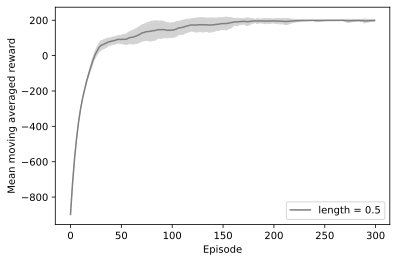

In [43]:
plt.plot([r.ep for r in training_record_simple_l_1_seed8], mean_lst, color = 'grey')
plt.fill_between( [r.ep for r in training_record_simple_l_1_seed8],std_shade_neg, std_shade_pos, color = 'lightgrey')
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['length = 0.5'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/simple_len_1_%s.png"%environment)

plt.show()

#### Length = 2

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 41
    training_record_simple_l_0_5_seed1 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -807.07 score of current env 14.0
Ep 2 Average score: -725.0630000000001 score of current env 13.0
Ep 3 Average score: -648.4567000000001 score of current env 41.0
Ep 4 Average score: -581.21103 score of current env 24.0
Ep 5 Average score: -520.2899270000001 score of current env 28.0
Ep 6 Average score: -466.6609343000001 score of current env 16.0
Ep 7 Average score: -416.99484087000013 score of current env 30.0
Ep 8 Average score: -370.1953567830001 score of current env 51.0
Ep 9 Average score: -329.6758211047001 score of current env 35.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -295.9082389942301 score of current env 8.0
Ep 11 Average score: -265.4174150948071 score of current env 9.0
Ep 12 Average score: -237.47567358532638 score of current env 14.0
Ep 13 Average score: -211.92810622679374 score of current env 18.0
Ep 14 Average score: -183.5352956041144 score of current env 72.0
Ep 15 Average score: -156.38176604370295 score of current env 88.0
Ep 16 Average score: -136.44358943933264 score of current env 43.0
Ep 17 Average score: -114.59923049539938 score of current env 82.0
Ep 18 Average score: -96.23930744585944 score of current env 69.0
Ep 19 Average score: -76.11537670127349 score of current env 105.0
Ep 20 Average score: -48.80383903114614 score of current env 197.0
Ep 21 Average score: -30.623455128031527 score of current env 133.0
Ep 22 Average score: -14.961109615228374 score of current env 126.0
Ep 23 Average score: -0.36499865370553586 score of current env 131.0
Ep 24 Average score: 15.971501211665018 score of current env 163

Ep 133 Average score: 199.9324053759311 score of current env 200.0
Ep 134 Average score: 199.939164838338 score of current env 200.0
Ep 135 Average score: 199.9452483545042 score of current env 200.0
Ep 136 Average score: 199.95072351905378 score of current env 200.0
Ep 137 Average score: 199.9556511671484 score of current env 200.0
Ep 138 Average score: 199.96008605043357 score of current env 200.0
Ep 139 Average score: 199.96407744539022 score of current env 200.0
Ep 140 Average score: 199.9676697008512 score of current env 200.0
Ep 141 Average score: 199.97090273076608 score of current env 200.0
Ep 142 Average score: 199.9738124576895 score of current env 200.0
Ep 143 Average score: 199.97643121192056 score of current env 200.0
Ep 144 Average score: 199.9787880907285 score of current env 200.0
Ep 145 Average score: 199.98090928165564 score of current env 200.0
Ep 146 Average score: 199.98281835349007 score of current env 200.0
Ep 147 Average score: 199.98453651814108 score of curren

Ep 254 Average score: 199.99999980354832 score of current env 200.0
Ep 255 Average score: 199.9999998231935 score of current env 200.0
Ep 256 Average score: 199.99999984087415 score of current env 200.0
Ep 257 Average score: 199.99999985678673 score of current env 200.0
Ep 258 Average score: 199.99999987110806 score of current env 200.0
Ep 259 Average score: 199.99999988399725 score of current env 200.0
Ep 260 Average score: 199.99999989559754 score of current env 200.0
Ep 261 Average score: 199.9999999060378 score of current env 200.0
Ep 262 Average score: 199.99999991543402 score of current env 200.0
Ep 263 Average score: 199.9999999238906 score of current env 200.0
Ep 264 Average score: 199.99999993150155 score of current env 200.0
Ep 265 Average score: 199.9999999383514 score of current env 200.0
Ep 266 Average score: 199.99999994451628 score of current env 200.0
Ep 267 Average score: 199.99999995006465 score of current env 200.0
Ep 268 Average score: 199.9999999550582 score of cur

In [7]:
pickle.dump(training_record_simple_l_0_5_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed1_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 42
    training_record_simple_l_0_5_seed2 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -805.9000000000001 score of current env 23.0
Ep 2 Average score: -723.4100000000001 score of current env 19.0
Ep 3 Average score: -648.469 score of current env 26.0
Ep 4 Average score: -581.5221 score of current env 21.0
Ep 5 Average score: -520.4698900000001 score of current env 29.0
Ep 6 Average score: -466.0229010000001 score of current env 24.0
Ep 7 Average score: -418.0206109000001 score of current env 14.0
Ep 8 Average score: -375.1185498100001 score of current env 11.0
Ep 9 Average score: -333.1066948290001 score of current env 45.0
Ep 10 Average score: -298.09602534610013 score of current env 17.0
Ep 11 Average score: -267.08642281149014 score of current env 12.0
Ep 12 Average score: -238.17778053034115 score of current env 22.0
Ep 13 Average score: -213.56000247730702 score of current env 8.0
Ep 14 Average score: -190.50400222957634 score of current env 17.0
Ep 15 Average score: -169.45360200661872 score 

Ep 124 Average score: 199.82016282653908 score of current env 200.0
Ep 125 Average score: 199.83814654388516 score of current env 200.0
Ep 126 Average score: 199.85433188949665 score of current env 200.0
Ep 127 Average score: 199.868898700547 score of current env 200.0
Ep 128 Average score: 199.8820088304923 score of current env 200.0
Ep 129 Average score: 199.8938079474431 score of current env 200.0
Ep 130 Average score: 199.9044271526988 score of current env 200.0
Ep 131 Average score: 199.91398443742892 score of current env 200.0
Ep 132 Average score: 199.92258599368603 score of current env 200.0
Ep 133 Average score: 199.93032739431743 score of current env 200.0
Ep 134 Average score: 199.9372946548857 score of current env 200.0
Ep 135 Average score: 199.94356518939713 score of current env 200.0
Ep 136 Average score: 199.94920867045744 score of current env 200.0
Ep 137 Average score: 199.9542878034117 score of current env 200.0
Ep 138 Average score: 199.95885902307052 score of curre

Ep 246 Average score: 199.9999995296019 score of current env 200.0
Ep 247 Average score: 199.9999995766417 score of current env 200.0
Ep 248 Average score: 199.99999961897754 score of current env 200.0
Ep 249 Average score: 199.9999996570798 score of current env 200.0
Ep 250 Average score: 199.9999996913718 score of current env 200.0
Ep 251 Average score: 199.99999972223463 score of current env 200.0
Ep 252 Average score: 199.99999975001117 score of current env 200.0
Ep 253 Average score: 199.99999977501005 score of current env 200.0
Ep 254 Average score: 199.99999979750905 score of current env 200.0
Ep 255 Average score: 199.99999981775815 score of current env 200.0
Ep 256 Average score: 199.99999983598235 score of current env 200.0
Ep 257 Average score: 199.99999985238412 score of current env 200.0
Ep 258 Average score: 199.9999998671457 score of current env 200.0
Ep 259 Average score: 199.99999988043115 score of current env 200.0
Ep 260 Average score: 199.99999989238805 score of cur

In [9]:
pickle.dump(training_record_simple_l_0_5_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed2_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 43
    training_record_simple_l_0_5_seed3 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.5 score of current env 35.0
Ep 1 Average score: -803.15 score of current env 37.0
Ep 2 Average score: -718.0350000000001 score of current env 48.0
Ep 3 Average score: -644.9315000000001 score of current env 13.0
Ep 4 Average score: -579.0383500000002 score of current env 14.0
Ep 5 Average score: -517.8345150000002 score of current env 33.0
Ep 6 Average score: -464.5510635000002 score of current env 15.0
Ep 7 Average score: -416.9959571500002 score of current env 11.0
Ep 8 Average score: -373.1963614350002 score of current env 21.0
Ep 9 Average score: -334.6767252915002 score of current env 12.0
Ep 10 Average score: -297.60905276235013 score of current env 36.0
Ep 11 Average score: -266.8481474861151 score of current env 10.0
Ep 12 Average score: -239.16333273750362 score of current env 10.0
Ep 13 Average score: -213.54699946375328 score of current env 17.0
Ep 14 Average score: -183.29229951737796 score of current env 89.0
Ep 15 Average score: -162.8630695656401

Ep 124 Average score: 199.77314386482556 score of current env 200.0
Ep 125 Average score: 199.795829478343 score of current env 200.0
Ep 126 Average score: 199.8162465305087 score of current env 200.0
Ep 127 Average score: 199.83462187745783 score of current env 200.0
Ep 128 Average score: 199.85115968971206 score of current env 200.0
Ep 129 Average score: 199.86604372074086 score of current env 200.0
Ep 130 Average score: 199.87943934866678 score of current env 200.0
Ep 131 Average score: 199.8914954138001 score of current env 200.0
Ep 132 Average score: 199.90234587242009 score of current env 200.0
Ep 133 Average score: 199.91211128517807 score of current env 200.0
Ep 134 Average score: 199.92090015666028 score of current env 200.0
Ep 135 Average score: 199.92881014099424 score of current env 200.0
Ep 136 Average score: 199.93592912689482 score of current env 200.0
Ep 137 Average score: 199.94233621420534 score of current env 200.0
Ep 138 Average score: 199.9481025927848 score of cur

Ep 245 Average score: 199.99999934068322 score of current env 200.0
Ep 246 Average score: 199.9999994066149 score of current env 200.0
Ep 247 Average score: 199.9999994659534 score of current env 200.0
Ep 248 Average score: 199.99999951935808 score of current env 200.0
Ep 249 Average score: 199.9999995674223 score of current env 200.0
Ep 250 Average score: 199.99999961068008 score of current env 200.0
Ep 251 Average score: 199.99999964961208 score of current env 200.0
Ep 252 Average score: 199.99999968465087 score of current env 200.0
Ep 253 Average score: 199.99999971618578 score of current env 200.0
Ep 254 Average score: 199.99999974456722 score of current env 200.0
Ep 255 Average score: 199.9999997701105 score of current env 200.0
Ep 256 Average score: 199.99999979309945 score of current env 200.0
Ep 257 Average score: 199.99999981378951 score of current env 200.0
Ep 258 Average score: 199.99999983241057 score of current env 200.0
Ep 259 Average score: 199.9999998491695 score of cur

In [11]:
pickle.dump(training_record_simple_l_0_5_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed3_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 44
    training_record_simple_l_0_5_seed4 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -805.92 score of current env 30.0
Ep 2 Average score: -724.1279999999999 score of current env 12.0
Ep 3 Average score: -650.3152 score of current env 14.0
Ep 4 Average score: -583.58368 score of current env 17.0
Ep 5 Average score: -523.725312 score of current env 15.0
Ep 6 Average score: -469.75278080000004 score of current env 16.0
Ep 7 Average score: -421.37750272000005 score of current env 14.0
Ep 8 Average score: -376.03975244800006 score of current env 32.0
Ep 9 Average score: -335.7357772032001 score of current env 27.0
Ep 10 Average score: -297.6621994828801 score of current env 45.0
Ep 11 Average score: -265.99597953459215 score of current env 19.0
Ep 12 Average score: -238.39638158113294 score of current env 10.0
Ep 13 Average score: -213.45674342301965 score of current env 11.0
Ep 14 Average score: -190.6110690807177 score of current env 15.0
Ep 15 Average score: -168.04996217264593 score of current env

Ep 124 Average score: 199.89388679670924 score of current env 200.0
Ep 125 Average score: 199.90449811703832 score of current env 200.0
Ep 126 Average score: 199.9140483053345 score of current env 200.0
Ep 127 Average score: 199.92264347480105 score of current env 200.0
Ep 128 Average score: 199.93037912732095 score of current env 200.0
Ep 129 Average score: 199.93734121458886 score of current env 200.0
Ep 130 Average score: 199.94360709312997 score of current env 200.0
Ep 131 Average score: 199.94924638381698 score of current env 200.0
Ep 132 Average score: 199.9543217454353 score of current env 200.0
Ep 133 Average score: 199.95888957089176 score of current env 200.0
Ep 134 Average score: 199.9630006138026 score of current env 200.0
Ep 135 Average score: 199.96670055242234 score of current env 200.0
Ep 136 Average score: 199.97003049718012 score of current env 200.0
Ep 137 Average score: 199.9730274474621 score of current env 200.0
Ep 138 Average score: 199.9757247027159 score of cur

Ep 246 Average score: 199.9999997224409 score of current env 200.0
Ep 247 Average score: 199.9999997501968 score of current env 200.0
Ep 248 Average score: 199.99999977517712 score of current env 200.0
Ep 249 Average score: 199.9999997976594 score of current env 200.0
Ep 250 Average score: 199.99999981789347 score of current env 200.0
Ep 251 Average score: 199.99999983610414 score of current env 200.0
Ep 252 Average score: 199.99999985249372 score of current env 200.0
Ep 253 Average score: 199.99999986724436 score of current env 200.0
Ep 254 Average score: 199.99999988051994 score of current env 200.0
Ep 255 Average score: 199.99999989246794 score of current env 200.0
Ep 256 Average score: 199.99999990322115 score of current env 200.0
Ep 257 Average score: 199.99999991289903 score of current env 200.0
Ep 258 Average score: 199.99999992160912 score of current env 200.0
Ep 259 Average score: 199.99999992944822 score of current env 200.0
Ep 260 Average score: 199.9999999365034 score of cu

In [13]:
pickle.dump(training_record_simple_l_0_5_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed4_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 45
    training_record_simple_l_0_5_seed5 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.76 score of current env 18.0
Ep 2 Average score: -723.7840000000001 score of current env 23.0
Ep 3 Average score: -648.3056000000001 score of current env 31.0
Ep 4 Average score: -581.6750400000002 score of current env 18.0
Ep 5 Average score: -520.6075360000002 score of current env 29.0
Ep 6 Average score: -463.2467824000002 score of current env 53.0
Ep 7 Average score: -414.4221041600002 score of current env 25.0
Ep 8 Average score: -370.17989374400014 score of current env 28.0
Ep 9 Average score: -331.26190436960013 score of current env 19.0
Ep 10 Average score: -296.0357139326401 score of current env 21.0
Ep 11 Average score: -265.5321425393761 score of current env 9.0
Ep 12 Average score: -237.97892828543849 score of current env 10.0
Ep 13 Average score: -213.18103545689465 score of current env 10.0
Ep 14 Average score: -187.6629319112052 score of current env 42.0
Ep 15 Average score: -165.39663872008467

Ep 124 Average score: 165.371636526339 score of current env 200.0
Ep 125 Average score: 168.8344728737051 score of current env 200.0
Ep 126 Average score: 171.9510255863346 score of current env 200.0
Ep 127 Average score: 174.75592302770113 score of current env 200.0
Ep 128 Average score: 177.28033072493102 score of current env 200.0
Ep 129 Average score: 179.55229765243791 score of current env 200.0
Ep 130 Average score: 181.59706788719413 score of current env 200.0
Ep 131 Average score: 183.43736109847472 score of current env 200.0
Ep 132 Average score: 185.09362498862725 score of current env 200.0
Ep 133 Average score: 186.58426248976454 score of current env 200.0
Ep 134 Average score: 187.9258362407881 score of current env 200.0
Ep 135 Average score: 189.13325261670929 score of current env 200.0
Ep 136 Average score: 190.21992735503835 score of current env 200.0
Ep 137 Average score: 191.19793461953452 score of current env 200.0
Ep 138 Average score: 192.0781411575811 score of curr

Ep 246 Average score: 199.9999094229611 score of current env 200.0
Ep 247 Average score: 199.999918480665 score of current env 200.0
Ep 248 Average score: 199.99992663259852 score of current env 200.0
Ep 249 Average score: 199.99993396933866 score of current env 200.0
Ep 250 Average score: 199.9999405724048 score of current env 200.0
Ep 251 Average score: 199.9999465151643 score of current env 200.0
Ep 252 Average score: 199.99995186364788 score of current env 200.0
Ep 253 Average score: 199.9999566772831 score of current env 200.0
Ep 254 Average score: 199.9999610095548 score of current env 200.0
Ep 255 Average score: 199.9999649085993 score of current env 200.0
Ep 256 Average score: 199.99996841773938 score of current env 200.0
Ep 257 Average score: 199.99997157596545 score of current env 200.0
Ep 258 Average score: 199.9999744183689 score of current env 200.0
Ep 259 Average score: 199.99997697653203 score of current env 200.0
Ep 260 Average score: 199.99997927887884 score of current

In [15]:
pickle.dump(training_record_simple_l_0_5_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed5_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 46
    training_record_simple_l_0_5_seed6 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.3 score of current env 37.0
Ep 1 Average score: -802.5699999999999 score of current env 41.0
Ep 2 Average score: -720.6129999999999 score of current env 17.0
Ep 3 Average score: -645.3516999999999 score of current env 32.0
Ep 4 Average score: -579.2165299999999 score of current env 16.0
Ep 5 Average score: -518.0948769999999 score of current env 32.0
Ep 6 Average score: -462.7853892999999 score of current env 35.0
Ep 7 Average score: -414.60685036999996 score of current env 19.0
Ep 8 Average score: -368.546165333 score of current env 46.0
Ep 9 Average score: -330.2915487997 score of current env 14.0
Ep 10 Average score: -295.66239391973 score of current env 16.0
Ep 11 Average score: -264.096154527757 score of current env 20.0
Ep 12 Average score: -236.6865390749813 score of current env 10.0
Ep 13 Average score: -211.31788516748318 score of current env 17.0
Ep 14 Average score: -183.58609665073487 score of current env 66.0
Ep 15 Average score: -160.5274869856614

Ep 124 Average score: 199.6742854267411 score of current env 200.0
Ep 125 Average score: 199.706856884067 score of current env 200.0
Ep 126 Average score: 199.73617119566032 score of current env 200.0
Ep 127 Average score: 199.7625540760943 score of current env 200.0
Ep 128 Average score: 199.78629866848487 score of current env 200.0
Ep 129 Average score: 199.8076688016364 score of current env 200.0
Ep 130 Average score: 199.82690192147277 score of current env 200.0
Ep 131 Average score: 199.8442117293255 score of current env 200.0
Ep 132 Average score: 199.85979055639297 score of current env 200.0
Ep 133 Average score: 199.87381150075367 score of current env 200.0
Ep 134 Average score: 199.88643035067832 score of current env 200.0
Ep 135 Average score: 199.8977873156105 score of current env 200.0
Ep 136 Average score: 199.90800858404944 score of current env 200.0
Ep 137 Average score: 199.9172077256445 score of current env 200.0
Ep 138 Average score: 199.92548695308005 score of curren

Ep 246 Average score: 199.99999914803192 score of current env 200.0
Ep 247 Average score: 199.99999923322872 score of current env 200.0
Ep 248 Average score: 199.99999930990586 score of current env 200.0
Ep 249 Average score: 199.99999937891528 score of current env 200.0
Ep 250 Average score: 199.99999944102376 score of current env 200.0
Ep 251 Average score: 199.9999994969214 score of current env 200.0
Ep 252 Average score: 199.99999954722927 score of current env 200.0
Ep 253 Average score: 199.99999959250636 score of current env 200.0
Ep 254 Average score: 199.99999963325573 score of current env 200.0
Ep 255 Average score: 199.99999966993016 score of current env 200.0
Ep 256 Average score: 199.99999970293715 score of current env 200.0
Ep 257 Average score: 199.99999973264343 score of current env 200.0
Ep 258 Average score: 199.99999975937908 score of current env 200.0
Ep 259 Average score: 199.99999978344118 score of current env 200.0
Ep 260 Average score: 199.99999980509708 score of

In [17]:
pickle.dump(training_record_simple_l_0_5_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed6_%s.pkl'%environment, 'wb' ))

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 4777777
    training_record_simple_l_0_5_seed7 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.7 score of current env 23.0
Ep 1 Average score: -806.6300000000001 score of current env 13.0
Ep 2 Average score: -724.5670000000001 score of current env 14.0
Ep 3 Average score: -650.4103000000001 score of current env 17.0
Ep 4 Average score: -584.0692700000002 score of current env 13.0
Ep 5 Average score: -522.7623430000002 score of current env 29.0
Ep 6 Average score: -465.8861087000002 score of current env 46.0
Ep 7 Average score: -417.99749783000016 score of current env 13.0
Ep 8 Average score: -375.09774804700015 score of current env 11.0
Ep 9 Average score: -336.08797324230017 score of current env 15.0
Ep 10 Average score: -298.17917591807014 score of current env 43.0
Ep 11 Average score: -266.8612583262631 score of current env 15.0
Ep 12 Average score: -239.0751324936368 score of current env 11.0
Ep 13 Average score: -211.96761924427312 score of current env 32.0
Ep 14 Average score: -187.3708573198458 score of current env 34.0
Ep 15 Average score: -165.8

Ep 124 Average score: 199.9021199852885 score of current env 200.0
Ep 125 Average score: 199.91190798675964 score of current env 200.0
Ep 126 Average score: 199.92071718808367 score of current env 200.0
Ep 127 Average score: 199.9286454692753 score of current env 200.0
Ep 128 Average score: 199.93578092234776 score of current env 200.0
Ep 129 Average score: 199.942202830113 score of current env 200.0
Ep 130 Average score: 199.9479825471017 score of current env 200.0
Ep 131 Average score: 199.95318429239154 score of current env 200.0
Ep 132 Average score: 199.9578658631524 score of current env 200.0
Ep 133 Average score: 199.96207927683716 score of current env 200.0
Ep 134 Average score: 199.96587134915345 score of current env 200.0
Ep 135 Average score: 199.96928421423812 score of current env 200.0
Ep 136 Average score: 199.9723557928143 score of current env 200.0
Ep 137 Average score: 199.97512021353288 score of current env 200.0
Ep 138 Average score: 199.9776081921796 score of curren

Ep 245 Average score: 199.99999971552927 score of current env 200.0
Ep 246 Average score: 199.99999974397636 score of current env 200.0
Ep 247 Average score: 199.99999976957872 score of current env 200.0
Ep 248 Average score: 199.99999979262086 score of current env 200.0
Ep 249 Average score: 199.99999981335878 score of current env 200.0
Ep 250 Average score: 199.99999983202292 score of current env 200.0
Ep 251 Average score: 199.99999984882064 score of current env 200.0
Ep 252 Average score: 199.99999986393857 score of current env 200.0
Ep 253 Average score: 199.99999987754472 score of current env 200.0
Ep 254 Average score: 199.99999988979025 score of current env 200.0
Ep 255 Average score: 199.99999990081122 score of current env 200.0
Ep 256 Average score: 199.9999999107301 score of current env 200.0
Ep 257 Average score: 199.9999999196571 score of current env 200.0
Ep 258 Average score: 199.99999992769142 score of current env 200.0
Ep 259 Average score: 199.99999993492227 score of 

In [19]:
pickle.dump(training_record_simple_l_0_5_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed7_%s.pkl'%environment, 'wb' ))

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 48
    training_record_simple_l_0_5_seed8 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -807.4499999999999 score of current env 12.0
Ep 2 Average score: -724.905 score of current env 18.0
Ep 3 Average score: -651.2144999999999 score of current env 12.0
Ep 4 Average score: -584.19305 score of current env 19.0
Ep 5 Average score: -524.273745 score of current env 15.0
Ep 6 Average score: -469.9463705 score of current env 19.0
Ep 7 Average score: -421.45173345 score of current env 15.0
Ep 8 Average score: -377.806560105 score of current env 15.0
Ep 9 Average score: -337.4259040945 score of current env 26.0
Ep 10 Average score: -301.68331368505005 score of current env 20.0
Ep 11 Average score: -270.51498231654506 score of current env 10.0
Ep 12 Average score: -242.56348408489055 score of current env 9.0
Ep 13 Average score: -217.2071356764015 score of current env 11.0
Ep 14 Average score: -190.38642210876137 score of current env 51.0
Ep 15 Average score: -168.04777989788522 score of current env 33.0
Ep 16

Ep 124 Average score: 130.66319518737743 score of current env 200.0
Ep 125 Average score: 137.59687566863968 score of current env 200.0
Ep 126 Average score: 143.83718810177572 score of current env 200.0
Ep 127 Average score: 146.15346929159816 score of current env 167.0
Ep 128 Average score: 150.93812236243835 score of current env 194.0
Ep 129 Average score: 155.84431012619453 score of current env 200.0
Ep 130 Average score: 160.25987911357507 score of current env 200.0
Ep 131 Average score: 164.23389120221756 score of current env 200.0
Ep 132 Average score: 167.81050208199582 score of current env 200.0
Ep 133 Average score: 171.02945187379623 score of current env 200.0
Ep 134 Average score: 173.92650668641662 score of current env 200.0
Ep 135 Average score: 176.53385601777495 score of current env 200.0
Ep 136 Average score: 178.88047041599745 score of current env 200.0
Ep 137 Average score: 180.9924233743977 score of current env 200.0
Ep 138 Average score: 182.89318103695794 score of

Ep 246 Average score: 199.99980440386057 score of current env 200.0
Ep 247 Average score: 199.9998239634745 score of current env 200.0
Ep 248 Average score: 199.99984156712708 score of current env 200.0
Ep 249 Average score: 199.99985741041436 score of current env 200.0
Ep 250 Average score: 199.99987166937294 score of current env 200.0
Ep 251 Average score: 199.99988450243563 score of current env 200.0
Ep 252 Average score: 199.99989605219207 score of current env 200.0
Ep 253 Average score: 199.99990644697286 score of current env 200.0
Ep 254 Average score: 199.99991580227558 score of current env 200.0
Ep 255 Average score: 199.99992422204804 score of current env 200.0
Ep 256 Average score: 199.99993179984324 score of current env 200.0
Ep 257 Average score: 199.9999386198589 score of current env 200.0
Ep 258 Average score: 199.999944757873 score of current env 200.0
Ep 259 Average score: 199.9999502820857 score of current env 200.0
Ep 260 Average score: 199.99995525387715 score of cur

In [21]:
pickle.dump(training_record_simple_l_0_5_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed8_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 49
    training_record_simple_l_0_5_seed9 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.2 score of current env 28.0
Ep 1 Average score: -806.38 score of current env 11.0
Ep 2 Average score: -724.842 score of current env 9.0
Ep 3 Average score: -650.2578 score of current env 21.0
Ep 4 Average score: -583.03202 score of current env 22.0
Ep 5 Average score: -521.4288180000001 score of current env 33.0
Ep 6 Average score: -465.5859362000001 score of current env 37.0
Ep 7 Average score: -416.9273425800001 score of current env 21.0
Ep 8 Average score: -373.3346083220001 score of current env 19.0
Ep 9 Average score: -334.9011474898001 score of current env 11.0
Ep 10 Average score: -298.71103274082014 score of current env 27.0
Ep 11 Average score: -267.7399294667381 score of current env 11.0
Ep 12 Average score: -239.96593652006428 score of current env 10.0
Ep 13 Average score: -213.56934286805784 score of current env 24.0
Ep 14 Average score: -190.5124085812521 score of current env 17.0
Ep 15 Average score: -167.9611677231269 score of current env 35.0
Ep

Ep 124 Average score: 199.92808769903905 score of current env 200.0
Ep 125 Average score: 199.93527892913517 score of current env 200.0
Ep 126 Average score: 199.94175103622166 score of current env 200.0
Ep 127 Average score: 199.9475759325995 score of current env 200.0
Ep 128 Average score: 199.95281833933956 score of current env 200.0
Ep 129 Average score: 199.9575365054056 score of current env 200.0
Ep 130 Average score: 199.96178285486505 score of current env 200.0
Ep 131 Average score: 199.96560456937854 score of current env 200.0
Ep 132 Average score: 199.96904411244068 score of current env 200.0
Ep 133 Average score: 199.97213970119662 score of current env 200.0
Ep 134 Average score: 199.97492573107698 score of current env 200.0
Ep 135 Average score: 199.97743315796927 score of current env 200.0
Ep 136 Average score: 199.97968984217235 score of current env 200.0
Ep 137 Average score: 199.9817208579551 score of current env 200.0
Ep 138 Average score: 199.9835487721596 score of cu

Ep 245 Average score: 199.99999979099977 score of current env 200.0
Ep 246 Average score: 199.99999981189978 score of current env 200.0
Ep 247 Average score: 199.9999998307098 score of current env 200.0
Ep 248 Average score: 199.99999984763883 score of current env 200.0
Ep 249 Average score: 199.99999986287494 score of current env 200.0
Ep 250 Average score: 199.99999987658745 score of current env 200.0
Ep 251 Average score: 199.9999998889287 score of current env 200.0
Ep 252 Average score: 199.99999990003585 score of current env 200.0
Ep 253 Average score: 199.99999991003227 score of current env 200.0
Ep 254 Average score: 199.99999991902905 score of current env 200.0
Ep 255 Average score: 199.99999992712614 score of current env 200.0
Ep 256 Average score: 199.99999993441352 score of current env 200.0
Ep 257 Average score: 199.99999994097217 score of current env 200.0
Ep 258 Average score: 199.99999994687496 score of current env 200.0
Ep 259 Average score: 199.99999995218747 score of 

In [23]:
pickle.dump(training_record_simple_l_0_5_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed9_%s.pkl'%environment, 'wb' ))

In [24]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj5
    seeds = 5099999999
    training_record_simple_l_0_5_seed10 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.4 score of current env 26.0
Ep 1 Average score: -804.9599999999999 score of current env 27.0
Ep 2 Average score: -722.2639999999999 score of current env 22.0
Ep 3 Average score: -643.8375999999998 score of current env 62.0
Ep 4 Average score: -578.0538399999999 score of current env 14.0
Ep 5 Average score: -518.6484559999999 score of current env 16.0
Ep 6 Average score: -465.1836103999999 score of current env 16.0
Ep 7 Average score: -415.9652493599999 score of current env 27.0
Ep 8 Average score: -373.16872442399995 score of current env 12.0
Ep 9 Average score: -331.05185198159995 score of current env 48.0
Ep 10 Average score: -295.74666678344 score of current env 22.0
Ep 11 Average score: -265.172000105096 score of current env 10.0
Ep 12 Average score: -237.65480009458642 score of current env 10.0
Ep 13 Average score: -212.3893200851278 score of current env 15.0
Ep 14 Average score: -189.65038807661503 score of current env 15.0
Ep 15 Average score: -168.68534

Ep 126 Average score: 45.651026364988056 score of current env 60.0
Ep 127 Average score: 51.78592372848925 score of current env 107.0
Ep 128 Average score: 50.40733135564032 score of current env 38.0
Ep 129 Average score: 56.96659822007629 score of current env 116.0
Ep 130 Average score: 56.56993839806867 score of current env 53.0
Ep 131 Average score: 63.01294455826181 score of current env 121.0
Ep 132 Average score: 70.71165010243563 score of current env 140.0
Ep 133 Average score: 83.64048509219207 score of current env 200.0
Ep 134 Average score: 89.07643658297286 score of current env 138.0
Ep 135 Average score: 99.26879292467558 score of current env 191.0
Ep 136 Average score: 109.34191363220802 score of current env 200.0
Ep 137 Average score: 115.30772226898722 score of current env 169.0
Ep 138 Average score: 123.7769500420885 score of current env 200.0
Ep 139 Average score: 129.19925503787965 score of current env 178.0
Ep 140 Average score: 136.2793295340917 score of current env 

Ep 248 Average score: 199.99902979269302 score of current env 200.0
Ep 249 Average score: 199.99912681342371 score of current env 200.0
Ep 250 Average score: 199.99921413208133 score of current env 200.0
Ep 251 Average score: 199.9992927188732 score of current env 200.0
Ep 252 Average score: 199.99936344698588 score of current env 200.0
Ep 253 Average score: 199.99942710228729 score of current env 200.0
Ep 254 Average score: 199.99948439205855 score of current env 200.0
Ep 255 Average score: 199.9995359528527 score of current env 200.0
Ep 256 Average score: 199.99958235756745 score of current env 200.0
Ep 257 Average score: 199.9996241218107 score of current env 200.0
Ep 258 Average score: 199.99966170962963 score of current env 200.0
Ep 259 Average score: 199.99969553866669 score of current env 200.0
Ep 260 Average score: 199.99972598480002 score of current env 200.0
Ep 261 Average score: 199.99975338632004 score of current env 200.0
Ep 262 Average score: 199.99977804768804 score of c

In [25]:
pickle.dump(training_record_simple_l_0_5_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed10_%s.pkl'%environment, 'wb' ))

In [26]:
training_record_simple_l_0_5_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed1_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed2_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed3_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed4_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed5_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed6_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed7_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed8_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed9_%s.pkl'%environment, 'rb' ))
training_record_simple_l_0_5_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_0_5_seed10_%s.pkl'%environment, 'rb' ))


l1_simple = [r.reward for r in training_record_simple_l_0_5_seed1]
l2_simple = [r.reward for r in training_record_simple_l_0_5_seed2]
l3_simple = [r.reward for r in training_record_simple_l_0_5_seed3]
l4_simple = [r.reward for r in training_record_simple_l_0_5_seed4]
l5_simple = [r.reward for r in training_record_simple_l_0_5_seed5]
l6_simple = [r.reward for r in training_record_simple_l_0_5_seed6]
l7_simple = [r.reward for r in training_record_simple_l_0_5_seed7]
l8_simple = [r.reward for r in training_record_simple_l_0_5_seed8]
l9_simple = [r.reward for r in training_record_simple_l_0_5_seed9]
l10_simple = [r.reward for r in training_record_simple_l_0_5_seed10]

In [27]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

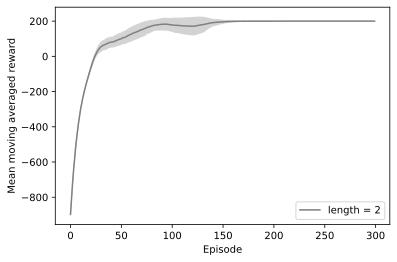

In [30]:
plt.plot([r.ep for r in training_record_simple_l_0_5_seed3], mean_lst, color = 'grey')
plt.fill_between( [r.ep for r in training_record_simple_l_0_5_seed3],std_shade_neg, std_shade_pos, color = 'lightgrey')
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['length = 2'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/simple_len_0_5_%s.png"%environment)

plt.show()

#### Length = 0.1

In [31]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 51
    training_record_simple_l_1_7_seed1 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -893.6 score of current env 64.0
Ep 1 Average score: -797.24 score of current env 70.0
Ep 2 Average score: -716.416 score of current env 11.0
Ep 3 Average score: -643.0744 score of current env 17.0
Ep 4 Average score: -577.26696 score of current env 15.0
Ep 5 Average score: -517.1402640000001 score of current env 24.0
Ep 6 Average score: -463.9262376000001 score of current env 15.0
Ep 7 Average score: -416.4336138400001 score of current env 11.0
Ep 8 Average score: -373.69025245600005 score of current env 11.0
Ep 9 Average score: -335.1212272104001 score of current env 12.0
Ep 10 Average score: -299.70910448936013 score of current env 19.0
Ep 11 Average score: -267.9381940404241 score of current env 18.0
Ep 12 Average score: -238.84437463638167 score of current env 23.0
Ep 13 Average score: -212.6599371727435 score of current env 23.0
Ep 14 Average score: -190.29394345546916 score of current env 11.0
Ep 15 Average score: -169.86454910992225 score of current env 14.0

Ep 125 Average score: 141.9750203077544 score of current env 189.0
Ep 126 Average score: 136.57751827697896 score of current env 88.0
Ep 127 Average score: 135.71976644928108 score of current env 128.0
Ep 128 Average score: 142.14778980435298 score of current env 200.0
Ep 129 Average score: 134.23301082391768 score of current env 63.0
Ep 130 Average score: 127.30970974152592 score of current env 65.0
Ep 131 Average score: 119.87873876737333 score of current env 53.0
Ep 132 Average score: 126.39086489063601 score of current env 185.0
Ep 133 Average score: 121.75177840157241 score of current env 80.0
Ep 134 Average score: 116.07660056141518 score of current env 65.0
Ep 135 Average score: 113.86894050527367 score of current env 94.0
Ep 136 Average score: 115.78204645474631 score of current env 133.0
Ep 137 Average score: 116.40384180927168 score of current env 122.0
Ep 138 Average score: 110.56345762834451 score of current env 58.0
Ep 139 Average score: 108.20711186551006 score of current

Ep 247 Average score: 185.68919915525294 score of current env 134.0
Ep 248 Average score: 178.32027923972763 score of current env 112.0
Ep 249 Average score: 169.68825131575485 score of current env 92.0
Ep 250 Average score: 161.71942618417938 score of current env 90.0
Ep 251 Average score: 151.14748356576143 score of current env 56.0
Ep 252 Average score: 144.63273520918528 score of current env 86.0
Ep 253 Average score: 140.76946168826674 score of current env 106.0
Ep 254 Average score: 135.59251551944007 score of current env 89.0
Ep 255 Average score: 130.83326396749607 score of current env 88.0
Ep 256 Average score: 125.94993757074647 score of current env 82.0
Ep 257 Average score: 121.55494381367183 score of current env 82.0
Ep 258 Average score: 121.09944943230465 score of current env 117.0
Ep 259 Average score: 118.6895044890742 score of current env 97.0
Ep 260 Average score: 116.42055404016679 score of current env 96.0
Ep 261 Average score: 119.97849863615012 score of current e

In [32]:
pickle.dump(training_record_simple_l_1_7_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed1_%s.pkl'%environment, 'wb' ))

In [33]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 52
    training_record_simple_l_1_7_seed2 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.3 score of current env 27.0
Ep 1 Average score: -804.8699999999999 score of current env 27.0
Ep 2 Average score: -723.2829999999999 score of current env 11.0
Ep 3 Average score: -649.1546999999999 score of current env 18.0
Ep 4 Average score: -582.6392299999999 score of current env 16.0
Ep 5 Average score: -523.2753069999999 score of current env 11.0
Ep 6 Average score: -470.04777629999995 score of current env 9.0
Ep 7 Average score: -421.64299867 score of current env 14.0
Ep 8 Average score: -378.278698803 score of current env 12.0
Ep 9 Average score: -339.2508289227 score of current env 12.0
Ep 10 Average score: -300.42574603043005 score of current env 49.0
Ep 11 Average score: -269.583171427387 score of current env 8.0
Ep 12 Average score: -241.6248542846483 score of current env 10.0
Ep 13 Average score: -216.46236885618347 score of current env 10.0
Ep 14 Average score: -193.61613197056514 score of current env 12.0
Ep 15 Average score: -172.85451877350863 sc

Ep 126 Average score: 77.49592496121065 score of current env 46.0
Ep 127 Average score: 74.04633246508958 score of current env 43.0
Ep 128 Average score: 71.44169921858062 score of current env 48.0
Ep 129 Average score: 68.99752929672256 score of current env 47.0
Ep 130 Average score: 67.7977763670503 score of current env 57.0
Ep 131 Average score: 81.01799873034528 score of current env 200.0
Ep 132 Average score: 86.81619885731077 score of current env 139.0
Ep 133 Average score: 81.73457897157968 score of current env 36.0
Ep 134 Average score: 76.76112107442172 score of current env 32.0
Ep 135 Average score: 75.18500896697955 score of current env 61.0
Ep 136 Average score: 72.0665080702816 score of current env 44.0
Ep 137 Average score: 69.85985726325345 score of current env 50.0
Ep 138 Average score: 75.6738715369281 score of current env 128.0
Ep 139 Average score: 73.0064843832353 score of current env 49.0
Ep 140 Average score: 68.90583594491177 score of current env 32.0
Ep 141 Aver

Ep 249 Average score: 199.91262545083296 score of current env 200.0
Ep 250 Average score: 199.92136290574967 score of current env 200.0
Ep 251 Average score: 199.9292266151747 score of current env 200.0
Ep 252 Average score: 199.93630395365724 score of current env 200.0
Ep 253 Average score: 199.94267355829152 score of current env 200.0
Ep 254 Average score: 199.94840620246237 score of current env 200.0
Ep 255 Average score: 199.95356558221613 score of current env 200.0
Ep 256 Average score: 199.95820902399453 score of current env 200.0
Ep 257 Average score: 199.96238812159507 score of current env 200.0
Ep 258 Average score: 199.96614930943556 score of current env 200.0
Ep 259 Average score: 199.969534378492 score of current env 200.0
Ep 260 Average score: 199.9725809406428 score of current env 200.0
Ep 261 Average score: 199.97532284657854 score of current env 200.0
Ep 262 Average score: 199.9777905619207 score of current env 200.0
Ep 263 Average score: 199.98001150572864 score of cur

In [34]:
pickle.dump(training_record_simple_l_1_7_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed2_%s.pkl'%environment, 'wb' ))

In [35]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 53
    training_record_simple_l_1_7_seed3 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -893.6 score of current env 64.0
Ep 1 Average score: -802.94 score of current env 13.0
Ep 2 Average score: -721.3460000000001 score of current env 13.0
Ep 3 Average score: -647.8114000000002 score of current env 14.0
Ep 4 Average score: -577.6302600000001 score of current env 54.0
Ep 5 Average score: -518.1672340000001 score of current env 17.0
Ep 6 Average score: -464.2505106000001 score of current env 21.0
Ep 7 Average score: -415.92545954000013 score of current env 19.0
Ep 8 Average score: -373.43291358600015 score of current env 9.0
Ep 9 Average score: -334.5896222274001 score of current env 15.0
Ep 10 Average score: -298.1306600046601 score of current env 30.0
Ep 11 Average score: -267.3175940041941 score of current env 10.0
Ep 12 Average score: -239.48583460377472 score of current env 11.0
Ep 13 Average score: -214.33725114339725 score of current env 12.0
Ep 14 Average score: -190.30352602905754 score of current env 26.0
Ep 15 Average score: -169.8731734261518

Ep 125 Average score: 37.317044606610665 score of current env 44.0
Ep 126 Average score: 36.8853401459496 score of current env 33.0
Ep 127 Average score: 36.396806131354644 score of current env 32.0
Ep 128 Average score: 40.357125518219185 score of current env 76.0
Ep 129 Average score: 40.52141296639727 score of current env 42.0
Ep 130 Average score: 46.66927166975755 score of current env 102.0
Ep 131 Average score: 47.502344502781796 score of current env 55.0
Ep 132 Average score: 49.95211005250362 score of current env 72.0
Ep 133 Average score: 56.756899047253256 score of current env 118.0
Ep 134 Average score: 62.881209142527936 score of current env 118.0
Ep 135 Average score: 66.29308822827514 score of current env 97.0
Ep 136 Average score: 66.56377940544763 score of current env 69.0
Ep 137 Average score: 79.90740146490288 score of current env 200.0
Ep 138 Average score: 78.01666131841259 score of current env 61.0
Ep 139 Average score: 73.71499518657133 score of current env 35.0
E

Ep 247 Average score: 199.91127117391935 score of current env 200.0
Ep 248 Average score: 195.6201440565274 score of current env 157.0
Ep 249 Average score: 196.05812965087466 score of current env 200.0
Ep 250 Average score: 196.4523166857872 score of current env 200.0
Ep 251 Average score: 195.8070850172085 score of current env 190.0
Ep 252 Average score: 196.22637651548766 score of current env 200.0
Ep 253 Average score: 196.6037388639389 score of current env 200.0
Ep 254 Average score: 196.543364977545 score of current env 196.0
Ep 255 Average score: 196.8890284797905 score of current env 200.0
Ep 256 Average score: 197.20012563181146 score of current env 200.0
Ep 257 Average score: 197.48011306863032 score of current env 200.0
Ep 258 Average score: 197.7321017617673 score of current env 200.0
Ep 259 Average score: 197.95889158559058 score of current env 200.0
Ep 260 Average score: 198.16300242703153 score of current env 200.0
Ep 261 Average score: 198.3467021843284 score of current

In [36]:
pickle.dump(training_record_simple_l_1_7_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed3_%s.pkl'%environment, 'wb' ))

In [37]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 54
    training_record_simple_l_1_7_seed4 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -807.3199999999999 score of current env 16.0
Ep 2 Average score: -724.9879999999999 score of current env 16.0
Ep 3 Average score: -650.3892 score of current env 21.0
Ep 4 Average score: -582.35028 score of current env 30.0
Ep 5 Average score: -521.415252 score of current env 27.0
Ep 6 Average score: -467.9737268 score of current env 13.0
Ep 7 Average score: -420.07635412 score of current env 11.0
Ep 8 Average score: -375.968718708 score of current env 21.0
Ep 9 Average score: -335.2718468372 score of current env 31.0
Ep 10 Average score: -299.34466215348 score of current env 24.0
Ep 11 Average score: -268.410195938132 score of current env 10.0
Ep 12 Average score: -240.5691763443188 score of current env 10.0
Ep 13 Average score: -215.61225870988693 score of current env 9.0
Ep 14 Average score: -192.95103283889824 score of current env 11.0
Ep 15 Average score: -172.6559295550084 score of current env 10.0
Ep 16 Aver

Ep 125 Average score: 187.69417327517814 score of current env 200.0
Ep 126 Average score: 188.92475594766034 score of current env 200.0
Ep 127 Average score: 190.0322803528943 score of current env 200.0
Ep 128 Average score: 191.02905231760488 score of current env 200.0
Ep 129 Average score: 191.9261470858444 score of current env 200.0
Ep 130 Average score: 192.73353237725996 score of current env 200.0
Ep 131 Average score: 193.46017913953398 score of current env 200.0
Ep 132 Average score: 194.11416122558057 score of current env 200.0
Ep 133 Average score: 194.70274510302252 score of current env 200.0
Ep 134 Average score: 195.23247059272026 score of current env 200.0
Ep 135 Average score: 195.70922353344824 score of current env 200.0
Ep 136 Average score: 196.1383011801034 score of current env 200.0
Ep 137 Average score: 196.52447106209308 score of current env 200.0
Ep 138 Average score: 196.87202395588378 score of current env 200.0
Ep 139 Average score: 197.1848215602954 score of cu

Ep 246 Average score: 199.53493984857934 score of current env 200.0
Ep 247 Average score: 199.5814458637214 score of current env 200.0
Ep 248 Average score: 199.62330127734927 score of current env 200.0
Ep 249 Average score: 199.66097114961434 score of current env 200.0
Ep 250 Average score: 199.6948740346529 score of current env 200.0
Ep 251 Average score: 199.72538663118763 score of current env 200.0
Ep 252 Average score: 199.75284796806886 score of current env 200.0
Ep 253 Average score: 199.777563171262 score of current env 200.0
Ep 254 Average score: 199.7998068541358 score of current env 200.0
Ep 255 Average score: 199.81982616872222 score of current env 200.0
Ep 256 Average score: 199.83784355185 score of current env 200.0
Ep 257 Average score: 199.854059196665 score of current env 200.0
Ep 258 Average score: 199.8686532769985 score of current env 200.0
Ep 259 Average score: 199.88178794929865 score of current env 200.0
Ep 260 Average score: 199.8936091543688 score of current en

In [38]:
pickle.dump(training_record_simple_l_1_7_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed4_%s.pkl'%environment, 'wb' ))

In [39]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 55
    training_record_simple_l_1_7_seed5 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.7800000000001 score of current env 16.0
Ep 2 Average score: -724.902 score of current env 12.0
Ep 3 Average score: -647.5118000000001 score of current env 49.0
Ep 4 Average score: -581.3606200000002 score of current env 14.0
Ep 5 Average score: -519.2245580000001 score of current env 40.0
Ep 6 Average score: -465.8021022000001 score of current env 15.0
Ep 7 Average score: -416.22189198000007 score of current env 30.0
Ep 8 Average score: -372.99970278200004 score of current env 16.0
Ep 9 Average score: -333.49973250380003 score of current env 22.0
Ep 10 Average score: -299.04975925342 score of current env 11.0
Ep 11 Average score: -268.144783328078 score of current env 10.0
Ep 12 Average score: -240.4303049952702 score of current env 9.0
Ep 13 Average score: -215.48727449574318 score of current env 9.0
Ep 14 Average score: -193.03854704616887 score of current env 9.0
Ep 15 Average score: -172.534692341552 scor

Ep 125 Average score: 106.58085793802924 score of current env 113.0
Ep 126 Average score: 108.32277214422632 score of current env 124.0
Ep 127 Average score: 108.19049492980369 score of current env 107.0
Ep 128 Average score: 109.97144543682333 score of current env 126.0
Ep 129 Average score: 110.274300893141 score of current env 113.0
Ep 130 Average score: 111.8468708038269 score of current env 126.0
Ep 131 Average score: 112.56218372344422 score of current env 119.0
Ep 132 Average score: 114.5059653510998 score of current env 132.0
Ep 133 Average score: 113.65536881598982 score of current env 106.0
Ep 134 Average score: 116.38983193439083 score of current env 141.0
Ep 135 Average score: 119.05084874095175 score of current env 143.0
Ep 136 Average score: 119.54576386685659 score of current env 124.0
Ep 137 Average score: 122.19118748017092 score of current env 146.0
Ep 138 Average score: 126.47206873215383 score of current env 165.0
Ep 139 Average score: 128.22486185893845 score of cu

Ep 247 Average score: 152.10917751065563 score of current env 189.0
Ep 248 Average score: 155.79825975959008 score of current env 189.0
Ep 249 Average score: 160.11843378363108 score of current env 199.0
Ep 250 Average score: 163.00659040526799 score of current env 189.0
Ep 251 Average score: 166.0059313647412 score of current env 193.0
Ep 252 Average score: 169.40533822826708 score of current env 200.0
Ep 253 Average score: 172.4648044054404 score of current env 200.0
Ep 254 Average score: 175.21832396489634 score of current env 200.0
Ep 255 Average score: 177.6964915684067 score of current env 200.0
Ep 256 Average score: 179.92684241156604 score of current env 200.0
Ep 257 Average score: 181.93415817040943 score of current env 200.0
Ep 258 Average score: 183.7407423533685 score of current env 200.0
Ep 259 Average score: 185.36666811803164 score of current env 200.0
Ep 260 Average score: 186.83000130622847 score of current env 200.0
Ep 261 Average score: 188.14700117560562 score of cu

In [40]:
pickle.dump(training_record_simple_l_1_7_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed5_%s.pkl'%environment, 'wb' ))

In [41]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 56
    training_record_simple_l_1_7_seed6 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -807.64 score of current env 11.0
Ep 2 Average score: -720.6759999999999 score of current env 62.0
Ep 3 Average score: -647.1084 score of current env 15.0
Ep 4 Average score: -580.69756 score of current env 17.0
Ep 5 Average score: -519.127804 score of current env 35.0
Ep 6 Average score: -466.1150236 score of current env 11.0
Ep 7 Average score: -416.00352124 score of current env 35.0
Ep 8 Average score: -372.703169116 score of current env 17.0
Ep 9 Average score: -333.93285220440004 score of current env 15.0
Ep 10 Average score: -298.33956698396 score of current env 22.0
Ep 11 Average score: -267.60561028556407 score of current env 9.0
Ep 12 Average score: -239.84504925700767 score of current env 10.0
Ep 13 Average score: -214.5605443313069 score of current env 13.0
Ep 14 Average score: -192.2044898981762 score of current env 9.0
Ep 15 Average score: -171.68404090835858 score of current env 13.0
Ep 16 Average sc

Ep 125 Average score: 158.72698094837347 score of current env 125.0
Ep 126 Average score: 160.75428285353613 score of current env 179.0
Ep 127 Average score: 157.97885456818253 score of current env 133.0
Ep 128 Average score: 159.28096911136427 score of current env 171.0
Ep 129 Average score: 160.15287220022785 score of current env 168.0
Ep 130 Average score: 160.33758498020507 score of current env 162.0
Ep 131 Average score: 163.80382648218458 score of current env 195.0
Ep 132 Average score: 160.82344383396614 score of current env 134.0
Ep 133 Average score: 164.74109945056952 score of current env 200.0
Ep 134 Average score: 163.0669895055126 score of current env 148.0
Ep 135 Average score: 161.76029055496133 score of current env 150.0
Ep 136 Average score: 163.1842614994652 score of current env 176.0
Ep 137 Average score: 162.2658353495187 score of current env 154.0
Ep 138 Average score: 159.73925181456684 score of current env 137.0
Ep 139 Average score: 162.36532663311016 score of c

Ep 247 Average score: 199.6584700189515 score of current env 200.0
Ep 248 Average score: 199.69262301705635 score of current env 200.0
Ep 249 Average score: 199.7233607153507 score of current env 200.0
Ep 250 Average score: 199.75102464381564 score of current env 200.0
Ep 251 Average score: 199.77592217943408 score of current env 200.0
Ep 252 Average score: 199.79832996149068 score of current env 200.0
Ep 253 Average score: 199.8184969653416 score of current env 200.0
Ep 254 Average score: 199.83664726880744 score of current env 200.0
Ep 255 Average score: 199.8529825419267 score of current env 200.0
Ep 256 Average score: 199.86768428773405 score of current env 200.0
Ep 257 Average score: 199.88091585896066 score of current env 200.0
Ep 258 Average score: 199.8928242730646 score of current env 200.0
Ep 259 Average score: 199.90354184575816 score of current env 200.0
Ep 260 Average score: 199.91318766118235 score of current env 200.0
Ep 261 Average score: 199.9218688950641 score of curr

In [42]:
pickle.dump(training_record_simple_l_1_7_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed6_%s.pkl'%environment, 'wb' ))

In [43]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 57
    training_record_simple_l_1_7_seed7 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.6 score of current env 44.0
Ep 1 Average score: -804.5400000000001 score of current env 15.0
Ep 2 Average score: -721.2860000000002 score of current env 28.0
Ep 3 Average score: -647.9574000000001 score of current env 12.0
Ep 4 Average score: -581.3616600000001 score of current env 18.0
Ep 5 Average score: -519.7254940000001 score of current env 35.0
Ep 6 Average score: -466.85294460000017 score of current env 9.0
Ep 7 Average score: -419.0676501400001 score of current env 11.0
Ep 8 Average score: -372.8608851260001 score of current env 43.0
Ep 9 Average score: -333.17479661340013 score of current env 24.0
Ep 10 Average score: -298.2573169520601 score of current env 16.0
Ep 11 Average score: -267.2315852568541 score of current env 12.0
Ep 12 Average score: -239.6084267311687 score of current env 9.0
Ep 13 Average score: -213.3475840580518 score of current env 23.0
Ep 14 Average score: -189.81282565224663 score of current env 22.0
Ep 15 Average score: -169.63154

Ep 125 Average score: 156.45884612984614 score of current env 160.0
Ep 126 Average score: 160.81296151686152 score of current env 200.0
Ep 127 Average score: 164.73166536517536 score of current env 200.0
Ep 128 Average score: 166.65849882865783 score of current env 184.0
Ep 129 Average score: 169.99264894579204 score of current env 200.0
Ep 130 Average score: 172.99338405121284 score of current env 200.0
Ep 131 Average score: 173.59404564609156 score of current env 179.0
Ep 132 Average score: 171.8346410814824 score of current env 156.0
Ep 133 Average score: 173.45117697333419 score of current env 188.0
Ep 134 Average score: 176.10605927600076 score of current env 200.0
Ep 135 Average score: 178.4954533484007 score of current env 200.0
Ep 136 Average score: 179.54590801356065 score of current env 189.0
Ep 137 Average score: 181.5913172122046 score of current env 200.0
Ep 138 Average score: 183.43218549098412 score of current env 200.0
Ep 139 Average score: 185.08896694188573 score of c

Ep 247 Average score: 187.4245908361842 score of current env 184.0
Ep 248 Average score: 185.28213175256576 score of current env 166.0
Ep 249 Average score: 182.45391857730917 score of current env 157.0
Ep 250 Average score: 181.00852671957827 score of current env 168.0
Ep 251 Average score: 179.80767404762045 score of current env 169.0
Ep 252 Average score: 178.7269066428584 score of current env 169.0
Ep 253 Average score: 176.55421597857256 score of current env 157.0
Ep 254 Average score: 176.0987943807153 score of current env 172.0
Ep 255 Average score: 178.4889149426438 score of current env 200.0
Ep 256 Average score: 176.64002344837942 score of current env 160.0
Ep 257 Average score: 176.7760211035415 score of current env 178.0
Ep 258 Average score: 172.99841899318736 score of current env 139.0
Ep 259 Average score: 175.69857709386864 score of current env 200.0
Ep 260 Average score: 176.52871938448178 score of current env 184.0
Ep 261 Average score: 177.1758474460336 score of curr

In [44]:
pickle.dump(training_record_simple_l_1_7_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed7_%s.pkl'%environment, 'wb' ))

In [45]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 58
    training_record_simple_l_1_7_seed8 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.9 score of current env 21.0
Ep 1 Average score: -806.01 score of current env 21.0
Ep 2 Average score: -724.009 score of current env 14.0
Ep 3 Average score: -647.7081000000001 score of current env 39.0
Ep 4 Average score: -581.9372900000001 score of current env 10.0
Ep 5 Average score: -521.4435610000002 score of current env 23.0
Ep 6 Average score: -465.99920490000017 score of current env 33.0
Ep 7 Average score: -417.9992844100002 score of current env 14.0
Ep 8 Average score: -375.2993559690002 score of current env 9.0
Ep 9 Average score: -335.5694203721002 score of current env 22.0
Ep 10 Average score: -300.51247833489015 score of current env 15.0
Ep 11 Average score: -269.26123050140114 score of current env 12.0
Ep 12 Average score: -241.43510745126102 score of current env 9.0
Ep 13 Average score: -216.39159670613492 score of current env 9.0
Ep 14 Average score: -193.75243703552144 score of current env 10.0
Ep 15 Average score: -173.4771933319693 score of c

Ep 124 Average score: 181.58170377249337 score of current env 200.0
Ep 125 Average score: 179.82353339524406 score of current env 164.0
Ep 126 Average score: 181.84118005571966 score of current env 200.0
Ep 127 Average score: 179.1570620501477 score of current env 155.0
Ep 128 Average score: 181.24135584513292 score of current env 200.0
Ep 129 Average score: 179.81722026061962 score of current env 167.0
Ep 130 Average score: 181.83549823455766 score of current env 200.0
Ep 131 Average score: 179.9519484111019 score of current env 163.0
Ep 132 Average score: 181.95675356999172 score of current env 200.0
Ep 133 Average score: 180.66107821299255 score of current env 169.0
Ep 134 Average score: 182.5949703916933 score of current env 200.0
Ep 135 Average score: 179.33547335252396 score of current env 150.0
Ep 136 Average score: 179.30192601727157 score of current env 179.0
Ep 137 Average score: 179.5717334155444 score of current env 182.0
Ep 138 Average score: 181.61456007398996 score of cu

Ep 246 Average score: 196.26742846958564 score of current env 200.0
Ep 247 Average score: 196.64068562262707 score of current env 200.0
Ep 248 Average score: 196.97661706036436 score of current env 200.0
Ep 249 Average score: 197.27895535432793 score of current env 200.0
Ep 250 Average score: 197.55105981889514 score of current env 200.0
Ep 251 Average score: 197.79595383700564 score of current env 200.0
Ep 252 Average score: 198.0163584533051 score of current env 200.0
Ep 253 Average score: 198.21472260797458 score of current env 200.0
Ep 254 Average score: 198.39325034717712 score of current env 200.0
Ep 255 Average score: 198.5539253124594 score of current env 200.0
Ep 256 Average score: 198.69853278121346 score of current env 200.0
Ep 257 Average score: 198.8286795030921 score of current env 200.0
Ep 258 Average score: 198.94581155278289 score of current env 200.0
Ep 259 Average score: 196.95123039750462 score of current env 179.0
Ep 260 Average score: 197.25610735775416 score of c

In [46]:
pickle.dump(training_record_simple_l_1_7_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed8_%s.pkl'%environment, 'wb' ))

In [47]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 59
    training_record_simple_l_1_7_seed9 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -805.3599999999999 score of current env 32.0
Ep 2 Average score: -723.7239999999999 score of current env 11.0
Ep 3 Average score: -649.6515999999999 score of current env 17.0
Ep 4 Average score: -582.18644 score of current env 25.0
Ep 5 Average score: -520.967796 score of current env 30.0
Ep 6 Average score: -467.5710164 score of current env 13.0
Ep 7 Average score: -418.81391476000005 score of current env 20.0
Ep 8 Average score: -375.7325232840001 score of current env 12.0
Ep 9 Average score: -336.75927095560013 score of current env 14.0
Ep 10 Average score: -301.58334386004015 score of current env 15.0
Ep 11 Average score: -270.42500947403613 score of current env 10.0
Ep 12 Average score: -242.48250852663253 score of current env 9.0
Ep 13 Average score: -216.43425767396926 score of current env 18.0
Ep 14 Average score: -193.69083190657233 score of current env 11.0
Ep 15 Average score: -172.5217487159151 score o

Ep 125 Average score: 136.2439946782637 score of current env 120.0
Ep 126 Average score: 134.81959521043734 score of current env 122.0
Ep 127 Average score: 136.2376356893936 score of current env 149.0
Ep 128 Average score: 138.51387212045427 score of current env 159.0
Ep 129 Average score: 140.96248490840884 score of current env 163.0
Ep 130 Average score: 146.86623641756796 score of current env 200.0
Ep 131 Average score: 152.17961277581117 score of current env 200.0
Ep 132 Average score: 156.96165149823005 score of current env 200.0
Ep 133 Average score: 161.26548634840705 score of current env 200.0
Ep 134 Average score: 165.13893771356635 score of current env 200.0
Ep 135 Average score: 168.62504394220971 score of current env 200.0
Ep 136 Average score: 171.76253954798875 score of current env 200.0
Ep 137 Average score: 172.68628559318987 score of current env 181.0
Ep 138 Average score: 175.41765703387088 score of current env 200.0
Ep 139 Average score: 174.6758913304838 score of c

Ep 247 Average score: 193.38410152637408 score of current env 190.0
Ep 248 Average score: 194.04569137373667 score of current env 200.0
Ep 249 Average score: 194.641122236363 score of current env 200.0
Ep 250 Average score: 195.1770100127267 score of current env 200.0
Ep 251 Average score: 195.65930901145404 score of current env 200.0
Ep 252 Average score: 196.09337811030863 score of current env 200.0
Ep 253 Average score: 196.48404029927778 score of current env 200.0
Ep 254 Average score: 196.83563626935 score of current env 200.0
Ep 255 Average score: 197.15207264241502 score of current env 200.0
Ep 256 Average score: 197.43686537817354 score of current env 200.0
Ep 257 Average score: 197.69317884035618 score of current env 200.0
Ep 258 Average score: 197.92386095632057 score of current env 200.0
Ep 259 Average score: 198.1314748606885 score of current env 200.0
Ep 260 Average score: 198.31832737461966 score of current env 200.0
Ep 261 Average score: 198.4864946371577 score of curren

In [48]:
pickle.dump(training_record_simple_l_1_7_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed9_%s.pkl'%environment, 'wb' ))

In [49]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj25
    seeds = 60
    training_record_simple_l_1_7_seed10 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.6 score of current env 24.0
Ep 1 Average score: -805.84 score of current env 20.0
Ep 2 Average score: -724.056 score of current env 12.0
Ep 3 Average score: -649.6504000000001 score of current env 20.0
Ep 4 Average score: -579.8853600000001 score of current env 48.0
Ep 5 Average score: -518.4968240000002 score of current env 34.0
Ep 6 Average score: -465.34714160000016 score of current env 13.0
Ep 7 Average score: -417.7124274400001 score of current env 11.0
Ep 8 Average score: -373.7411846960001 score of current env 22.0
Ep 9 Average score: -334.96706622640016 score of current env 14.0
Ep 10 Average score: -297.27035960376014 score of current env 42.0
Ep 11 Average score: -266.1433236433842 score of current env 14.0
Ep 12 Average score: -238.12899127904575 score of current env 14.0
Ep 13 Average score: -213.41609215114119 score of current env 9.0
Ep 14 Average score: -191.27448293602706 score of current env 8.0
Ep 15 Average score: -171.24703464242435 score of

Ep 124 Average score: 189.52081108798376 score of current env 200.0
Ep 125 Average score: 185.46872997918538 score of current env 149.0
Ep 126 Average score: 186.92185698126684 score of current env 200.0
Ep 127 Average score: 188.22967128314016 score of current env 200.0
Ep 128 Average score: 189.40670415482614 score of current env 200.0
Ep 129 Average score: 190.46603373934354 score of current env 200.0
Ep 130 Average score: 191.4194303654092 score of current env 200.0
Ep 131 Average score: 192.2774873288683 score of current env 200.0
Ep 132 Average score: 192.04973859598147 score of current env 190.0
Ep 133 Average score: 191.94476473638332 score of current env 191.0
Ep 134 Average score: 192.750288262745 score of current env 200.0
Ep 135 Average score: 193.3752594364705 score of current env 199.0
Ep 136 Average score: 194.03773349282343 score of current env 200.0
Ep 137 Average score: 194.6339601435411 score of current env 200.0
Ep 138 Average score: 195.17056412918697 score of curr

Ep 245 Average score: 197.835784223182 score of current env 200.0
Ep 246 Average score: 198.05220580086382 score of current env 200.0
Ep 247 Average score: 198.24698522077745 score of current env 200.0
Ep 248 Average score: 198.4222866986997 score of current env 200.0
Ep 249 Average score: 198.58005802882974 score of current env 200.0
Ep 250 Average score: 198.72205222594678 score of current env 200.0
Ep 251 Average score: 198.8498470033521 score of current env 200.0
Ep 252 Average score: 198.9648623030169 score of current env 200.0
Ep 253 Average score: 199.0683760727152 score of current env 200.0
Ep 254 Average score: 199.1615384654437 score of current env 200.0
Ep 255 Average score: 199.24538461889932 score of current env 200.0
Ep 256 Average score: 199.32084615700938 score of current env 200.0
Ep 257 Average score: 199.38876154130844 score of current env 200.0
Ep 258 Average score: 199.4498853871776 score of current env 200.0
Ep 259 Average score: 199.50489684845985 score of curren

In [50]:
pickle.dump(training_record_simple_l_1_7_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed10_%s.pkl'%environment, 'wb' ))

In [51]:
training_record_simple_l_1_7_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed1_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed2_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed3_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed4_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed5_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed6_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed7_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed8_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed9_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_7_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_7_seed10_%s.pkl'%environment, 'rb' ))


l1_simple = [r.reward for r in training_record_simple_l_1_7_seed1]
l2_simple = [r.reward for r in training_record_simple_l_1_7_seed2]
l3_simple = [r.reward for r in training_record_simple_l_1_7_seed3]
l4_simple = [r.reward for r in training_record_simple_l_1_7_seed4]
l5_simple = [r.reward for r in training_record_simple_l_1_7_seed5]
l6_simple = [r.reward for r in training_record_simple_l_1_7_seed6]
l7_simple = [r.reward for r in training_record_simple_l_1_7_seed7]
l8_simple = [r.reward for r in training_record_simple_l_1_7_seed8]
l9_simple = [r.reward for r in training_record_simple_l_1_7_seed9]
l10_simple = [r.reward for r in training_record_simple_l_1_7_seed10]

In [52]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

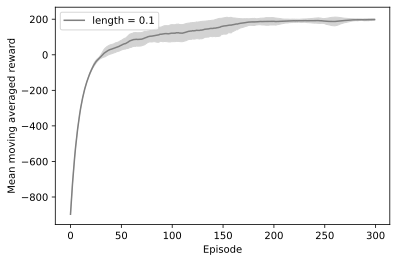

In [53]:
plt.plot([r.ep for r in training_record_simple_l_1_7_seed10], mean_lst, color = 'grey')
plt.fill_between( [r.ep for r in training_record_simple_l_1_7_seed10],std_shade_neg, std_shade_pos, color = 'lightgrey')
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['length = 0.1'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/simple_len_1_7_%s.png"%environment)

plt.show()

#### Length = 1.2

In [54]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 61
    training_record_simple_l_1_2_seed1 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -805.16 score of current env 34.0
Ep 2 Average score: -723.444 score of current env 12.0
Ep 3 Average score: -649.3996 score of current env 17.0
Ep 4 Average score: -583.0596400000001 score of current env 14.0
Ep 5 Average score: -522.153676 score of current env 26.0
Ep 6 Average score: -468.23830840000005 score of current env 17.0
Ep 7 Average score: -419.5144775600001 score of current env 19.0
Ep 8 Average score: -374.0630298040001 score of current env 35.0
Ep 9 Average score: -334.55672682360006 score of current env 21.0
Ep 10 Average score: -298.9010541412401 score of current env 22.0
Ep 11 Average score: -267.2109487271161 score of current env 18.0
Ep 12 Average score: -239.2898538544045 score of current env 12.0
Ep 13 Average score: -211.16086846896405 score of current env 42.0
Ep 14 Average score: -188.34478162206767 score of current env 17.0
Ep 15 Average score: -164.2103034598609 score of current env 53.0

Ep 125 Average score: 180.56868907516372 score of current env 200.0
Ep 126 Average score: 182.51182016764736 score of current env 200.0
Ep 127 Average score: 184.2606381508826 score of current env 200.0
Ep 128 Average score: 185.83457433579434 score of current env 200.0
Ep 129 Average score: 187.2511169022149 score of current env 200.0
Ep 130 Average score: 188.5260052119934 score of current env 200.0
Ep 131 Average score: 189.67340469079406 score of current env 200.0
Ep 132 Average score: 190.70606422171466 score of current env 200.0
Ep 133 Average score: 191.6354577995432 score of current env 200.0
Ep 134 Average score: 192.47191201958887 score of current env 200.0
Ep 135 Average score: 193.22472081763 score of current env 200.0
Ep 136 Average score: 193.902248735867 score of current env 200.0
Ep 137 Average score: 194.5120238622803 score of current env 200.0
Ep 138 Average score: 195.06082147605227 score of current env 200.0
Ep 139 Average score: 195.55473932844706 score of current 

Ep 246 Average score: 199.99994352636497 score of current env 200.0
Ep 247 Average score: 199.99994917372848 score of current env 200.0
Ep 248 Average score: 199.99995425635564 score of current env 200.0
Ep 249 Average score: 199.9999588307201 score of current env 200.0
Ep 250 Average score: 199.99996294764807 score of current env 200.0
Ep 251 Average score: 199.99996665288327 score of current env 200.0
Ep 252 Average score: 199.99996998759494 score of current env 200.0
Ep 253 Average score: 199.99997298883545 score of current env 200.0
Ep 254 Average score: 199.99997568995192 score of current env 200.0
Ep 255 Average score: 199.99997812095674 score of current env 200.0
Ep 256 Average score: 199.99998030886107 score of current env 200.0
Ep 257 Average score: 199.99998227797496 score of current env 200.0
Ep 258 Average score: 199.99998405017746 score of current env 200.0
Ep 259 Average score: 199.9999856451597 score of current env 200.0
Ep 260 Average score: 199.99998708064373 score of 

In [55]:
pickle.dump(training_record_simple_l_1_2_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed1_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 62
    training_record_simple_l_1_2_seed2 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -807.0 score of current env 12.0
Ep 2 Average score: -724.3000000000001 score of current env 20.0
Ep 3 Average score: -649.8700000000001 score of current env 20.0
Ep 4 Average score: -582.7830000000001 score of current env 21.0
Ep 5 Average score: -523.5047000000002 score of current env 10.0
Ep 6 Average score: -469.95423000000017 score of current env 12.0
Ep 7 Average score: -421.3588070000001 score of current env 16.0
Ep 8 Average score: -374.2229263000001 score of current env 50.0
Ep 9 Average score: -335.6006336700001 score of current env 12.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -300.2405703030001 score of current env 18.0
Ep 11 Average score: -269.3165132727001 score of current env 9.0
Ep 12 Average score: -241.3848619454301 score of current env 10.0
Ep 13 Average score: -216.2463757508871 score of current env 10.0
Ep 14 Average score: -193.72173817579838 score of current env 9.0
Ep 15 Average score: -172.64956435821856 score of current env 17.0
Ep 16 Average score: -153.7846079223967 score of current env 16.0
Ep 17 Average score: -136.50614713015702 score of current env 19.0
Ep 18 Average score: -118.15553241714132 score of current env 47.0
Ep 19 Average score: -103.43997917542718 score of current env 29.0
Ep 20 Average score: -84.79598125788446 score of current env 83.0
Ep 21 Average score: -73.21638313209603 score of current env 31.0
Ep 22 Average score: -55.19474481888642 score of current env 107.0
Ep 23 Average score: -29.675270336997777 score of current env 200.0
Ep 24 Average score: -6.707743303297999 score of current env 200.0
Ep 

Ep 133 Average score: 199.29161663818527 score of current env 200.0
Ep 134 Average score: 199.36245497436676 score of current env 200.0
Ep 135 Average score: 199.4262094769301 score of current env 200.0
Ep 136 Average score: 199.4835885292371 score of current env 200.0
Ep 137 Average score: 199.53522967631338 score of current env 200.0
Ep 138 Average score: 199.58170670868205 score of current env 200.0
Ep 139 Average score: 199.62353603781384 score of current env 200.0
Ep 140 Average score: 199.66118243403247 score of current env 200.0
Ep 141 Average score: 199.69506419062924 score of current env 200.0
Ep 142 Average score: 199.72555777156632 score of current env 200.0
Ep 143 Average score: 199.7530019944097 score of current env 200.0
Ep 144 Average score: 199.77770179496872 score of current env 200.0
Ep 145 Average score: 199.79993161547185 score of current env 200.0
Ep 146 Average score: 199.81993845392466 score of current env 200.0
Ep 147 Average score: 199.8379446085322 score of cu

Ep 255 Average score: 199.99999814708926 score of current env 200.0
Ep 256 Average score: 199.99999833238033 score of current env 200.0
Ep 257 Average score: 199.9999984991423 score of current env 200.0
Ep 258 Average score: 199.99999864922808 score of current env 200.0
Ep 259 Average score: 199.99999878430526 score of current env 200.0
Ep 260 Average score: 199.99999890587475 score of current env 200.0
Ep 261 Average score: 199.99999901528727 score of current env 200.0
Ep 262 Average score: 199.99999911375855 score of current env 200.0
Ep 263 Average score: 199.9999992023827 score of current env 200.0
Ep 264 Average score: 199.99999928214444 score of current env 200.0
Ep 265 Average score: 199.99999935393 score of current env 200.0
Ep 266 Average score: 199.99999941853702 score of current env 200.0
Ep 267 Average score: 199.9999994766833 score of current env 200.0
Ep 268 Average score: 199.99999952901499 score of current env 200.0
Ep 269 Average score: 199.99999957611348 score of curr

In [7]:
pickle.dump(training_record_simple_l_1_2_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed2_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 63
    training_record_simple_l_1_2_seed3 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.7 score of current env 23.0
Ep 1 Average score: -806.23 score of current env 17.0
Ep 2 Average score: -723.8070000000001 score of current env 18.0
Ep 3 Average score: -648.5263000000001 score of current env 29.0
Ep 4 Average score: -582.0736700000001 score of current env 16.0
Ep 5 Average score: -522.8663030000001 score of current env 10.0
Ep 6 Average score: -469.0796727000001 score of current env 15.0
Ep 7 Average score: -420.57170543000007 score of current env 16.0
Ep 8 Average score: -375.91453488700006 score of current env 26.0
Ep 9 Average score: -334.8230813983001 score of current env 35.0
Ep 10 Average score: -298.84077325847005 score of current env 25.0
Ep 11 Average score: -268.15669593262305 score of current env 8.0
Ep 12 Average score: -240.54102633936074 score of current env 8.0
Ep 13 Average score: -215.28692370542467 score of current env 12.0
Ep 14 Average score: -192.7582313348822 score of current env 10.0
Ep 15 Average score: -172.382408201394 

Ep 124 Average score: 199.48099373432524 score of current env 200.0
Ep 125 Average score: 199.53289436089273 score of current env 200.0
Ep 126 Average score: 199.57960492480345 score of current env 200.0
Ep 127 Average score: 199.6216444323231 score of current env 200.0
Ep 128 Average score: 199.6594799890908 score of current env 200.0
Ep 129 Average score: 199.69353199018173 score of current env 200.0
Ep 130 Average score: 199.72417879116355 score of current env 200.0
Ep 131 Average score: 199.7517609120472 score of current env 200.0
Ep 132 Average score: 199.6765848208425 score of current env 199.0
Ep 133 Average score: 199.70892633875826 score of current env 200.0
Ep 134 Average score: 199.73803370488244 score of current env 200.0
Ep 135 Average score: 199.7642303343942 score of current env 200.0
Ep 136 Average score: 197.3878073009548 score of current env 176.0
Ep 137 Average score: 197.64902657085932 score of current env 200.0
Ep 138 Average score: 197.88412391377338 score of curr

Ep 246 Average score: 199.9999758074722 score of current env 200.0
Ep 247 Average score: 199.99997822672498 score of current env 200.0
Ep 248 Average score: 199.99998040405248 score of current env 200.0
Ep 249 Average score: 199.99998236364723 score of current env 200.0
Ep 250 Average score: 199.99998412728252 score of current env 200.0
Ep 251 Average score: 199.99998571455427 score of current env 200.0
Ep 252 Average score: 199.99998714309885 score of current env 200.0
Ep 253 Average score: 199.99998842878898 score of current env 200.0
Ep 254 Average score: 199.9999895859101 score of current env 200.0
Ep 255 Average score: 199.9999906273191 score of current env 200.0
Ep 256 Average score: 199.9999915645872 score of current env 200.0
Ep 257 Average score: 199.99999240812846 score of current env 200.0
Ep 258 Average score: 199.9999931673156 score of current env 200.0
Ep 259 Average score: 199.99999385058405 score of current env 200.0
Ep 260 Average score: 199.99999446552565 score of cur

In [9]:
pickle.dump(training_record_simple_l_1_2_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed3_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 64
    training_record_simple_l_1_2_seed4 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -804.4900000000001 score of current env 38.0
Ep 2 Average score: -721.4410000000001 score of current env 26.0
Ep 3 Average score: -647.3969000000002 score of current env 19.0
Ep 4 Average score: -581.0572100000002 score of current env 16.0
Ep 5 Average score: -522.0514890000002 score of current env 9.0
Ep 6 Average score: -468.1463401000002 score of current env 17.0
Ep 7 Average score: -420.3317060900002 score of current env 10.0
Ep 8 Average score: -376.49853548100015 score of current env 18.0
Ep 9 Average score: -337.14868193290016 score of current env 17.0
Ep 10 Average score: -301.33381373961015 score of current env 21.0
Ep 11 Average score: -270.30043236564916 score of current env 9.0
Ep 12 Average score: -242.27038912908424 score of current env 10.0
Ep 13 Average score: -216.94335021617582 score of current env 11.0
Ep 14 Average score: -193.94901519455823 score of current env 13.0
Ep 15 Average score: -172.6

Ep 124 Average score: 165.10839877529966 score of current env 200.0
Ep 125 Average score: 168.5975588977697 score of current env 200.0
Ep 126 Average score: 171.7378030079927 score of current env 200.0
Ep 127 Average score: 174.56402270719343 score of current env 200.0
Ep 128 Average score: 177.1076204364741 score of current env 200.0
Ep 129 Average score: 179.3968583928267 score of current env 200.0
Ep 130 Average score: 181.457172553544 score of current env 200.0
Ep 131 Average score: 183.31145529818963 score of current env 200.0
Ep 132 Average score: 184.98030976837066 score of current env 200.0
Ep 133 Average score: 186.4822787915336 score of current env 200.0
Ep 134 Average score: 187.83405091238023 score of current env 200.0
Ep 135 Average score: 189.0506458211422 score of current env 200.0
Ep 136 Average score: 190.145581239028 score of current env 200.0
Ep 137 Average score: 191.1310231151252 score of current env 200.0
Ep 138 Average score: 192.0179208036127 score of current en

Ep 246 Average score: 199.99990873441294 score of current env 200.0
Ep 247 Average score: 199.99991786097166 score of current env 200.0
Ep 248 Average score: 199.9999260748745 score of current env 200.0
Ep 249 Average score: 199.99993346738705 score of current env 200.0
Ep 250 Average score: 199.99994012064835 score of current env 200.0
Ep 251 Average score: 199.99994610858352 score of current env 200.0
Ep 252 Average score: 199.99995149772516 score of current env 200.0
Ep 253 Average score: 199.99995634795266 score of current env 200.0
Ep 254 Average score: 199.9999607131574 score of current env 200.0
Ep 255 Average score: 199.99996464184167 score of current env 200.0
Ep 256 Average score: 199.9999681776575 score of current env 200.0
Ep 257 Average score: 199.99997135989176 score of current env 200.0
Ep 258 Average score: 199.9999742239026 score of current env 200.0
Ep 259 Average score: 199.99997680151233 score of current env 200.0
Ep 260 Average score: 199.9999791213611 score of cur

In [11]:
pickle.dump(training_record_simple_l_1_2_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed4_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 65
    training_record_simple_l_1_2_seed5 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.5 score of current env 35.0
Ep 1 Average score: -804.35 score of current env 25.0
Ep 2 Average score: -722.5150000000001 score of current env 14.0
Ep 3 Average score: -645.2635000000001 score of current env 50.0
Ep 4 Average score: -578.4371500000002 score of current env 23.0
Ep 5 Average score: -519.4934350000002 score of current env 11.0
Ep 6 Average score: -465.3440915000002 score of current env 22.0
Ep 7 Average score: -416.2096823500002 score of current env 26.0
Ep 8 Average score: -373.0887141150002 score of current env 15.0
Ep 9 Average score: -334.57984270350016 score of current env 12.0
Ep 10 Average score: -295.9218584331502 score of current env 52.0
Ep 11 Average score: -262.5296725898352 score of current env 38.0
Ep 12 Average score: -234.87670533085165 score of current env 14.0
Ep 13 Average score: -205.6890347977665 score of current env 57.0
Ep 14 Average score: -180.42013131798987 score of current env 47.0
Ep 15 Average score: -158.77811818619088

Ep 126 Average score: 79.62385370118335 score of current env 39.0
Ep 127 Average score: 86.26146833106503 score of current env 146.0
Ep 128 Average score: 88.63532149795853 score of current env 110.0
Ep 129 Average score: 95.47178934816269 score of current env 157.0
Ep 130 Average score: 100.62461041334642 score of current env 147.0
Ep 131 Average score: 106.56214937201177 score of current env 160.0
Ep 132 Average score: 109.5059344348106 score of current env 136.0
Ep 133 Average score: 114.15534099132955 score of current env 156.0
Ep 134 Average score: 115.8398068921966 score of current env 131.0
Ep 135 Average score: 110.65582620297695 score of current env 64.0
Ep 136 Average score: 119.59024358267926 score of current env 200.0
Ep 137 Average score: 127.63121922441134 score of current env 200.0
Ep 138 Average score: 134.8680973019702 score of current env 200.0
Ep 139 Average score: 141.38128757177319 score of current env 200.0
Ep 140 Average score: 147.24315881459586 score of current

Ep 248 Average score: 199.99939678823458 score of current env 200.0
Ep 249 Average score: 199.9994571094111 score of current env 200.0
Ep 250 Average score: 199.99951139847 score of current env 200.0
Ep 251 Average score: 199.999560258623 score of current env 200.0
Ep 252 Average score: 199.9996042327607 score of current env 200.0
Ep 253 Average score: 199.99964380948464 score of current env 200.0
Ep 254 Average score: 199.99967942853618 score of current env 200.0
Ep 255 Average score: 199.99971148568258 score of current env 200.0
Ep 256 Average score: 199.99974033711433 score of current env 200.0
Ep 257 Average score: 199.9997663034029 score of current env 200.0
Ep 258 Average score: 199.99978967306262 score of current env 200.0
Ep 259 Average score: 199.99981070575637 score of current env 200.0
Ep 260 Average score: 199.99982963518073 score of current env 200.0
Ep 261 Average score: 199.99984667166265 score of current env 200.0
Ep 262 Average score: 199.99986200449638 score of curren

In [13]:
pickle.dump(training_record_simple_l_1_2_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed5_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 66
    training_record_simple_l_1_2_seed6 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.8 score of current env 42.0
Ep 1 Average score: -801.52 score of current env 47.0
Ep 2 Average score: -718.0680000000001 score of current env 33.0
Ep 3 Average score: -644.2612000000001 score of current env 20.0
Ep 4 Average score: -576.6350800000001 score of current env 32.0
Ep 5 Average score: -514.1715720000002 score of current env 48.0
Ep 6 Average score: -461.0544148000002 score of current env 17.0
Ep 7 Average score: -413.2489733200002 score of current env 17.0
Ep 8 Average score: -370.22407598800015 score of current env 17.0
Ep 9 Average score: -331.10166838920014 score of current env 21.0
Ep 10 Average score: -295.3915015502801 score of current env 26.0
Ep 11 Average score: -264.7523513952521 score of current env 11.0
Ep 12 Average score: -237.3771162557269 score of current env 9.0
Ep 13 Average score: -212.63940463015422 score of current env 10.0
Ep 14 Average score: -187.9754641671388 score of current env 34.0
Ep 15 Average score: -167.3779177504249 s

Ep 124 Average score: 198.50495462406383 score of current env 200.0
Ep 125 Average score: 198.65445916165746 score of current env 200.0
Ep 126 Average score: 198.7890132454917 score of current env 200.0
Ep 127 Average score: 198.91011192094254 score of current env 200.0
Ep 128 Average score: 199.0191007288483 score of current env 200.0
Ep 129 Average score: 199.11719065596347 score of current env 200.0
Ep 130 Average score: 199.20547159036713 score of current env 200.0
Ep 131 Average score: 199.2849244313304 score of current env 200.0
Ep 132 Average score: 199.3564319881974 score of current env 200.0
Ep 133 Average score: 199.42078878937764 score of current env 200.0
Ep 134 Average score: 199.47870991043987 score of current env 200.0
Ep 135 Average score: 199.5308389193959 score of current env 200.0
Ep 136 Average score: 199.5777550274563 score of current env 200.0
Ep 137 Average score: 199.6199795247107 score of current env 200.0
Ep 138 Average score: 199.65798157223963 score of curre

Ep 246 Average score: 199.9999960894259 score of current env 200.0
Ep 247 Average score: 199.99999648048333 score of current env 200.0
Ep 248 Average score: 199.99999683243502 score of current env 200.0
Ep 249 Average score: 199.99999714919153 score of current env 200.0
Ep 250 Average score: 199.9999974342724 score of current env 200.0
Ep 251 Average score: 199.99999769084516 score of current env 200.0
Ep 252 Average score: 199.99999792176064 score of current env 200.0
Ep 253 Average score: 199.99999812958458 score of current env 200.0
Ep 254 Average score: 199.99999831662612 score of current env 200.0
Ep 255 Average score: 199.9999984849635 score of current env 200.0
Ep 256 Average score: 199.99999863646715 score of current env 200.0
Ep 257 Average score: 199.99999877282045 score of current env 200.0
Ep 258 Average score: 199.9999988955384 score of current env 200.0
Ep 259 Average score: 199.99999900598456 score of current env 200.0
Ep 260 Average score: 199.9999991053861 score of cur

In [15]:
pickle.dump(training_record_simple_l_1_2_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed6_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 67
    training_record_simple_l_1_2_seed7 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -805.37 score of current env 31.0
Ep 2 Average score: -722.233 score of current env 26.0
Ep 3 Average score: -648.2097 score of current env 18.0
Ep 4 Average score: -581.78873 score of current env 16.0
Ep 5 Average score: -520.3098570000001 score of current env 33.0
Ep 6 Average score: -466.1788713000001 score of current env 21.0
Ep 7 Average score: -416.0609841700001 score of current env 35.0
Ep 8 Average score: -371.4548857530001 score of current env 30.0
Ep 9 Average score: -331.9093971777001 score of current env 24.0
Ep 10 Average score: -291.9184574599301 score of current env 68.0
Ep 11 Average score: -261.8266117139371 score of current env 9.0
Ep 12 Average score: -234.84395054254338 score of current env 8.0
Ep 13 Average score: -210.35955548828906 score of current env 10.0
Ep 14 Average score: -183.42359993946016 score of current env 59.0
Ep 15 Average score: -162.98123994551415 score of current env 21.0
Ep

Ep 125 Average score: 199.9439749775485 score of current env 200.0
Ep 126 Average score: 199.94957747979365 score of current env 200.0
Ep 127 Average score: 199.9546197318143 score of current env 200.0
Ep 128 Average score: 199.95915775863287 score of current env 200.0
Ep 129 Average score: 199.96324198276957 score of current env 200.0
Ep 130 Average score: 199.9669177844926 score of current env 200.0
Ep 131 Average score: 199.97022600604336 score of current env 200.0
Ep 132 Average score: 199.97320340543902 score of current env 200.0
Ep 133 Average score: 199.97588306489513 score of current env 200.0
Ep 134 Average score: 199.9782947584056 score of current env 200.0
Ep 135 Average score: 199.98046528256506 score of current env 200.0
Ep 136 Average score: 199.98241875430855 score of current env 200.0
Ep 137 Average score: 199.9841768788777 score of current env 200.0
Ep 138 Average score: 199.98575919098994 score of current env 200.0
Ep 139 Average score: 199.98718327189096 score of cur

Ep 246 Average score: 199.99999983717333 score of current env 200.0
Ep 247 Average score: 199.99999985345602 score of current env 200.0
Ep 248 Average score: 199.99999986811042 score of current env 200.0
Ep 249 Average score: 199.99999988129937 score of current env 200.0
Ep 250 Average score: 199.99999989316944 score of current env 200.0
Ep 251 Average score: 199.9999999038525 score of current env 200.0
Ep 252 Average score: 199.99999991346726 score of current env 200.0
Ep 253 Average score: 199.99999992212054 score of current env 200.0
Ep 254 Average score: 199.99999992990848 score of current env 200.0
Ep 255 Average score: 199.99999993691765 score of current env 200.0
Ep 256 Average score: 199.99999994322587 score of current env 200.0
Ep 257 Average score: 199.99999994890328 score of current env 200.0
Ep 258 Average score: 199.99999995401296 score of current env 200.0
Ep 259 Average score: 199.99999995861168 score of current env 200.0
Ep 260 Average score: 199.9999999627505 score of 

In [17]:
pickle.dump(training_record_simple_l_1_2_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed7_%s.pkl'%environment, 'wb' ))

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 68
    training_record_simple_l_1_2_seed8 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.7 score of current env 33.0
Ep 1 Average score: -805.1300000000001 score of current env 19.0
Ep 2 Average score: -723.3170000000001 score of current env 13.0
Ep 3 Average score: -648.5853000000002 score of current env 24.0
Ep 4 Average score: -580.1267700000002 score of current env 36.0
Ep 5 Average score: -520.0140930000001 score of current env 21.0
Ep 6 Average score: -466.31268370000015 score of current env 17.0
Ep 7 Average score: -417.9814153300002 score of current env 17.0
Ep 8 Average score: -375.0832737970001 score of current env 11.0
Ep 9 Average score: -336.4749464173001 score of current env 11.0
Ep 10 Average score: -301.9274517755701 score of current env 9.0
Ep 11 Average score: -270.7347065980131 score of current env 10.0
Ep 12 Average score: -242.76123593821177 score of current env 9.0
Ep 13 Average score: -217.2851123443906 score of current env 12.0
Ep 14 Average score: -194.45660110995155 score of current env 11.0
Ep 15 Average score: -173.51094

Ep 124 Average score: 199.8228526198977 score of current env 200.0
Ep 125 Average score: 199.84056735790793 score of current env 200.0
Ep 126 Average score: 199.85651062211713 score of current env 200.0
Ep 127 Average score: 199.87085955990543 score of current env 200.0
Ep 128 Average score: 199.88377360391488 score of current env 200.0
Ep 129 Average score: 199.89539624352338 score of current env 200.0
Ep 130 Average score: 199.90585661917103 score of current env 200.0
Ep 131 Average score: 199.91527095725394 score of current env 200.0
Ep 132 Average score: 199.92374386152855 score of current env 200.0
Ep 133 Average score: 199.9313694753757 score of current env 200.0
Ep 134 Average score: 199.93823252783812 score of current env 200.0
Ep 135 Average score: 199.9444092750543 score of current env 200.0
Ep 136 Average score: 199.9499683475489 score of current env 200.0
Ep 137 Average score: 199.954971512794 score of current env 200.0
Ep 138 Average score: 199.9594743615146 score of curre

Ep 246 Average score: 199.99999953663755 score of current env 200.0
Ep 247 Average score: 199.9999995829738 score of current env 200.0
Ep 248 Average score: 199.99999962467643 score of current env 200.0
Ep 249 Average score: 199.9999996622088 score of current env 200.0
Ep 250 Average score: 199.99999969598792 score of current env 200.0
Ep 251 Average score: 199.99999972638915 score of current env 200.0
Ep 252 Average score: 199.99999975375025 score of current env 200.0
Ep 253 Average score: 199.9999997783752 score of current env 200.0
Ep 254 Average score: 199.9999998005377 score of current env 200.0
Ep 255 Average score: 199.99999982048394 score of current env 200.0
Ep 256 Average score: 199.99999983843554 score of current env 200.0
Ep 257 Average score: 199.999999854592 score of current env 200.0
Ep 258 Average score: 199.9999998691328 score of current env 200.0
Ep 259 Average score: 199.99999988221953 score of current env 200.0
Ep 260 Average score: 199.99999989399757 score of curre

In [19]:
pickle.dump(training_record_simple_l_1_2_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed8_%s.pkl'%environment, 'wb' ))

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 69
    training_record_simple_l_1_2_seed9 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -899.1 score of current env 9.0
Ep 1 Average score: -807.49 score of current env 17.0
Ep 2 Average score: -722.741 score of current env 40.0
Ep 3 Average score: -648.3669 score of current env 21.0
Ep 4 Average score: -581.73021 score of current env 18.0
Ep 5 Average score: -516.1571890000001 score of current env 74.0
Ep 6 Average score: -462.9414701000001 score of current env 16.0
Ep 7 Average score: -414.6473230900001 score of current env 20.0
Ep 8 Average score: -371.7825907810001 score of current env 14.0
Ep 9 Average score: -332.90433170290015 score of current env 17.0
Ep 10 Average score: -295.01389853261014 score of current env 46.0
Ep 11 Average score: -263.01250867934914 score of current env 25.0
Ep 12 Average score: -235.81125781141424 score of current env 9.0
Ep 13 Average score: -210.8301320302728 score of current env 14.0
Ep 14 Average score: -188.34711882724554 score of current env 14.0
Ep 15 Average score: -167.512406944521 score of current env 20.0
Ep

Ep 124 Average score: 199.77554551132891 score of current env 200.0
Ep 125 Average score: 199.79799096019602 score of current env 200.0
Ep 126 Average score: 199.8181918641764 score of current env 200.0
Ep 127 Average score: 199.8363726777588 score of current env 200.0
Ep 128 Average score: 199.85273540998293 score of current env 200.0
Ep 129 Average score: 199.86746186898463 score of current env 200.0
Ep 130 Average score: 199.88071568208616 score of current env 200.0
Ep 131 Average score: 199.89264411387754 score of current env 200.0
Ep 132 Average score: 199.9033797024898 score of current env 200.0
Ep 133 Average score: 199.9130417322408 score of current env 200.0
Ep 134 Average score: 199.92173755901672 score of current env 200.0
Ep 135 Average score: 199.92956380311506 score of current env 200.0
Ep 136 Average score: 199.93660742280355 score of current env 200.0
Ep 137 Average score: 199.9429466805232 score of current env 200.0
Ep 138 Average score: 199.9486520124709 score of curr

Ep 246 Average score: 199.9999994128968 score of current env 200.0
Ep 247 Average score: 199.99999947160714 score of current env 200.0
Ep 248 Average score: 199.99999952444642 score of current env 200.0
Ep 249 Average score: 199.9999995720018 score of current env 200.0
Ep 250 Average score: 199.99999961480162 score of current env 200.0
Ep 251 Average score: 199.99999965332145 score of current env 200.0
Ep 252 Average score: 199.99999968798932 score of current env 200.0
Ep 253 Average score: 199.99999971919038 score of current env 200.0
Ep 254 Average score: 199.99999974727135 score of current env 200.0
Ep 255 Average score: 199.99999977254421 score of current env 200.0
Ep 256 Average score: 199.9999997952898 score of current env 200.0
Ep 257 Average score: 199.99999981576082 score of current env 200.0
Ep 258 Average score: 199.99999983418473 score of current env 200.0
Ep 259 Average score: 199.99999985076627 score of current env 200.0
Ep 260 Average score: 199.99999986568966 score of c

In [21]:
pickle.dump(training_record_simple_l_1_2_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed9_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj27
    seeds = 70
    training_record_simple_l_1_2_seed10 = main(environment, exp, seeds, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -807.7199999999999 score of current env 12.0
Ep 2 Average score: -724.548 score of current env 24.0
Ep 3 Average score: -650.4932 score of current env 16.0
Ep 4 Average score: -583.84388 score of current env 16.0
Ep 5 Average score: -523.859492 score of current env 16.0
Ep 6 Average score: -469.7735428000001 score of current env 17.0
Ep 7 Average score: -419.6961885200001 score of current env 31.0
Ep 8 Average score: -376.12656966800006 score of current env 16.0
Ep 9 Average score: -336.6139127012001 score of current env 19.0
Ep 10 Average score: -301.35252143108005 score of current env 16.0
Ep 11 Average score: -270.41726928797203 score of current env 8.0
Ep 12 Average score: -242.47554235917482 score of current env 9.0
Ep 13 Average score: -217.22798812325735 score of current env 10.0
Ep 14 Average score: -194.00518931093163 score of current env 15.0
Ep 15 Average score: -170.50467037983847 score of current env 

Ep 125 Average score: 199.748251621354 score of current env 200.0
Ep 126 Average score: 199.7734264592186 score of current env 200.0
Ep 127 Average score: 199.79608381329675 score of current env 200.0
Ep 128 Average score: 199.81647543196706 score of current env 200.0
Ep 129 Average score: 199.83482788877035 score of current env 200.0
Ep 130 Average score: 199.8513450998933 score of current env 200.0
Ep 131 Average score: 199.86621058990397 score of current env 200.0
Ep 132 Average score: 199.8795895309136 score of current env 200.0
Ep 133 Average score: 199.89163057782224 score of current env 200.0
Ep 134 Average score: 199.90246752004003 score of current env 200.0
Ep 135 Average score: 199.91222076803604 score of current env 200.0
Ep 136 Average score: 199.92099869123243 score of current env 200.0
Ep 137 Average score: 199.92889882210918 score of current env 200.0
Ep 138 Average score: 199.93600893989827 score of current env 200.0
Ep 139 Average score: 199.94240804590845 score of cur

Ep 247 Average score: 199.99999934150452 score of current env 200.0
Ep 248 Average score: 199.99999940735407 score of current env 200.0
Ep 249 Average score: 199.99999946661868 score of current env 200.0
Ep 250 Average score: 199.99999951995682 score of current env 200.0
Ep 251 Average score: 199.99999956796114 score of current env 200.0
Ep 252 Average score: 199.99999961116504 score of current env 200.0
Ep 253 Average score: 199.99999965004855 score of current env 200.0
Ep 254 Average score: 199.9999996850437 score of current env 200.0
Ep 255 Average score: 199.99999971653932 score of current env 200.0
Ep 256 Average score: 199.9999997448854 score of current env 200.0
Ep 257 Average score: 199.99999977039687 score of current env 200.0
Ep 258 Average score: 199.99999979335718 score of current env 200.0
Ep 259 Average score: 199.99999981402146 score of current env 200.0
Ep 260 Average score: 199.99999983261932 score of current env 200.0
Ep 261 Average score: 199.9999998493574 score of c

In [23]:
pickle.dump(training_record_simple_l_1_2_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed10_%s.pkl'%environment, 'wb' ))

In [24]:
training_record_simple_l_1_2_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed1_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed2_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed3_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed4_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed5_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed6_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed7_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed8_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed9_%s.pkl'%environment, 'rb' ))
training_record_simple_l_1_2_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_record_simple_l_1_2_seed10_%s.pkl'%environment, 'rb' ))

l1_simple = [r.reward for r in training_record_simple_l_1_2_seed1]
l2_simple = [r.reward for r in training_record_simple_l_1_2_seed2]
l3_simple = [r.reward for r in training_record_simple_l_1_2_seed3]
l4_simple = [r.reward for r in training_record_simple_l_1_2_seed4]
l5_simple = [r.reward for r in training_record_simple_l_1_2_seed5]
l6_simple = [r.reward for r in training_record_simple_l_1_2_seed6]
l7_simple = [r.reward for r in training_record_simple_l_1_2_seed7]
l8_simple = [r.reward for r in training_record_simple_l_1_2_seed8]
l9_simple = [r.reward for r in training_record_simple_l_1_2_seed9]
l10_simple = [r.reward for r in training_record_simple_l_1_2_seed10]

In [25]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

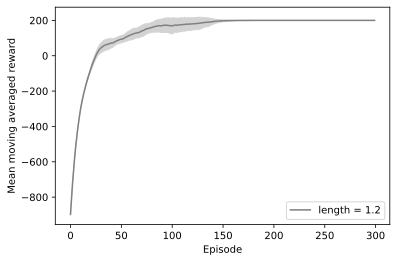

In [26]:
plt.plot([r.ep for r in training_record_simple_l_1_2_seed6], mean_lst, color = 'grey')
plt.fill_between( [r.ep for r in training_record_simple_l_1_2_seed6],std_shade_neg, std_shade_pos, color = 'lightgrey')
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['length = 1.2'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/simple_len_1_2_%s.png"%environment)

plt.show()

### Experiment 2 : 5 expert trajectories with unique length

#### Length = 2

In [27]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 71
    training_record_multi_l_1_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.0300000000001 score of current env 18.0
Ep 2 Average score: -725.3270000000001 score of current env 10.0
Ep 3 Average score: -651.1943000000001 score of current env 16.0
Ep 4 Average score: -583.9748700000001 score of current env 21.0
Ep 5 Average score: -524.4773830000001 score of current env 11.0
Ep 6 Average score: -469.5296447000001 score of current env 25.0
Ep 7 Average score: -419.37668023000015 score of current env 32.0
Ep 8 Average score: -376.23901220700014 score of current env 12.0
Ep 9 Average score: -337.0151109863001 score of current env 16.0
Ep 10 Average score: -302.4135998876701 score of current env 9.0
Ep 11 Average score: -271.0722398989031 score of current env 11.0
Ep 12 Average score: -242.36501590901278 score of current env 16.0
Ep 13 Average score: -215.52851431811152 score of current env 26.0
Ep 14 Average score: -192.77566288630038 score of current env 12.0
Ep 15 Average score: -168.09

Ep 124 Average score: 199.732519603271 score of current env 200.0
Ep 125 Average score: 199.75926764294388 score of current env 200.0
Ep 126 Average score: 199.7833408786495 score of current env 200.0
Ep 127 Average score: 199.80500679078457 score of current env 200.0
Ep 128 Average score: 199.8245061117061 score of current env 200.0
Ep 129 Average score: 199.8420555005355 score of current env 200.0
Ep 130 Average score: 199.85784995048195 score of current env 200.0
Ep 131 Average score: 199.87206495543376 score of current env 200.0
Ep 132 Average score: 199.88485845989038 score of current env 200.0
Ep 133 Average score: 199.89637261390135 score of current env 200.0
Ep 134 Average score: 199.90673535251122 score of current env 200.0
Ep 135 Average score: 199.9160618172601 score of current env 200.0
Ep 136 Average score: 199.9244556355341 score of current env 200.0
Ep 137 Average score: 199.93201007198067 score of current env 200.0
Ep 138 Average score: 199.93880906478262 score of curre

Ep 246 Average score: 199.99999930035443 score of current env 200.0
Ep 247 Average score: 199.999999370319 score of current env 200.0
Ep 248 Average score: 199.9999994332871 score of current env 200.0
Ep 249 Average score: 199.99999948995838 score of current env 200.0
Ep 250 Average score: 199.99999954096256 score of current env 200.0
Ep 251 Average score: 199.99999958686632 score of current env 200.0
Ep 252 Average score: 199.9999996281797 score of current env 200.0
Ep 253 Average score: 199.99999966536174 score of current env 200.0
Ep 254 Average score: 199.99999969882558 score of current env 200.0
Ep 255 Average score: 199.999999728943 score of current env 200.0
Ep 256 Average score: 199.9999997560487 score of current env 200.0
Ep 257 Average score: 199.99999978044383 score of current env 200.0
Ep 258 Average score: 199.99999980239946 score of current env 200.0
Ep 259 Average score: 199.9999998221595 score of current env 200.0
Ep 260 Average score: 199.99999983994357 score of curren

In [28]:
pickle.dump(training_record_multi_l_1_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed1_%s.pkl'%environment, 'wb' ))

In [30]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 72
    training_record_multi_l_1_seed2 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.0300000000001 score of current env 18.0
Ep 2 Average score: -724.7270000000001 score of current env 16.0
Ep 3 Average score: -650.2543000000001 score of current env 20.0
Ep 4 Average score: -583.62887 score of current env 16.0
Ep 5 Average score: -523.765983 score of current env 15.0
Ep 6 Average score: -469.0893847 score of current env 23.0
Ep 7 Average score: -415.78044623 score of current env 64.0
Ep 8 Average score: -371.402401607 score of current env 28.0
Ep 9 Average score: -332.4621614463 score of current env 18.0
Ep 10 Average score: -296.91594530167 score of current env 23.0
Ep 11 Average score: -266.324350771503 score of current env 9.0
Ep 12 Average score: -238.59191569435274 score of current env 11.0
Ep 13 Average score: -207.73272412491747 score of current env 70.0
Ep 14 Average score: -184.05945171242573 score of current env 29.0
Ep 15 Average score: -160.15350654118316 score of current env 55.0

Ep 124 Average score: 199.2968399677965 score of current env 200.0
Ep 125 Average score: 199.36715597101684 score of current env 200.0
Ep 126 Average score: 199.43044037391516 score of current env 200.0
Ep 127 Average score: 199.48739633652366 score of current env 200.0
Ep 128 Average score: 199.5386567028713 score of current env 200.0
Ep 129 Average score: 199.58479103258418 score of current env 200.0
Ep 130 Average score: 199.62631192932577 score of current env 200.0
Ep 131 Average score: 199.6636807363932 score of current env 200.0
Ep 132 Average score: 199.6973126627539 score of current env 200.0
Ep 133 Average score: 199.7275813964785 score of current env 200.0
Ep 134 Average score: 199.75482325683066 score of current env 200.0
Ep 135 Average score: 199.7793409311476 score of current env 200.0
Ep 136 Average score: 199.80140683803285 score of current env 200.0
Ep 137 Average score: 199.82126615422956 score of current env 200.0
Ep 138 Average score: 199.83913953880662 score of curr

Ep 245 Average score: 199.99999795639096 score of current env 200.0
Ep 246 Average score: 199.99999816075186 score of current env 200.0
Ep 247 Average score: 199.99999834467667 score of current env 200.0
Ep 248 Average score: 199.999998510209 score of current env 200.0
Ep 249 Average score: 199.9999986591881 score of current env 200.0
Ep 250 Average score: 199.9999987932693 score of current env 200.0
Ep 251 Average score: 199.99999891394236 score of current env 200.0
Ep 252 Average score: 199.99999902254814 score of current env 200.0
Ep 253 Average score: 199.99999912029332 score of current env 200.0
Ep 254 Average score: 199.999999208264 score of current env 200.0
Ep 255 Average score: 199.99999928743762 score of current env 200.0
Ep 256 Average score: 199.99999935869386 score of current env 200.0
Ep 257 Average score: 199.9999994228245 score of current env 200.0
Ep 258 Average score: 199.99999948054204 score of current env 200.0
Ep 259 Average score: 199.99999953248783 score of curre

In [31]:
pickle.dump(training_record_multi_l_1_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed2_%s.pkl'%environment, 'wb' ))

In [32]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 73
    training_record_multi_l_1_seed3 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -803.97 score of current env 45.0
Ep 2 Average score: -721.1730000000001 score of current env 24.0
Ep 3 Average score: -647.8557000000001 score of current env 12.0
Ep 4 Average score: -580.6701300000001 score of current env 24.0
Ep 5 Average score: -520.8031170000002 score of current env 18.0
Ep 6 Average score: -467.2228053000002 score of current env 15.0
Ep 7 Average score: -419.4005247700001 score of current env 11.0
Ep 8 Average score: -376.1604722930001 score of current env 13.0
Ep 9 Average score: -336.44442506370007 score of current env 21.0
Ep 10 Average score: -300.29998255733005 score of current env 25.0
Ep 11 Average score: -269.26998430159705 score of current env 10.0
Ep 12 Average score: -241.44298587143734 score of current env 9.0
Ep 13 Average score: -215.4986872842936 score of current env 18.0
Ep 14 Average score: -191.94881855586425 score of current env 20.0
Ep 15 Average score: -167.9539367002778

Ep 124 Average score: 199.6859917088471 score of current env 200.0
Ep 125 Average score: 199.71739253796238 score of current env 200.0
Ep 126 Average score: 199.74565328416614 score of current env 200.0
Ep 127 Average score: 199.77108795574952 score of current env 200.0
Ep 128 Average score: 199.7939791601746 score of current env 200.0
Ep 129 Average score: 199.81458124415713 score of current env 200.0
Ep 130 Average score: 199.83312311974143 score of current env 200.0
Ep 131 Average score: 199.84981080776728 score of current env 200.0
Ep 132 Average score: 199.86482972699056 score of current env 200.0
Ep 133 Average score: 199.8783467542915 score of current env 200.0
Ep 134 Average score: 199.89051207886234 score of current env 200.0
Ep 135 Average score: 199.9014608709761 score of current env 200.0
Ep 136 Average score: 199.9113147838785 score of current env 200.0
Ep 137 Average score: 199.92018330549067 score of current env 200.0
Ep 138 Average score: 199.9281649749416 score of curr

Ep 246 Average score: 199.99999917865193 score of current env 200.0
Ep 247 Average score: 199.99999926078675 score of current env 200.0
Ep 248 Average score: 199.9999993347081 score of current env 200.0
Ep 249 Average score: 199.9999994012373 score of current env 200.0
Ep 250 Average score: 199.99999946111356 score of current env 200.0
Ep 251 Average score: 199.9999995150022 score of current env 200.0
Ep 252 Average score: 199.99999956350197 score of current env 200.0
Ep 253 Average score: 199.99999960715178 score of current env 200.0
Ep 254 Average score: 199.9999996464366 score of current env 200.0
Ep 255 Average score: 199.99999968179296 score of current env 200.0
Ep 256 Average score: 199.99999971361368 score of current env 200.0
Ep 257 Average score: 199.9999997422523 score of current env 200.0
Ep 258 Average score: 199.99999976802707 score of current env 200.0
Ep 259 Average score: 199.99999979122435 score of current env 200.0
Ep 260 Average score: 199.99999981210192 score of cur

In [33]:
pickle.dump(training_record_multi_l_1_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed3_%s.pkl'%environment, 'wb' ))

In [34]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 74
    training_record_multi_l_1_seed4 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.4 score of current env 26.0
Ep 1 Average score: -805.66 score of current env 20.0
Ep 2 Average score: -718.194 score of current env 69.0
Ep 3 Average score: -644.2746 score of current env 21.0
Ep 4 Average score: -576.34714 score of current env 35.0
Ep 5 Average score: -511.81242599999996 score of current env 69.0
Ep 6 Average score: -454.4311834 score of current env 62.0
Ep 7 Average score: -407.58806506 score of current env 14.0
Ep 8 Average score: -362.32925855400003 score of current env 45.0
Ep 9 Average score: -323.59633269860007 score of current env 25.0
Ep 10 Average score: -289.43669942874004 score of current env 18.0
Ep 11 Average score: -259.49302948586603 score of current env 10.0
Ep 12 Average score: -231.94372653727945 score of current env 16.0
Ep 13 Average score: -207.0493538835515 score of current env 17.0
Ep 14 Average score: -181.64441849519636 score of current env 47.0
Ep 15 Average score: -159.37997664567675 score of current env 41.0
Ep 16 A

Ep 126 Average score: 194.13180409753616 score of current env 200.0
Ep 127 Average score: 194.71862368778255 score of current env 200.0
Ep 128 Average score: 195.2467613190043 score of current env 200.0
Ep 129 Average score: 195.72208518710386 score of current env 200.0
Ep 130 Average score: 196.1498766683935 score of current env 200.0
Ep 131 Average score: 196.53488900155415 score of current env 200.0
Ep 132 Average score: 196.88140010139873 score of current env 200.0
Ep 133 Average score: 197.19326009125885 score of current env 200.0
Ep 134 Average score: 197.47393408213296 score of current env 200.0
Ep 135 Average score: 197.72654067391966 score of current env 200.0
Ep 136 Average score: 197.9538866065277 score of current env 200.0
Ep 137 Average score: 198.15849794587493 score of current env 200.0
Ep 138 Average score: 198.34264815128745 score of current env 200.0
Ep 139 Average score: 198.50838333615872 score of current env 200.0
Ep 140 Average score: 198.65754500254286 score of c

Ep 248 Average score: 199.99998465062296 score of current env 200.0
Ep 249 Average score: 199.99998618556066 score of current env 200.0
Ep 250 Average score: 199.9999875670046 score of current env 200.0
Ep 251 Average score: 199.99998881030416 score of current env 200.0
Ep 252 Average score: 199.99998992927374 score of current env 200.0
Ep 253 Average score: 199.99999093634636 score of current env 200.0
Ep 254 Average score: 199.99999184271172 score of current env 200.0
Ep 255 Average score: 199.99999265844056 score of current env 200.0
Ep 256 Average score: 199.9999933925965 score of current env 200.0
Ep 257 Average score: 199.99999405333685 score of current env 200.0
Ep 258 Average score: 199.99999464800317 score of current env 200.0
Ep 259 Average score: 199.99999518320286 score of current env 200.0
Ep 260 Average score: 199.99999566488256 score of current env 200.0
Ep 261 Average score: 199.99999609839432 score of current env 200.0
Ep 262 Average score: 199.9999964885549 score of c

In [35]:
pickle.dump(training_record_multi_l_1_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed4_%s.pkl'%environment, 'wb' ))

In [36]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 75
    training_record_multi_l_1_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -807.66 score of current env 9.0
Ep 2 Average score: -724.894 score of current env 20.0
Ep 3 Average score: -651.3046 score of current env 11.0
Ep 4 Average score: -584.8741400000001 score of current env 13.0
Ep 5 Average score: -524.2867260000002 score of current env 21.0
Ep 6 Average score: -470.0580534000001 score of current env 18.0
Ep 7 Average score: -420.65224806000015 score of current env 24.0
Ep 8 Average score: -375.68702325400017 score of current env 29.0
Ep 9 Average score: -335.7183209286002 score of current env 24.0
Ep 10 Average score: -297.9464888357402 score of current env 42.0
Ep 11 Average score: -267.1518399521662 score of current env 10.0
Ep 12 Average score: -239.33665595694958 score of current env 11.0
Ep 13 Average score: -214.30299036125464 score of current env 11.0
Ep 14 Average score: -189.47269132512918 score of current env 34.0
Ep 15 Average score: -166.52542219261628 score of current 

Ep 124 Average score: 199.96863911192622 score of current env 200.0
Ep 125 Average score: 199.97177520073362 score of current env 200.0
Ep 126 Average score: 199.97459768066025 score of current env 200.0
Ep 127 Average score: 199.97713791259423 score of current env 200.0
Ep 128 Average score: 199.9794241213348 score of current env 200.0
Ep 129 Average score: 199.98148170920132 score of current env 200.0
Ep 130 Average score: 199.9833335382812 score of current env 200.0
Ep 131 Average score: 199.98500018445307 score of current env 200.0
Ep 132 Average score: 199.98650016600777 score of current env 200.0
Ep 133 Average score: 199.987850149407 score of current env 200.0
Ep 134 Average score: 199.9890651344663 score of current env 200.0
Ep 135 Average score: 199.99015862101967 score of current env 200.0
Ep 136 Average score: 199.9911427589177 score of current env 200.0
Ep 137 Average score: 199.99202848302593 score of current env 200.0
Ep 138 Average score: 199.99282563472335 score of curr

Ep 246 Average score: 199.9999999179697 score of current env 200.0
Ep 247 Average score: 199.99999992617273 score of current env 200.0
Ep 248 Average score: 199.99999993355547 score of current env 200.0
Ep 249 Average score: 199.99999994019993 score of current env 200.0
Ep 250 Average score: 199.99999994617994 score of current env 200.0
Ep 251 Average score: 199.99999995156196 score of current env 200.0
Ep 252 Average score: 199.99999995640576 score of current env 200.0
Ep 253 Average score: 199.9999999607652 score of current env 200.0
Ep 254 Average score: 199.99999996468867 score of current env 200.0
Ep 255 Average score: 199.9999999682198 score of current env 200.0
Ep 256 Average score: 199.99999997139784 score of current env 200.0
Ep 257 Average score: 199.99999997425806 score of current env 200.0
Ep 258 Average score: 199.99999997683227 score of current env 200.0
Ep 259 Average score: 199.99999997914904 score of current env 200.0
Ep 260 Average score: 199.99999998123414 score of c

In [37]:
pickle.dump(training_record_multi_l_1_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed5_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 76
    training_record_multi_l_1_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -807.1800000000001 score of current env 12.0
Ep 2 Average score: -724.1620000000001 score of current env 23.0
Ep 3 Average score: -647.7458000000001 score of current env 40.0
Ep 4 Average score: -580.6712200000002 score of current env 23.0
Ep 5 Average score: -520.7040980000002 score of current env 19.0
Ep 6 Average score: -466.53368820000014 score of current env 21.0
Ep 7 Average score: -418.8803193800001 score of current env 10.0
Ep 8 Average score: -375.29228744200014 score of current env 17.0
Ep 9 Average score: -336.56305869780016 score of current env 12.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -301.40675282802016 score of current env 15.0
Ep 11 Average score: -270.06607754521815 score of current env 12.0
Ep 12 Average score: -241.95946979069635 score of current env 11.0
Ep 13 Average score: -216.86352281162672 score of current env 9.0
Ep 14 Average score: -194.07717053046406 score of current env 11.0
Ep 15 Average score: -169.56945347741765 score of current env 51.0
Ep 16 Average score: -151.5125081296759 score of current env 11.0
Ep 17 Average score: -132.66125731670832 score of current env 37.0
Ep 18 Average score: -117.2951315850375 score of current env 21.0
Ep 19 Average score: -96.86561842653374 score of current env 87.0
Ep 20 Average score: -85.47905658388036 score of current env 17.0
Ep 21 Average score: -74.03115092549233 score of current env 29.0
Ep 22 Average score: -65.22803583294309 score of current env 14.0
Ep 23 Average score: -38.70523224964879 score of current env 200.0
Ep 24 Average score: -20.23470902468391 score of current env 146.0
Ep

Ep 133 Average score: 196.1047231029565 score of current env 200.0
Ep 134 Average score: 196.49425079266086 score of current env 200.0
Ep 135 Average score: 196.84482571339478 score of current env 200.0
Ep 136 Average score: 197.1603431420553 score of current env 200.0
Ep 137 Average score: 197.44430882784977 score of current env 200.0
Ep 138 Average score: 197.6998779450648 score of current env 200.0
Ep 139 Average score: 197.92989015055832 score of current env 200.0
Ep 140 Average score: 198.13690113550248 score of current env 200.0
Ep 141 Average score: 198.32321102195223 score of current env 200.0
Ep 142 Average score: 198.49088991975702 score of current env 200.0
Ep 143 Average score: 198.64180092778133 score of current env 200.0
Ep 144 Average score: 198.7776208350032 score of current env 200.0
Ep 145 Average score: 198.89985875150288 score of current env 200.0
Ep 146 Average score: 199.0098728763526 score of current env 200.0
Ep 147 Average score: 199.10888558871736 score of cur

Ep 255 Average score: 199.99998981116602 score of current env 200.0
Ep 256 Average score: 199.99999083004943 score of current env 200.0
Ep 257 Average score: 199.99999174704448 score of current env 200.0
Ep 258 Average score: 199.99999257234003 score of current env 200.0
Ep 259 Average score: 199.99999331510602 score of current env 200.0
Ep 260 Average score: 199.99999398359543 score of current env 200.0
Ep 261 Average score: 199.9999945852359 score of current env 200.0
Ep 262 Average score: 199.99999512671232 score of current env 200.0
Ep 263 Average score: 199.9999956140411 score of current env 200.0
Ep 264 Average score: 199.999996052637 score of current env 200.0
Ep 265 Average score: 199.9999964473733 score of current env 200.0
Ep 266 Average score: 199.99999680263596 score of current env 200.0
Ep 267 Average score: 199.99999712237238 score of current env 200.0
Ep 268 Average score: 199.99999741013514 score of current env 200.0
Ep 269 Average score: 199.99999766912163 score of cur

In [7]:
pickle.dump(training_record_multi_l_1_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed6_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 77
    training_record_multi_l_1_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.0 score of current env 30.0
Ep 1 Average score: -804.4000000000001 score of current env 29.0
Ep 2 Average score: -722.7600000000001 score of current env 12.0
Ep 3 Average score: -648.0840000000002 score of current env 24.0
Ep 4 Average score: -581.5756000000001 score of current env 17.0
Ep 5 Average score: -521.9180400000001 score of current env 15.0
Ep 6 Average score: -468.22623600000014 score of current env 15.0
Ep 7 Average score: -419.90361240000016 score of current env 15.0
Ep 8 Average score: -375.41325116000013 score of current env 25.0
Ep 9 Average score: -335.97192604400016 score of current env 19.0
Ep 10 Average score: -300.57473343960015 score of current env 18.0
Ep 11 Average score: -269.51726009564015 score of current env 10.0
Ep 12 Average score: -241.46553408607616 score of current env 11.0
Ep 13 Average score: -216.31898067746855 score of current env 10.0
Ep 14 Average score: -192.7870826097217 score of current env 19.0
Ep 15 Average score: -17

Ep 125 Average score: 195.17659282625996 score of current env 200.0
Ep 126 Average score: 195.65893354363396 score of current env 200.0
Ep 127 Average score: 196.09304018927057 score of current env 200.0
Ep 128 Average score: 196.48373617034352 score of current env 200.0
Ep 129 Average score: 196.83536255330918 score of current env 200.0
Ep 130 Average score: 197.15182629797826 score of current env 200.0
Ep 131 Average score: 197.43664366818044 score of current env 200.0
Ep 132 Average score: 197.69297930136239 score of current env 200.0
Ep 133 Average score: 197.92368137122614 score of current env 200.0
Ep 134 Average score: 198.13131323410352 score of current env 200.0
Ep 135 Average score: 198.31818191069317 score of current env 200.0
Ep 136 Average score: 198.48636371962385 score of current env 200.0
Ep 137 Average score: 198.63772734766147 score of current env 200.0
Ep 138 Average score: 198.77395461289532 score of current env 200.0
Ep 139 Average score: 198.8965591516058 score of

Ep 247 Average score: 199.99998738346565 score of current env 200.0
Ep 248 Average score: 199.9999886451191 score of current env 200.0
Ep 249 Average score: 199.9999897806072 score of current env 200.0
Ep 250 Average score: 199.99999080254648 score of current env 200.0
Ep 251 Average score: 199.99999172229184 score of current env 200.0
Ep 252 Average score: 199.99999255006267 score of current env 200.0
Ep 253 Average score: 199.9999932950564 score of current env 200.0
Ep 254 Average score: 199.99999396555077 score of current env 200.0
Ep 255 Average score: 199.9999945689957 score of current env 200.0
Ep 256 Average score: 199.99999511209614 score of current env 200.0
Ep 257 Average score: 199.99999560088654 score of current env 200.0
Ep 258 Average score: 199.9999960407979 score of current env 200.0
Ep 259 Average score: 199.9999964367181 score of current env 200.0
Ep 260 Average score: 199.9999967930463 score of current env 200.0
Ep 261 Average score: 199.99999711374167 score of curre

In [9]:
pickle.dump(training_record_multi_l_1_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed7_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 78
    training_record_multi_l_1_seed8 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -807.19 score of current env 11.0
Ep 2 Average score: -724.7710000000001 score of current env 17.0
Ep 3 Average score: -650.5939000000001 score of current env 17.0
Ep 4 Average score: -584.2345100000001 score of current env 13.0
Ep 5 Average score: -523.5110590000002 score of current env 23.0
Ep 6 Average score: -469.55995310000014 score of current env 16.0
Ep 7 Average score: -421.2039577900002 score of current env 14.0
Ep 8 Average score: -377.68356201100016 score of current env 14.0
Ep 9 Average score: -336.91520580990016 score of current env 30.0
Ep 10 Average score: -301.82368522891016 score of current env 14.0
Ep 11 Average score: -269.34131670601914 score of current env 23.0
Ep 12 Average score: -241.40718503541723 score of current env 10.0
Ep 13 Average score: -216.26646653187552 score of current env 10.0
Ep 14 Average score: -193.63981987868797 score of current env 10.0
Ep 15 Average score: -172.875837890

Ep 125 Average score: 164.35803136819615 score of current env 200.0
Ep 126 Average score: 167.92222823137655 score of current env 200.0
Ep 127 Average score: 171.1300054082389 score of current env 200.0
Ep 128 Average score: 174.017004867415 score of current env 200.0
Ep 129 Average score: 176.6153043806735 score of current env 200.0
Ep 130 Average score: 178.95377394260615 score of current env 200.0
Ep 131 Average score: 181.05839654834554 score of current env 200.0
Ep 132 Average score: 182.952556893511 score of current env 200.0
Ep 133 Average score: 184.6573012041599 score of current env 200.0
Ep 134 Average score: 186.1915710837439 score of current env 200.0
Ep 135 Average score: 187.5724139753695 score of current env 200.0
Ep 136 Average score: 187.11517257783257 score of current env 183.0
Ep 137 Average score: 188.40365532004932 score of current env 200.0
Ep 138 Average score: 189.0632897880444 score of current env 195.0
Ep 139 Average score: 190.15696080923996 score of current 

Ep 247 Average score: 199.99988745654758 score of current env 200.0
Ep 248 Average score: 199.99989871089284 score of current env 200.0
Ep 249 Average score: 199.99990883980357 score of current env 200.0
Ep 250 Average score: 199.9999179558232 score of current env 200.0
Ep 251 Average score: 199.9999261602409 score of current env 200.0
Ep 252 Average score: 199.99993354421682 score of current env 200.0
Ep 253 Average score: 199.99994018979513 score of current env 200.0
Ep 254 Average score: 199.9999461708156 score of current env 200.0
Ep 255 Average score: 199.99995155373404 score of current env 200.0
Ep 256 Average score: 199.99995639836064 score of current env 200.0
Ep 257 Average score: 199.99996075852457 score of current env 200.0
Ep 258 Average score: 199.9999646826721 score of current env 200.0
Ep 259 Average score: 199.9999682144049 score of current env 200.0
Ep 260 Average score: 199.99997139296443 score of current env 200.0
Ep 261 Average score: 199.999974253668 score of curre

In [11]:
pickle.dump(training_record_multi_l_1_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed8_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 79
    training_record_multi_l_1_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.2 score of current env 28.0
Ep 1 Average score: -804.1800000000001 score of current env 33.0
Ep 2 Average score: -719.9620000000001 score of current env 38.0
Ep 3 Average score: -645.1658000000001 score of current env 28.0
Ep 4 Average score: -579.4492200000001 score of current env 12.0
Ep 5 Average score: -519.404298 score of current env 21.0
Ep 6 Average score: -464.3638682 score of current env 31.0
Ep 7 Average score: -415.82748138 score of current env 21.0
Ep 8 Average score: -372.644733242 score of current env 16.0
Ep 9 Average score: -331.1802599178 score of current env 42.0
Ep 10 Average score: -294.46223392602 score of current env 36.0
Ep 11 Average score: -264.016010533418 score of current env 10.0
Ep 12 Average score: -235.2144094800762 score of current env 24.0
Ep 13 Average score: -209.89296853206858 score of current env 18.0
Ep 14 Average score: -180.20367167886172 score of current env 87.0
Ep 15 Average score: -154.48330451097556 score of current 

Ep 125 Average score: 194.5684118763969 score of current env 200.0
Ep 126 Average score: 195.1115706887572 score of current env 200.0
Ep 127 Average score: 195.6004136198815 score of current env 200.0
Ep 128 Average score: 196.04037225789335 score of current env 200.0
Ep 129 Average score: 196.436335032104 score of current env 200.0
Ep 130 Average score: 196.79270152889362 score of current env 200.0
Ep 131 Average score: 197.11343137600426 score of current env 200.0
Ep 132 Average score: 197.40208823840385 score of current env 200.0
Ep 133 Average score: 197.66187941456346 score of current env 200.0
Ep 134 Average score: 197.89569147310712 score of current env 200.0
Ep 135 Average score: 198.1061223257964 score of current env 200.0
Ep 136 Average score: 198.29551009321676 score of current env 200.0
Ep 137 Average score: 198.4659590838951 score of current env 200.0
Ep 138 Average score: 198.61936317550558 score of current env 200.0
Ep 139 Average score: 198.75742685795504 score of curre

Ep 247 Average score: 199.99998579265326 score of current env 200.0
Ep 248 Average score: 199.99998721338795 score of current env 200.0
Ep 249 Average score: 199.99998849204917 score of current env 200.0
Ep 250 Average score: 199.99998964284427 score of current env 200.0
Ep 251 Average score: 199.99999067855984 score of current env 200.0
Ep 252 Average score: 199.99999161070386 score of current env 200.0
Ep 253 Average score: 199.99999244963348 score of current env 200.0
Ep 254 Average score: 199.99999320467015 score of current env 200.0
Ep 255 Average score: 199.99999388420315 score of current env 200.0
Ep 256 Average score: 199.99999449578283 score of current env 200.0
Ep 257 Average score: 199.99999504620456 score of current env 200.0
Ep 258 Average score: 199.9999955415841 score of current env 200.0
Ep 259 Average score: 199.9999959874257 score of current env 200.0
Ep 260 Average score: 199.99999638868314 score of current env 200.0
Ep 261 Average score: 199.99999674981484 score of 

In [13]:
pickle.dump(training_record_multi_l_1_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed9_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 80
    training_record_multi_l_1_seed10 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.3 score of current env 27.0
Ep 1 Average score: -805.67 score of current env 19.0
Ep 2 Average score: -724.0029999999999 score of current env 11.0
Ep 3 Average score: -645.2026999999999 score of current env 64.0
Ep 4 Average score: -578.68243 score of current env 20.0
Ep 5 Average score: -518.314187 score of current env 25.0
Ep 6 Average score: -464.9827683 score of current env 15.0
Ep 7 Average score: -417.48449146999997 score of current env 10.0
Ep 8 Average score: -370.436042323 score of current env 53.0
Ep 9 Average score: -332.0924380907 score of current env 13.0
Ep 10 Average score: -295.88319428163 score of current env 30.0
Ep 11 Average score: -264.69487485346696 score of current env 16.0
Ep 12 Average score: -237.32538736812026 score of current env 9.0
Ep 13 Average score: -210.99284863130825 score of current env 26.0
Ep 14 Average score: -185.5935637681774 score of current env 43.0
Ep 15 Average score: -164.33420739135968 score of current env 27.0
Ep 

Ep 125 Average score: 199.79549663559015 score of current env 200.0
Ep 126 Average score: 199.81594697203116 score of current env 200.0
Ep 127 Average score: 199.83435227482803 score of current env 200.0
Ep 128 Average score: 199.85091704734523 score of current env 200.0
Ep 129 Average score: 199.86582534261072 score of current env 200.0
Ep 130 Average score: 199.87924280834966 score of current env 200.0
Ep 131 Average score: 199.8913185275147 score of current env 200.0
Ep 132 Average score: 199.90218667476324 score of current env 200.0
Ep 133 Average score: 199.91196800728693 score of current env 200.0
Ep 134 Average score: 199.92077120655824 score of current env 200.0
Ep 135 Average score: 199.92869408590244 score of current env 200.0
Ep 136 Average score: 199.93582467731218 score of current env 200.0
Ep 137 Average score: 199.94224220958097 score of current env 200.0
Ep 138 Average score: 199.94801798862287 score of current env 200.0
Ep 139 Average score: 199.95321618976058 score of

Ep 246 Average score: 199.99999940564757 score of current env 200.0
Ep 247 Average score: 199.99999946508282 score of current env 200.0
Ep 248 Average score: 199.99999951857455 score of current env 200.0
Ep 249 Average score: 199.9999995667171 score of current env 200.0
Ep 250 Average score: 199.9999996100454 score of current env 200.0
Ep 251 Average score: 199.99999964904086 score of current env 200.0
Ep 252 Average score: 199.99999968413678 score of current env 200.0
Ep 253 Average score: 199.9999997157231 score of current env 200.0
Ep 254 Average score: 199.9999997441508 score of current env 200.0
Ep 255 Average score: 199.99999976973572 score of current env 200.0
Ep 256 Average score: 199.99999979276217 score of current env 200.0
Ep 257 Average score: 199.99999981348594 score of current env 200.0
Ep 258 Average score: 199.99999983213735 score of current env 200.0
Ep 259 Average score: 199.9999998489236 score of current env 200.0
Ep 260 Average score: 199.99999986403125 score of cur

In [15]:
pickle.dump(training_record_multi_l_1_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed10_%s.pkl'%environment, 'wb' ))

In [12]:
mmottraining_record_multi_l_1_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed1_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed2_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed3_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed4_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed5_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed6_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed7_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed8_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed9_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_seed10_%s.pkl'%environment,'rb' ))


l1_simple = [r.reward for r in mmottraining_record_multi_l_1_seed1]
l2_simple = [r.reward for r in mmottraining_record_multi_l_1_seed2]
l3_simple = [r.reward for r in mmottraining_record_multi_l_1_seed3]
l4_simple = [r.reward for r in mmottraining_record_multi_l_1_seed4]
l5_simple = [r.reward for r in mmottraining_record_multi_l_1_seed5]
l6_simple = [r.reward for r in mmottraining_record_multi_l_1_seed6]
l7_simple = [r.reward for r in mmottraining_record_multi_l_1_seed7]
l8_simple = [r.reward for r in mmottraining_record_multi_l_1_seed8]
l9_simple = [r.reward for r in mmottraining_record_multi_l_1_seed9]
l10_simple = [r.reward for r in mmottraining_record_multi_l_1_seed10]

In [13]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 711
    training_record_multi_l_1_seed1 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -807.8199999999999 score of current env 11.0
Ep 2 Average score: -723.738 score of current env 33.0
Ep 3 Average score: -650.0642000000001 score of current env 13.0
Ep 4 Average score: -583.85778 score of current env 12.0
Ep 5 Average score: -523.1720020000001 score of current env 23.0
Ep 6 Average score: -469.95480180000015 score of current env 9.0
Ep 7 Average score: -419.1593216200001 score of current env 38.0
Ep 8 Average score: -375.04338945800015 score of current env 22.0
Ep 9 Average score: -334.73905051220015 score of current env 28.0
Ep 10 Average score: -299.86514546098016 score of current env 14.0
Ep 11 Average score: -268.87863091488214 score of current env 10.0
Ep 12 Average score: -241.09076782339392 score of current env 9.0
Ep 13 Average score: -214.48169104105452 score of current env 25.0
Ep 14 Average score: -191.73352193694905 score of current env 13.0
Ep 15 Average score: -170.96016974325414 sco

Ep 124 Average score: 98.17745668016728 score of current env 108.0
Ep 125 Average score: 98.75971101215056 score of current env 104.0
Ep 126 Average score: 102.1837399109355 score of current env 133.0
Ep 127 Average score: 102.66536591984196 score of current env 107.0
Ep 128 Average score: 103.69882932785777 score of current env 113.0
Ep 129 Average score: 104.12894639507199 score of current env 108.0
Ep 130 Average score: 106.51605175556479 score of current env 128.0
Ep 131 Average score: 109.06444658000831 score of current env 132.0
Ep 132 Average score: 110.65800192200749 score of current env 125.0
Ep 133 Average score: 114.59220172980675 score of current env 150.0
Ep 134 Average score: 116.43298155682606 score of current env 133.0
Ep 135 Average score: 122.18968340114347 score of current env 174.0
Ep 136 Average score: 128.97071506102913 score of current env 190.0
Ep 137 Average score: 133.0736435549262 score of current env 170.0
Ep 138 Average score: 138.06627919943358 score of cu

Ep 245 Average score: 199.98375914722314 score of current env 200.0
Ep 246 Average score: 199.98538323250082 score of current env 200.0
Ep 247 Average score: 199.98684490925075 score of current env 200.0
Ep 248 Average score: 199.9881604183257 score of current env 200.0
Ep 249 Average score: 199.98934437649314 score of current env 200.0
Ep 250 Average score: 199.99040993884384 score of current env 200.0
Ep 251 Average score: 199.99136894495945 score of current env 200.0
Ep 252 Average score: 199.9922320504635 score of current env 200.0
Ep 253 Average score: 199.99300884541717 score of current env 200.0
Ep 254 Average score: 199.99370796087544 score of current env 200.0
Ep 255 Average score: 199.9943371647879 score of current env 200.0
Ep 256 Average score: 199.99490344830912 score of current env 200.0
Ep 257 Average score: 199.9954131034782 score of current env 200.0
Ep 258 Average score: 199.9958717931304 score of current env 200.0
Ep 259 Average score: 199.99628461381735 score of cur

In [19]:
pickle.dump(training_record_multi_l_1_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed1_%s.pkl'%environment, 'wb' ))

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 721
    training_record_multi_l_1_seed2 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -804.0300000000001 score of current env 48.0
Ep 2 Average score: -720.927 score of current env 27.0
Ep 3 Average score: -646.3343 score of current env 25.0
Ep 4 Average score: -578.40087 score of current env 33.0
Ep 5 Average score: -515.460783 score of current env 51.0
Ep 6 Average score: -460.1147047 score of current env 38.0
Ep 7 Average score: -412.60323423 score of current env 15.0
Ep 8 Average score: -367.742910807 score of current env 36.0
Ep 9 Average score: -328.2686197263 score of current env 27.0
Ep 10 Average score: -292.44175775367 score of current env 30.0
Ep 11 Average score: -261.897581978303 score of current env 13.0
Ep 12 Average score: -229.6078237804727 score of current env 61.0
Ep 13 Average score: -204.44704140242544 score of current env 22.0
Ep 14 Average score: -179.0023372621829 score of current env 50.0
Ep 15 Average score: -157.2021035359646 score of current env 39.0
Ep 16 Average score:

Ep 125 Average score: 198.73038808866582 score of current env 200.0
Ep 126 Average score: 198.85734927979925 score of current env 200.0
Ep 127 Average score: 198.97161435181934 score of current env 200.0
Ep 128 Average score: 199.0744529166374 score of current env 200.0
Ep 129 Average score: 199.16700762497365 score of current env 200.0
Ep 130 Average score: 199.2503068624763 score of current env 200.0
Ep 131 Average score: 199.32527617622867 score of current env 200.0
Ep 132 Average score: 199.3927485586058 score of current env 200.0
Ep 133 Average score: 199.4534737027452 score of current env 200.0
Ep 134 Average score: 199.5081263324707 score of current env 200.0
Ep 135 Average score: 199.55731369922364 score of current env 200.0
Ep 136 Average score: 199.6015823293013 score of current env 200.0
Ep 137 Average score: 199.64142409637117 score of current env 200.0
Ep 138 Average score: 199.67728168673406 score of current env 200.0
Ep 139 Average score: 199.70955351806066 score of curr

Ep 247 Average score: 199.99999667908978 score of current env 200.0
Ep 248 Average score: 199.9999970111808 score of current env 200.0
Ep 249 Average score: 199.99999731006272 score of current env 200.0
Ep 250 Average score: 199.99999757905647 score of current env 200.0
Ep 251 Average score: 199.99999782115083 score of current env 200.0
Ep 252 Average score: 199.99999803903575 score of current env 200.0
Ep 253 Average score: 199.99999823513218 score of current env 200.0
Ep 254 Average score: 199.99999841161898 score of current env 200.0
Ep 255 Average score: 199.99999857045708 score of current env 200.0
Ep 256 Average score: 199.99999871341137 score of current env 200.0
Ep 257 Average score: 199.99999884207023 score of current env 200.0
Ep 258 Average score: 199.9999989578632 score of current env 200.0
Ep 259 Average score: 199.99999906207688 score of current env 200.0
Ep 260 Average score: 199.9999991558692 score of current env 200.0
Ep 261 Average score: 199.99999924028228 score of c

In [21]:
pickle.dump(training_record_multi_l_1_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed2_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 731
    training_record_multi_l_1_seed3 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -807.16 score of current env 14.0
Ep 2 Average score: -724.944 score of current env 15.0
Ep 3 Average score: -650.3496 score of current env 21.0
Ep 4 Average score: -583.9146400000001 score of current env 14.0
Ep 5 Average score: -523.823176 score of current env 17.0
Ep 6 Average score: -467.9408584 score of current env 35.0
Ep 7 Average score: -419.64677256000004 score of current env 15.0
Ep 8 Average score: -376.68209530400003 score of current env 10.0
Ep 9 Average score: -337.3138857736 score of current env 17.0
Ep 10 Average score: -302.48249719624 score of current env 11.0
Ep 11 Average score: -271.33424747661604 score of current env 9.0
Ep 12 Average score: -241.80082272895444 score of current env 24.0
Ep 13 Average score: -216.520740456059 score of current env 11.0
Ep 14 Average score: -193.3686664104531 score of current env 15.0
Ep 15 Average score: -172.1317997694078 score of current env 19.0
Ep 16 Averag

Ep 125 Average score: 199.94284591382223 score of current env 200.0
Ep 126 Average score: 199.94856132244 score of current env 200.0
Ep 127 Average score: 199.95370519019602 score of current env 200.0
Ep 128 Average score: 199.95833467117643 score of current env 200.0
Ep 129 Average score: 199.96250120405878 score of current env 200.0
Ep 130 Average score: 199.9662510836529 score of current env 200.0
Ep 131 Average score: 199.9696259752876 score of current env 200.0
Ep 132 Average score: 199.97266337775886 score of current env 200.0
Ep 133 Average score: 199.975397039983 score of current env 200.0
Ep 134 Average score: 199.9778573359847 score of current env 200.0
Ep 135 Average score: 199.98007160238623 score of current env 200.0
Ep 136 Average score: 199.98206444214762 score of current env 200.0
Ep 137 Average score: 199.98385799793286 score of current env 200.0
Ep 138 Average score: 199.98547219813958 score of current env 200.0
Ep 139 Average score: 199.98692497832562 score of curren

Ep 247 Average score: 199.9999998505027 score of current env 200.0
Ep 248 Average score: 199.99999986545242 score of current env 200.0
Ep 249 Average score: 199.99999987890718 score of current env 200.0
Ep 250 Average score: 199.99999989101647 score of current env 200.0
Ep 251 Average score: 199.99999990191483 score of current env 200.0
Ep 252 Average score: 199.99999991172336 score of current env 200.0
Ep 253 Average score: 199.99999992055103 score of current env 200.0
Ep 254 Average score: 199.99999992849592 score of current env 200.0
Ep 255 Average score: 199.99999993564634 score of current env 200.0
Ep 256 Average score: 199.9999999420817 score of current env 200.0
Ep 257 Average score: 199.99999994787353 score of current env 200.0
Ep 258 Average score: 199.9999999530862 score of current env 200.0
Ep 259 Average score: 199.99999995777756 score of current env 200.0
Ep 260 Average score: 199.9999999619998 score of current env 200.0
Ep 261 Average score: 199.99999996579982 score of cu

In [23]:
pickle.dump(training_record_multi_l_1_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed3_%s.pkl'%environment, 'wb' ))

In [24]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 741
    training_record_multi_l_1_seed4 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.9 score of current env 21.0
Ep 1 Average score: -803.91 score of current env 42.0
Ep 2 Average score: -720.319 score of current env 32.0
Ep 3 Average score: -645.2871 score of current env 30.0
Ep 4 Average score: -576.4583900000001 score of current env 43.0
Ep 5 Average score: -516.9125510000001 score of current env 19.0
Ep 6 Average score: -463.52129590000015 score of current env 17.0
Ep 7 Average score: -415.5691663100001 score of current env 16.0
Ep 8 Average score: -372.21224967900014 score of current env 18.0
Ep 9 Average score: -333.09102471110015 score of current env 19.0
Ep 10 Average score: -297.08192223999015 score of current env 27.0
Ep 11 Average score: -266.27373001599113 score of current env 11.0
Ep 12 Average score: -237.24635701439203 score of current env 24.0
Ep 13 Average score: -210.7217213129528 score of current env 28.0
Ep 14 Average score: -183.24954918165753 score of current env 64.0
Ep 15 Average score: -162.92459426349177 score of curre

Ep 125 Average score: 199.67003767916376 score of current env 200.0
Ep 126 Average score: 199.7030339112474 score of current env 200.0
Ep 127 Average score: 199.73273052012266 score of current env 200.0
Ep 128 Average score: 199.75945746811038 score of current env 200.0
Ep 129 Average score: 199.78351172129936 score of current env 200.0
Ep 130 Average score: 199.80516054916944 score of current env 200.0
Ep 131 Average score: 199.8246444942525 score of current env 200.0
Ep 132 Average score: 199.84218004482727 score of current env 200.0
Ep 133 Average score: 199.85796204034455 score of current env 200.0
Ep 134 Average score: 199.8721658363101 score of current env 200.0
Ep 135 Average score: 199.8849492526791 score of current env 200.0
Ep 136 Average score: 199.8964543274112 score of current env 200.0
Ep 137 Average score: 199.90680889467006 score of current env 200.0
Ep 138 Average score: 199.91612800520306 score of current env 200.0
Ep 139 Average score: 199.92451520468276 score of cur

Ep 246 Average score: 199.99999904102347 score of current env 200.0
Ep 247 Average score: 199.99999913692113 score of current env 200.0
Ep 248 Average score: 199.99999922322903 score of current env 200.0
Ep 249 Average score: 199.99999930090613 score of current env 200.0
Ep 250 Average score: 199.99999937081552 score of current env 200.0
Ep 251 Average score: 199.99999943373396 score of current env 200.0
Ep 252 Average score: 199.99999949036058 score of current env 200.0
Ep 253 Average score: 199.9999995413245 score of current env 200.0
Ep 254 Average score: 199.99999958719206 score of current env 200.0
Ep 255 Average score: 199.99999962847286 score of current env 200.0
Ep 256 Average score: 199.99999966562558 score of current env 200.0
Ep 257 Average score: 199.99999969906304 score of current env 200.0
Ep 258 Average score: 199.99999972915674 score of current env 200.0
Ep 259 Average score: 199.99999975624107 score of current env 200.0
Ep 260 Average score: 199.99999978061697 score of

In [25]:
pickle.dump(training_record_multi_l_1_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed4_%s.pkl'%environment, 'wb' ))

In [26]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 751
    training_record_multi_l_1_seed5 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -805.76 score of current env 28.0
Ep 2 Average score: -724.184 score of current env 10.0
Ep 3 Average score: -648.9656 score of current env 28.0
Ep 4 Average score: -581.96904 score of current env 21.0
Ep 5 Average score: -520.472136 score of current env 33.0
Ep 6 Average score: -466.9249224 score of current env 15.0
Ep 7 Average score: -418.63243016 score of current env 16.0
Ep 8 Average score: -375.069187144 score of current env 17.0
Ep 9 Average score: -334.16226842960003 score of current env 34.0
Ep 10 Average score: -299.54604158664006 score of current env 12.0
Ep 11 Average score: -268.6914374279761 score of current env 9.0
Ep 12 Average score: -240.9222936851785 score of current env 9.0
Ep 13 Average score: -214.83006431666064 score of current env 20.0
Ep 14 Average score: -188.44705788499456 score of current env 49.0
Ep 15 Average score: -166.8023520964951 score of current env 28.0
Ep 16 Average score: -14

Ep 125 Average score: 199.66914823309807 score of current env 200.0
Ep 126 Average score: 199.70223340978828 score of current env 200.0
Ep 127 Average score: 199.73201006880944 score of current env 200.0
Ep 128 Average score: 199.7588090619285 score of current env 200.0
Ep 129 Average score: 199.78292815573565 score of current env 200.0
Ep 130 Average score: 199.8046353401621 score of current env 200.0
Ep 131 Average score: 199.8241718061459 score of current env 200.0
Ep 132 Average score: 199.8417546255313 score of current env 200.0
Ep 133 Average score: 199.85757916297817 score of current env 200.0
Ep 134 Average score: 199.87182124668035 score of current env 200.0
Ep 135 Average score: 199.88463912201232 score of current env 200.0
Ep 136 Average score: 199.89617520981108 score of current env 200.0
Ep 137 Average score: 199.90655768882996 score of current env 200.0
Ep 138 Average score: 199.91590191994698 score of current env 200.0
Ep 139 Average score: 199.92431172795227 score of cu

Ep 247 Average score: 199.99999913459462 score of current env 200.0
Ep 248 Average score: 199.99999922113517 score of current env 200.0
Ep 249 Average score: 199.99999929902165 score of current env 200.0
Ep 250 Average score: 199.99999936911948 score of current env 200.0
Ep 251 Average score: 199.99999943220755 score of current env 200.0
Ep 252 Average score: 199.9999994889868 score of current env 200.0
Ep 253 Average score: 199.9999995400881 score of current env 200.0
Ep 254 Average score: 199.9999995860793 score of current env 200.0
Ep 255 Average score: 199.99999962747137 score of current env 200.0
Ep 256 Average score: 199.99999966472424 score of current env 200.0
Ep 257 Average score: 199.99999969825183 score of current env 200.0
Ep 258 Average score: 199.99999972842664 score of current env 200.0
Ep 259 Average score: 199.99999975558399 score of current env 200.0
Ep 260 Average score: 199.9999997800256 score of current env 200.0
Ep 261 Average score: 199.99999980202304 score of cu

In [27]:
pickle.dump(training_record_multi_l_1_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed5_%s.pkl'%environment, 'wb' ))

In [28]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 761
    training_record_multi_l_1_seed6 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.8800000000001 score of current env 15.0
Ep 2 Average score: -723.0920000000001 score of current env 31.0
Ep 3 Average score: -646.9828000000001 score of current env 38.0
Ep 4 Average score: -581.1845200000001 score of current env 11.0
Ep 5 Average score: -520.4660680000001 score of current env 26.0
Ep 6 Average score: -466.21946120000007 score of current env 22.0
Ep 7 Average score: -417.49751508 score of current env 21.0
Ep 8 Average score: -373.8477635720001 score of current env 19.0
Ep 9 Average score: -335.2629872148001 score of current env 12.0
Ep 10 Average score: -300.9366884933201 score of current env 8.0
Ep 11 Average score: -269.8430196439881 score of current env 10.0
Ep 12 Average score: -241.55871767958928 score of current env 13.0
Ep 13 Average score: -216.00284591163035 score of current env 14.0
Ep 14 Average score: -189.80256132046733 score of current env 46.0
Ep 15 Average score: -165.02230518

Ep 124 Average score: 199.57234425203012 score of current env 200.0
Ep 125 Average score: 199.6151098268271 score of current env 200.0
Ep 126 Average score: 199.6535988441444 score of current env 200.0
Ep 127 Average score: 199.68823895972997 score of current env 200.0
Ep 128 Average score: 199.71941506375697 score of current env 200.0
Ep 129 Average score: 199.74747355738128 score of current env 200.0
Ep 130 Average score: 199.77272620164317 score of current env 200.0
Ep 131 Average score: 199.79545358147885 score of current env 200.0
Ep 132 Average score: 199.81590822333098 score of current env 200.0
Ep 133 Average score: 199.8343174009979 score of current env 200.0
Ep 134 Average score: 199.85088566089811 score of current env 200.0
Ep 135 Average score: 199.8657970948083 score of current env 200.0
Ep 136 Average score: 199.87921738532748 score of current env 200.0
Ep 137 Average score: 199.89129564679473 score of current env 200.0
Ep 138 Average score: 199.90216608211526 score of cu

Ep 246 Average score: 199.9999988813855 score of current env 200.0
Ep 247 Average score: 199.99999899324695 score of current env 200.0
Ep 248 Average score: 199.99999909392227 score of current env 200.0
Ep 249 Average score: 199.99999918453005 score of current env 200.0
Ep 250 Average score: 199.99999926607705 score of current env 200.0
Ep 251 Average score: 199.99999933946935 score of current env 200.0
Ep 252 Average score: 199.99999940552243 score of current env 200.0
Ep 253 Average score: 199.9999994649702 score of current env 200.0
Ep 254 Average score: 199.99999951847317 score of current env 200.0
Ep 255 Average score: 199.99999956662586 score of current env 200.0
Ep 256 Average score: 199.99999960996328 score of current env 200.0
Ep 257 Average score: 199.99999964896696 score of current env 200.0
Ep 258 Average score: 199.99999968407027 score of current env 200.0
Ep 259 Average score: 199.99999971566325 score of current env 200.0
Ep 260 Average score: 199.99999974409693 score of 

In [29]:
pickle.dump(training_record_multi_l_1_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed6_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 771
    training_record_multi_l_1_seed7 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -897.6 score of current env 24.0
Ep 1 Average score: -803.0400000000001 score of current env 48.0
Ep 2 Average score: -718.5360000000001 score of current env 42.0
Ep 3 Average score: -641.1824 score of current env 55.0
Ep 4 Average score: -575.06416 score of current env 20.0
Ep 5 Average score: -514.857744 score of current env 27.0
Ep 6 Average score: -460.67196960000007 score of current env 27.0
Ep 7 Average score: -411.9047726400001 score of current env 27.0
Ep 8 Average score: -368.7142953760001 score of current env 20.0
Ep 9 Average score: -329.4428658384001 score of current env 24.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -294.6985792545601 score of current env 18.0
Ep 11 Average score: -264.32872132910416 score of current env 9.0
Ep 12 Average score: -236.99584919619375 score of current env 9.0
Ep 13 Average score: -212.19626427657437 score of current env 11.0
Ep 14 Average score: -189.57663784891693 score of current env 14.0
Ep 15 Average score: -167.81897406402524 score of current env 28.0
Ep 16 Average score: -146.7370766576227 score of current env 43.0
Ep 17 Average score: -123.96336899186045 score of current env 81.0
Ep 18 Average score: -106.96703209267442 score of current env 46.0
Ep 19 Average score: -78.67032888340697 score of current env 176.0
Ep 20 Average score: -52.50329599506628 score of current env 183.0
Ep 21 Average score: -39.65296639555965 score of current env 76.0
Ep 22 Average score: -22.087669756003685 score of current env 136.0
Ep 23 Average score: -6.578902780403315 score of current env 133.0
Ep 24 Average score: 9.678987497637017 score of current env 156.0


Ep 133 Average score: 190.97625767202675 score of current env 200.0
Ep 134 Average score: 191.8786319048241 score of current env 200.0
Ep 135 Average score: 192.6907687143417 score of current env 200.0
Ep 136 Average score: 193.42169184290753 score of current env 200.0
Ep 137 Average score: 194.07952265861678 score of current env 200.0
Ep 138 Average score: 194.67157039275511 score of current env 200.0
Ep 139 Average score: 195.2044133534796 score of current env 200.0
Ep 140 Average score: 195.68397201813164 score of current env 200.0
Ep 141 Average score: 196.11557481631849 score of current env 200.0
Ep 142 Average score: 196.50401733468664 score of current env 200.0
Ep 143 Average score: 196.85361560121797 score of current env 200.0
Ep 144 Average score: 197.16825404109616 score of current env 200.0
Ep 145 Average score: 197.45142863698655 score of current env 200.0
Ep 146 Average score: 197.7062857732879 score of current env 200.0
Ep 147 Average score: 197.93565719595912 score of cu

Ep 255 Average score: 199.99997639669402 score of current env 200.0
Ep 256 Average score: 199.99997875702462 score of current env 200.0
Ep 257 Average score: 199.99998088132216 score of current env 200.0
Ep 258 Average score: 199.99998279318996 score of current env 200.0
Ep 259 Average score: 199.99998451387097 score of current env 200.0
Ep 260 Average score: 199.99998606248388 score of current env 200.0
Ep 261 Average score: 199.9999874562355 score of current env 200.0
Ep 262 Average score: 199.99998871061194 score of current env 200.0
Ep 263 Average score: 199.99998983955075 score of current env 200.0
Ep 264 Average score: 199.99999085559568 score of current env 200.0
Ep 265 Average score: 199.99999177003613 score of current env 200.0
Ep 266 Average score: 199.99999259303252 score of current env 200.0
Ep 267 Average score: 199.99999333372926 score of current env 200.0
Ep 268 Average score: 199.99999400035634 score of current env 200.0
Ep 269 Average score: 199.99999460032072 score of

In [7]:
pickle.dump(training_record_multi_l_1_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed7_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 781
    training_record_multi_l_1_seed8 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -802.6700000000001 score of current env 58.0
Ep 2 Average score: -720.5030000000002 score of current env 19.0
Ep 3 Average score: -647.3527000000001 score of current env 11.0
Ep 4 Average score: -579.7174300000001 score of current env 29.0
Ep 5 Average score: -520.8456870000002 score of current env 9.0
Ep 6 Average score: -466.0611183000002 score of current env 27.0
Ep 7 Average score: -414.15500647000016 score of current env 53.0
Ep 8 Average score: -370.8395058230002 score of current env 19.0
Ep 9 Average score: -332.0555552407002 score of current env 17.0
Ep 10 Average score: -297.1499997166302 score of current env 17.0
Ep 11 Average score: -265.5349997449672 score of current env 19.0
Ep 12 Average score: -237.9814997704705 score of current env 10.0
Ep 13 Average score: -211.18334979342345 score of current env 30.0
Ep 14 Average score: -187.86501481408112 score of current env 22.0
Ep 15 Average score: -167.0785

Ep 124 Average score: 198.8679454185613 score of current env 200.0
Ep 125 Average score: 198.9811508767052 score of current env 200.0
Ep 126 Average score: 199.08303578903468 score of current env 200.0
Ep 127 Average score: 199.17473221013122 score of current env 200.0
Ep 128 Average score: 199.2572589891181 score of current env 200.0
Ep 129 Average score: 199.3315330902063 score of current env 200.0
Ep 130 Average score: 199.39837978118567 score of current env 200.0
Ep 131 Average score: 199.4585418030671 score of current env 200.0
Ep 132 Average score: 199.5126876227604 score of current env 200.0
Ep 133 Average score: 199.56141886048437 score of current env 200.0
Ep 134 Average score: 199.60527697443592 score of current env 200.0
Ep 135 Average score: 199.64474927699234 score of current env 200.0
Ep 136 Average score: 199.68027434929311 score of current env 200.0
Ep 137 Average score: 199.71224691436382 score of current env 200.0
Ep 138 Average score: 199.74102222292743 score of curr

Ep 246 Average score: 199.999997038897 score of current env 200.0
Ep 247 Average score: 199.9999973350073 score of current env 200.0
Ep 248 Average score: 199.99999760150658 score of current env 200.0
Ep 249 Average score: 199.99999784135593 score of current env 200.0
Ep 250 Average score: 199.99999805722035 score of current env 200.0
Ep 251 Average score: 199.9999982514983 score of current env 200.0
Ep 252 Average score: 199.9999984263485 score of current env 200.0
Ep 253 Average score: 199.99999858371365 score of current env 200.0
Ep 254 Average score: 199.9999987253423 score of current env 200.0
Ep 255 Average score: 199.99999885280806 score of current env 200.0
Ep 256 Average score: 199.99999896752726 score of current env 200.0
Ep 257 Average score: 199.99999907077455 score of current env 200.0
Ep 258 Average score: 199.9999991636971 score of current env 200.0
Ep 259 Average score: 199.9999992473274 score of current env 200.0
Ep 260 Average score: 199.99999932259465 score of curren

In [9]:
pickle.dump(training_record_multi_l_1_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed8_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 791
    training_record_multi_l_1_seed9 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -894.3 score of current env 57.0
Ep 1 Average score: -803.77 score of current env 11.0
Ep 2 Average score: -721.293 score of current env 21.0
Ep 3 Average score: -645.7637000000001 score of current env 34.0
Ep 4 Average score: -577.3873300000001 score of current env 38.0
Ep 5 Average score: -517.6485970000001 score of current env 20.0
Ep 6 Average score: -463.48373730000014 score of current env 24.0
Ep 7 Average score: -415.83536357000014 score of current env 13.0
Ep 8 Average score: -370.85182721300015 score of current env 34.0
Ep 9 Average score: -332.3666444917002 score of current env 14.0
Ep 10 Average score: -296.52998004253016 score of current env 26.0
Ep 11 Average score: -265.4769820382772 score of current env 14.0
Ep 12 Average score: -235.82928383444948 score of current env 31.0
Ep 13 Average score: -209.24635545100455 score of current env 30.0
Ep 14 Average score: -186.7217199059041 score of current env 16.0
Ep 15 Average score: -163.5495479153137 score o

Ep 125 Average score: 57.18922683074475 score of current env 110.0
Ep 126 Average score: 71.47030414767028 score of current env 200.0
Ep 127 Average score: 69.82327373290325 score of current env 55.0
Ep 128 Average score: 68.64094635961293 score of current env 58.0
Ep 129 Average score: 67.67685172365164 score of current env 59.0
Ep 130 Average score: 80.90916655128648 score of current env 200.0
Ep 131 Average score: 76.21824989615783 score of current env 34.0
Ep 132 Average score: 74.09642490654205 score of current env 55.0
Ep 133 Average score: 71.18678241588785 score of current env 45.0
Ep 134 Average score: 79.16810417429906 score of current env 151.0
Ep 135 Average score: 85.75129375686916 score of current env 145.0
Ep 136 Average score: 80.47616438118224 score of current env 33.0
Ep 137 Average score: 76.42854794306402 score of current env 40.0
Ep 138 Average score: 72.88569314875761 score of current env 41.0
Ep 139 Average score: 71.99712383388186 score of current env 64.0
Ep 14

Ep 247 Average score: 199.60940172326593 score of current env 200.0
Ep 248 Average score: 199.64846155093934 score of current env 200.0
Ep 249 Average score: 199.6836153958454 score of current env 200.0
Ep 250 Average score: 199.71525385626086 score of current env 200.0
Ep 251 Average score: 199.74372847063478 score of current env 200.0
Ep 252 Average score: 199.7693556235713 score of current env 200.0
Ep 253 Average score: 199.7924200612142 score of current env 200.0
Ep 254 Average score: 199.81317805509278 score of current env 200.0
Ep 255 Average score: 199.8318602495835 score of current env 200.0
Ep 256 Average score: 199.84867422462517 score of current env 200.0
Ep 257 Average score: 199.86380680216266 score of current env 200.0
Ep 258 Average score: 199.8774261219464 score of current env 200.0
Ep 259 Average score: 199.88968350975176 score of current env 200.0
Ep 260 Average score: 199.9007151587766 score of current env 200.0
Ep 261 Average score: 199.91064364289895 score of curr

In [11]:
pickle.dump(training_record_multi_l_1_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed9_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj4
    seeds = 801
    training_record_multi_l_1_seed10 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.4599999999999 score of current env 21.0
Ep 2 Average score: -723.7139999999999 score of current env 21.0
Ep 3 Average score: -647.7425999999999 score of current env 36.0
Ep 4 Average score: -581.8683399999999 score of current env 11.0
Ep 5 Average score: -522.2815059999999 score of current env 14.0
Ep 6 Average score: -468.2533553999999 score of current env 18.0
Ep 7 Average score: -419.12801985999994 score of current env 23.0
Ep 8 Average score: -375.515217874 score of current env 17.0
Ep 9 Average score: -336.2636960866 score of current env 17.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -298.93732647794 score of current env 37.0
Ep 11 Average score: -267.943593830146 score of current env 11.0
Ep 12 Average score: -240.2492344471314 score of current env 9.0
Ep 13 Average score: -215.32431100241828 score of current env 9.0
Ep 14 Average score: -191.59187990217646 score of current env 22.0
Ep 15 Average score: -168.83269191195882 score of current env 36.0
Ep 16 Average score: -146.74942272076296 score of current env 52.0
Ep 17 Average score: -128.57448044868667 score of current env 35.0
Ep 18 Average score: -112.017032403818 score of current env 37.0
Ep 19 Average score: -93.71532916343621 score of current env 71.0
Ep 20 Average score: -79.34379624709258 score of current env 50.0
Ep 21 Average score: -64.00941662238333 score of current env 74.0
Ep 22 Average score: -51.708474960145 score of current env 59.0
Ep 23 Average score: -32.1376274641305 score of current env 144.0
Ep 24 Average score: -23.823864717717452 score of current env 51.0
Ep 25 Averag

Ep 134 Average score: 199.79521263510082 score of current env 200.0
Ep 135 Average score: 199.81569137159076 score of current env 200.0
Ep 136 Average score: 199.83412223443167 score of current env 200.0
Ep 137 Average score: 199.8507100109885 score of current env 200.0
Ep 138 Average score: 199.86563900988966 score of current env 200.0
Ep 139 Average score: 199.8790751089007 score of current env 200.0
Ep 140 Average score: 199.89116759801064 score of current env 200.0
Ep 141 Average score: 199.9020508382096 score of current env 200.0
Ep 142 Average score: 199.91184575438862 score of current env 200.0
Ep 143 Average score: 199.92066117894976 score of current env 200.0
Ep 144 Average score: 199.92859506105478 score of current env 200.0
Ep 145 Average score: 199.9357355549493 score of current env 200.0
Ep 146 Average score: 199.94216199945438 score of current env 200.0
Ep 147 Average score: 199.94794579950894 score of current env 200.0
Ep 148 Average score: 199.95315121955807 score of cu

Ep 255 Average score: 199.99999940482212 score of current env 200.0
Ep 256 Average score: 199.9999994643399 score of current env 200.0
Ep 257 Average score: 199.99999951790593 score of current env 200.0
Ep 258 Average score: 199.99999956611535 score of current env 200.0
Ep 259 Average score: 199.99999960950382 score of current env 200.0
Ep 260 Average score: 199.99999964855343 score of current env 200.0
Ep 261 Average score: 199.9999996836981 score of current env 200.0
Ep 262 Average score: 199.9999997153283 score of current env 200.0
Ep 263 Average score: 199.99999974379548 score of current env 200.0
Ep 264 Average score: 199.99999976941595 score of current env 200.0
Ep 265 Average score: 199.99999979247437 score of current env 200.0
Ep 266 Average score: 199.99999981322694 score of current env 200.0
Ep 267 Average score: 199.99999983190423 score of current env 200.0
Ep 268 Average score: 199.99999984871383 score of current env 200.0
Ep 269 Average score: 199.99999986384245 score of c

In [7]:
pickle.dump(training_record_multi_l_1_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed10_%s.pkl'%environment, 'wb' ))

In [8]:
pwtraining_record_multi_l_1_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed1_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed2_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed3_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed4_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed5_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed6_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed7_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed8_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed9_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_seed10_%s.pkl'%environment,'rb' ))


l1_simple = [r.reward for r in pwtraining_record_multi_l_1_seed1]
l2_simple = [r.reward for r in pwtraining_record_multi_l_1_seed2]
l3_simple = [r.reward for r in pwtraining_record_multi_l_1_seed3]
l4_simple = [r.reward for r in pwtraining_record_multi_l_1_seed4]
l5_simple = [r.reward for r in pwtraining_record_multi_l_1_seed5]
l6_simple = [r.reward for r in pwtraining_record_multi_l_1_seed6]
l7_simple = [r.reward for r in pwtraining_record_multi_l_1_seed7]
l8_simple = [r.reward for r in pwtraining_record_multi_l_1_seed8]
l9_simple = [r.reward for r in pwtraining_record_multi_l_1_seed9]
l10_simple = [r.reward for r in pwtraining_record_multi_l_1_seed10]

In [9]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*arrays)]
_std_lst = [np.std(g) for g in zip(*arrays)]
_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

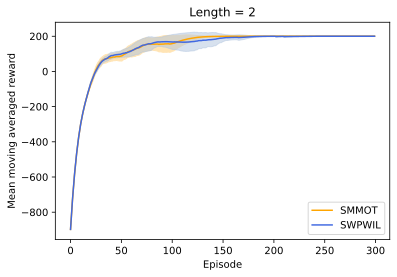

In [14]:
plt.plot([r.ep for r in pwtraining_record_multi_l_1_seed2], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in pwtraining_record_multi_l_1_seed2],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in pwtraining_record_multi_l_1_seed2], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in pwtraining_record_multi_l_1_seed2],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)

plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['SMMOT', 'SWPWIL'])
plt.title('Length = 2')
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_unique_len_1_%s.png"%environment)
plt.show()


#### Length = 0.5

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 81
    training_record_multi_l_0_5_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -897.0 score of current env 30.0
Ep 1 Average score: -805.7 score of current env 16.0
Ep 2 Average score: -723.4300000000001 score of current env 17.0
Ep 3 Average score: -649.9870000000001 score of current env 11.0
Ep 4 Average score: -581.2883 score of current env 37.0
Ep 5 Average score: -518.65947 score of current env 45.0
Ep 6 Average score: -464.693523 score of current env 21.0
Ep 7 Average score: -416.22417070000006 score of current env 20.0
Ep 8 Average score: -372.9017536300001 score of current env 17.0
Ep 9 Average score: -333.7115782670001 score of current env 19.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -296.4404204403001 score of current env 39.0
Ep 11 Average score: -265.69637839627006 score of current env 11.0
Ep 12 Average score: -237.02674055664306 score of current env 21.0
Ep 13 Average score: -212.02406650097876 score of current env 13.0
Ep 14 Average score: -185.1216598508809 score of current env 57.0
Ep 15 Average score: -161.8094938657928 score of current env 48.0
Ep 16 Average score: -141.42854447921354 score of current env 42.0
Ep 17 Average score: -121.6856900312922 score of current env 56.0
Ep 18 Average score: -105.21712102816298 score of current env 43.0
Ep 19 Average score: -87.79540892534668 score of current env 69.0
Ep 20 Average score: -62.815868032812006 score of current env 162.0
Ep 21 Average score: -50.534281229530805 score of current env 60.0
Ep 22 Average score: -40.78085310657772 score of current env 47.0
Ep 23 Average score: -28.302767795919955 score of current env 84.0
Ep 24 Average score: -17.87249101632796 score of current env 76.0
E

Ep 134 Average score: 199.0607443889592 score of current env 200.0
Ep 135 Average score: 199.15466995006327 score of current env 200.0
Ep 136 Average score: 199.23920295505695 score of current env 200.0
Ep 137 Average score: 199.31528265955126 score of current env 200.0
Ep 138 Average score: 199.38375439359615 score of current env 200.0
Ep 139 Average score: 199.44537895423653 score of current env 200.0
Ep 140 Average score: 199.50084105881288 score of current env 200.0
Ep 141 Average score: 199.5507569529316 score of current env 200.0
Ep 142 Average score: 199.59568125763846 score of current env 200.0
Ep 143 Average score: 199.63611313187462 score of current env 200.0
Ep 144 Average score: 199.67250181868715 score of current env 200.0
Ep 145 Average score: 199.70525163681845 score of current env 200.0
Ep 146 Average score: 199.73472647313662 score of current env 200.0
Ep 147 Average score: 199.76125382582296 score of current env 200.0
Ep 148 Average score: 199.78512844324067 score of 

Ep 256 Average score: 199.9999975431992 score of current env 200.0
Ep 257 Average score: 199.99999778887928 score of current env 200.0
Ep 258 Average score: 199.99999800999137 score of current env 200.0
Ep 259 Average score: 199.99999820899225 score of current env 200.0
Ep 260 Average score: 199.99999838809302 score of current env 200.0
Ep 261 Average score: 199.99999854928373 score of current env 200.0
Ep 262 Average score: 199.99999869435536 score of current env 200.0
Ep 263 Average score: 199.99999882491983 score of current env 200.0
Ep 264 Average score: 199.99999894242785 score of current env 200.0
Ep 265 Average score: 199.99999904818506 score of current env 200.0
Ep 266 Average score: 199.99999914336655 score of current env 200.0
Ep 267 Average score: 199.9999992290299 score of current env 200.0
Ep 268 Average score: 199.9999993061269 score of current env 200.0
Ep 269 Average score: 199.99999937551422 score of current env 200.0
Ep 270 Average score: 199.9999994379628 score of cu

In [7]:
pickle.dump(training_record_multi_l_0_5_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed1_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 82
    training_record_multi_l_0_5_seed2 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -807.4499999999999 score of current env 12.0
Ep 2 Average score: -724.905 score of current env 18.0
Ep 3 Average score: -651.3145 score of current env 11.0
Ep 4 Average score: -584.9830499999999 score of current env 12.0
Ep 5 Average score: -523.384745 score of current env 31.0
Ep 6 Average score: -470.1462705 score of current env 9.0
Ep 7 Average score: -421.43164345 score of current env 17.0
Ep 8 Average score: -376.988479105 score of current env 23.0
Ep 9 Average score: -338.08963119450004 score of current env 12.0
Ep 10 Average score: -302.98066807505006 score of current env 13.0
Ep 11 Average score: -271.88260126754506 score of current env 8.0
Ep 12 Average score: -243.69434114079056 score of current env 10.0
Ep 13 Average score: -218.32490702671151 score of current env 10.0
Ep 14 Average score: -195.39241632404037 score of current env 11.0
Ep 15 Average score: -174.15317469163634 score of current env 17.0
Ep

Ep 126 Average score: 136.4427340902236 score of current env 171.0
Ep 127 Average score: 142.09846068120126 score of current env 193.0
Ep 128 Average score: 143.88861461308113 score of current env 160.0
Ep 129 Average score: 147.49975315177304 score of current env 180.0
Ep 130 Average score: 152.74977783659574 score of current env 200.0
Ep 131 Average score: 156.07480005293615 score of current env 186.0
Ep 132 Average score: 159.86732004764255 score of current env 194.0
Ep 133 Average score: 163.8805880428783 score of current env 200.0
Ep 134 Average score: 167.49252923859046 score of current env 200.0
Ep 135 Average score: 170.74327631473142 score of current env 200.0
Ep 136 Average score: 173.6689486832583 score of current env 200.0
Ep 137 Average score: 176.30205381493246 score of current env 200.0
Ep 138 Average score: 178.6718484334392 score of current env 200.0
Ep 139 Average score: 180.8046635900953 score of current env 200.0
Ep 140 Average score: 182.72419723108575 score of cur

Ep 247 Average score: 199.81562887453535 score of current env 200.0
Ep 248 Average score: 199.83406598708183 score of current env 200.0
Ep 249 Average score: 199.85065938837366 score of current env 200.0
Ep 250 Average score: 199.8655934495363 score of current env 200.0
Ep 251 Average score: 199.87903410458267 score of current env 200.0
Ep 252 Average score: 199.8911306941244 score of current env 200.0
Ep 253 Average score: 199.90201762471196 score of current env 200.0
Ep 254 Average score: 199.91181586224076 score of current env 200.0
Ep 255 Average score: 199.9206342760167 score of current env 200.0
Ep 256 Average score: 199.92857084841503 score of current env 200.0
Ep 257 Average score: 199.93571376357355 score of current env 200.0
Ep 258 Average score: 199.9421423872162 score of current env 200.0
Ep 259 Average score: 199.94792814849458 score of current env 200.0
Ep 260 Average score: 199.95313533364512 score of current env 200.0
Ep 261 Average score: 199.9578218002806 score of cur

In [9]:
pickle.dump(training_record_multi_l_0_5_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed2_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 83
    training_record_multi_l_0_5_seed3= main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -894.3 score of current env 57.0
Ep 1 Average score: -801.17 score of current env 37.0
Ep 2 Average score: -716.853 score of current env 42.0
Ep 3 Average score: -642.3677 score of current env 28.0
Ep 4 Average score: -573.03093 score of current env 51.0
Ep 5 Average score: -513.127837 score of current env 26.0
Ep 6 Average score: -460.6150533 score of current env 12.0
Ep 7 Average score: -412.65354797000003 score of current env 19.0
Ep 8 Average score: -369.38819317300005 score of current env 20.0
Ep 9 Average score: -330.84937385570004 score of current env 16.0
Ep 10 Average score: -296.66443647013 score of current env 11.0
Ep 11 Average score: -264.697992823117 score of current env 23.0
Ep 12 Average score: -237.12819354080528 score of current env 11.0
Ep 13 Average score: -212.11537418672475 score of current env 13.0
Ep 14 Average score: -187.8038367680523 score of current env 31.0
Ep 15 Average score: -166.92345309124707 score of current env 21.0
Ep 16 Average 

Ep 125 Average score: 198.18591080260686 score of current env 200.0
Ep 126 Average score: 198.36731972234617 score of current env 200.0
Ep 127 Average score: 198.53058775011155 score of current env 200.0
Ep 128 Average score: 198.6775289751004 score of current env 200.0
Ep 129 Average score: 198.80977607759036 score of current env 200.0
Ep 130 Average score: 198.92879846983132 score of current env 200.0
Ep 131 Average score: 199.0359186228482 score of current env 200.0
Ep 132 Average score: 199.13232676056336 score of current env 200.0
Ep 133 Average score: 199.21909408450702 score of current env 200.0
Ep 134 Average score: 199.29718467605633 score of current env 200.0
Ep 135 Average score: 199.3674662084507 score of current env 200.0
Ep 136 Average score: 199.43071958760564 score of current env 200.0
Ep 137 Average score: 199.48764762884508 score of current env 200.0
Ep 138 Average score: 199.53888286596057 score of current env 200.0
Ep 139 Average score: 199.58499457936452 score of c

Ep 246 Average score: 199.99999472767374 score of current env 200.0
Ep 247 Average score: 199.99999525490637 score of current env 200.0
Ep 248 Average score: 199.99999572941573 score of current env 200.0
Ep 249 Average score: 199.99999615647417 score of current env 200.0
Ep 250 Average score: 199.99999654082674 score of current env 200.0
Ep 251 Average score: 199.99999688674407 score of current env 200.0
Ep 252 Average score: 199.99999719806968 score of current env 200.0
Ep 253 Average score: 199.9999974782627 score of current env 200.0
Ep 254 Average score: 199.99999773043643 score of current env 200.0
Ep 255 Average score: 199.9999979573928 score of current env 200.0
Ep 256 Average score: 199.9999981616535 score of current env 200.0
Ep 257 Average score: 199.99999834548817 score of current env 200.0
Ep 258 Average score: 199.99999851093935 score of current env 200.0
Ep 259 Average score: 199.99999865984543 score of current env 200.0
Ep 260 Average score: 199.9999987938609 score of cu

In [11]:
pickle.dump(training_record_multi_l_0_5_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed3_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 84
    training_record_multi_l_0_5_seed4 = main(environment, exp, seeds,simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -807.1 score of current env 11.0
Ep 2 Average score: -725.09 score of current env 13.0
Ep 3 Average score: -650.981 score of current env 16.0
Ep 4 Average score: -580.3829000000001 score of current env 55.0
Ep 5 Average score: -519.9446100000001 score of current env 24.0
Ep 6 Average score: -465.6501490000001 score of current env 23.0
Ep 7 Average score: -417.4851341000001 score of current env 16.0
Ep 8 Average score: -374.1366206900001 score of current env 16.0
Ep 9 Average score: -335.3229586210001 score of current env 14.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -299.5906627589001 score of current env 22.0
Ep 11 Average score: -268.8315964830101 score of current env 8.0
Ep 12 Average score: -241.0484368347091 score of current env 9.0
Ep 13 Average score: -215.9435931512382 score of current env 10.0
Ep 14 Average score: -192.34923383611437 score of current env 20.0
Ep 15 Average score: -170.41431045250295 score of current env 27.0
Ep 16 Average score: -149.67287940725268 score of current env 37.0
Ep 17 Average score: -130.10559146652741 score of current env 46.0
Ep 18 Average score: -114.19503231987467 score of current env 29.0
Ep 19 Average score: -97.8755290878872 score of current env 49.0
Ep 20 Average score: -76.38797617909849 score of current env 117.0
Ep 21 Average score: -48.74917856118864 score of current env 200.0
Ep 22 Average score: -31.674260705069777 score of current env 122.0
Ep 23 Average score: -13.406834634562799 score of current env 151.0
Ep 24 Average score: 7.933848828893481 score of current env 200.0
Ep

Ep 134 Average score: 187.91876537869516 score of current env 200.0
Ep 135 Average score: 189.12688884082564 score of current env 200.0
Ep 136 Average score: 190.21419995674307 score of current env 200.0
Ep 137 Average score: 191.19277996106877 score of current env 200.0
Ep 138 Average score: 192.0735019649619 score of current env 200.0
Ep 139 Average score: 192.86615176846573 score of current env 200.0
Ep 140 Average score: 193.57953659161916 score of current env 200.0
Ep 141 Average score: 194.22158293245724 score of current env 200.0
Ep 142 Average score: 194.7994246392115 score of current env 200.0
Ep 143 Average score: 195.31948217529037 score of current env 200.0
Ep 144 Average score: 195.78753395776135 score of current env 200.0
Ep 145 Average score: 196.20878056198524 score of current env 200.0
Ep 146 Average score: 196.58790250578673 score of current env 200.0
Ep 147 Average score: 196.92911225520805 score of current env 200.0
Ep 148 Average score: 197.23620102968727 score of 

Ep 255 Average score: 199.99996488804916 score of current env 200.0
Ep 256 Average score: 199.99996839924424 score of current env 200.0
Ep 257 Average score: 199.99997155931982 score of current env 200.0
Ep 258 Average score: 199.99997440338785 score of current env 200.0
Ep 259 Average score: 199.99997696304908 score of current env 200.0
Ep 260 Average score: 199.99997926674416 score of current env 200.0
Ep 261 Average score: 199.99998134006975 score of current env 200.0
Ep 262 Average score: 199.99998320606278 score of current env 200.0
Ep 263 Average score: 199.9999848854565 score of current env 200.0
Ep 264 Average score: 199.99998639691086 score of current env 200.0
Ep 265 Average score: 199.99998775721977 score of current env 200.0
Ep 266 Average score: 199.9999889814978 score of current env 200.0
Ep 267 Average score: 199.99999008334802 score of current env 200.0
Ep 268 Average score: 199.9999910750132 score of current env 200.0
Ep 269 Average score: 199.9999919675119 score of cu

In [7]:
pickle.dump(training_record_multi_l_0_5_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed4_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 85
    training_record_multi_l_0_5_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -807.44 score of current env 13.0
Ep 2 Average score: -723.096 score of current env 36.0
Ep 3 Average score: -649.4864000000001 score of current env 13.0
Ep 4 Average score: -583.4377600000001 score of current env 11.0
Ep 5 Average score: -523.9939840000001 score of current env 11.0
Ep 6 Average score: -464.99458560000005 score of current env 66.0
Ep 7 Average score: -417.19512704000005 score of current env 13.0
Ep 8 Average score: -373.77561433600005 score of current env 17.0
Ep 9 Average score: -335.2980529024 score of current env 11.0
Ep 10 Average score: -298.86824761216 score of current env 29.0
Ep 11 Average score: -267.981422850944 score of current env 10.0
Ep 12 Average score: -240.3832805658496 score of current env 8.0
Ep 13 Average score: -215.34495250926463 score of current env 10.0
Ep 14 Average score: -191.01045725833816 score of current env 28.0
Ep 15 Average score: -170.10941153250434 score of curre

Ep 124 Average score: 199.94374022041214 score of current env 200.0
Ep 125 Average score: 199.94936619837094 score of current env 200.0
Ep 126 Average score: 199.95442957853385 score of current env 200.0
Ep 127 Average score: 199.95898662068046 score of current env 200.0
Ep 128 Average score: 199.96308795861242 score of current env 200.0
Ep 129 Average score: 199.96677916275118 score of current env 200.0
Ep 130 Average score: 199.97010124647608 score of current env 200.0
Ep 131 Average score: 199.97309112182847 score of current env 200.0
Ep 132 Average score: 199.97578200964563 score of current env 200.0
Ep 133 Average score: 199.97820380868106 score of current env 200.0
Ep 134 Average score: 199.98038342781297 score of current env 200.0
Ep 135 Average score: 199.98234508503168 score of current env 200.0
Ep 136 Average score: 199.9841105765285 score of current env 200.0
Ep 137 Average score: 199.98569951887566 score of current env 200.0
Ep 138 Average score: 199.9871295669881 score of 

Ep 246 Average score: 199.9999998528419 score of current env 200.0
Ep 247 Average score: 199.99999986755773 score of current env 200.0
Ep 248 Average score: 199.99999988080197 score of current env 200.0
Ep 249 Average score: 199.99999989272177 score of current env 200.0
Ep 250 Average score: 199.9999999034496 score of current env 200.0
Ep 251 Average score: 199.99999991310466 score of current env 200.0
Ep 252 Average score: 199.9999999217942 score of current env 200.0
Ep 253 Average score: 199.99999992961477 score of current env 200.0
Ep 254 Average score: 199.9999999366533 score of current env 200.0
Ep 255 Average score: 199.99999994298798 score of current env 200.0
Ep 256 Average score: 199.99999994868918 score of current env 200.0
Ep 257 Average score: 199.99999995382026 score of current env 200.0
Ep 258 Average score: 199.99999995843825 score of current env 200.0
Ep 259 Average score: 199.99999996259444 score of current env 200.0
Ep 260 Average score: 199.999999966335 score of curr

In [9]:
pickle.dump(training_record_multi_l_0_5_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed5_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 86
    training_record_multi_l_0_5_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.8800000000001 score of current env 15.0
Ep 2 Average score: -723.6920000000001 score of current env 25.0
Ep 3 Average score: -649.8228000000001 score of current env 15.0
Ep 4 Average score: -582.5405200000002 score of current env 23.0
Ep 5 Average score: -519.1864680000002 score of current env 51.0
Ep 6 Average score: -464.4678212000002 score of current env 28.0
Ep 7 Average score: -415.82103908000016 score of current env 22.0
Ep 8 Average score: -371.83893517200016 score of current env 24.0
Ep 9 Average score: -332.95504165480014 score of current env 17.0
Ep 10 Average score: -298.0595374893201 score of current env 16.0
Ep 11 Average score: -267.1535837403881 score of current env 11.0
Ep 12 Average score: -239.5382253663493 score of current env 9.0
Ep 13 Average score: -213.58440282971438 score of current env 20.0
Ep 14 Average score: -191.02596254674296 score of current env 12.0
Ep 15 Average score: -169.92

Ep 125 Average score: 194.42913897723957 score of current env 200.0
Ep 126 Average score: 194.98622507951563 score of current env 200.0
Ep 127 Average score: 195.48760257156408 score of current env 200.0
Ep 128 Average score: 195.93884231440768 score of current env 200.0
Ep 129 Average score: 196.3449580829669 score of current env 200.0
Ep 130 Average score: 196.71046227467022 score of current env 200.0
Ep 131 Average score: 197.0394160472032 score of current env 200.0
Ep 132 Average score: 197.33547444248288 score of current env 200.0
Ep 133 Average score: 197.6019269982346 score of current env 200.0
Ep 134 Average score: 197.84173429841115 score of current env 200.0
Ep 135 Average score: 198.05756086857005 score of current env 200.0
Ep 136 Average score: 198.25180478171305 score of current env 200.0
Ep 137 Average score: 198.42662430354176 score of current env 200.0
Ep 138 Average score: 198.58396187318758 score of current env 200.0
Ep 139 Average score: 198.72556568586882 score of c

Ep 247 Average score: 199.9999854283586 score of current env 200.0
Ep 248 Average score: 199.99998688552273 score of current env 200.0
Ep 249 Average score: 199.99998819697046 score of current env 200.0
Ep 250 Average score: 199.9999893772734 score of current env 200.0
Ep 251 Average score: 199.99999043954608 score of current env 200.0
Ep 252 Average score: 199.99999139559148 score of current env 200.0
Ep 253 Average score: 199.99999225603233 score of current env 200.0
Ep 254 Average score: 199.9999930304291 score of current env 200.0
Ep 255 Average score: 199.9999937273862 score of current env 200.0
Ep 256 Average score: 199.99999435464758 score of current env 200.0
Ep 257 Average score: 199.99999491918283 score of current env 200.0
Ep 258 Average score: 199.99999542726454 score of current env 200.0
Ep 259 Average score: 199.9999958845381 score of current env 200.0
Ep 260 Average score: 199.99999629608428 score of current env 200.0
Ep 261 Average score: 199.99999666647585 score of cur

In [11]:
pickle.dump(training_record_multi_l_0_5_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed6_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 87
    training_record_multi_l_0_5_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -805.77 score of current env 27.0
Ep 2 Average score: -723.093 score of current env 21.0
Ep 3 Average score: -649.2837 score of current env 15.0
Ep 4 Average score: -581.25533 score of current env 31.0
Ep 5 Average score: -522.0297969999999 score of current env 11.0
Ep 6 Average score: -468.32681729999996 score of current env 15.0
Ep 7 Average score: -419.59413557 score of current env 19.0
Ep 8 Average score: -370.134722013 score of current env 75.0
Ep 9 Average score: -330.4212498117 score of current env 27.0
Ep 10 Average score: -295.87912483053003 score of current env 15.0
Ep 11 Average score: -265.39121234747705 score of current env 9.0
Ep 12 Average score: -237.95209111272933 score of current env 9.0
Ep 13 Average score: -213.2568820014564 score of current env 9.0
Ep 14 Average score: -191.13119380131076 score of current env 8.0
Ep 15 Average score: -170.61807442117967 score of current env 14.0
Ep 16 Average 

Ep 125 Average score: 199.9388304705133 score of current env 200.0
Ep 126 Average score: 199.94494742346197 score of current env 200.0
Ep 127 Average score: 199.95045268111576 score of current env 200.0
Ep 128 Average score: 199.9554074130042 score of current env 200.0
Ep 129 Average score: 199.9598666717038 score of current env 200.0
Ep 130 Average score: 199.96388000453342 score of current env 200.0
Ep 131 Average score: 199.96749200408007 score of current env 200.0
Ep 132 Average score: 199.97074280367207 score of current env 200.0
Ep 133 Average score: 199.97366852330487 score of current env 200.0
Ep 134 Average score: 199.97630167097438 score of current env 200.0
Ep 135 Average score: 199.97867150387694 score of current env 200.0
Ep 136 Average score: 199.98080435348925 score of current env 200.0
Ep 137 Average score: 199.98272391814032 score of current env 200.0
Ep 138 Average score: 199.9844515263263 score of current env 200.0
Ep 139 Average score: 199.98600637369367 score of cu

Ep 247 Average score: 199.99999983999956 score of current env 200.0
Ep 248 Average score: 199.99999985599962 score of current env 200.0
Ep 249 Average score: 199.99999987039965 score of current env 200.0
Ep 250 Average score: 199.9999998833597 score of current env 200.0
Ep 251 Average score: 199.99999989502373 score of current env 200.0
Ep 252 Average score: 199.99999990552138 score of current env 200.0
Ep 253 Average score: 199.99999991496924 score of current env 200.0
Ep 254 Average score: 199.99999992347233 score of current env 200.0
Ep 255 Average score: 199.9999999311251 score of current env 200.0
Ep 256 Average score: 199.9999999380126 score of current env 200.0
Ep 257 Average score: 199.99999994421134 score of current env 200.0
Ep 258 Average score: 199.9999999497902 score of current env 200.0
Ep 259 Average score: 199.9999999548112 score of current env 200.0
Ep 260 Average score: 199.99999995933007 score of current env 200.0
Ep 261 Average score: 199.99999996339707 score of cur

In [13]:
pickle.dump(training_record_multi_l_0_5_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed7_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 88
    training_record_multi_l_0_5_seed8 = main(environment, exp, seeds,simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -804.33 score of current env 45.0
Ep 2 Average score: -722.397 score of current env 15.0
Ep 3 Average score: -645.6573000000001 score of current env 45.0
Ep 4 Average score: -579.39157 score of current env 17.0
Ep 5 Average score: -520.352413 score of current env 11.0
Ep 6 Average score: -465.71717169999994 score of current env 26.0
Ep 7 Average score: -418.24545452999996 score of current env 9.0
Ep 8 Average score: -368.32090907699995 score of current env 81.0
Ep 9 Average score: -328.2888181693 score of current env 32.0
Ep 10 Average score: -293.15993635237 score of current env 23.0
Ep 11 Average score: -262.843942717133 score of current env 10.0
Ep 12 Average score: -229.35954844541973 score of current env 72.0
Ep 13 Average score: -203.92359360087775 score of current env 25.0
Ep 14 Average score: -176.63123424078998 score of current env 69.0
Ep 15 Average score: -155.86811081671098 score of current env 31.0
Ep

Ep 125 Average score: 147.4882988192025 score of current env 200.0
Ep 126 Average score: 152.73946893728225 score of current env 200.0
Ep 127 Average score: 157.46552204355405 score of current env 200.0
Ep 128 Average score: 161.71896983919865 score of current env 200.0
Ep 129 Average score: 165.5470728552788 score of current env 200.0
Ep 130 Average score: 168.99236556975092 score of current env 200.0
Ep 131 Average score: 172.09312901277582 score of current env 200.0
Ep 132 Average score: 174.88381611149825 score of current env 200.0
Ep 133 Average score: 177.39543450034841 score of current env 200.0
Ep 134 Average score: 179.65589105031358 score of current env 200.0
Ep 135 Average score: 181.69030194528224 score of current env 200.0
Ep 136 Average score: 183.521271750754 score of current env 200.0
Ep 137 Average score: 185.16914457567862 score of current env 200.0
Ep 138 Average score: 186.65223011811077 score of current env 200.0
Ep 139 Average score: 187.9870071062997 score of cur

Ep 247 Average score: 199.99986264570646 score of current env 200.0
Ep 248 Average score: 199.9998763811358 score of current env 200.0
Ep 249 Average score: 199.99988874302224 score of current env 200.0
Ep 250 Average score: 199.99989986872 score of current env 200.0
Ep 251 Average score: 199.999909881848 score of current env 200.0
Ep 252 Average score: 199.9999188936632 score of current env 200.0
Ep 253 Average score: 199.99992700429686 score of current env 200.0
Ep 254 Average score: 199.99993430386718 score of current env 200.0
Ep 255 Average score: 199.99994087348045 score of current env 200.0
Ep 256 Average score: 199.99994678613243 score of current env 200.0
Ep 257 Average score: 199.9999521075192 score of current env 200.0
Ep 258 Average score: 199.9999568967673 score of current env 200.0
Ep 259 Average score: 199.99996120709056 score of current env 200.0
Ep 260 Average score: 199.9999650863815 score of current env 200.0
Ep 261 Average score: 199.99996857774337 score of current 

In [15]:
pickle.dump(training_record_multi_l_0_5_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed8_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 89
    training_record_multi_l_0_5_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.56 score of current env 20.0
Ep 2 Average score: -724.204 score of current env 17.0
Ep 3 Average score: -650.4836 score of current env 13.0
Ep 4 Average score: -581.93524 score of current env 35.0
Ep 5 Average score: -521.341716 score of current env 24.0
Ep 6 Average score: -466.6075444 score of current env 26.0
Ep 7 Average score: -415.14678996 score of current env 48.0
Ep 8 Average score: -372.732110964 score of current env 9.0
Ep 9 Average score: -334.5588998676 score of current env 9.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -297.20300988084006 score of current env 39.0
Ep 11 Average score: -266.68270889275607 score of current env 8.0
Ep 12 Average score: -238.8144380034805 score of current env 12.0
Ep 13 Average score: -210.13299420313243 score of current env 48.0
Ep 14 Average score: -185.61969478281918 score of current env 35.0
Ep 15 Average score: -165.25772530453725 score of current env 18.0
Ep 16 Average score: -147.33195277408353 score of current env 14.0
Ep 17 Average score: -129.79875749667517 score of current env 28.0
Ep 18 Average score: -111.61888174700765 score of current env 52.0
Ep 19 Average score: -97.25699357230688 score of current env 32.0
Ep 20 Average score: -78.1312942150762 score of current env 94.0
Ep 21 Average score: -54.51816479356859 score of current env 158.0
Ep 22 Average score: -36.56634831421173 score of current env 125.0
Ep 23 Average score: -19.50971348279056 score of current env 134.0
Ep 24 Average score: -4.158742134511504 score of current env 134.0


Ep 133 Average score: 199.8035162158688 score of current env 200.0
Ep 134 Average score: 199.82316459428193 score of current env 200.0
Ep 135 Average score: 199.84084813485376 score of current env 200.0
Ep 136 Average score: 199.8567633213684 score of current env 200.0
Ep 137 Average score: 199.87108698923154 score of current env 200.0
Ep 138 Average score: 199.8839782903084 score of current env 200.0
Ep 139 Average score: 199.89558046127755 score of current env 200.0
Ep 140 Average score: 199.9060224151498 score of current env 200.0
Ep 141 Average score: 199.91542017363483 score of current env 200.0
Ep 142 Average score: 199.92387815627134 score of current env 200.0
Ep 143 Average score: 199.93149034064422 score of current env 200.0
Ep 144 Average score: 199.9383413065798 score of current env 200.0
Ep 145 Average score: 199.9445071759218 score of current env 200.0
Ep 146 Average score: 199.95005645832964 score of current env 200.0
Ep 147 Average score: 199.9550508124967 score of curre

Ep 254 Average score: 199.999999428955 score of current env 200.0
Ep 255 Average score: 199.9999994860595 score of current env 200.0
Ep 256 Average score: 199.99999953745356 score of current env 200.0
Ep 257 Average score: 199.99999958370822 score of current env 200.0
Ep 258 Average score: 199.9999996253374 score of current env 200.0
Ep 259 Average score: 199.99999966280367 score of current env 200.0
Ep 260 Average score: 199.9999996965233 score of current env 200.0
Ep 261 Average score: 199.99999972687098 score of current env 200.0
Ep 262 Average score: 199.99999975418388 score of current env 200.0
Ep 263 Average score: 199.9999997787655 score of current env 200.0
Ep 264 Average score: 199.99999980088896 score of current env 200.0
Ep 265 Average score: 199.99999982080007 score of current env 200.0
Ep 266 Average score: 199.99999983872007 score of current env 200.0
Ep 267 Average score: 199.99999985484806 score of current env 200.0
Ep 268 Average score: 199.99999986936325 score of curr

In [7]:
pickle.dump(training_record_multi_l_0_5_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed9_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 90
    training_record_multi_l_0_5_seed10 = main(environment, exp, seeds,simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -806.27 score of current env 22.0
Ep 2 Average score: -724.043 score of current env 16.0
Ep 3 Average score: -646.3387 score of current env 53.0
Ep 4 Average score: -580.30483 score of current env 14.0
Ep 5 Average score: -520.4743470000001 score of current env 18.0
Ep 6 Average score: -466.1269123000001 score of current env 23.0
Ep 7 Average score: -418.0142210700001 score of current env 15.0
Ep 8 Average score: -371.3127989630001 score of current env 49.0
Ep 9 Average score: -333.0815190667001 score of current env 11.0
Ep 10 Average score: -298.5733671600301 score of current env 12.0
Ep 11 Average score: -265.7160304440271 score of current env 30.0
Ep 12 Average score: -236.7444273996244 score of current env 24.0
Ep 13 Average score: -212.06998465966197 score of current env 10.0
Ep 14 Average score: -189.1629861936958 score of current env 17.0
Ep 15 Average score: -167.8466875743262 score of current env 24.0
Ep 

Ep 125 Average score: 143.64643557514864 score of current env 200.0
Ep 126 Average score: 149.2817920176338 score of current env 200.0
Ep 127 Average score: 154.3536128158704 score of current env 200.0
Ep 128 Average score: 158.91825153428337 score of current env 200.0
Ep 129 Average score: 163.02642638085504 score of current env 200.0
Ep 130 Average score: 166.72378374276954 score of current env 200.0
Ep 131 Average score: 170.0514053684926 score of current env 200.0
Ep 132 Average score: 173.04626483164333 score of current env 200.0
Ep 133 Average score: 175.741638348479 score of current env 200.0
Ep 134 Average score: 178.1674745136311 score of current env 200.0
Ep 135 Average score: 173.150727062268 score of current env 128.0
Ep 136 Average score: 175.8356543560412 score of current env 200.0
Ep 137 Average score: 176.65208892043708 score of current env 184.0
Ep 138 Average score: 174.08688002839338 score of current env 151.0
Ep 139 Average score: 176.67819202555404 score of current

Ep 247 Average score: 199.99509935895924 score of current env 200.0
Ep 248 Average score: 199.9955894230633 score of current env 200.0
Ep 249 Average score: 199.99603048075699 score of current env 200.0
Ep 250 Average score: 199.9964274326813 score of current env 200.0
Ep 251 Average score: 199.99678468941318 score of current env 200.0
Ep 252 Average score: 199.99710622047186 score of current env 200.0
Ep 253 Average score: 199.99739559842467 score of current env 200.0
Ep 254 Average score: 199.99765603858222 score of current env 200.0
Ep 255 Average score: 199.997890434724 score of current env 200.0
Ep 256 Average score: 199.99810139125162 score of current env 200.0
Ep 257 Average score: 199.99829125212648 score of current env 200.0
Ep 258 Average score: 199.99846212691384 score of current env 200.0
Ep 259 Average score: 199.99861591422246 score of current env 200.0
Ep 260 Average score: 199.9987543228002 score of current env 200.0
Ep 261 Average score: 199.9988788905202 score of curr

In [9]:
pickle.dump(training_record_multi_l_0_5_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed10_%s.pkl'%environment, 'wb' ))

In [10]:
mmottraining_record_multi_l_0_5_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed1_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed2_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed3_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed4_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed5_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed6_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed7_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed8_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed9_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_0_5_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_0_5_seed10_%s.pkl'%environment,'rb' ))




l1_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed1]
l2_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed2]
l3_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed3]
l4_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed4]
l5_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed5]
l6_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed6]
l7_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed7]
l8_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed8]
l9_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed9]
l10_simple = [r.reward for r in mmottraining_record_multi_l_0_5_seed10]

In [11]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 811
    training_record_multi_l_0_5_seed1 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -801.6 score of current env 66.0
Ep 2 Average score: -718.94 score of current env 25.0
Ep 3 Average score: -645.446 score of current env 16.0
Ep 4 Average score: -579.5014000000001 score of current env 14.0
Ep 5 Average score: -519.85126 score of current env 17.0
Ep 6 Average score: -466.16613400000006 score of current env 17.0
Ep 7 Average score: -417.74952060000004 score of current env 18.0
Ep 8 Average score: -374.67456854000005 score of current env 13.0
Ep 9 Average score: -335.8071116860001 score of current env 14.0
Ep 10 Average score: -300.02640051740013 score of current env 22.0
Ep 11 Average score: -269.02376046566013 score of current env 10.0
Ep 12 Average score: -240.52138441909412 score of current env 16.0
Ep 13 Average score: -215.5692459771847 score of current env 9.0
Ep 14 Average score: -192.91232137946622 score of current env 11.0
Ep 15 Average score: -168.4210892415196 score of current env 52.0
E

Ep 124 Average score: 175.67410511060731 score of current env 200.0
Ep 125 Average score: 178.10669459954659 score of current env 200.0
Ep 126 Average score: 180.29602513959193 score of current env 200.0
Ep 127 Average score: 182.26642262563274 score of current env 200.0
Ep 128 Average score: 184.03978036306947 score of current env 200.0
Ep 129 Average score: 185.63580232676253 score of current env 200.0
Ep 130 Average score: 187.07222209408627 score of current env 200.0
Ep 131 Average score: 188.36499988467764 score of current env 200.0
Ep 132 Average score: 189.5284998962099 score of current env 200.0
Ep 133 Average score: 190.57564990658892 score of current env 200.0
Ep 134 Average score: 191.51808491593005 score of current env 200.0
Ep 135 Average score: 192.36627642433706 score of current env 200.0
Ep 136 Average score: 193.12964878190337 score of current env 200.0
Ep 137 Average score: 193.81668390371303 score of current env 200.0
Ep 138 Average score: 194.43501551334174 score of

Ep 245 Average score: 199.99992930113072 score of current env 200.0
Ep 246 Average score: 199.99993637101764 score of current env 200.0
Ep 247 Average score: 199.99994273391587 score of current env 200.0
Ep 248 Average score: 199.99994846052428 score of current env 200.0
Ep 249 Average score: 199.99995361447185 score of current env 200.0
Ep 250 Average score: 199.99995825302466 score of current env 200.0
Ep 251 Average score: 199.9999624277222 score of current env 200.0
Ep 252 Average score: 199.99996618494998 score of current env 200.0
Ep 253 Average score: 199.99996956645498 score of current env 200.0
Ep 254 Average score: 199.99997260980948 score of current env 200.0
Ep 255 Average score: 199.99997534882854 score of current env 200.0
Ep 256 Average score: 199.9999778139457 score of current env 200.0
Ep 257 Average score: 199.99998003255112 score of current env 200.0
Ep 258 Average score: 199.999982029296 score of current env 200.0
Ep 259 Average score: 199.99998382636642 score of cu

In [13]:
pickle.dump(training_record_multi_l_0_5_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed1_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 821
    training_record_multi_l_0_5_seed2 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.2 score of current env 28.0
Ep 1 Average score: -805.98 score of current env 15.0
Ep 2 Average score: -723.782 score of current env 16.0
Ep 3 Average score: -649.6038000000001 score of current env 18.0
Ep 4 Average score: -582.9434200000001 score of current env 17.0
Ep 5 Average score: -515.549078 score of current env 91.0
Ep 6 Average score: -462.99417020000004 score of current env 10.0
Ep 7 Average score: -414.59475318 score of current env 21.0
Ep 8 Average score: -371.335277862 score of current env 18.0
Ep 9 Average score: -332.7017500758 score of current env 15.0
Ep 10 Average score: -298.03157506822004 score of current env 14.0
Ep 11 Average score: -267.128417561398 score of current env 11.0
Ep 12 Average score: -238.91557580525821 score of current env 15.0
Ep 13 Average score: -213.1240182247324 score of current env 19.0
Ep 14 Average score: -188.91161640225914 score of current env 29.0
Ep 15 Average score: -164.42045476203324 score of current env 56.0
Ep

Ep 126 Average score: 95.81016506349616 score of current env 89.0
Ep 127 Average score: 93.82914855714654 score of current env 76.0
Ep 128 Average score: 103.5462337014319 score of current env 191.0
Ep 129 Average score: 103.99161033128871 score of current env 108.0
Ep 130 Average score: 104.59244929815985 score of current env 110.0
Ep 131 Average score: 105.13320436834387 score of current env 110.0
Ep 132 Average score: 107.31988393150948 score of current env 127.0
Ep 133 Average score: 110.08789553835854 score of current env 135.0
Ep 134 Average score: 109.07910598452268 score of current env 100.0
Ep 135 Average score: 109.27119538607042 score of current env 111.0
Ep 136 Average score: 108.74407584746338 score of current env 104.0
Ep 137 Average score: 108.86966826271704 score of current env 110.0
Ep 138 Average score: 108.78270143644534 score of current env 108.0
Ep 139 Average score: 109.0044312928008 score of current env 111.0
Ep 140 Average score: 109.70398816352073 score of curr

Ep 248 Average score: 190.29386412183482 score of current env 182.0
Ep 249 Average score: 189.46447770965133 score of current env 182.0
Ep 250 Average score: 190.0180299386862 score of current env 195.0
Ep 251 Average score: 191.0162269448176 score of current env 200.0
Ep 252 Average score: 191.91460425033583 score of current env 200.0
Ep 253 Average score: 192.32314382530225 score of current env 196.0
Ep 254 Average score: 193.09082944277202 score of current env 200.0
Ep 255 Average score: 193.48174649849483 score of current env 197.0
Ep 256 Average score: 194.13357184864535 score of current env 200.0
Ep 257 Average score: 194.7202146637808 score of current env 200.0
Ep 258 Average score: 195.24819319740274 score of current env 200.0
Ep 259 Average score: 194.6233738776625 score of current env 189.0
Ep 260 Average score: 195.16103648989625 score of current env 200.0
Ep 261 Average score: 195.64493284090662 score of current env 200.0
Ep 262 Average score: 196.08043955681597 score of cu

In [15]:
pickle.dump(training_record_multi_l_0_5_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed2_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 831
    training_record_multi_l_0_5_seed3= main(environment, exp, seeds, simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -899.0 score of current env 10.0
Ep 1 Average score: -806.4 score of current env 27.0
Ep 2 Average score: -724.36 score of current env 14.0
Ep 3 Average score: -649.924 score of current env 20.0
Ep 4 Average score: -581.4316 score of current env 35.0
Ep 5 Average score: -522.4884400000001 score of current env 8.0
Ep 6 Average score: -467.5395960000001 score of current env 27.0
Ep 7 Average score: -417.6856364000001 score of current env 31.0
Ep 8 Average score: -373.5170727600001 score of current env 24.0
Ep 9 Average score: -334.4653654840001 score of current env 17.0
Ep 10 Average score: -299.2188289356001 score of current env 18.0
Ep 11 Average score: -267.8969460420401 score of current env 14.0
Ep 12 Average score: -240.0072514378361 score of current env 11.0
Ep 13 Average score: -214.9065262940525 score of current env 11.0
Ep 14 Average score: -188.71587366464726 score of current env 47.0
Ep 15 Average score: -167.64428629818255 score of current env 22.0
Ep 16 A

Ep 125 Average score: 194.12797598735307 score of current env 200.0
Ep 126 Average score: 194.71517838861777 score of current env 200.0
Ep 127 Average score: 195.243660549756 score of current env 200.0
Ep 128 Average score: 195.7192944947804 score of current env 200.0
Ep 129 Average score: 196.14736504530237 score of current env 200.0
Ep 130 Average score: 196.53262854077212 score of current env 200.0
Ep 131 Average score: 196.8793656866949 score of current env 200.0
Ep 132 Average score: 197.1914291180254 score of current env 200.0
Ep 133 Average score: 197.47228620622286 score of current env 200.0
Ep 134 Average score: 197.72505758560058 score of current env 200.0
Ep 135 Average score: 197.95255182704054 score of current env 200.0
Ep 136 Average score: 198.1572966443365 score of current env 200.0
Ep 137 Average score: 198.34156697990286 score of current env 200.0
Ep 138 Average score: 198.50741028191257 score of current env 200.0
Ep 139 Average score: 198.6566692537213 score of curre

Ep 246 Average score: 199.99998293401092 score of current env 200.0
Ep 247 Average score: 199.99998464060982 score of current env 200.0
Ep 248 Average score: 199.99998617654884 score of current env 200.0
Ep 249 Average score: 199.99998755889396 score of current env 200.0
Ep 250 Average score: 199.99998880300458 score of current env 200.0
Ep 251 Average score: 199.99998992270412 score of current env 200.0
Ep 252 Average score: 199.9999909304337 score of current env 200.0
Ep 253 Average score: 199.99999183739035 score of current env 200.0
Ep 254 Average score: 199.99999265365133 score of current env 200.0
Ep 255 Average score: 199.9999933882862 score of current env 200.0
Ep 256 Average score: 199.9999940494576 score of current env 200.0
Ep 257 Average score: 199.99999464451184 score of current env 200.0
Ep 258 Average score: 199.99999518006067 score of current env 200.0
Ep 259 Average score: 199.9999956620546 score of current env 200.0
Ep 260 Average score: 199.99999609584916 score of cu

In [17]:
pickle.dump(training_record_multi_l_0_5_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed3_%s.pkl'%environment, 'wb' ))

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 841
    training_record_multi_l_0_5_seed4 = main(environment, exp, seeds,simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -899.0 score of current env 10.0
Ep 1 Average score: -804.6 score of current env 45.0
Ep 2 Average score: -723.14 score of current env 10.0
Ep 3 Average score: -648.926 score of current env 19.0
Ep 4 Average score: -582.4334 score of current env 16.0
Ep 5 Average score: -519.09006 score of current env 51.0
Ep 6 Average score: -465.48105400000003 score of current env 17.0
Ep 7 Average score: -414.8329486 score of current env 41.0
Ep 8 Average score: -371.84965374 score of current env 15.0
Ep 9 Average score: -332.26468836600003 score of current env 24.0
Ep 10 Average score: -297.63821952940003 score of current env 14.0
Ep 11 Average score: -266.67439757646 score of current env 12.0
Ep 12 Average score: -239.00695781881402 score of current env 10.0
Ep 13 Average score: -213.3062620369326 score of current env 18.0
Ep 14 Average score: -190.97563583323935 score of current env 10.0
Ep 15 Average score: -168.37807224991542 score of current env 35.0
Ep 16 Average score: -1

Ep 125 Average score: 134.30596636767774 score of current env 134.0
Ep 126 Average score: 140.67536973090998 score of current env 198.0
Ep 127 Average score: 143.30783275781897 score of current env 167.0
Ep 128 Average score: 148.97704948203707 score of current env 200.0
Ep 129 Average score: 154.07934453383336 score of current env 200.0
Ep 130 Average score: 157.77141008045004 score of current env 191.0
Ep 131 Average score: 161.99426907240505 score of current env 200.0
Ep 132 Average score: 165.79484216516454 score of current env 200.0
Ep 133 Average score: 169.2153579486481 score of current env 200.0
Ep 134 Average score: 172.29382215378328 score of current env 200.0
Ep 135 Average score: 175.06443993840494 score of current env 200.0
Ep 136 Average score: 177.55799594456445 score of current env 200.0
Ep 137 Average score: 179.802196350108 score of current env 200.0
Ep 138 Average score: 181.8219767150972 score of current env 200.0
Ep 139 Average score: 183.63977904358748 score of cu

Ep 247 Average score: 199.99882143657874 score of current env 200.0
Ep 248 Average score: 199.99893929292088 score of current env 200.0
Ep 249 Average score: 199.9990453636288 score of current env 200.0
Ep 250 Average score: 199.99914082726593 score of current env 200.0
Ep 251 Average score: 199.99922674453936 score of current env 200.0
Ep 252 Average score: 199.99930407008543 score of current env 200.0
Ep 253 Average score: 199.99937366307688 score of current env 200.0
Ep 254 Average score: 199.9994362967692 score of current env 200.0
Ep 255 Average score: 199.99949266709228 score of current env 200.0
Ep 256 Average score: 199.99954340038306 score of current env 200.0
Ep 257 Average score: 199.99958906034476 score of current env 200.0
Ep 258 Average score: 199.9996301543103 score of current env 200.0
Ep 259 Average score: 199.99966713887926 score of current env 200.0
Ep 260 Average score: 199.99970042499135 score of current env 200.0
Ep 261 Average score: 199.9997303824922 score of cu

In [19]:
pickle.dump(training_record_multi_l_0_5_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed4_%s.pkl'%environment, 'wb' ))

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 851
    training_record_multi_l_0_5_seed5 = main(environment, exp, seeds, simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -806.44 score of current env 23.0
Ep 2 Average score: -723.8960000000001 score of current env 19.0
Ep 3 Average score: -647.6064000000001 score of current env 39.0
Ep 4 Average score: -581.7457600000001 score of current env 11.0
Ep 5 Average score: -522.4711840000001 score of current env 11.0
Ep 6 Average score: -469.22406560000013 score of current env 10.0
Ep 7 Average score: -420.0016590400001 score of current env 23.0
Ep 8 Average score: -376.90149313600006 score of current env 11.0
Ep 9 Average score: -338.0113438224001 score of current env 12.0
Ep 10 Average score: -302.2102094401601 score of current env 20.0
Ep 11 Average score: -270.9891884961441 score of current env 10.0
Ep 12 Average score: -242.3902696465297 score of current env 15.0
Ep 13 Average score: -215.25124268187673 score of current env 29.0
Ep 14 Average score: -191.42611841368904 score of current env 23.0
Ep 15 Average score: -166.1835065723201

Ep 125 Average score: 77.81427373259964 score of current env 76.0
Ep 126 Average score: 78.93284635933969 score of current env 89.0
Ep 127 Average score: 76.33956172340572 score of current env 53.0
Ep 128 Average score: 74.40560555106515 score of current env 57.0
Ep 129 Average score: 74.26504499595863 score of current env 73.0
Ep 130 Average score: 76.53854049636277 score of current env 97.0
Ep 131 Average score: 77.2846864467265 score of current env 84.0
Ep 132 Average score: 78.45621780205386 score of current env 89.0
Ep 133 Average score: 80.61059602184848 score of current env 100.0
Ep 134 Average score: 84.54953641966364 score of current env 120.0
Ep 135 Average score: 88.79458277769729 score of current env 127.0
Ep 136 Average score: 99.51512449992757 score of current env 196.0
Ep 137 Average score: 109.56361204993482 score of current env 200.0
Ep 138 Average score: 118.60725084494133 score of current env 200.0
Ep 139 Average score: 126.7465257604472 score of current env 200.0
Ep

Ep 247 Average score: 199.99362147908946 score of current env 200.0
Ep 248 Average score: 199.9942593311805 score of current env 200.0
Ep 249 Average score: 199.99483339806247 score of current env 200.0
Ep 250 Average score: 199.99535005825624 score of current env 200.0
Ep 251 Average score: 199.99581505243063 score of current env 200.0
Ep 252 Average score: 199.99623354718756 score of current env 200.0
Ep 253 Average score: 199.9966101924688 score of current env 200.0
Ep 254 Average score: 199.99694917322194 score of current env 200.0
Ep 255 Average score: 199.99725425589975 score of current env 200.0
Ep 256 Average score: 199.9975288303098 score of current env 200.0
Ep 257 Average score: 199.99777594727883 score of current env 200.0
Ep 258 Average score: 199.99799835255095 score of current env 200.0
Ep 259 Average score: 199.99819851729586 score of current env 200.0
Ep 260 Average score: 199.9983786655663 score of current env 200.0
Ep 261 Average score: 199.99854079900967 score of cu

In [22]:
pickle.dump(training_record_multi_l_0_5_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed5_%s.pkl'%environment, 'wb' ))

In [23]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 861
    training_record_multi_l_0_5_seed6 = main(environment, exp, seeds, simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -805.61 score of current env 34.0
Ep 2 Average score: -723.149 score of current env 19.0
Ep 3 Average score: -649.4341000000001 score of current env 14.0
Ep 4 Average score: -583.1906900000001 score of current env 13.0
Ep 5 Average score: -520.4716210000001 score of current env 44.0
Ep 6 Average score: -467.0244589000002 score of current env 14.0
Ep 7 Average score: -417.82201301000015 score of current env 25.0
Ep 8 Average score: -374.3398117090002 score of current env 17.0
Ep 9 Average score: -334.4058305381002 score of current env 25.0
Ep 10 Average score: -298.86524748429014 score of current env 21.0
Ep 11 Average score: -267.77872273586115 score of current env 12.0
Ep 12 Average score: -240.10085046227505 score of current env 9.0
Ep 13 Average score: -214.99076541604757 score of current env 11.0
Ep 14 Average score: -192.1916888744428 score of current env 13.0
Ep 15 Average score: -171.27251998699853 score of

Ep 124 Average score: 199.34061539070237 score of current env 200.0
Ep 125 Average score: 199.40655385163214 score of current env 200.0
Ep 126 Average score: 199.46589846646893 score of current env 200.0
Ep 127 Average score: 199.51930861982203 score of current env 200.0
Ep 128 Average score: 199.56737775783984 score of current env 200.0
Ep 129 Average score: 199.61063998205586 score of current env 200.0
Ep 130 Average score: 199.64957598385027 score of current env 200.0
Ep 131 Average score: 199.68461838546526 score of current env 200.0
Ep 132 Average score: 199.71615654691874 score of current env 200.0
Ep 133 Average score: 199.74454089222687 score of current env 200.0
Ep 134 Average score: 199.77008680300418 score of current env 200.0
Ep 135 Average score: 199.79307812270378 score of current env 200.0
Ep 136 Average score: 199.8137703104334 score of current env 200.0
Ep 137 Average score: 199.83239327939006 score of current env 200.0
Ep 138 Average score: 199.84915395145106 score of

Ep 245 Average score: 199.99999808361642 score of current env 200.0
Ep 246 Average score: 199.99999827525477 score of current env 200.0
Ep 247 Average score: 199.9999984477293 score of current env 200.0
Ep 248 Average score: 199.99999860295637 score of current env 200.0
Ep 249 Average score: 199.99999874266072 score of current env 200.0
Ep 250 Average score: 199.99999886839464 score of current env 200.0
Ep 251 Average score: 199.9999989815552 score of current env 200.0
Ep 252 Average score: 199.99999908339967 score of current env 200.0
Ep 253 Average score: 199.9999991750597 score of current env 200.0
Ep 254 Average score: 199.99999925755375 score of current env 200.0
Ep 255 Average score: 199.9999993317984 score of current env 200.0
Ep 256 Average score: 199.99999939861857 score of current env 200.0
Ep 257 Average score: 199.99999945875672 score of current env 200.0
Ep 258 Average score: 199.99999951288106 score of current env 200.0
Ep 259 Average score: 199.99999956159297 score of cu

In [24]:
pickle.dump(training_record_multi_l_0_5_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed6_%s.pkl'%environment, 'wb' ))

In [25]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 871
    training_record_multi_l_0_5_seed7 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -807.31 score of current env 17.0
Ep 2 Average score: -725.079 score of current env 15.0
Ep 3 Average score: -651.3711 score of current env 12.0
Ep 4 Average score: -584.1339899999999 score of current env 21.0
Ep 5 Average score: -523.8205909999999 score of current env 19.0
Ep 6 Average score: -469.1385318999999 score of current env 23.0
Ep 7 Average score: -419.9246787099999 score of current env 23.0
Ep 8 Average score: -376.73221083899995 score of current env 12.0
Ep 9 Average score: -333.6589897551 score of current env 54.0
Ep 10 Average score: -297.89309077959 score of current env 24.0
Ep 11 Average score: -267.003781701631 score of current env 11.0
Ep 12 Average score: -238.1034035314679 score of current env 22.0
Ep 13 Average score: -208.69306317832113 score of current env 56.0
Ep 14 Average score: -185.02375686048902 score of current env 28.0
Ep 15 Average score: -160.82138117444012 score of current env 57.

Ep 126 Average score: 110.42167353760583 score of current env 129.0
Ep 127 Average score: 114.87950618384525 score of current env 155.0
Ep 128 Average score: 120.59155556546074 score of current env 172.0
Ep 129 Average score: 124.33240000891466 score of current env 158.0
Ep 130 Average score: 129.2991600080232 score of current env 174.0
Ep 131 Average score: 135.06924400722087 score of current env 187.0
Ep 132 Average score: 140.66231960649878 score of current env 191.0
Ep 133 Average score: 146.5960876458489 score of current env 200.0
Ep 134 Average score: 151.93647888126404 score of current env 200.0
Ep 135 Average score: 156.74283099313763 score of current env 200.0
Ep 136 Average score: 161.06854789382388 score of current env 200.0
Ep 137 Average score: 164.96169310444148 score of current env 200.0
Ep 138 Average score: 168.46552379399733 score of current env 200.0
Ep 139 Average score: 171.6189714145976 score of current env 200.0
Ep 140 Average score: 174.45707427313786 score of c

Ep 247 Average score: 199.99967549667548 score of current env 200.0
Ep 248 Average score: 199.99970794700795 score of current env 200.0
Ep 249 Average score: 199.99973715230715 score of current env 200.0
Ep 250 Average score: 199.99976343707644 score of current env 200.0
Ep 251 Average score: 199.9997870933688 score of current env 200.0
Ep 252 Average score: 199.99980838403192 score of current env 200.0
Ep 253 Average score: 199.99982754562873 score of current env 200.0
Ep 254 Average score: 199.99984479106587 score of current env 200.0
Ep 255 Average score: 199.99986031195928 score of current env 200.0
Ep 256 Average score: 199.99987428076335 score of current env 200.0
Ep 257 Average score: 199.999886852687 score of current env 200.0
Ep 258 Average score: 199.9998981674183 score of current env 200.0
Ep 259 Average score: 199.9999083506765 score of current env 200.0
Ep 260 Average score: 199.99991751560884 score of current env 200.0
Ep 261 Average score: 199.99992576404796 score of cur

In [26]:
pickle.dump(training_record_multi_l_0_5_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed7_%s.pkl'%environment, 'wb' ))

In [27]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 881
    training_record_multi_l_0_5_seed8 = main(environment, exp, seeds,simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -807.19 score of current env 11.0
Ep 2 Average score: -723.6710000000002 score of current env 28.0
Ep 3 Average score: -647.9039000000001 score of current env 34.0
Ep 4 Average score: -581.0135100000001 score of current env 21.0
Ep 5 Average score: -521.0121590000001 score of current env 19.0
Ep 6 Average score: -467.9109431000001 score of current env 10.0
Ep 7 Average score: -418.8198487900001 score of current env 23.0
Ep 8 Average score: -374.63786391100007 score of current env 23.0
Ep 9 Average score: -334.2740775199001 score of current env 29.0
Ep 10 Average score: -298.8466697679101 score of current env 20.0
Ep 11 Average score: -267.9620027911191 score of current env 10.0
Ep 12 Average score: -240.2658025120072 score of current env 9.0
Ep 13 Average score: -214.5392222608065 score of current env 17.0
Ep 14 Average score: -189.08530003472586 score of current env 40.0
Ep 15 Average score: -165.0767700312533 sc

Ep 124 Average score: 199.59953272558533 score of current env 200.0
Ep 125 Average score: 199.6395794530268 score of current env 200.0
Ep 126 Average score: 199.67562150772414 score of current env 200.0
Ep 127 Average score: 199.70805935695174 score of current env 200.0
Ep 128 Average score: 199.73725342125655 score of current env 200.0
Ep 129 Average score: 199.7635280791309 score of current env 200.0
Ep 130 Average score: 199.78717527121782 score of current env 200.0
Ep 131 Average score: 199.80845774409605 score of current env 200.0
Ep 132 Average score: 199.82761196968644 score of current env 200.0
Ep 133 Average score: 199.8448507727178 score of current env 200.0
Ep 134 Average score: 199.860365695446 score of current env 200.0
Ep 135 Average score: 199.8743291259014 score of current env 200.0
Ep 136 Average score: 199.88689621331127 score of current env 200.0
Ep 137 Average score: 199.89820659198014 score of current env 200.0
Ep 138 Average score: 199.90838593278212 score of curr

Ep 245 Average score: 199.99999883611343 score of current env 200.0
Ep 246 Average score: 199.9999989525021 score of current env 200.0
Ep 247 Average score: 199.9999990572519 score of current env 200.0
Ep 248 Average score: 199.9999991515267 score of current env 200.0
Ep 249 Average score: 199.99999923637404 score of current env 200.0
Ep 250 Average score: 199.99999931273663 score of current env 200.0
Ep 251 Average score: 199.99999938146297 score of current env 200.0
Ep 252 Average score: 199.99999944331668 score of current env 200.0
Ep 253 Average score: 199.999999498985 score of current env 200.0
Ep 254 Average score: 199.9999995490865 score of current env 200.0
Ep 255 Average score: 199.99999959417786 score of current env 200.0
Ep 256 Average score: 199.9999996347601 score of current env 200.0
Ep 257 Average score: 199.9999996712841 score of current env 200.0
Ep 258 Average score: 199.99999970415567 score of current env 200.0
Ep 259 Average score: 199.9999997337401 score of current

In [28]:
pickle.dump(training_record_multi_l_0_5_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed8_%s.pkl'%environment, 'wb' ))

In [29]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 891
    training_record_multi_l_0_5_seed9 = main(environment, exp, seeds, simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.9300000000001 score of current env 9.0
Ep 2 Average score: -725.6370000000001 score of current env 15.0
Ep 3 Average score: -649.5733 score of current env 35.0
Ep 4 Average score: -583.6159700000001 score of current env 10.0
Ep 5 Average score: -523.8543730000001 score of current env 14.0
Ep 6 Average score: -469.56893570000017 score of current env 19.0
Ep 7 Average score: -420.71204213000016 score of current env 19.0
Ep 8 Average score: -376.64083791700017 score of current env 20.0
Ep 9 Average score: -335.47675412530015 score of current env 35.0
Ep 10 Average score: -300.5290787127702 score of current env 14.0
Ep 11 Average score: -269.4761708414932 score of current env 10.0
Ep 12 Average score: -241.62855375734387 score of current env 9.0
Ep 13 Average score: -215.16569838160947 score of current env 23.0
Ep 14 Average score: -189.24912854344853 score of current env 44.0
Ep 15 Average score: -167.6242156891

Ep 124 Average score: 199.7262188811956 score of current env 200.0
Ep 125 Average score: 199.75359699307603 score of current env 200.0
Ep 126 Average score: 199.77823729376843 score of current env 200.0
Ep 127 Average score: 199.8004135643916 score of current env 200.0
Ep 128 Average score: 199.82037220795243 score of current env 200.0
Ep 129 Average score: 199.8383349871572 score of current env 200.0
Ep 130 Average score: 199.85450148844149 score of current env 200.0
Ep 131 Average score: 199.86905133959735 score of current env 200.0
Ep 132 Average score: 199.8821462056376 score of current env 200.0
Ep 133 Average score: 199.89393158507386 score of current env 200.0
Ep 134 Average score: 199.9045384265665 score of current env 200.0
Ep 135 Average score: 199.91408458390984 score of current env 200.0
Ep 136 Average score: 199.92267612551885 score of current env 200.0
Ep 137 Average score: 199.93040851296698 score of current env 200.0
Ep 138 Average score: 199.9373676616703 score of curr

Ep 246 Average score: 199.99999928387373 score of current env 200.0
Ep 247 Average score: 199.99999935548635 score of current env 200.0
Ep 248 Average score: 199.99999941993772 score of current env 200.0
Ep 249 Average score: 199.99999947794396 score of current env 200.0
Ep 250 Average score: 199.99999953014958 score of current env 200.0
Ep 251 Average score: 199.99999957713462 score of current env 200.0
Ep 252 Average score: 199.99999961942115 score of current env 200.0
Ep 253 Average score: 199.99999965747904 score of current env 200.0
Ep 254 Average score: 199.99999969173115 score of current env 200.0
Ep 255 Average score: 199.99999972255804 score of current env 200.0
Ep 256 Average score: 199.99999975030224 score of current env 200.0
Ep 257 Average score: 199.99999977527202 score of current env 200.0
Ep 258 Average score: 199.9999997977448 score of current env 200.0
Ep 259 Average score: 199.99999981797032 score of current env 200.0
Ep 260 Average score: 199.9999998361733 score of 

In [30]:
pickle.dump(training_record_multi_l_0_5_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed9_%s.pkl'%environment, 'wb' ))

In [31]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj22
    seeds = 901
    training_record_multi_l_0_5_seed10 = main(environment, exp, seeds,simple = False,  MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -894.2 score of current env 58.0
Ep 1 Average score: -802.9800000000001 score of current env 18.0
Ep 2 Average score: -720.8820000000002 score of current env 18.0
Ep 3 Average score: -645.2938000000001 score of current env 35.0
Ep 4 Average score: -574.8644200000002 score of current env 59.0
Ep 5 Average score: -514.0779780000003 score of current env 33.0
Ep 6 Average score: -459.0701802000002 score of current env 36.0
Ep 7 Average score: -411.4631621800002 score of current env 17.0
Ep 8 Average score: -366.51684596200016 score of current env 38.0
Ep 9 Average score: -326.86516136580013 score of current env 30.0
Ep 10 Average score: -292.97864522922015 score of current env 12.0
Ep 11 Average score: -262.5807807062981 score of current env 11.0
Ep 12 Average score: -233.5227026356683 score of current env 28.0
Ep 13 Average score: -204.37043237210148 score of current env 58.0
Ep 14 Average score: -182.33338913489135 score of current env 16.0
Ep 15 Average score: -157.7

Ep 124 Average score: 199.96202895507543 score of current env 200.0
Ep 125 Average score: 199.9658260595679 score of current env 200.0
Ep 126 Average score: 199.9692434536111 score of current env 200.0
Ep 127 Average score: 199.97231910825002 score of current env 200.0
Ep 128 Average score: 199.975087197425 score of current env 200.0
Ep 129 Average score: 199.97757847768253 score of current env 200.0
Ep 130 Average score: 199.9798206299143 score of current env 200.0
Ep 131 Average score: 199.98183856692287 score of current env 200.0
Ep 132 Average score: 199.98365471023058 score of current env 200.0
Ep 133 Average score: 199.98528923920753 score of current env 200.0
Ep 134 Average score: 199.98676031528677 score of current env 200.0
Ep 135 Average score: 199.9880842837581 score of current env 200.0
Ep 136 Average score: 199.9892758553823 score of current env 200.0
Ep 137 Average score: 199.99034826984408 score of current env 200.0
Ep 138 Average score: 199.99131344285968 score of curre

Ep 246 Average score: 199.9999999006796 score of current env 200.0
Ep 247 Average score: 199.99999991061165 score of current env 200.0
Ep 248 Average score: 199.99999991955048 score of current env 200.0
Ep 249 Average score: 199.99999992759544 score of current env 200.0
Ep 250 Average score: 199.9999999348359 score of current env 200.0
Ep 251 Average score: 199.9999999413523 score of current env 200.0
Ep 252 Average score: 199.99999994721708 score of current env 200.0
Ep 253 Average score: 199.9999999524954 score of current env 200.0
Ep 254 Average score: 199.99999995724585 score of current env 200.0
Ep 255 Average score: 199.99999996152127 score of current env 200.0
Ep 256 Average score: 199.99999996536914 score of current env 200.0
Ep 257 Average score: 199.99999996883224 score of current env 200.0
Ep 258 Average score: 199.99999997194902 score of current env 200.0
Ep 259 Average score: 199.99999997475413 score of current env 200.0
Ep 260 Average score: 199.99999997727872 score of cu

In [32]:
pickle.dump(training_record_multi_l_0_5_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed10_%s.pkl'%environment, 'wb' ))

In [33]:
pwtraining_record_multi_l_0_5_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed1_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed2_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed3_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed4_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed5_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed6_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed7_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed8_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed9_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_0_5_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_0_5_seed10_%s.pkl'%environment,'rb' ))


l1_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed1]
l2_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed2]
l3_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed3]
l4_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed4]
l5_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed5]
l6_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed6]
l7_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed7]
l8_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed8]
l9_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed9]
l10_simple = [r.reward for r in pwtraining_record_multi_l_0_5_seed10]

In [34]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*arrays)]
_std_lst = [np.std(g) for g in zip(*arrays)]
_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

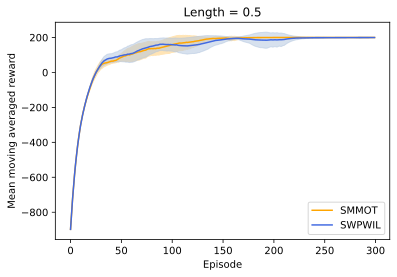

In [35]:
plt.plot([r.ep for r in training_record_multi_l_0_5_seed10], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in training_record_multi_l_0_5_seed10],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in training_record_multi_l_0_5_seed10], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in training_record_multi_l_0_5_seed10],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)

plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.title('Length = 0.5')
plt.legend(['SMMOT', 'SWPWIL'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_unique_len_0_5_%s.png"%environment)
plt.show()

#### Length = 0.1

In [36]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 91
    training_record_multi_l_1_7_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.5 score of current env 45.0
Ep 1 Average score: -800.45 score of current env 55.0
Ep 2 Average score: -718.8050000000001 score of current env 16.0
Ep 3 Average score: -644.5245000000001 score of current env 24.0
Ep 4 Average score: -579.0720500000001 score of current env 10.0
Ep 5 Average score: -520.0648450000001 score of current env 11.0
Ep 6 Average score: -466.65836050000013 score of current env 14.0
Ep 7 Average score: -418.3925244500001 score of current env 16.0
Ep 8 Average score: -371.15327200500013 score of current env 54.0
Ep 9 Average score: -331.4379448045001 score of current env 26.0
Ep 10 Average score: -294.69415032405004 score of current env 36.0
Ep 11 Average score: -264.42473529164505 score of current env 8.0
Ep 12 Average score: -237.08226176248056 score of current env 9.0
Ep 13 Average score: -212.3740355862325 score of current env 10.0
Ep 14 Average score: -190.13663202760927 score of current env 10.0
Ep 15 Average score: -169.9229688248483

Ep 125 Average score: 111.81333113891736 score of current env 162.0
Ep 126 Average score: 112.53199802502563 score of current env 119.0
Ep 127 Average score: 113.87879822252307 score of current env 126.0
Ep 128 Average score: 116.99091840027077 score of current env 145.0
Ep 129 Average score: 118.29182656024369 score of current env 130.0
Ep 130 Average score: 123.96264390421932 score of current env 175.0
Ep 131 Average score: 131.5663795137974 score of current env 200.0
Ep 132 Average score: 138.40974156241765 score of current env 200.0
Ep 133 Average score: 144.56876740617588 score of current env 200.0
Ep 134 Average score: 148.9118906655583 score of current env 188.0
Ep 135 Average score: 154.02070159900248 score of current env 200.0
Ep 136 Average score: 158.61863143910224 score of current env 200.0
Ep 137 Average score: 162.75676829519202 score of current env 200.0
Ep 138 Average score: 166.48109146567282 score of current env 200.0
Ep 139 Average score: 169.83298231910555 score of 

Ep 247 Average score: 179.78718081221226 score of current env 200.0
Ep 248 Average score: 181.80846273099104 score of current env 200.0
Ep 249 Average score: 183.62761645789195 score of current env 200.0
Ep 250 Average score: 185.26485481210275 score of current env 200.0
Ep 251 Average score: 186.73836933089248 score of current env 200.0
Ep 252 Average score: 188.06453239780325 score of current env 200.0
Ep 253 Average score: 189.25807915802292 score of current env 200.0
Ep 254 Average score: 190.33227124222063 score of current env 200.0
Ep 255 Average score: 191.29904411799856 score of current env 200.0
Ep 256 Average score: 192.1691397061987 score of current env 200.0
Ep 257 Average score: 192.95222573557885 score of current env 200.0
Ep 258 Average score: 193.65700316202097 score of current env 200.0
Ep 259 Average score: 194.29130284581888 score of current env 200.0
Ep 260 Average score: 194.862172561237 score of current env 200.0
Ep 261 Average score: 195.3759553051133 score of cu

In [37]:
pickle.dump(training_record_multi_l_1_7_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed1_%s.pkl'%environment, 'wb' ))

In [38]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 92
    training_record_multi_l_1_7_seed2= main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -892.9 score of current env 71.0
Ep 1 Average score: -802.51 score of current env 11.0
Ep 2 Average score: -716.759 score of current env 55.0
Ep 3 Average score: -639.7831000000001 score of current env 53.0
Ep 4 Average score: -573.4047900000002 score of current env 24.0
Ep 5 Average score: -514.7643110000002 score of current env 13.0
Ep 6 Average score: -461.78787990000023 score of current env 15.0
Ep 7 Average score: -412.0090919100002 score of current env 36.0
Ep 8 Average score: -369.7081827190002 score of current env 11.0
Ep 9 Average score: -329.6373644471002 score of current env 31.0
Ep 10 Average score: -295.07362800239014 score of current env 16.0
Ep 11 Average score: -264.26626520215115 score of current env 13.0
Ep 12 Average score: -236.83963868193604 score of current env 10.0
Ep 13 Average score: -211.85567481374244 score of current env 13.0
Ep 14 Average score: -189.77010733236818 score of current env 9.0
Ep 15 Average score: -167.19309659913137 score o

Ep 125 Average score: 175.7661710470551 score of current env 162.0
Ep 126 Average score: 176.4895539423496 score of current env 183.0
Ep 127 Average score: 175.24059854811466 score of current env 164.0
Ep 128 Average score: 176.6165386933032 score of current env 189.0
Ep 129 Average score: 176.05488482397288 score of current env 171.0
Ep 130 Average score: 176.24939634157562 score of current env 178.0
Ep 131 Average score: 177.22445670741806 score of current env 186.0
Ep 132 Average score: 175.30201103667628 score of current env 158.0
Ep 133 Average score: 177.17180993300866 score of current env 194.0
Ep 134 Average score: 175.4546289397078 score of current env 160.0
Ep 135 Average score: 177.909166045737 score of current env 200.0
Ep 136 Average score: 176.8182494411633 score of current env 167.0
Ep 137 Average score: 178.13642449704696 score of current env 190.0
Ep 138 Average score: 179.52278204734228 score of current env 192.0
Ep 139 Average score: 179.17050384260804 score of curre

Ep 247 Average score: 199.48333976341047 score of current env 200.0
Ep 248 Average score: 197.2350057870694 score of current env 177.0
Ep 249 Average score: 197.51150520836248 score of current env 200.0
Ep 250 Average score: 197.76035468752625 score of current env 200.0
Ep 251 Average score: 197.78431921877365 score of current env 198.0
Ep 252 Average score: 198.00588729689628 score of current env 200.0
Ep 253 Average score: 198.20529856720665 score of current env 200.0
Ep 254 Average score: 198.384768710486 score of current env 200.0
Ep 255 Average score: 198.5462918394374 score of current env 200.0
Ep 256 Average score: 198.69166265549367 score of current env 200.0
Ep 257 Average score: 198.82249638994432 score of current env 200.0
Ep 258 Average score: 198.94024675094988 score of current env 200.0
Ep 259 Average score: 198.74622207585492 score of current env 197.0
Ep 260 Average score: 198.87159986826944 score of current env 200.0
Ep 261 Average score: 198.9844398814425 score of cur

In [39]:
pickle.dump(training_record_multi_l_1_7_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed2_%s.pkl'%environment, 'wb' ))

In [40]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 93
    training_record_multi_l_1_7_seed3 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -805.7800000000001 score of current env 26.0
Ep 2 Average score: -723.3020000000001 score of current env 19.0
Ep 3 Average score: -649.5718000000002 score of current env 14.0
Ep 4 Average score: -582.5146200000001 score of current env 21.0
Ep 5 Average score: -522.4631580000002 score of current env 18.0
Ep 6 Average score: -467.51684220000027 score of current env 27.0
Ep 7 Average score: -417.96515798000024 score of current env 28.0
Ep 8 Average score: -372.76864218200024 score of current env 34.0
Ep 9 Average score: -333.59177796380027 score of current env 19.0
Ep 10 Average score: -298.1326001674202 score of current env 21.0
Ep 11 Average score: -267.5193401506782 score of current env 8.0
Ep 12 Average score: -239.9674061356104 score of current env 8.0
Ep 13 Average score: -214.97066552204936 score of current env 10.0
Ep 14 Average score: -192.47359896984443 score of current env 10.0
Ep 15 Average score: -172.22

Ep 125 Average score: 194.73053694659686 score of current env 200.0
Ep 126 Average score: 194.95748325193716 score of current env 197.0
Ep 127 Average score: 195.46173492674345 score of current env 200.0
Ep 128 Average score: 195.9155614340691 score of current env 200.0
Ep 129 Average score: 192.7240052906622 score of current env 164.0
Ep 130 Average score: 193.451604761596 score of current env 200.0
Ep 131 Average score: 182.6064442854364 score of current env 85.0
Ep 132 Average score: 176.44579985689276 score of current env 121.0
Ep 133 Average score: 169.8012198712035 score of current env 110.0
Ep 134 Average score: 160.52109788408313 score of current env 77.0
Ep 135 Average score: 164.46898809567483 score of current env 200.0
Ep 136 Average score: 168.02208928610736 score of current env 200.0
Ep 137 Average score: 160.31988035749663 score of current env 91.0
Ep 138 Average score: 152.28789232174697 score of current env 80.0
Ep 139 Average score: 144.35910308957227 score of current 

Ep 249 Average score: 162.38897239436764 score of current env 183.0
Ep 250 Average score: 166.15007515493087 score of current env 200.0
Ep 251 Average score: 169.53506763943778 score of current env 200.0
Ep 252 Average score: 172.481560875494 score of current env 199.0
Ep 253 Average score: 173.7334047879446 score of current env 185.0
Ep 254 Average score: 176.36006430915015 score of current env 200.0
Ep 255 Average score: 178.72405787823513 score of current env 200.0
Ep 256 Average score: 180.85165209041162 score of current env 200.0
Ep 257 Average score: 182.76648688137047 score of current env 200.0
Ep 258 Average score: 184.48983819323342 score of current env 200.0
Ep 259 Average score: 186.0408543739101 score of current env 200.0
Ep 260 Average score: 187.4367689365191 score of current env 200.0
Ep 261 Average score: 188.6930920428672 score of current env 200.0
Ep 262 Average score: 189.82378283858048 score of current env 200.0
Ep 263 Average score: 190.84140455472243 score of curr

In [41]:
pickle.dump(training_record_multi_l_1_7_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed3_%s.pkl'%environment, 'wb' ))

In [42]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 94
    training_record_multi_l_1_7_seed4 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.1 score of current env 49.0
Ep 1 Average score: -804.49 score of current env 11.0
Ep 2 Average score: -722.441 score of current env 16.0
Ep 3 Average score: -647.4969 score of current env 27.0
Ep 4 Average score: -581.84721 score of current env 9.0
Ep 5 Average score: -518.062489 score of current env 56.0
Ep 6 Average score: -464.9562401 score of current env 13.0
Ep 7 Average score: -415.46061609000003 score of current env 30.0
Ep 8 Average score: -372.114554481 score of current env 18.0
Ep 9 Average score: -332.40309903290006 score of current env 25.0
Ep 10 Average score: -297.86278912961006 score of current env 13.0
Ep 11 Average score: -267.1765102166491 score of current env 9.0
Ep 12 Average score: -239.5588591949842 score of current env 9.0
Ep 13 Average score: -214.70297327548576 score of current env 9.0
Ep 14 Average score: -191.7326759479372 score of current env 15.0
Ep 15 Average score: -171.15940835314348 score of current env 14.0
Ep 16 Average score:

Ep 126 Average score: 135.40473244682255 score of current env 172.0
Ep 127 Average score: 139.36425920214032 score of current env 175.0
Ep 128 Average score: 131.5278332819263 score of current env 61.0
Ep 129 Average score: 123.37504995373367 score of current env 50.0
Ep 130 Average score: 117.6375449583603 score of current env 66.0
Ep 131 Average score: 118.57379046252427 score of current env 127.0
Ep 132 Average score: 114.41641141627186 score of current env 77.0
Ep 133 Average score: 113.27477027464467 score of current env 103.0
Ep 134 Average score: 110.9472932471802 score of current env 90.0
Ep 135 Average score: 111.05256392246218 score of current env 112.0
Ep 136 Average score: 119.94730753021597 score of current env 200.0
Ep 137 Average score: 117.35257677719437 score of current env 94.0
Ep 138 Average score: 125.61731909947494 score of current env 200.0
Ep 139 Average score: 133.05558718952744 score of current env 200.0
Ep 140 Average score: 139.7500284705747 score of current 

Ep 248 Average score: 121.6918521289512 score of current env 102.0
Ep 249 Average score: 129.5226669160561 score of current env 200.0
Ep 250 Average score: 136.5704002244505 score of current env 200.0
Ep 251 Average score: 142.91336020200546 score of current env 200.0
Ep 252 Average score: 148.62202418180493 score of current env 200.0
Ep 253 Average score: 153.75982176362444 score of current env 200.0
Ep 254 Average score: 158.383839587262 score of current env 200.0
Ep 255 Average score: 162.54545562853582 score of current env 200.0
Ep 256 Average score: 166.29091006568225 score of current env 200.0
Ep 257 Average score: 164.56181905911404 score of current env 149.0
Ep 258 Average score: 168.10563715320265 score of current env 200.0
Ep 259 Average score: 160.6950734378824 score of current env 94.0
Ep 260 Average score: 164.62556609409415 score of current env 200.0
Ep 261 Average score: 168.16300948468475 score of current env 200.0
Ep 262 Average score: 171.34670853621628 score of curre

In [43]:
pickle.dump(training_record_multi_l_1_7_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed4_%s.pkl'%environment, 'wb' ))

In [44]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 95
    training_record_multi_l_1_7_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -804.81 score of current env 42.0
Ep 2 Average score: -721.2289999999999 score of current env 31.0
Ep 3 Average score: -645.4060999999999 score of current env 37.0
Ep 4 Average score: -576.7654899999999 score of current env 41.0
Ep 5 Average score: -517.9889409999998 score of current env 11.0
Ep 6 Average score: -464.69004689999986 score of current env 15.0
Ep 7 Average score: -414.2210422099999 score of current env 40.0
Ep 8 Average score: -370.9989379889999 score of current env 18.0
Ep 9 Average score: -332.3990441900999 score of current env 15.0
Ep 10 Average score: -298.15913977108994 score of current env 10.0
Ep 11 Average score: -267.34322579398093 score of current env 10.0
Ep 12 Average score: -239.50890321458286 score of current env 11.0
Ep 13 Average score: -213.75801289312457 score of current env 18.0
Ep 14 Average score: -191.18221160381214 score of current env 12.0
Ep 15 Average score: -171.16399044343

Ep 125 Average score: 110.37997214288484 score of current env 121.0
Ep 126 Average score: 110.74197492859636 score of current env 114.0
Ep 127 Average score: 111.16777743573672 score of current env 115.0
Ep 128 Average score: 109.55099969216306 score of current env 95.0
Ep 129 Average score: 109.69589972294676 score of current env 111.0
Ep 130 Average score: 107.82630975065209 score of current env 91.0
Ep 131 Average score: 109.34367877558688 score of current env 123.0
Ep 132 Average score: 109.1093108980282 score of current env 107.0
Ep 133 Average score: 109.29837980822538 score of current env 111.0
Ep 134 Average score: 108.96854182740285 score of current env 106.0
Ep 135 Average score: 109.37168764466256 score of current env 113.0
Ep 136 Average score: 108.53451888019632 score of current env 101.0
Ep 137 Average score: 108.38106699217668 score of current env 107.0
Ep 138 Average score: 108.74296029295903 score of current env 112.0
Ep 139 Average score: 109.26866426366313 score of c

Ep 247 Average score: 170.9346468204888 score of current env 200.0
Ep 248 Average score: 173.84118213843993 score of current env 200.0
Ep 249 Average score: 176.45706392459596 score of current env 200.0
Ep 250 Average score: 178.81135753213636 score of current env 200.0
Ep 251 Average score: 180.93022177892271 score of current env 200.0
Ep 252 Average score: 182.83719960103045 score of current env 200.0
Ep 253 Average score: 184.5534796409274 score of current env 200.0
Ep 254 Average score: 185.89813167683468 score of current env 198.0
Ep 255 Average score: 187.3083185091512 score of current env 200.0
Ep 256 Average score: 188.5774866582361 score of current env 200.0
Ep 257 Average score: 189.7197379924125 score of current env 200.0
Ep 258 Average score: 189.64776419317124 score of current env 189.0
Ep 259 Average score: 189.48298777385412 score of current env 188.0
Ep 260 Average score: 190.5346889964687 score of current env 200.0
Ep 261 Average score: 191.48122009682183 score of curr

In [45]:
pickle.dump(training_record_multi_l_1_7_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed5_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 96
    training_record_multi_l_1_7_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -895.6 score of current env 44.0
Ep 1 Average score: -804.0400000000001 score of current env 20.0
Ep 2 Average score: -720.436 score of current env 32.0
Ep 3 Average score: -645.8924000000001 score of current env 25.0
Ep 4 Average score: -575.30316 score of current env 60.0
Ep 5 Average score: -515.8728440000001 score of current env 19.0
Ep 6 Average score: -462.4855596000001 score of current env 18.0
Ep 7 Average score: -413.4370036400001 score of current env 28.0
Ep 8 Average score: -370.8933032760001 score of current env 12.0
Ep 9 Average score: -332.3039729484001 score of current env 15.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -296.67357565356014 score of current env 24.0
Ep 11 Average score: -266.00621808820415 score of current env 10.0
Ep 12 Average score: -238.20559627938374 score of current env 12.0
Ep 13 Average score: -213.1850366514454 score of current env 12.0
Ep 14 Average score: -190.96653298630085 score of current env 9.0
Ep 15 Average score: -170.86987968767076 score of current env 10.0
Ep 16 Average score: -151.0828917189037 score of current env 27.0
Ep 17 Average score: -131.67460254701334 score of current env 43.0
Ep 18 Average score: -117.00714229231201 score of current env 15.0
Ep 19 Average score: -103.30642806308082 score of current env 20.0
Ep 20 Average score: -91.67578525677274 score of current env 13.0
Ep 21 Average score: -80.80820673109547 score of current env 17.0
Ep 22 Average score: -71.62738605798593 score of current env 11.0
Ep 23 Average score: -62.964647452187336 score of current env 15.0
Ep 24 Average score: -54.368182706968604 score of current env 23.0
E

Ep 133 Average score: 170.64271440640434 score of current env 191.0
Ep 134 Average score: 168.47844296576392 score of current env 149.0
Ep 135 Average score: 171.63059866918752 score of current env 200.0
Ep 136 Average score: 168.26753880226877 score of current env 138.0
Ep 137 Average score: 167.7407849220419 score of current env 163.0
Ep 138 Average score: 167.46670642983773 score of current env 165.0
Ep 139 Average score: 166.62003578685398 score of current env 159.0
Ep 140 Average score: 169.9580322081686 score of current env 200.0
Ep 141 Average score: 168.1622289873517 score of current env 152.0
Ep 142 Average score: 170.24600608861655 score of current env 189.0
Ep 143 Average score: 172.1214054797549 score of current env 189.0
Ep 144 Average score: 171.60926493177942 score of current env 167.0
Ep 145 Average score: 169.7483384386015 score of current env 153.0
Ep 146 Average score: 166.77350459474135 score of current env 140.0
Ep 147 Average score: 169.49615413526723 score of cur

Ep 255 Average score: 183.6106194742215 score of current env 200.0
Ep 256 Average score: 182.34955752679934 score of current env 171.0
Ep 257 Average score: 183.41460177411943 score of current env 193.0
Ep 258 Average score: 182.5731415967075 score of current env 175.0
Ep 259 Average score: 183.21582743703675 score of current env 189.0
Ep 260 Average score: 181.3942446933331 score of current env 165.0
Ep 261 Average score: 183.2548202239998 score of current env 200.0
Ep 262 Average score: 184.0293382015998 score of current env 191.0
Ep 263 Average score: 184.22640438143983 score of current env 186.0
Ep 264 Average score: 182.20376394329585 score of current env 164.0
Ep 265 Average score: 181.7833875489663 score of current env 178.0
Ep 266 Average score: 181.00504879406967 score of current env 174.0
Ep 267 Average score: 181.9045439146627 score of current env 190.0
Ep 268 Average score: 183.21408952319644 score of current env 195.0
Ep 269 Average score: 184.8926805708768 score of curren

In [7]:
pickle.dump(training_record_multi_l_1_7_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed6_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 97
    training_record_multi_l_1_7_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -896.7 score of current env 33.0
Ep 1 Average score: -804.6300000000001 score of current env 24.0
Ep 2 Average score: -720.5670000000001 score of current env 36.0
Ep 3 Average score: -645.3103000000001 score of current env 32.0
Ep 4 Average score: -579.5792700000001 score of current env 12.0
Ep 5 Average score: -519.021343 score of current env 26.0
Ep 6 Average score: -465.3192087 score of current env 18.0
Ep 7 Average score: -416.28728783 score of current env 25.0
Ep 8 Average score: -370.95855904700005 score of current env 37.0
Ep 9 Average score: -332.1627031423001 score of current env 17.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -297.2464328280701 score of current env 17.0
Ep 11 Average score: -266.4217895452631 score of current env 11.0
Ep 12 Average score: -238.77961059073678 score of current env 10.0
Ep 13 Average score: -214.1016495316631 score of current env 8.0
Ep 14 Average score: -191.69148457849678 score of current env 10.0
Ep 15 Average score: -171.6223361206471 score of current env 9.0
Ep 16 Average score: -153.5601025085824 score of current env 9.0
Ep 17 Average score: -137.30409225772414 score of current env 9.0
Ep 18 Average score: -122.37368303195173 score of current env 12.0
Ep 19 Average score: -109.13631472875656 score of current env 10.0
Ep 20 Average score: -97.12268325588091 score of current env 11.0
Ep 21 Average score: -86.01041493029282 score of current env 14.0
Ep 22 Average score: -76.00937343726353 score of current env 14.0
Ep 23 Average score: -66.50843609353717 score of current env 19.0
Ep 24 Average score: -58.55759248418346 score of current env 13.0
Ep 25 Ave

Ep 134 Average score: 176.2764007057104 score of current env 200.0
Ep 135 Average score: 173.54876063513936 score of current env 149.0
Ep 136 Average score: 176.19388457162543 score of current env 200.0
Ep 137 Average score: 168.4744961144629 score of current env 99.0
Ep 138 Average score: 161.52704650301663 score of current env 99.0
Ep 139 Average score: 151.47434185271496 score of current env 61.0
Ep 140 Average score: 141.32690766744346 score of current env 50.0
Ep 141 Average score: 133.49421690069912 score of current env 63.0
Ep 142 Average score: 128.6447952106292 score of current env 85.0
Ep 143 Average score: 121.6803156895663 score of current env 59.0
Ep 144 Average score: 117.41228412060968 score of current env 79.0
Ep 145 Average score: 111.27105570854872 score of current env 56.0
Ep 146 Average score: 106.04395013769386 score of current env 59.0
Ep 147 Average score: 102.23955512392448 score of current env 68.0
Ep 148 Average score: 97.91559961153203 score of current env 59

Ep 257 Average score: 182.78829259195663 score of current env 200.0
Ep 258 Average score: 184.509463332761 score of current env 200.0
Ep 259 Average score: 186.05851699948488 score of current env 200.0
Ep 260 Average score: 187.4526652995364 score of current env 200.0
Ep 261 Average score: 188.70739876958277 score of current env 200.0
Ep 262 Average score: 189.83665889262448 score of current env 200.0
Ep 263 Average score: 190.85299300336203 score of current env 200.0
Ep 264 Average score: 191.76769370302583 score of current env 200.0
Ep 265 Average score: 192.59092433272326 score of current env 200.0
Ep 266 Average score: 193.33183189945095 score of current env 200.0
Ep 267 Average score: 193.99864870950586 score of current env 200.0
Ep 268 Average score: 194.59878383855528 score of current env 200.0
Ep 269 Average score: 195.13890545469977 score of current env 200.0
Ep 270 Average score: 190.1250149092298 score of current env 145.0
Ep 271 Average score: 188.51251341830684 score of cu

In [7]:
pickle.dump(training_record_multi_l_1_7_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed7_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 98
    training_record_multi_l_1_7_seed8 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -798.5 score of current env 97.0
Ep 2 Average score: -715.05 score of current env 36.0
Ep 3 Average score: -640.9449999999999 score of current env 26.0
Ep 4 Average score: -573.1505 score of current env 37.0
Ep 5 Average score: -511.43545000000006 score of current env 44.0
Ep 6 Average score: -456.59190500000005 score of current env 37.0
Ep 7 Average score: -409.8327145 score of current env 11.0
Ep 8 Average score: -367.54944305 score of current env 13.0
Ep 9 Average score: -328.094498745 score of current env 27.0
Ep 10 Average score: -293.58504887050003 score of current env 17.0
Ep 11 Average score: -263.22654398345003 score of current env 10.0
Ep 12 Average score: -236.00388958510501 score of current env 9.0
Ep 13 Average score: -211.5035006265945 score of current env 9.0
Ep 14 Average score: -189.05315056393505 score of current env 13.0
Ep 15 Average score: -168.74783550754154 score of current env 14.0
Ep 16 Av

Ep 125 Average score: 185.19357875551728 score of current env 160.0
Ep 126 Average score: 182.37422087996555 score of current env 157.0
Ep 127 Average score: 179.036798791969 score of current env 149.0
Ep 128 Average score: 180.43311891277213 score of current env 193.0
Ep 129 Average score: 182.38980702149493 score of current env 200.0
Ep 130 Average score: 184.15082631934544 score of current env 200.0
Ep 131 Average score: 185.7357436874109 score of current env 200.0
Ep 132 Average score: 187.1621693186698 score of current env 200.0
Ep 133 Average score: 188.44595238680284 score of current env 200.0
Ep 134 Average score: 189.10135714812256 score of current env 195.0
Ep 135 Average score: 190.19122143331032 score of current env 200.0
Ep 136 Average score: 191.1720992899793 score of current env 200.0
Ep 137 Average score: 192.05488936098135 score of current env 200.0
Ep 138 Average score: 192.8494004248832 score of current env 200.0
Ep 139 Average score: 193.56446038239488 score of curr

Ep 247 Average score: 196.6634854400917 score of current env 200.0
Ep 248 Average score: 195.99713689608254 score of current env 190.0
Ep 249 Average score: 196.3974232064743 score of current env 200.0
Ep 250 Average score: 196.75768088582686 score of current env 200.0
Ep 251 Average score: 197.08191279724417 score of current env 200.0
Ep 252 Average score: 197.37372151751975 score of current env 200.0
Ep 253 Average score: 197.63634936576779 score of current env 200.0
Ep 254 Average score: 197.872714429191 score of current env 200.0
Ep 255 Average score: 198.08544298627191 score of current env 200.0
Ep 256 Average score: 198.27689868764472 score of current env 200.0
Ep 257 Average score: 198.44920881888024 score of current env 200.0
Ep 258 Average score: 198.60428793699222 score of current env 200.0
Ep 259 Average score: 198.743859143293 score of current env 200.0
Ep 260 Average score: 198.8694732289637 score of current env 200.0
Ep 261 Average score: 198.98252590606734 score of curre

In [9]:
pickle.dump(training_record_multi_l_1_7_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed8_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 99
    training_record_multi_l_1_7_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.2 score of current env 48.0
Ep 1 Average score: -802.8800000000001 score of current env 28.0
Ep 2 Average score: -720.0920000000001 score of current env 25.0
Ep 3 Average score: -646.9828000000001 score of current env 11.0
Ep 4 Average score: -576.6845200000001 score of current env 56.0
Ep 5 Average score: -516.2160680000002 score of current env 28.0
Ep 6 Average score: -462.5944612000002 score of current env 20.0
Ep 7 Average score: -415.23501508000015 score of current env 11.0
Ep 8 Average score: -371.91151357200016 score of current env 18.0
Ep 9 Average score: -326.8203622148002 score of current env 79.0
Ep 10 Average score: -292.53832599332014 score of current env 16.0
Ep 11 Average score: -260.28449339398816 score of current env 30.0
Ep 12 Average score: -232.45604405458934 score of current env 18.0
Ep 13 Average score: -206.81043964913042 score of current env 24.0
Ep 14 Average score: -182.82939568421736 score of current env 33.0
Ep 15 Average score: -162

Ep 124 Average score: 128.38349760966963 score of current env 97.0
Ep 125 Average score: 128.84514784870268 score of current env 133.0
Ep 126 Average score: 125.36063306383242 score of current env 94.0
Ep 127 Average score: 122.92456975744918 score of current env 101.0
Ep 128 Average score: 117.03211278170427 score of current env 64.0
Ep 129 Average score: 112.22890150353385 score of current env 69.0
Ep 130 Average score: 106.50601135318047 score of current env 55.0
Ep 131 Average score: 100.05541021786243 score of current env 42.0
Ep 132 Average score: 94.54986919607619 score of current env 45.0
Ep 133 Average score: 92.79488227646857 score of current env 77.0
Ep 134 Average score: 89.51539404882172 score of current env 60.0
Ep 135 Average score: 94.96385464393956 score of current env 144.0
Ep 136 Average score: 90.9674691795456 score of current env 55.0
Ep 137 Average score: 85.47072226159104 score of current env 36.0
Ep 138 Average score: 82.02365003543193 score of current env 51.0


Ep 247 Average score: 130.27122680840915 score of current env 143.0
Ep 248 Average score: 131.94410412756824 score of current env 147.0
Ep 249 Average score: 132.0496937148114 score of current env 133.0
Ep 250 Average score: 132.04472434333027 score of current env 132.0
Ep 251 Average score: 133.74025190899724 score of current env 149.0
Ep 252 Average score: 136.0662267180975 score of current env 157.0
Ep 253 Average score: 137.65960404628777 score of current env 152.0
Ep 254 Average score: 140.09364364165899 score of current env 162.0
Ep 255 Average score: 143.28427927749308 score of current env 172.0
Ep 256 Average score: 145.25585134974378 score of current env 163.0
Ep 257 Average score: 144.53026621476943 score of current env 138.0
Ep 258 Average score: 148.77723959329248 score of current env 187.0
Ep 259 Average score: 150.09951563396322 score of current env 162.0
Ep 260 Average score: 155.0895640705669 score of current env 200.0
Ep 261 Average score: 159.58060766351022 score of c

In [11]:
pickle.dump(training_record_multi_l_1_7_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed9_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 100
    training_record_multi_l_1_7_seed10 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -806.23 score of current env 26.0
Ep 2 Average score: -722.3070000000001 score of current env 33.0
Ep 3 Average score: -647.1763000000002 score of current env 29.0
Ep 4 Average score: -581.3586700000002 score of current env 11.0
Ep 5 Average score: -521.9228030000003 score of current env 13.0
Ep 6 Average score: -458.93052270000027 score of current env 108.0
Ep 7 Average score: -410.73747043000026 score of current env 23.0
Ep 8 Average score: -368.26372338700025 score of current env 14.0
Ep 9 Average score: -328.43735104830023 score of current env 30.0
Ep 10 Average score: -293.79361594347023 score of current env 18.0
Ep 11 Average score: -263.3142543491232 score of current env 11.0
Ep 12 Average score: -236.18282891421086 score of current env 8.0
Ep 13 Average score: -211.66454602278978 score of current env 9.0
Ep 14 Average score: -189.29809142051081 score of current env 12.0
Ep 15 Average score: -166.4682822784

Ep 124 Average score: 184.6952236589912 score of current env 200.0
Ep 125 Average score: 186.2257012930921 score of current env 200.0
Ep 126 Average score: 187.6031311637829 score of current env 200.0
Ep 127 Average score: 188.84281804740462 score of current env 200.0
Ep 128 Average score: 189.95853624266417 score of current env 200.0
Ep 129 Average score: 190.96268261839776 score of current env 200.0
Ep 130 Average score: 191.86641435655798 score of current env 200.0
Ep 131 Average score: 192.6797729209022 score of current env 200.0
Ep 132 Average score: 193.41179562881197 score of current env 200.0
Ep 133 Average score: 194.07061606593078 score of current env 200.0
Ep 134 Average score: 194.66355445933772 score of current env 200.0
Ep 135 Average score: 195.19719901340395 score of current env 200.0
Ep 136 Average score: 195.67747911206357 score of current env 200.0
Ep 137 Average score: 196.10973120085723 score of current env 200.0
Ep 138 Average score: 196.4987580807715 score of cur

Ep 246 Average score: 199.8273043672568 score of current env 200.0
Ep 247 Average score: 199.8445739305311 score of current env 200.0
Ep 248 Average score: 199.860116537478 score of current env 200.0
Ep 249 Average score: 199.8741048837302 score of current env 200.0
Ep 250 Average score: 199.88669439535718 score of current env 200.0
Ep 251 Average score: 199.89802495582146 score of current env 200.0
Ep 252 Average score: 199.9082224602393 score of current env 200.0
Ep 253 Average score: 199.91740021421538 score of current env 200.0
Ep 254 Average score: 199.92566019279386 score of current env 200.0
Ep 255 Average score: 199.93309417351446 score of current env 200.0
Ep 256 Average score: 199.93978475616302 score of current env 200.0
Ep 257 Average score: 199.94580628054672 score of current env 200.0
Ep 258 Average score: 199.95122565249204 score of current env 200.0
Ep 259 Average score: 199.95610308724284 score of current env 200.0
Ep 260 Average score: 199.96049277851856 score of curr

In [13]:
pickle.dump(training_record_multi_l_1_7_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed10_%s.pkl'%environment, 'wb' ))

In [17]:
mmottraining_record_multi_l_1_7_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed1_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed2_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed3_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed4_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed5_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed6_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed7_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed8_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed9_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_7_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_7_seed10_%s.pkl'%environment,'rb' ))

l1_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed1]
l2_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed2]
l3_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed3]
l4_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed4]
l5_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed5]
l6_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed6]
l7_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed7]
l8_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed8]
l9_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed9]
l10_simple = [r.reward for r in mmottraining_record_multi_l_1_7_seed10]

In [18]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 911
    training_record_multi_l_1_7_seed1 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -805.4800000000001 score of current env 29.0
Ep 2 Average score: -723.4320000000001 score of current env 15.0
Ep 3 Average score: -650.1888000000001 score of current env 9.0
Ep 4 Average score: -580.0699200000001 score of current env 51.0
Ep 5 Average score: -520.5629280000002 score of current env 15.0
Ep 6 Average score: -466.3066352000002 score of current env 22.0
Ep 7 Average score: -416.0759716800002 score of current env 36.0
Ep 8 Average score: -372.4683745120002 score of current env 20.0
Ep 9 Average score: -330.12153706080016 score of current env 51.0
Ep 10 Average score: -294.5093833547201 score of current env 26.0
Ep 11 Average score: -257.1584450192481 score of current env 79.0
Ep 12 Average score: -230.5426005173233 score of current env 9.0
Ep 13 Average score: -198.388340465591 score of current env 91.0
Ep 14 Average score: -175.9495064190319 score of current env 26.0
Ep 15 Average score: -155.45455577

Ep 124 Average score: 123.71166604269251 score of current env 155.0
Ep 125 Average score: 125.54049943842327 score of current env 142.0
Ep 126 Average score: 128.88644949458094 score of current env 159.0
Ep 127 Average score: 130.29780454512286 score of current env 143.0
Ep 128 Average score: 132.16802409061057 score of current env 149.0
Ep 129 Average score: 131.15122168154952 score of current env 122.0
Ep 130 Average score: 131.33609951339457 score of current env 133.0
Ep 131 Average score: 131.70248956205512 score of current env 135.0
Ep 132 Average score: 130.83224060584962 score of current env 123.0
Ep 133 Average score: 132.84901654526467 score of current env 151.0
Ep 134 Average score: 132.6641148907382 score of current env 131.0
Ep 135 Average score: 136.2977034016644 score of current env 169.0
Ep 136 Average score: 139.36793306149795 score of current env 167.0
Ep 137 Average score: 139.23113975534815 score of current env 138.0
Ep 138 Average score: 140.70802577981334 score of 

Ep 246 Average score: 196.1887806114538 score of current env 200.0
Ep 247 Average score: 196.56990255030843 score of current env 200.0
Ep 248 Average score: 196.91291229527758 score of current env 200.0
Ep 249 Average score: 197.22162106574982 score of current env 200.0
Ep 250 Average score: 197.49945895917483 score of current env 200.0
Ep 251 Average score: 196.64951306325736 score of current env 189.0
Ep 252 Average score: 195.88456175693165 score of current env 189.0
Ep 253 Average score: 196.2961055812385 score of current env 200.0
Ep 254 Average score: 195.76649502311463 score of current env 191.0
Ep 255 Average score: 196.18984552080317 score of current env 200.0
Ep 256 Average score: 193.67086096872285 score of current env 171.0
Ep 257 Average score: 194.30377487185058 score of current env 200.0
Ep 258 Average score: 194.87339738466554 score of current env 200.0
Ep 259 Average score: 195.386057646199 score of current env 200.0
Ep 260 Average score: 195.8474518815791 score of cur

In [17]:
pickle.dump(training_record_multi_l_1_7_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed1_%s.pkl'%environment, 'wb' ))

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 921
    training_record_multi_l_1_7_seed2= main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -899.1 score of current env 9.0
Ep 1 Average score: -807.09 score of current env 21.0
Ep 2 Average score: -724.2810000000001 score of current env 21.0
Ep 3 Average score: -650.3529000000001 score of current env 15.0
Ep 4 Average score: -583.9176100000001 score of current env 14.0
Ep 5 Average score: -524.2258490000002 score of current env 13.0
Ep 6 Average score: -470.7032641000001 score of current env 11.0
Ep 7 Average score: -420.3329376900001 score of current env 33.0
Ep 8 Average score: -376.5996439210001 score of current env 17.0
Ep 9 Average score: -335.9396795289001 score of current env 30.0
Ep 10 Average score: -300.9457115760101 score of current env 14.0
Ep 11 Average score: -269.2511404184091 score of current env 16.0
Ep 12 Average score: -241.32602637656817 score of current env 10.0
Ep 13 Average score: -216.29342373891134 score of current env 9.0
Ep 14 Average score: -193.46408136502023 score of current env 12.0
Ep 15 Average score: -173.01767322851822 s

Ep 125 Average score: 49.02535372435819 score of current env 65.0
Ep 126 Average score: 62.822818351922365 score of current env 187.0
Ep 127 Average score: 76.54053651673013 score of current env 200.0
Ep 128 Average score: 88.88648286505712 score of current env 200.0
Ep 129 Average score: 99.9978345785514 score of current env 200.0
Ep 130 Average score: 109.99805112069626 score of current env 200.0
Ep 131 Average score: 118.99824600862664 score of current env 200.0
Ep 132 Average score: 127.09842140776398 score of current env 200.0
Ep 133 Average score: 134.38857926698756 score of current env 200.0
Ep 134 Average score: 131.3497213402888 score of current env 104.0
Ep 135 Average score: 126.91474920625993 score of current env 87.0
Ep 136 Average score: 122.42327428563394 score of current env 82.0
Ep 137 Average score: 118.38094685707055 score of current env 82.0
Ep 138 Average score: 113.5428521713635 score of current env 70.0
Ep 139 Average score: 107.18856695422716 score of current en

Ep 247 Average score: 163.56207440146585 score of current env 192.0
Ep 248 Average score: 167.20586696131926 score of current env 200.0
Ep 249 Average score: 170.48528026518733 score of current env 200.0
Ep 250 Average score: 173.4367522386686 score of current env 200.0
Ep 251 Average score: 176.09307701480174 score of current env 200.0
Ep 252 Average score: 178.48376931332157 score of current env 200.0
Ep 253 Average score: 180.63539238198942 score of current env 200.0
Ep 254 Average score: 182.5718531437905 score of current env 200.0
Ep 255 Average score: 184.31466782941143 score of current env 200.0
Ep 256 Average score: 185.8832010464703 score of current env 200.0
Ep 257 Average score: 187.29488094182327 score of current env 200.0
Ep 258 Average score: 188.56539284764094 score of current env 200.0
Ep 259 Average score: 189.70885356287684 score of current env 200.0
Ep 260 Average score: 190.73796820658916 score of current env 200.0
Ep 261 Average score: 191.66417138593025 score of c

In [19]:
pickle.dump(training_record_multi_l_1_7_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed2_%s.pkl'%environment, 'wb' ))

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 931
    training_record_multi_l_1_7_seed3 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -803.85 score of current env 48.0
Ep 2 Average score: -719.565 score of current env 39.0
Ep 3 Average score: -646.8085000000001 score of current env 8.0
Ep 4 Average score: -579.4276500000001 score of current env 27.0
Ep 5 Average score: -519.884885 score of current env 16.0
Ep 6 Average score: -465.89639650000004 score of current env 20.0
Ep 7 Average score: -418.30675685000006 score of current env 10.0
Ep 8 Average score: -375.07608116500006 score of current env 14.0
Ep 9 Average score: -336.36847304850005 score of current env 12.0
Ep 10 Average score: -301.43162574365005 score of current env 13.0
Ep 11 Average score: -270.38846316928505 score of current env 9.0
Ep 12 Average score: -242.24961685235655 score of current env 11.0
Ep 13 Average score: -216.9246551671209 score of current env 11.0
Ep 14 Average score: -193.83218965040882 score of current env 14.0
Ep 15 Average score: -168.74897068536796 score of curr

Ep 126 Average score: 84.36362753634813 score of current env 47.0
Ep 127 Average score: 95.92726478271332 score of current env 200.0
Ep 128 Average score: 92.534538304442 score of current env 62.0
Ep 129 Average score: 92.58108447399779 score of current env 93.0
Ep 130 Average score: 87.82297602659801 score of current env 45.0
Ep 131 Average score: 82.44067842393822 score of current env 34.0
Ep 132 Average score: 94.1966105815444 score of current env 200.0
Ep 133 Average score: 88.87694952338997 score of current env 41.0
Ep 134 Average score: 84.08925457105097 score of current env 41.0
Ep 135 Average score: 82.18032911394587 score of current env 65.0
Ep 136 Average score: 89.86229620255129 score of current env 159.0
Ep 137 Average score: 85.37606658229616 score of current env 45.0
Ep 138 Average score: 80.43845992406654 score of current env 36.0
Ep 139 Average score: 82.0946139316599 score of current env 97.0
Ep 140 Average score: 77.68515253849391 score of current env 38.0
Ep 141 Aver

Ep 249 Average score: 194.89768184421627 score of current env 200.0
Ep 250 Average score: 195.40791365979464 score of current env 200.0
Ep 251 Average score: 195.86712229381519 score of current env 200.0
Ep 252 Average score: 196.28041006443368 score of current env 200.0
Ep 253 Average score: 196.6523690579903 score of current env 200.0
Ep 254 Average score: 196.9871321521913 score of current env 200.0
Ep 255 Average score: 197.28841893697216 score of current env 200.0
Ep 256 Average score: 197.55957704327494 score of current env 200.0
Ep 257 Average score: 197.80361933894744 score of current env 200.0
Ep 258 Average score: 198.0232574050527 score of current env 200.0
Ep 259 Average score: 198.22093166454744 score of current env 200.0
Ep 260 Average score: 198.3988384980927 score of current env 200.0
Ep 261 Average score: 198.55895464828342 score of current env 200.0
Ep 262 Average score: 198.70305918345508 score of current env 200.0
Ep 263 Average score: 198.83275326510957 score of cu

In [21]:
pickle.dump(training_record_multi_l_1_7_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed3_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 941
    training_record_multi_l_1_7_seed4 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.9 score of current env 21.0
Ep 1 Average score: -804.71 score of current env 34.0
Ep 2 Average score: -723.039 score of current env 12.0
Ep 3 Average score: -648.5350999999999 score of current env 22.0
Ep 4 Average score: -582.4815899999999 score of current env 12.0
Ep 5 Average score: -521.9334309999999 score of current env 23.0
Ep 6 Average score: -468.34008789999996 score of current env 14.0
Ep 7 Average score: -418.60607911 score of current env 29.0
Ep 8 Average score: -374.945471199 score of current env 18.0
Ep 9 Average score: -335.5509240791 score of current env 19.0
Ep 10 Average score: -300.69583167119004 score of current env 13.0
Ep 11 Average score: -269.72624850407107 score of current env 9.0
Ep 12 Average score: -241.75362365366396 score of current env 10.0
Ep 13 Average score: -216.57826128829757 score of current env 10.0
Ep 14 Average score: -194.1204351594678 score of current env 8.0
Ep 15 Average score: -173.70839164352103 score of current env 

Ep 126 Average score: 179.74991433994444 score of current env 200.0
Ep 127 Average score: 181.77492290595 score of current env 200.0
Ep 128 Average score: 183.59743061535502 score of current env 200.0
Ep 129 Average score: 185.2376875538195 score of current env 200.0
Ep 130 Average score: 179.11391879843757 score of current env 124.0
Ep 131 Average score: 181.2025269185938 score of current env 200.0
Ep 132 Average score: 183.08227422673443 score of current env 200.0
Ep 133 Average score: 184.774046804061 score of current env 200.0
Ep 134 Average score: 186.2966421236549 score of current env 200.0
Ep 135 Average score: 187.6669779112894 score of current env 200.0
Ep 136 Average score: 188.90028012016046 score of current env 200.0
Ep 137 Average score: 190.0102521081444 score of current env 200.0
Ep 138 Average score: 185.00922689732997 score of current env 140.0
Ep 139 Average score: 174.808304207597 score of current env 83.0
Ep 140 Average score: 166.2274737868373 score of current env 

Ep 248 Average score: 192.7358633156043 score of current env 200.0
Ep 249 Average score: 193.46227698404385 score of current env 200.0
Ep 250 Average score: 194.11604928563946 score of current env 200.0
Ep 251 Average score: 194.70444435707552 score of current env 200.0
Ep 252 Average score: 195.23399992136797 score of current env 200.0
Ep 253 Average score: 195.71059992923117 score of current env 200.0
Ep 254 Average score: 196.13953993630804 score of current env 200.0
Ep 255 Average score: 196.52558594267725 score of current env 200.0
Ep 256 Average score: 196.87302734840952 score of current env 200.0
Ep 257 Average score: 197.18572461356857 score of current env 200.0
Ep 258 Average score: 197.46715215221172 score of current env 200.0
Ep 259 Average score: 197.72043693699055 score of current env 200.0
Ep 260 Average score: 197.9483932432915 score of current env 200.0
Ep 261 Average score: 193.65355391896236 score of current env 155.0
Ep 262 Average score: 194.28819852706613 score of 

In [23]:
pickle.dump(training_record_multi_l_1_7_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed4_%s.pkl'%environment, 'wb' ))

In [24]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 951
    training_record_multi_l_1_7_seed5 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.3 score of current env 27.0
Ep 1 Average score: -805.8699999999999 score of current env 17.0
Ep 2 Average score: -722.7829999999999 score of current env 25.0
Ep 3 Average score: -648.9046999999999 score of current env 16.0
Ep 4 Average score: -582.41423 score of current env 16.0
Ep 5 Average score: -517.572807 score of current env 66.0
Ep 6 Average score: -460.61552630000006 score of current env 52.0
Ep 7 Average score: -411.95397367000004 score of current env 26.0
Ep 8 Average score: -367.658576303 score of current env 31.0
Ep 9 Average score: -326.2927186727 score of current env 46.0
Ep 10 Average score: -292.56344680543 score of current env 11.0
Ep 11 Average score: -262.00710212488696 score of current env 13.0
Ep 12 Average score: -233.90639191239825 score of current env 19.0
Ep 13 Average score: -209.31575272115845 score of current env 12.0
Ep 14 Average score: -187.1841774490426 score of current env 12.0
Ep 15 Average score: -164.16575970413834 score of c

Ep 126 Average score: 84.6490432515006 score of current env 100.0
Ep 127 Average score: 82.58413892635055 score of current env 64.0
Ep 128 Average score: 85.2257250337155 score of current env 109.0
Ep 129 Average score: 89.10315253034396 score of current env 124.0
Ep 130 Average score: 90.49283727730956 score of current env 103.0
Ep 131 Average score: 88.94355354957861 score of current env 75.0
Ep 132 Average score: 87.14919819462075 score of current env 71.0
Ep 133 Average score: 85.33427837515869 score of current env 69.0
Ep 134 Average score: 85.20085053764282 score of current env 84.0
Ep 135 Average score: 86.78076548387855 score of current env 101.0
Ep 136 Average score: 88.8026889354907 score of current env 107.0
Ep 137 Average score: 88.92242004194163 score of current env 90.0
Ep 138 Average score: 87.63017803774747 score of current env 76.0
Ep 139 Average score: 90.06716023397273 score of current env 112.0
Ep 140 Average score: 93.26044421057546 score of current env 122.0
Ep 14

Ep 250 Average score: 90.79708173902596 score of current env 58.0
Ep 251 Average score: 87.51737356512336 score of current env 58.0
Ep 252 Average score: 83.46563620861103 score of current env 47.0
Ep 253 Average score: 92.01907258774993 score of current env 169.0
Ep 254 Average score: 87.81716532897494 score of current env 50.0
Ep 255 Average score: 92.63544879607744 score of current env 136.0
Ep 256 Average score: 101.4719039164697 score of current env 181.0
Ep 257 Average score: 103.52471352482273 score of current env 122.0
Ep 258 Average score: 112.67224217234046 score of current env 195.0
Ep 259 Average score: 106.40501795510642 score of current env 50.0
Ep 260 Average score: 102.16451615959578 score of current env 64.0
Ep 261 Average score: 98.34806454363621 score of current env 64.0
Ep 262 Average score: 103.2132580892726 score of current env 147.0
Ep 263 Average score: 100.59193228034535 score of current env 77.0
Ep 264 Average score: 93.83273905231081 score of current env 33.0

In [25]:
pickle.dump(training_record_multi_l_1_7_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed5_%s.pkl'%environment, 'wb' ))

In [26]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 961
    training_record_multi_l_1_7_seed6 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -807.21 score of current env 18.0
Ep 2 Average score: -723.589 score of current env 29.0
Ep 3 Average score: -649.5301000000001 score of current env 17.0
Ep 4 Average score: -582.8770900000001 score of current env 17.0
Ep 5 Average score: -521.8893810000001 score of current env 27.0
Ep 6 Average score: -467.9004429000001 score of current env 18.0
Ep 7 Average score: -418.4103986100001 score of current env 27.0
Ep 8 Average score: -374.36935874900007 score of current env 22.0
Ep 9 Average score: -335.6324228741001 score of current env 13.0
Ep 10 Average score: -301.0691805866901 score of current env 10.0
Ep 11 Average score: -269.86226252802106 score of current env 11.0
Ep 12 Average score: -241.97603627521895 score of current env 9.0
Ep 13 Average score: -216.67843264769706 score of current env 11.0
Ep 14 Average score: -194.11058938292734 score of current env 9.0
Ep 15 Average score: -169.1995304446346 score of c

Ep 126 Average score: 84.9760470894551 score of current env 51.0
Ep 127 Average score: 89.27844238050959 score of current env 128.0
Ep 128 Average score: 93.15059814245863 score of current env 128.0
Ep 129 Average score: 92.23553832821278 score of current env 84.0
Ep 130 Average score: 93.0119844953915 score of current env 100.0
Ep 131 Average score: 89.41078604585236 score of current env 57.0
Ep 132 Average score: 85.76970744126713 score of current env 53.0
Ep 133 Average score: 81.39273669714042 score of current env 42.0
Ep 134 Average score: 77.35346302742637 score of current env 41.0
Ep 135 Average score: 75.11811672468373 score of current env 55.0
Ep 136 Average score: 71.40630505221536 score of current env 38.0
Ep 137 Average score: 69.26567454699382 score of current env 50.0
Ep 138 Average score: 66.63910709229444 score of current env 43.0
Ep 139 Average score: 63.375196383064996 score of current env 34.0
Ep 140 Average score: 61.5376767447585 score of current env 45.0
Ep 141 Av

Ep 249 Average score: 196.86200836643584 score of current env 200.0
Ep 250 Average score: 197.17580752979225 score of current env 200.0
Ep 251 Average score: 197.45822677681304 score of current env 200.0
Ep 252 Average score: 197.71240409913173 score of current env 200.0
Ep 253 Average score: 197.94116368921857 score of current env 200.0
Ep 254 Average score: 198.1470473202967 score of current env 200.0
Ep 255 Average score: 198.33234258826704 score of current env 200.0
Ep 256 Average score: 196.39910832944034 score of current env 179.0
Ep 257 Average score: 196.55919749649632 score of current env 198.0
Ep 258 Average score: 196.9032777468467 score of current env 200.0
Ep 259 Average score: 197.21294997216202 score of current env 200.0
Ep 260 Average score: 197.49165497494582 score of current env 200.0
Ep 261 Average score: 197.74248947745124 score of current env 200.0
Ep 262 Average score: 197.96824052970612 score of current env 200.0
Ep 263 Average score: 198.17141647673552 score of 

In [27]:
pickle.dump(training_record_multi_l_1_7_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed6_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 971
    training_record_multi_l_1_7_seed7 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -895.5 score of current env 45.0
Ep 1 Average score: -802.1500000000001 score of current env 38.0
Ep 2 Average score: -720.4350000000001 score of current env 15.0
Ep 3 Average score: -645.9915000000001 score of current env 24.0
Ep 4 Average score: -577.3923500000001 score of current env 40.0
Ep 5 Average score: -517.2531150000001 score of current env 24.0
Ep 6 Average score: -464.4278035000001 score of current env 11.0
Ep 7 Average score: -416.7850231500001 score of current env 12.0
Ep 8 Average score: -371.50652083500006 score of current env 36.0
Ep 9 Average score: -333.25586875150003 score of current env 11.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -293.73028187635003 score of current env 62.0
Ep 11 Average score: -263.45725368871507 score of current env 9.0
Ep 12 Average score: -235.21152831984355 score of current env 19.0
Ep 13 Average score: -210.6903754878592 score of current env 10.0
Ep 14 Average score: -188.22133793907327 score of current env 14.0
Ep 15 Average score: -167.39920414516595 score of current env 20.0
Ep 16 Average score: -147.75928373064934 score of current env 29.0
Ep 17 Average score: -128.3833553575844 score of current env 46.0
Ep 18 Average score: -112.84501982182597 score of current env 27.0
Ep 19 Average score: -95.26051783964338 score of current env 63.0
Ep 20 Average score: -75.63446605567904 score of current env 101.0
Ep 21 Average score: -63.871019450111135 score of current env 42.0
Ep 22 Average score: -49.583917505100025 score of current env 79.0
Ep 23 Average score: -40.62552575459002 score of current env 40.0
Ep 24 Average score: -30.26297317913102 score of current env 63.0
E

Ep 134 Average score: 190.93226982031217 score of current env 178.0
Ep 135 Average score: 187.53904283828095 score of current env 157.0
Ep 136 Average score: 188.78513855445286 score of current env 200.0
Ep 137 Average score: 189.80662469900759 score of current env 199.0
Ep 138 Average score: 190.82596222910684 score of current env 200.0
Ep 139 Average score: 191.74336600619617 score of current env 200.0
Ep 140 Average score: 192.56902940557654 score of current env 200.0
Ep 141 Average score: 192.3121264650189 score of current env 190.0
Ep 142 Average score: 193.08091381851702 score of current env 200.0
Ep 143 Average score: 189.9728224366653 score of current env 162.0
Ep 144 Average score: 190.97554019299878 score of current env 200.0
Ep 145 Average score: 188.2779861736989 score of current env 164.0
Ep 146 Average score: 189.450187556329 score of current env 200.0
Ep 147 Average score: 188.7051688006961 score of current env 182.0
Ep 148 Average score: 189.1346519206265 score of curre

Ep 256 Average score: 197.115947039139 score of current env 200.0
Ep 257 Average score: 197.4043523352251 score of current env 200.0
Ep 258 Average score: 197.6639171017026 score of current env 200.0
Ep 259 Average score: 197.89752539153233 score of current env 200.0
Ep 260 Average score: 198.1077728523791 score of current env 200.0
Ep 261 Average score: 198.29699556714118 score of current env 200.0
Ep 262 Average score: 197.16729601042707 score of current env 187.0
Ep 263 Average score: 196.75056640938436 score of current env 193.0
Ep 264 Average score: 197.07550976844593 score of current env 200.0
Ep 265 Average score: 197.36795879160132 score of current env 200.0
Ep 266 Average score: 197.6311629124412 score of current env 200.0
Ep 267 Average score: 197.8680466211971 score of current env 200.0
Ep 268 Average score: 198.0812419590774 score of current env 200.0
Ep 269 Average score: 198.27311776316967 score of current env 200.0
Ep 270 Average score: 196.04580598685268 score of curren

In [7]:
pickle.dump(training_record_multi_l_1_7_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed7_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 981
    training_record_multi_l_1_7_seed8 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -807.0 score of current env 12.0
Ep 2 Average score: -722.5000000000001 score of current env 38.0
Ep 3 Average score: -648.9500000000002 score of current env 13.0
Ep 4 Average score: -582.0550000000002 score of current env 20.0
Ep 5 Average score: -521.3495000000001 score of current env 25.0
Ep 6 Average score: -467.21455000000014 score of current env 20.0
Ep 7 Average score: -417.89309500000013 score of current env 26.0
Ep 8 Average score: -374.8037855000001 score of current env 13.0
Ep 9 Average score: -335.6234069500001 score of current env 17.0
Ep 10 Average score: -296.7610662550001 score of current env 53.0
Ep 11 Average score: -266.08495962950013 score of current env 10.0
Ep 12 Average score: -238.37646366655014 score of current env 11.0
Ep 13 Average score: -212.73881729989512 score of current env 18.0
Ep 14 Average score: -188.8649355699056 score of current env 26.0
Ep 15 Average score: -167.1784420129150

Ep 125 Average score: 173.1463231684852 score of current env 200.0
Ep 126 Average score: 175.8316908516367 score of current env 200.0
Ep 127 Average score: 178.24852176647303 score of current env 200.0
Ep 128 Average score: 178.6236695898257 score of current env 182.0
Ep 129 Average score: 180.76130263084315 score of current env 200.0
Ep 130 Average score: 182.68517236775884 score of current env 200.0
Ep 131 Average score: 184.41665513098295 score of current env 200.0
Ep 132 Average score: 185.97498961788466 score of current env 200.0
Ep 133 Average score: 187.3774906560962 score of current env 200.0
Ep 134 Average score: 188.13974159048658 score of current env 195.0
Ep 135 Average score: 189.32576743143792 score of current env 200.0
Ep 136 Average score: 189.79319068829415 score of current env 194.0
Ep 137 Average score: 190.81387161946475 score of current env 200.0
Ep 138 Average score: 191.03248445751828 score of current env 193.0
Ep 139 Average score: 191.92923601176645 score of cu

Ep 247 Average score: 185.14657343649137 score of current env 200.0
Ep 248 Average score: 185.53191609284224 score of current env 189.0
Ep 249 Average score: 182.978724483558 score of current env 160.0
Ep 250 Average score: 184.6808520352022 score of current env 200.0
Ep 251 Average score: 186.212766831682 score of current env 200.0
Ep 252 Average score: 187.5914901485138 score of current env 200.0
Ep 253 Average score: 188.83234113366242 score of current env 200.0
Ep 254 Average score: 189.9491070202962 score of current env 200.0
Ep 255 Average score: 190.95419631826658 score of current env 200.0
Ep 256 Average score: 191.85877668643994 score of current env 200.0
Ep 257 Average score: 192.67289901779594 score of current env 200.0
Ep 258 Average score: 192.90560911601636 score of current env 195.0
Ep 259 Average score: 193.61504820441473 score of current env 200.0
Ep 260 Average score: 194.25354338397327 score of current env 200.0
Ep 261 Average score: 194.82818904557595 score of curre

In [9]:
pickle.dump(training_record_multi_l_1_7_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed8_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 991
    training_record_multi_l_1_7_seed9 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -805.3000000000001 score of current env 29.0
Ep 2 Average score: -723.6700000000001 score of current env 11.0
Ep 3 Average score: -649.1030000000001 score of current env 22.0
Ep 4 Average score: -582.8927000000001 score of current env 13.0
Ep 5 Average score: -523.5034300000001 score of current env 11.0
Ep 6 Average score: -468.1530870000001 score of current env 30.0
Ep 7 Average score: -419.8377783000001 score of current env 15.0
Ep 8 Average score: -373.8540004700001 score of current env 40.0
Ep 9 Average score: -334.86860042300003 score of current env 16.0
Ep 10 Average score: -297.68174038070003 score of current env 37.0
Ep 11 Average score: -266.91356634263 score of current env 10.0
Ep 12 Average score: -239.322209708367 score of current env 9.0
Ep 13 Average score: -213.3899887375303 score of current env 20.0
Ep 14 Average score: -189.4509898637773 score of current env 26.0
Ep 15 Average score: -160.30589087

Ep 124 Average score: 180.5143128063184 score of current env 195.0
Ep 125 Average score: 182.46288152568656 score of current env 200.0
Ep 126 Average score: 184.21659337311792 score of current env 200.0
Ep 127 Average score: 185.09493403580615 score of current env 193.0
Ep 128 Average score: 186.58544063222553 score of current env 200.0
Ep 129 Average score: 187.926896569003 score of current env 200.0
Ep 130 Average score: 189.13420691210268 score of current env 200.0
Ep 131 Average score: 190.22078622089242 score of current env 200.0
Ep 132 Average score: 191.1987075988032 score of current env 200.0
Ep 133 Average score: 192.07883683892288 score of current env 200.0
Ep 134 Average score: 192.8709531550306 score of current env 200.0
Ep 135 Average score: 193.58385783952755 score of current env 200.0
Ep 136 Average score: 194.2254720555748 score of current env 200.0
Ep 137 Average score: 194.80292485001735 score of current env 200.0
Ep 138 Average score: 195.3226323650156 score of curre

Ep 246 Average score: 199.7222871546244 score of current env 200.0
Ep 247 Average score: 199.75005843916196 score of current env 200.0
Ep 248 Average score: 199.77505259524577 score of current env 200.0
Ep 249 Average score: 199.7975473357212 score of current env 200.0
Ep 250 Average score: 199.81779260214907 score of current env 200.0
Ep 251 Average score: 199.83601334193418 score of current env 200.0
Ep 252 Average score: 199.85241200774075 score of current env 200.0
Ep 253 Average score: 199.86717080696667 score of current env 200.0
Ep 254 Average score: 199.88045372627002 score of current env 200.0
Ep 255 Average score: 199.89240835364302 score of current env 200.0
Ep 256 Average score: 199.90316751827874 score of current env 200.0
Ep 257 Average score: 199.91285076645087 score of current env 200.0
Ep 258 Average score: 199.9215656898058 score of current env 200.0
Ep 259 Average score: 199.92940912082523 score of current env 200.0
Ep 260 Average score: 199.9364682087427 score of cu

In [11]:
pickle.dump(training_record_multi_l_1_7_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed9_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj24
    seeds = 1001
    training_record_multi_l_1_7_seed10 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -807.37 score of current env 11.0
Ep 2 Average score: -724.8330000000001 score of current env 18.0
Ep 3 Average score: -650.5497000000001 score of current env 18.0
Ep 4 Average score: -582.0947300000001 score of current env 34.0
Ep 5 Average score: -520.9852570000002 score of current env 29.0
Ep 6 Average score: -467.08673130000017 score of current env 18.0
Ep 7 Average score: -418.7780581700001 score of current env 16.0
Ep 8 Average score: -375.4002523530001 score of current env 15.0
Ep 9 Average score: -336.8602271177001 score of current env 10.0
Ep 10 Average score: -301.8742044059301 score of current env 13.0
Ep 11 Average score: -270.5867839653371 score of current env 11.0
Ep 12 Average score: -242.52810556880337 score of current env 10.0
Ep 13 Average score: -217.17529501192305 score of current env 11.0
Ep 14 Average score: -193.45776551073075 score of current env 20.0
Ep 15 Average score: -172.7119889596576

Ep 125 Average score: 172.4823651700292 score of current env 197.0
Ep 126 Average score: 175.2341286530263 score of current env 200.0
Ep 127 Average score: 166.71071578772367 score of current env 90.0
Ep 128 Average score: 170.0396442089513 score of current env 200.0
Ep 129 Average score: 171.73567978805616 score of current env 187.0
Ep 130 Average score: 166.86211180925056 score of current env 123.0
Ep 131 Average score: 161.97590062832552 score of current env 118.0
Ep 132 Average score: 159.67831056549298 score of current env 139.0
Ep 133 Average score: 160.71047950894368 score of current env 170.0
Ep 134 Average score: 159.03943155804933 score of current env 144.0
Ep 135 Average score: 163.1354884022444 score of current env 200.0
Ep 136 Average score: 165.32193956201996 score of current env 185.0
Ep 137 Average score: 168.78974560581798 score of current env 200.0
Ep 138 Average score: 166.7107710452362 score of current env 148.0
Ep 139 Average score: 170.0396939407126 score of curre

Ep 247 Average score: 198.98659181271708 score of current env 200.0
Ep 248 Average score: 199.08793263144537 score of current env 200.0
Ep 249 Average score: 199.17913936830084 score of current env 200.0
Ep 250 Average score: 199.26122543147076 score of current env 200.0
Ep 251 Average score: 199.3351028883237 score of current env 200.0
Ep 252 Average score: 197.6015925994913 score of current env 182.0
Ep 253 Average score: 197.8414333395422 score of current env 200.0
Ep 254 Average score: 193.65729000558798 score of current env 156.0
Ep 255 Average score: 191.1915610050292 score of current env 169.0
Ep 256 Average score: 190.67240490452627 score of current env 186.0
Ep 257 Average score: 191.60516441407364 score of current env 200.0
Ep 258 Average score: 192.44464797266627 score of current env 200.0
Ep 259 Average score: 192.40018317539966 score of current env 192.0
Ep 260 Average score: 193.1601648578597 score of current env 200.0
Ep 261 Average score: 193.84414837207373 score of cur

In [13]:
pickle.dump(training_record_multi_l_1_7_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed10_%s.pkl'%environment, 'wb' ))

In [14]:
pwtraining_record_multi_l_1_7_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed1_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed2_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed3_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed4_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed5_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed6_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed7_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed8_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed9_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_7_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_7_seed10_%s.pkl'%environment,'rb' ))


l1_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed1]
l2_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed2]
l3_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed3]
l4_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed4]
l5_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed5]
l6_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed6]
l7_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed7]
l8_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed8]
l9_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed9]
l10_simple = [r.reward for r in pwtraining_record_multi_l_1_7_seed10]

In [15]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*arrays)]
_std_lst = [np.std(g) for g in zip(*arrays)]
_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

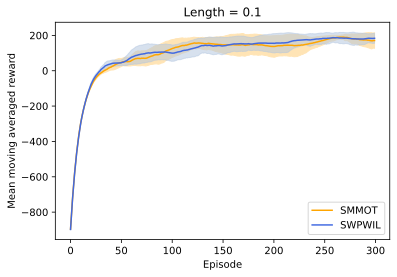

In [19]:
plt.plot([r.ep for r in training_record_multi_l_1_7_seed10], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in training_record_multi_l_1_7_seed10],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in training_record_multi_l_1_7_seed10], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in training_record_multi_l_1_7_seed10],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['SMMOT', 'SWPWIL'])
plt.title('Length = 0.1')
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_unique_len_1_7_%s.png"%environment)
plt.show()

#### Length = 1.2

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 191
    training_record_multi_l_1_2_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -805.0 score of current env 32.0
Ep 2 Average score: -722.1 score of current env 24.0
Ep 3 Average score: -647.09 score of current env 28.0
Ep 4 Average score: -578.681 score of current env 37.0
Ep 5 Average score: -517.8129 score of current env 30.0
Ep 6 Average score: -463.03161 score of current env 30.0
Ep 7 Average score: -414.32844900000003 score of current env 24.0
Ep 8 Average score: -370.6956041 score of current env 22.0
Ep 9 Average score: -329.02604369 score of current env 46.0
Ep 10 Average score: -292.623439321 score of current env 35.0
Ep 11 Average score: -262.36109538889997 score of current env 10.0
Ep 12 Average score: -233.92498585001 score of current env 22.0
Ep 13 Average score: -207.832487265009 score of current env 27.0
Ep 14 Average score: -183.7492385385081 score of current env 33.0
Ep 15 Average score: -160.4743146846573 score of current env 49.0
Ep 16 Average score: -141.22688321619157 sco

Ep 125 Average score: 199.48704558659824 score of current env 200.0
Ep 126 Average score: 199.53834102793843 score of current env 200.0
Ep 127 Average score: 199.58450692514458 score of current env 200.0
Ep 128 Average score: 199.62605623263013 score of current env 200.0
Ep 129 Average score: 199.66345060936712 score of current env 200.0
Ep 130 Average score: 199.69710554843041 score of current env 200.0
Ep 131 Average score: 199.72739499358738 score of current env 200.0
Ep 132 Average score: 199.75465549422864 score of current env 200.0
Ep 133 Average score: 199.77918994480578 score of current env 200.0
Ep 134 Average score: 199.8012709503252 score of current env 200.0
Ep 135 Average score: 199.8211438552927 score of current env 200.0
Ep 136 Average score: 199.83902946976343 score of current env 200.0
Ep 137 Average score: 199.8551265227871 score of current env 200.0
Ep 138 Average score: 199.86961387050837 score of current env 200.0
Ep 139 Average score: 199.88265248345755 score of c

Ep 247 Average score: 199.99976250849173 score of current env 200.0
Ep 248 Average score: 199.99978625764257 score of current env 200.0
Ep 249 Average score: 199.99980763187833 score of current env 200.0
Ep 250 Average score: 199.9998268686905 score of current env 200.0
Ep 251 Average score: 199.99984418182146 score of current env 200.0
Ep 252 Average score: 199.9998597636393 score of current env 200.0
Ep 253 Average score: 199.9998737872754 score of current env 200.0
Ep 254 Average score: 199.99988640854787 score of current env 200.0
Ep 255 Average score: 199.99989776769308 score of current env 200.0
Ep 256 Average score: 199.9999079909238 score of current env 200.0
Ep 257 Average score: 199.9999171918314 score of current env 200.0
Ep 258 Average score: 199.99992547264827 score of current env 200.0
Ep 259 Average score: 199.99993292538346 score of current env 200.0
Ep 260 Average score: 199.99993963284513 score of current env 200.0
Ep 261 Average score: 199.99994566956062 score of cur

In [21]:
pickle.dump(training_record_multi_l_1_2_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed1_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 192
    training_record_multi_l_1_2_seed2= main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.5300000000001 score of current env 13.0
Ep 2 Average score: -724.777 score of current env 20.0
Ep 3 Average score: -649.8993 score of current env 24.0
Ep 4 Average score: -583.70937 score of current env 12.0
Ep 5 Average score: -523.238433 score of current env 21.0
Ep 6 Average score: -468.71458970000003 score of current env 22.0
Ep 7 Average score: -420.24313073 score of current env 16.0
Ep 8 Average score: -376.91881765700003 score of current env 13.0
Ep 9 Average score: -337.92693589130005 score of current env 13.0
Ep 10 Average score: -303.03424230217 score of current env 11.0
Ep 11 Average score: -271.730818071953 score of current env 10.0
Ep 12 Average score: -243.55773626475772 score of current env 10.0
Ep 13 Average score: -215.30196263828194 score of current env 39.0
Ep 14 Average score: -191.97176637445372 score of current env 18.0
Ep 15 Average score: -167.87458973700834 score of current env 49.0
E

Ep 125 Average score: 183.07774787870832 score of current env 200.0
Ep 126 Average score: 184.76997309083748 score of current env 200.0
Ep 127 Average score: 186.29297578175374 score of current env 200.0
Ep 128 Average score: 187.66367820357837 score of current env 200.0
Ep 129 Average score: 188.89731038322054 score of current env 200.0
Ep 130 Average score: 190.0075793448985 score of current env 200.0
Ep 131 Average score: 191.00682141040863 score of current env 200.0
Ep 132 Average score: 191.90613926936777 score of current env 200.0
Ep 133 Average score: 192.715525342431 score of current env 200.0
Ep 134 Average score: 193.4439728081879 score of current env 200.0
Ep 135 Average score: 194.09957552736913 score of current env 200.0
Ep 136 Average score: 194.68961797463223 score of current env 200.0
Ep 137 Average score: 195.22065617716902 score of current env 200.0
Ep 138 Average score: 195.69859055945213 score of current env 200.0
Ep 139 Average score: 196.1287315035069 score of cur

Ep 247 Average score: 199.99995573664668 score of current env 200.0
Ep 248 Average score: 199.999960162982 score of current env 200.0
Ep 249 Average score: 199.99996414668382 score of current env 200.0
Ep 250 Average score: 199.99996773201545 score of current env 200.0
Ep 251 Average score: 199.99997095881392 score of current env 200.0
Ep 252 Average score: 199.99997386293253 score of current env 200.0
Ep 253 Average score: 199.9999764766393 score of current env 200.0
Ep 254 Average score: 199.99997882897537 score of current env 200.0
Ep 255 Average score: 199.99998094607784 score of current env 200.0
Ep 256 Average score: 199.99998285147007 score of current env 200.0
Ep 257 Average score: 199.99998456632306 score of current env 200.0
Ep 258 Average score: 199.99998610969075 score of current env 200.0
Ep 259 Average score: 199.99998749872168 score of current env 200.0
Ep 260 Average score: 199.99998874884952 score of current env 200.0
Ep 261 Average score: 199.99998987396458 score of c

In [23]:
pickle.dump(training_record_multi_l_1_2_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed2_%s.pkl'%environment, 'wb' ))

In [24]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 193
    training_record_multi_l_1_2_seed3 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.6 score of current env 44.0
Ep 1 Average score: -804.94 score of current env 11.0
Ep 2 Average score: -722.046 score of current env 24.0
Ep 3 Average score: -646.7414 score of current env 31.0
Ep 4 Average score: -580.96726 score of current env 11.0
Ep 5 Average score: -520.970534 score of current env 19.0
Ep 6 Average score: -462.07348060000004 score of current env 68.0
Ep 7 Average score: -412.06613254 score of current env 38.0
Ep 8 Average score: -369.95951928600005 score of current env 9.0
Ep 9 Average score: -329.16356735740004 score of current env 38.0
Ep 10 Average score: -294.94721062166 score of current env 13.0
Ep 11 Average score: -264.45248955949404 score of current env 10.0
Ep 12 Average score: -235.40724060354464 score of current env 26.0
Ep 13 Average score: -210.8665165431902 score of current env 10.0
Ep 14 Average score: -187.97986488887116 score of current env 18.0
Ep 15 Average score: -161.78187839998404 score of current env 74.0
Ep 16 Averag

Ep 124 Average score: 199.86140456590385 score of current env 200.0
Ep 125 Average score: 199.87526410931346 score of current env 200.0
Ep 126 Average score: 199.88773769838213 score of current env 200.0
Ep 127 Average score: 199.8989639285439 score of current env 200.0
Ep 128 Average score: 199.90906753568953 score of current env 200.0
Ep 129 Average score: 199.9181607821206 score of current env 200.0
Ep 130 Average score: 199.92634470390854 score of current env 200.0
Ep 131 Average score: 199.9337102335177 score of current env 200.0
Ep 132 Average score: 199.94033921016594 score of current env 200.0
Ep 133 Average score: 199.94630528914936 score of current env 200.0
Ep 134 Average score: 199.95167476023443 score of current env 200.0
Ep 135 Average score: 199.956507284211 score of current env 200.0
Ep 136 Average score: 199.96085655578992 score of current env 200.0
Ep 137 Average score: 199.96477090021094 score of current env 200.0
Ep 138 Average score: 199.96829381018983 score of cur

Ep 245 Average score: 199.99999959719716 score of current env 200.0
Ep 246 Average score: 199.99999963747746 score of current env 200.0
Ep 247 Average score: 199.99999967372972 score of current env 200.0
Ep 248 Average score: 199.99999970635676 score of current env 200.0
Ep 249 Average score: 199.99999973572108 score of current env 200.0
Ep 250 Average score: 199.99999976214897 score of current env 200.0
Ep 251 Average score: 199.99999978593408 score of current env 200.0
Ep 252 Average score: 199.99999980734069 score of current env 200.0
Ep 253 Average score: 199.99999982660663 score of current env 200.0
Ep 254 Average score: 199.99999984394597 score of current env 200.0
Ep 255 Average score: 199.99999985955137 score of current env 200.0
Ep 256 Average score: 199.99999987359624 score of current env 200.0
Ep 257 Average score: 199.99999988623662 score of current env 200.0
Ep 258 Average score: 199.99999989761295 score of current env 200.0
Ep 259 Average score: 199.99999990785167 score o

In [25]:
pickle.dump(training_record_multi_l_1_2_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed3_%s.pkl'%environment, 'wb' ))

In [26]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 194
    training_record_multi_l_1_2_seed4 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.7 score of current env 23.0
Ep 1 Average score: -806.4300000000001 score of current env 15.0
Ep 2 Average score: -723.8870000000001 score of current env 19.0
Ep 3 Average score: -649.2983 score of current env 22.0
Ep 4 Average score: -582.56847 score of current env 18.0
Ep 5 Average score: -522.811623 score of current env 15.0
Ep 6 Average score: -468.13046070000007 score of current env 24.0
Ep 7 Average score: -419.71741463000006 score of current env 16.0
Ep 8 Average score: -372.8456731670001 score of current env 49.0
Ep 9 Average score: -333.46110585030004 score of current env 21.0
Ep 10 Average score: -298.61499526527007 score of current env 15.0
Ep 11 Average score: -267.7534957387431 score of current env 10.0
Ep 12 Average score: -239.57814616486877 score of current env 14.0
Ep 13 Average score: -210.9203315483819 score of current env 47.0
Ep 14 Average score: -187.0282983935437 score of current env 28.0
Ep 15 Average score: -166.52546855418933 score of c

Ep 125 Average score: 166.19340756940937 score of current env 200.0
Ep 126 Average score: 169.57406681246843 score of current env 200.0
Ep 127 Average score: 172.61666013122158 score of current env 200.0
Ep 128 Average score: 175.35499411809943 score of current env 200.0
Ep 129 Average score: 177.81949470628948 score of current env 200.0
Ep 130 Average score: 180.03754523566053 score of current env 200.0
Ep 131 Average score: 182.0337907120945 score of current env 200.0
Ep 132 Average score: 183.83041164088505 score of current env 200.0
Ep 133 Average score: 185.44737047679655 score of current env 200.0
Ep 134 Average score: 186.9026334291169 score of current env 200.0
Ep 135 Average score: 188.2123700862052 score of current env 200.0
Ep 136 Average score: 189.39113307758467 score of current env 200.0
Ep 137 Average score: 190.4520197698262 score of current env 200.0
Ep 138 Average score: 191.40681779284358 score of current env 200.0
Ep 139 Average score: 192.26613601355922 score of cu

Ep 247 Average score: 199.99991157245879 score of current env 200.0
Ep 248 Average score: 199.9999204152129 score of current env 200.0
Ep 249 Average score: 199.9999283736916 score of current env 200.0
Ep 250 Average score: 199.99993553632245 score of current env 200.0
Ep 251 Average score: 199.99994198269022 score of current env 200.0
Ep 252 Average score: 199.9999477844212 score of current env 200.0
Ep 253 Average score: 199.99995300597908 score of current env 200.0
Ep 254 Average score: 199.99995770538118 score of current env 200.0
Ep 255 Average score: 199.99996193484307 score of current env 200.0
Ep 256 Average score: 199.99996574135878 score of current env 200.0
Ep 257 Average score: 199.9999691672229 score of current env 200.0
Ep 258 Average score: 199.9999722505006 score of current env 200.0
Ep 259 Average score: 199.99997502545054 score of current env 200.0
Ep 260 Average score: 199.99997752290548 score of current env 200.0
Ep 261 Average score: 199.99997977061494 score of cur

In [27]:
pickle.dump(training_record_multi_l_1_2_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed4_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 195
    training_record_multi_l_1_2_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -895.5 score of current env 45.0
Ep 1 Average score: -804.6500000000001 score of current env 13.0
Ep 2 Average score: -721.6850000000001 score of current env 25.0
Ep 3 Average score: -645.4165 score of current env 41.0
Ep 4 Average score: -579.27485 score of current env 16.0
Ep 5 Average score: -520.147365 score of current env 12.0
Ep 6 Average score: -466.63262850000007 score of current env 15.0
Ep 7 Average score: -418.16936565000003 score of current env 18.0
Ep 8 Average score: -374.95242908500006 score of current env 14.0
Ep 9 Average score: -336.15718617650003 score of current env 13.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -300.94146755885004 score of current env 16.0
Ep 11 Average score: -269.84732080296504 score of current env 10.0
Ep 12 Average score: -241.86258872266853 score of current env 10.0
Ep 13 Average score: -216.6763298504017 score of current env 10.0
Ep 14 Average score: -193.2086968653615 score of current env 18.0
Ep 15 Average score: -171.98782717882534 score of current env 19.0
Ep 16 Average score: -152.08904446094283 score of current env 27.0
Ep 17 Average score: -134.48014001484856 score of current env 24.0
Ep 18 Average score: -116.8321260133637 score of current env 42.0
Ep 19 Average score: -101.34891341202734 score of current env 38.0
Ep 20 Average score: -83.21402207082461 score of current env 80.0
Ep 21 Average score: -65.99261986374215 score of current env 89.0
Ep 22 Average score: -54.89335787736793 score of current env 45.0
Ep 23 Average score: -44.70402208963114 score of current env 47.0
Ep 24 Average score: -35.53361988066802 score of current env 47.0
Ep 

Ep 134 Average score: 199.911176533337 score of current env 200.0
Ep 135 Average score: 199.9200588800033 score of current env 200.0
Ep 136 Average score: 199.92805299200296 score of current env 200.0
Ep 137 Average score: 199.93524769280268 score of current env 200.0
Ep 138 Average score: 199.9417229235224 score of current env 200.0
Ep 139 Average score: 199.94755063117017 score of current env 200.0
Ep 140 Average score: 199.95279556805315 score of current env 200.0
Ep 141 Average score: 199.95751601124783 score of current env 200.0
Ep 142 Average score: 199.96176441012307 score of current env 200.0
Ep 143 Average score: 199.96558796911077 score of current env 200.0
Ep 144 Average score: 199.9690291721997 score of current env 200.0
Ep 145 Average score: 199.97212625497974 score of current env 200.0
Ep 146 Average score: 199.97491362948176 score of current env 200.0
Ep 147 Average score: 199.97742226653358 score of current env 200.0
Ep 148 Average score: 199.97968003988024 score of cur

Ep 256 Average score: 199.99999976766546 score of current env 200.0
Ep 257 Average score: 199.99999979089893 score of current env 200.0
Ep 258 Average score: 199.99999981180903 score of current env 200.0
Ep 259 Average score: 199.99999983062813 score of current env 200.0
Ep 260 Average score: 199.9999998475653 score of current env 200.0
Ep 261 Average score: 199.99999986280878 score of current env 200.0
Ep 262 Average score: 199.9999998765279 score of current env 200.0
Ep 263 Average score: 199.99999988887512 score of current env 200.0
Ep 264 Average score: 199.9999998999876 score of current env 200.0
Ep 265 Average score: 199.99999990998884 score of current env 200.0
Ep 266 Average score: 199.99999991898997 score of current env 200.0
Ep 267 Average score: 199.99999992709098 score of current env 200.0
Ep 268 Average score: 199.9999999343819 score of current env 200.0
Ep 269 Average score: 199.9999999409437 score of current env 200.0
Ep 270 Average score: 199.99999994684933 score of cur

In [7]:
pickle.dump(training_record_multi_l_1_2_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed5_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 196
    training_record_multi_l_1_2_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -802.0300000000001 score of current env 68.0
Ep 2 Average score: -718.6270000000001 score of current env 32.0
Ep 3 Average score: -643.6643 score of current env 31.0
Ep 4 Average score: -578.09787 score of current env 12.0
Ep 5 Average score: -512.488083 score of current env 78.0
Ep 6 Average score: -457.53927469999996 score of current env 37.0
Ep 7 Average score: -409.38534723 score of current env 24.0
Ep 8 Average score: -364.746812507 score of current env 37.0
Ep 9 Average score: -325.87213125630007 score of current env 24.0
Ep 10 Average score: -290.48491813067005 score of current env 28.0
Ep 11 Average score: -260.43642631760304 score of current env 10.0
Ep 12 Average score: -232.59278368584273 score of current env 18.0
Ep 13 Average score: -208.43350531725847 score of current env 9.0
Ep 14 Average score: -185.49015478553264 score of current env 21.0
Ep 15 Average score: -163.14113930697937 score of current e

Ep 124 Average score: 199.72169797707414 score of current env 200.0
Ep 125 Average score: 199.74952817936673 score of current env 200.0
Ep 126 Average score: 199.77457536143007 score of current env 200.0
Ep 127 Average score: 199.79711782528707 score of current env 200.0
Ep 128 Average score: 199.81740604275836 score of current env 200.0
Ep 129 Average score: 199.83566543848252 score of current env 200.0
Ep 130 Average score: 199.85209889463428 score of current env 200.0
Ep 131 Average score: 199.86688900517086 score of current env 200.0
Ep 132 Average score: 199.88020010465377 score of current env 200.0
Ep 133 Average score: 199.8921800941884 score of current env 200.0
Ep 134 Average score: 199.90296208476957 score of current env 200.0
Ep 135 Average score: 199.9126658762926 score of current env 200.0
Ep 136 Average score: 199.92139928866334 score of current env 200.0
Ep 137 Average score: 199.92925935979702 score of current env 200.0
Ep 138 Average score: 199.93633342381733 score of 

Ep 245 Average score: 199.99999919116493 score of current env 200.0
Ep 246 Average score: 199.99999927204846 score of current env 200.0
Ep 247 Average score: 199.99999934484362 score of current env 200.0
Ep 248 Average score: 199.99999941035927 score of current env 200.0
Ep 249 Average score: 199.99999946932334 score of current env 200.0
Ep 250 Average score: 199.99999952239102 score of current env 200.0
Ep 251 Average score: 199.9999995701519 score of current env 200.0
Ep 252 Average score: 199.99999961313674 score of current env 200.0
Ep 253 Average score: 199.99999965182306 score of current env 200.0
Ep 254 Average score: 199.99999968664076 score of current env 200.0
Ep 255 Average score: 199.9999997179767 score of current env 200.0
Ep 256 Average score: 199.99999974617901 score of current env 200.0
Ep 257 Average score: 199.9999997715611 score of current env 200.0
Ep 258 Average score: 199.999999794405 score of current env 200.0
Ep 259 Average score: 199.9999998149645 score of curr

In [9]:
pickle.dump(training_record_multi_l_1_2_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed6_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 197
    training_record_multi_l_1_2_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -895.7 score of current env 43.0
Ep 1 Average score: -802.3300000000002 score of current env 38.0
Ep 2 Average score: -720.3970000000002 score of current env 17.0
Ep 3 Average score: -646.2573000000001 score of current env 21.0
Ep 4 Average score: -578.8315700000002 score of current env 28.0
Ep 5 Average score: -518.2484130000001 score of current env 27.0
Ep 6 Average score: -464.92357170000014 score of current env 15.0
Ep 7 Average score: -416.53121453000017 score of current env 19.0
Ep 8 Average score: -372.6780930770002 score of current env 22.0
Ep 9 Average score: -333.61028376930017 score of current env 18.0
Ep 10 Average score: -296.64925539237015 score of current env 36.0
Ep 11 Average score: -265.8843298531331 score of current env 11.0
Ep 12 Average score: -233.2958968678198 score of current env 60.0
Ep 13 Average score: -209.0663071810378 score of current env 9.0
Ep 14 Average score: -182.35967646293403 score of current env 58.0
Ep 15 Average score: -160.52

Ep 124 Average score: 199.93109464222115 score of current env 200.0
Ep 125 Average score: 199.93798517799905 score of current env 200.0
Ep 126 Average score: 199.94418666019916 score of current env 200.0
Ep 127 Average score: 199.94976799417924 score of current env 200.0
Ep 128 Average score: 199.95479119476133 score of current env 200.0
Ep 129 Average score: 199.9593120752852 score of current env 200.0
Ep 130 Average score: 199.96338086775668 score of current env 200.0
Ep 131 Average score: 199.96704278098102 score of current env 200.0
Ep 132 Average score: 199.97033850288292 score of current env 200.0
Ep 133 Average score: 199.97330465259463 score of current env 200.0
Ep 134 Average score: 199.97597418733517 score of current env 200.0
Ep 135 Average score: 199.97837676860166 score of current env 200.0
Ep 136 Average score: 199.9805390917415 score of current env 200.0
Ep 137 Average score: 199.98248518256736 score of current env 200.0
Ep 138 Average score: 199.98423666431063 score of 

Ep 245 Average score: 199.99999979973893 score of current env 200.0
Ep 246 Average score: 199.99999981976504 score of current env 200.0
Ep 247 Average score: 199.99999983778855 score of current env 200.0
Ep 248 Average score: 199.9999998540097 score of current env 200.0
Ep 249 Average score: 199.99999986860874 score of current env 200.0
Ep 250 Average score: 199.99999988174787 score of current env 200.0
Ep 251 Average score: 199.9999998935731 score of current env 200.0
Ep 252 Average score: 199.9999999042158 score of current env 200.0
Ep 253 Average score: 199.99999991379423 score of current env 200.0
Ep 254 Average score: 199.99999992241482 score of current env 200.0
Ep 255 Average score: 199.99999993017335 score of current env 200.0
Ep 256 Average score: 199.99999993715602 score of current env 200.0
Ep 257 Average score: 199.99999994344043 score of current env 200.0
Ep 258 Average score: 199.99999994909638 score of current env 200.0
Ep 259 Average score: 199.99999995418673 score of c

In [11]:
pickle.dump(training_record_multi_l_1_2_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed7_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 198
    training_record_multi_l_1_2_seed8 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -804.84 score of current env 39.0
Ep 2 Average score: -721.356 score of current env 30.0
Ep 3 Average score: -648.1204 score of current env 11.0
Ep 4 Average score: -582.00836 score of current env 13.0
Ep 5 Average score: -521.9075240000001 score of current env 19.0
Ep 6 Average score: -467.7167716000001 score of current env 20.0
Ep 7 Average score: -417.14509444000004 score of current env 38.0
Ep 8 Average score: -369.0305849960001 score of current env 64.0
Ep 9 Average score: -329.3275264964001 score of current env 28.0
Ep 10 Average score: -295.1947738467601 score of current env 12.0
Ep 11 Average score: -264.4752964620841 score of current env 12.0
Ep 12 Average score: -235.72776681587567 score of current env 23.0
Ep 13 Average score: -209.95499013428812 score of current env 22.0
Ep 14 Average score: -183.75949112085934 score of current env 52.0
Ep 15 Average score: -163.38354200877342 score of current env 20.0

Ep 125 Average score: 197.9838092815502 score of current env 200.0
Ep 126 Average score: 198.1854283533952 score of current env 200.0
Ep 127 Average score: 198.36688551805568 score of current env 200.0
Ep 128 Average score: 198.53019696625012 score of current env 200.0
Ep 129 Average score: 198.6771772696251 score of current env 200.0
Ep 130 Average score: 198.8094595426626 score of current env 200.0
Ep 131 Average score: 198.92851358839636 score of current env 200.0
Ep 132 Average score: 199.03566222955672 score of current env 200.0
Ep 133 Average score: 199.13209600660105 score of current env 200.0
Ep 134 Average score: 199.21888640594094 score of current env 200.0
Ep 135 Average score: 199.29699776534684 score of current env 200.0
Ep 136 Average score: 199.36729798881217 score of current env 200.0
Ep 137 Average score: 199.43056818993097 score of current env 200.0
Ep 138 Average score: 199.48751137093788 score of current env 200.0
Ep 139 Average score: 199.5387602338441 score of cur

Ep 246 Average score: 199.99999414030177 score of current env 200.0
Ep 247 Average score: 199.99999472627158 score of current env 200.0
Ep 248 Average score: 199.9999952536444 score of current env 200.0
Ep 249 Average score: 199.99999572827997 score of current env 200.0
Ep 250 Average score: 199.99999615545198 score of current env 200.0
Ep 251 Average score: 199.9999965399068 score of current env 200.0
Ep 252 Average score: 199.99999688591612 score of current env 200.0
Ep 253 Average score: 199.99999719732452 score of current env 200.0
Ep 254 Average score: 199.99999747759207 score of current env 200.0
Ep 255 Average score: 199.99999772983287 score of current env 200.0
Ep 256 Average score: 199.9999979568496 score of current env 200.0
Ep 257 Average score: 199.99999816116465 score of current env 200.0
Ep 258 Average score: 199.9999983450482 score of current env 200.0
Ep 259 Average score: 199.99999851054338 score of current env 200.0
Ep 260 Average score: 199.99999865948905 score of cu

In [13]:
pickle.dump(training_record_multi_l_1_2_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed8_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 199
    training_record_multi_l_1_2_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.9 score of current env 31.0
Ep 1 Average score: -805.71 score of current env 15.0
Ep 2 Average score: -722.339 score of current env 28.0
Ep 3 Average score: -642.5051000000001 score of current env 76.0
Ep 4 Average score: -577.1545900000001 score of current env 11.0
Ep 5 Average score: -517.6391310000001 score of current env 18.0
Ep 6 Average score: -464.0752179000001 score of current env 18.0
Ep 7 Average score: -416.0676961100001 score of current env 16.0
Ep 8 Average score: -368.9609264990001 score of current env 55.0
Ep 9 Average score: -330.6648338491001 score of current env 14.0
Ep 10 Average score: -293.1983504641901 score of current env 44.0
Ep 11 Average score: -262.7785154177711 score of current env 11.0
Ep 12 Average score: -235.40066387599398 score of current env 11.0
Ep 13 Average score: -209.8605974883946 score of current env 20.0
Ep 14 Average score: -184.87453773955514 score of current env 40.0
Ep 15 Average score: -163.58708396559962 score of c

Ep 125 Average score: 199.8408408537041 score of current env 200.0
Ep 126 Average score: 199.8567567683337 score of current env 200.0
Ep 127 Average score: 199.87108109150034 score of current env 200.0
Ep 128 Average score: 199.88397298235031 score of current env 200.0
Ep 129 Average score: 199.8955756841153 score of current env 200.0
Ep 130 Average score: 199.90601811570377 score of current env 200.0
Ep 131 Average score: 199.9154163041334 score of current env 200.0
Ep 132 Average score: 199.92387467372006 score of current env 200.0
Ep 133 Average score: 199.93148720634807 score of current env 200.0
Ep 134 Average score: 199.93833848571327 score of current env 200.0
Ep 135 Average score: 199.94450463714196 score of current env 200.0
Ep 136 Average score: 199.95005417342776 score of current env 200.0
Ep 137 Average score: 199.95504875608498 score of current env 200.0
Ep 138 Average score: 199.95954388047647 score of current env 200.0
Ep 139 Average score: 199.96358949242884 score of cu

Ep 246 Average score: 199.99999953743242 score of current env 200.0
Ep 247 Average score: 199.99999958368917 score of current env 200.0
Ep 248 Average score: 199.99999962532027 score of current env 200.0
Ep 249 Average score: 199.99999966278824 score of current env 200.0
Ep 250 Average score: 199.99999969650943 score of current env 200.0
Ep 251 Average score: 199.9999997268585 score of current env 200.0
Ep 252 Average score: 199.99999975417265 score of current env 200.0
Ep 253 Average score: 199.99999977875538 score of current env 200.0
Ep 254 Average score: 199.99999980087983 score of current env 200.0
Ep 255 Average score: 199.99999982079186 score of current env 200.0
Ep 256 Average score: 199.99999983871268 score of current env 200.0
Ep 257 Average score: 199.9999998548414 score of current env 200.0
Ep 258 Average score: 199.99999986935728 score of current env 200.0
Ep 259 Average score: 199.99999988242155 score of current env 200.0
Ep 260 Average score: 199.9999998941794 score of c

In [15]:
pickle.dump(training_record_multi_l_1_2_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed9_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1100
    training_record_multi_l_1_2_seed10 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.7800000000001 score of current env 16.0
Ep 2 Average score: -724.3020000000001 score of current env 18.0
Ep 3 Average score: -650.8718000000001 score of current env 10.0
Ep 4 Average score: -582.7846200000001 score of current env 30.0
Ep 5 Average score: -523.4061580000001 score of current env 11.0
Ep 6 Average score: -469.6655422000001 score of current env 14.0
Ep 7 Average score: -421.69898798000014 score of current env 10.0
Ep 8 Average score: -377.32908918200013 score of current env 22.0
Ep 9 Average score: -337.39618026380015 score of current env 22.0
Ep 10 Average score: -302.0565622374201 score of current env 16.0
Ep 11 Average score: -269.5509060136781 score of current env 23.0
Ep 12 Average score: -241.59581541231032 score of current env 10.0
Ep 13 Average score: -216.53623387107928 score of current env 9.0
Ep 14 Average score: -191.78261048397135 score of current env 31.0
Ep 15 Average score: -166.8

Ep 123 Average score: 198.27631592200063 score of current env 200.0
Ep 124 Average score: 198.44868432980059 score of current env 200.0
Ep 125 Average score: 198.60381589682052 score of current env 200.0
Ep 126 Average score: 198.74343430713847 score of current env 200.0
Ep 127 Average score: 198.86909087642462 score of current env 200.0
Ep 128 Average score: 198.98218178878216 score of current env 200.0
Ep 129 Average score: 199.08396360990395 score of current env 200.0
Ep 130 Average score: 199.17556724891355 score of current env 200.0
Ep 131 Average score: 199.2580105240222 score of current env 200.0
Ep 132 Average score: 199.33220947162 score of current env 200.0
Ep 133 Average score: 199.398988524458 score of current env 200.0
Ep 134 Average score: 199.4590896720122 score of current env 200.0
Ep 135 Average score: 199.513180704811 score of current env 200.0
Ep 136 Average score: 199.56186263432988 score of current env 200.0
Ep 137 Average score: 199.6056763708969 score of current 

Ep 245 Average score: 199.9999954913781 score of current env 200.0
Ep 246 Average score: 199.99999594224028 score of current env 200.0
Ep 247 Average score: 199.99999634801625 score of current env 200.0
Ep 248 Average score: 199.99999671321464 score of current env 200.0
Ep 249 Average score: 199.99999704189318 score of current env 200.0
Ep 250 Average score: 199.99999733770386 score of current env 200.0
Ep 251 Average score: 199.99999760393348 score of current env 200.0
Ep 252 Average score: 199.99999784354014 score of current env 200.0
Ep 253 Average score: 199.99999805918614 score of current env 200.0
Ep 254 Average score: 199.99999825326753 score of current env 200.0
Ep 255 Average score: 199.9999984279408 score of current env 200.0
Ep 256 Average score: 199.99999858514673 score of current env 200.0
Ep 257 Average score: 199.99999872663207 score of current env 200.0
Ep 258 Average score: 199.99999885396886 score of current env 200.0
Ep 259 Average score: 199.999998968572 score of cu

In [17]:
pickle.dump(training_record_multi_l_1_2_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed10_%s.pkl'%environment, 'wb' ))

In [11]:
mmottraining_record_multi_l_1_2_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed1_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed2_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed3_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed4_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed5_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed6_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed7_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed8_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed9_%s.pkl'%environment,'rb' ))
mmottraining_record_multi_l_1_2_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_record_multi_l_1_2_seed10_%s.pkl'%environment,'rb' ))



l1_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed1]
l2_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed2]
l3_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed3]
l4_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed4]
l5_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed5]
l6_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed6]
l7_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed7]
l8_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed8]
l9_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed9]
l10_simple = [r.reward for r in mmottraining_record_multi_l_1_2_seed10]

In [12]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]
std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1911
    training_record_multi_l_1_2_seed1 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -804.04 score of current env 47.0
Ep 2 Average score: -721.136 score of current env 25.0
Ep 3 Average score: -647.9223999999999 score of current env 11.0
Ep 4 Average score: -579.23016 score of current env 39.0
Ep 5 Average score: -520.107144 score of current env 12.0
Ep 6 Average score: -466.3964296 score of current env 17.0
Ep 7 Average score: -418.55678664 score of current env 12.0
Ep 8 Average score: -374.201107976 score of current env 25.0
Ep 9 Average score: -335.1809971784 score of current env 16.0
Ep 10 Average score: -295.96289746056 score of current env 57.0
Ep 11 Average score: -265.466607714504 score of current env 9.0
Ep 12 Average score: -236.3199469430536 score of current env 26.0
Ep 13 Average score: -210.88795224874823 score of current env 18.0
Ep 14 Average score: -188.09915702387343 score of current env 17.0
Ep 15 Average score: -166.5892413214861 score of current env 27.0
Ep 16 Average score: -

Ep 127 Average score: 58.47225904715321 score of current env 23.0
Ep 128 Average score: 55.72503314243789 score of current env 31.0
Ep 129 Average score: 64.8525298281941 score of current env 147.0
Ep 130 Average score: 69.06727684537468 score of current env 107.0
Ep 131 Average score: 66.36054916083721 score of current env 42.0
Ep 132 Average score: 69.32449424475348 score of current env 96.0
Ep 133 Average score: 68.59204482027813 score of current env 62.0
Ep 134 Average score: 69.13284033825032 score of current env 74.0
Ep 135 Average score: 64.41955630442529 score of current env 22.0
Ep 136 Average score: 77.97760067398275 score of current env 200.0
Ep 137 Average score: 75.07984060658448 score of current env 49.0
Ep 138 Average score: 74.37185654592604 score of current env 68.0
Ep 139 Average score: 71.33467089133345 score of current env 44.0
Ep 140 Average score: 71.1012038022001 score of current env 69.0
Ep 141 Average score: 69.59108342198009 score of current env 56.0
Ep 142 Av

Ep 250 Average score: 197.06624303226002 score of current env 200.0
Ep 251 Average score: 197.35961872903403 score of current env 200.0
Ep 252 Average score: 197.62365685613062 score of current env 200.0
Ep 253 Average score: 197.86129117051757 score of current env 200.0
Ep 254 Average score: 198.07516205346582 score of current env 200.0
Ep 255 Average score: 198.26764584811923 score of current env 200.0
Ep 256 Average score: 198.44088126330732 score of current env 200.0
Ep 257 Average score: 198.5967931369766 score of current env 200.0
Ep 258 Average score: 198.73711382327895 score of current env 200.0
Ep 259 Average score: 198.86340244095106 score of current env 200.0
Ep 260 Average score: 198.97706219685597 score of current env 200.0
Ep 261 Average score: 199.07935597717037 score of current env 200.0
Ep 262 Average score: 199.17142037945334 score of current env 200.0
Ep 263 Average score: 199.254278341508 score of current env 200.0
Ep 264 Average score: 199.3288505073572 score of cu

In [21]:
pickle.dump(training_record_multi_l_1_2_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed1_%s.pkl'%environment, 'wb' ))

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1921
    training_record_multi_l_1_2_seed2= main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.1 score of current env 49.0
Ep 1 Average score: -802.69 score of current env 29.0
Ep 2 Average score: -718.821 score of current env 36.0
Ep 3 Average score: -644.1389 score of current env 28.0
Ep 4 Average score: -578.32501 score of current env 14.0
Ep 5 Average score: -518.892509 score of current env 16.0
Ep 6 Average score: -465.60325810000006 score of current env 14.0
Ep 7 Average score: -412.54293229000007 score of current env 65.0
Ep 8 Average score: -367.2886390610001 score of current env 40.0
Ep 9 Average score: -329.0597751549001 score of current env 15.0
Ep 10 Average score: -294.7537976394101 score of current env 14.0
Ep 11 Average score: -263.97841787546906 score of current env 13.0
Ep 12 Average score: -235.68057608792216 score of current env 19.0
Ep 13 Average score: -210.71251847912995 score of current env 14.0
Ep 14 Average score: -187.04126663121696 score of current env 26.0
Ep 15 Average score: -160.93713996809527 score of current env 74.0
Ep 1

Ep 125 Average score: 199.8140477618937 score of current env 200.0
Ep 126 Average score: 199.83264298570433 score of current env 200.0
Ep 127 Average score: 199.8493786871339 score of current env 200.0
Ep 128 Average score: 199.86444081842052 score of current env 200.0
Ep 129 Average score: 199.87799673657847 score of current env 200.0
Ep 130 Average score: 199.89019706292063 score of current env 200.0
Ep 131 Average score: 199.90117735662858 score of current env 200.0
Ep 132 Average score: 199.91105962096572 score of current env 200.0
Ep 133 Average score: 199.91995365886916 score of current env 200.0
Ep 134 Average score: 199.92795829298225 score of current env 200.0
Ep 135 Average score: 199.93516246368404 score of current env 200.0
Ep 136 Average score: 199.94164621731565 score of current env 200.0
Ep 137 Average score: 199.9474815955841 score of current env 200.0
Ep 138 Average score: 199.95273343602568 score of current env 200.0
Ep 139 Average score: 199.9574600924231 score of cu

Ep 246 Average score: 199.9999994595631 score of current env 200.0
Ep 247 Average score: 199.99999951360678 score of current env 200.0
Ep 248 Average score: 199.9999995622461 score of current env 200.0
Ep 249 Average score: 199.9999996060215 score of current env 200.0
Ep 250 Average score: 199.99999964541936 score of current env 200.0
Ep 251 Average score: 199.99999968087744 score of current env 200.0
Ep 252 Average score: 199.9999997127897 score of current env 200.0
Ep 253 Average score: 199.99999974151075 score of current env 200.0
Ep 254 Average score: 199.99999976735967 score of current env 200.0
Ep 255 Average score: 199.99999979062372 score of current env 200.0
Ep 256 Average score: 199.99999981156134 score of current env 200.0
Ep 257 Average score: 199.99999983040522 score of current env 200.0
Ep 258 Average score: 199.9999998473647 score of current env 200.0
Ep 259 Average score: 199.99999986262824 score of current env 200.0
Ep 260 Average score: 199.99999987636542 score of cur

In [23]:
pickle.dump(training_record_multi_l_1_2_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed2_%s.pkl'%environment, 'wb' ))

In [24]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1931
    training_record_multi_l_1_2_seed3 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -804.3000000000001 score of current env 39.0
Ep 2 Average score: -722.8700000000001 score of current env 10.0
Ep 3 Average score: -649.383 score of current env 12.0
Ep 4 Average score: -582.3447 score of current env 21.0
Ep 5 Average score: -521.41023 score of current env 27.0
Ep 6 Average score: -466.869207 score of current env 24.0
Ep 7 Average score: -418.5822863 score of current env 16.0
Ep 8 Average score: -374.92405767 score of current env 18.0
Ep 9 Average score: -336.23165190300006 score of current env 12.0
Ep 10 Average score: -300.3084867127001 score of current env 23.0
Ep 11 Average score: -266.0776380414301 score of current env 42.0
Ep 12 Average score: -238.3698742372871 score of current env 11.0
Ep 13 Average score: -212.53288681355838 score of current env 20.0
Ep 14 Average score: -187.77959813220255 score of current env 35.0
Ep 15 Average score: -166.70163831898228 score of current env 23.0
Ep 16 A

Ep 124 Average score: 199.90541909148104 score of current env 200.0
Ep 125 Average score: 199.91487718233293 score of current env 200.0
Ep 126 Average score: 199.92338946409964 score of current env 200.0
Ep 127 Average score: 199.93105051768967 score of current env 200.0
Ep 128 Average score: 199.9379454659207 score of current env 200.0
Ep 129 Average score: 199.94415091932865 score of current env 200.0
Ep 130 Average score: 199.94973582739578 score of current env 200.0
Ep 131 Average score: 199.95476224465622 score of current env 200.0
Ep 132 Average score: 199.9592860201906 score of current env 200.0
Ep 133 Average score: 199.96335741817154 score of current env 200.0
Ep 134 Average score: 199.9670216763544 score of current env 200.0
Ep 135 Average score: 199.97031950871894 score of current env 200.0
Ep 136 Average score: 199.97328755784704 score of current env 200.0
Ep 137 Average score: 199.97595880206234 score of current env 200.0
Ep 138 Average score: 199.9783629218561 score of cu

Ep 245 Average score: 199.99999972511753 score of current env 200.0
Ep 246 Average score: 199.9999997526058 score of current env 200.0
Ep 247 Average score: 199.9999997773452 score of current env 200.0
Ep 248 Average score: 199.9999997996107 score of current env 200.0
Ep 249 Average score: 199.99999981964962 score of current env 200.0
Ep 250 Average score: 199.99999983768467 score of current env 200.0
Ep 251 Average score: 199.9999998539162 score of current env 200.0
Ep 252 Average score: 199.99999986852458 score of current env 200.0
Ep 253 Average score: 199.99999988167212 score of current env 200.0
Ep 254 Average score: 199.9999998935049 score of current env 200.0
Ep 255 Average score: 199.9999999041544 score of current env 200.0
Ep 256 Average score: 199.99999991373898 score of current env 200.0
Ep 257 Average score: 199.99999992236508 score of current env 200.0
Ep 258 Average score: 199.99999993012858 score of current env 200.0
Ep 259 Average score: 199.99999993711572 score of curr

In [25]:
pickle.dump(training_record_multi_l_1_2_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed3_%s.pkl'%environment, 'wb' ))

In [26]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1941
    training_record_multi_l_1_2_seed4 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -807.14 score of current env 16.0
Ep 2 Average score: -725.1260000000001 score of current env 13.0
Ep 3 Average score: -651.0134 score of current env 16.0
Ep 4 Average score: -584.4120600000001 score of current env 15.0
Ep 5 Average score: -524.3708540000001 score of current env 16.0
Ep 6 Average score: -470.8337686000001 score of current env 11.0
Ep 7 Average score: -421.9503917400001 score of current env 18.0
Ep 8 Average score: -378.6553525660001 score of current env 11.0
Ep 9 Average score: -338.48981730940005 score of current env 23.0
Ep 10 Average score: -302.64083557846004 score of current env 20.0
Ep 11 Average score: -271.4767520206141 score of current env 9.0
Ep 12 Average score: -243.22907681855267 score of current env 11.0
Ep 13 Average score: -217.9061691366974 score of current env 10.0
Ep 14 Average score: -193.91555222302767 score of current env 22.0
Ep 15 Average score: -173.2239970007249 score of 

Ep 125 Average score: 170.53891997803083 score of current env 190.0
Ep 126 Average score: 171.48502798022776 score of current env 180.0
Ep 127 Average score: 173.93652518220497 score of current env 196.0
Ep 128 Average score: 174.84287266398448 score of current env 183.0
Ep 129 Average score: 176.85858539758604 score of current env 195.0
Ep 130 Average score: 176.87272685782742 score of current env 177.0
Ep 131 Average score: 178.68545417204467 score of current env 195.0
Ep 132 Average score: 180.1169087548402 score of current env 193.0
Ep 133 Average score: 182.1052178793562 score of current env 200.0
Ep 134 Average score: 183.89469609142057 score of current env 200.0
Ep 135 Average score: 185.50522648227852 score of current env 200.0
Ep 136 Average score: 186.95470383405066 score of current env 200.0
Ep 137 Average score: 188.2592334506456 score of current env 200.0
Ep 138 Average score: 189.43331010558106 score of current env 200.0
Ep 139 Average score: 190.48997909502296 score of c

Ep 247 Average score: 199.99989126421585 score of current env 200.0
Ep 248 Average score: 199.99990213779427 score of current env 200.0
Ep 249 Average score: 199.99991192401484 score of current env 200.0
Ep 250 Average score: 199.99992073161337 score of current env 200.0
Ep 251 Average score: 199.99992865845203 score of current env 200.0
Ep 252 Average score: 199.99993579260683 score of current env 200.0
Ep 253 Average score: 199.99994221334615 score of current env 200.0
Ep 254 Average score: 199.99994799201153 score of current env 200.0
Ep 255 Average score: 199.99995319281038 score of current env 200.0
Ep 256 Average score: 199.99995787352935 score of current env 200.0
Ep 257 Average score: 199.99996208617642 score of current env 200.0
Ep 258 Average score: 199.9999658775588 score of current env 200.0
Ep 259 Average score: 199.99996928980292 score of current env 200.0
Ep 260 Average score: 199.99997236082262 score of current env 200.0
Ep 261 Average score: 199.99997512474036 score of

In [27]:
pickle.dump(training_record_multi_l_1_2_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed4_%s.pkl'%environment, 'wb' ))

In [28]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1951
    training_record_multi_l_1_2_seed5 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -807.31 score of current env 17.0
Ep 2 Average score: -724.3789999999999 score of current env 22.0
Ep 3 Average score: -648.1410999999999 score of current env 38.0
Ep 4 Average score: -580.2269899999999 score of current env 31.0
Ep 5 Average score: -520.404291 score of current env 18.0
Ep 6 Average score: -464.76386189999994 score of current env 36.0
Ep 7 Average score: -411.18747570999994 score of current env 71.0
Ep 8 Average score: -366.568728139 score of current env 35.0
Ep 9 Average score: -327.81185532509994 score of current env 21.0
Ep 10 Average score: -293.9306697925899 score of current env 11.0
Ep 11 Average score: -263.63760281333094 score of current env 9.0
Ep 12 Average score: -232.67384253199785 score of current env 46.0
Ep 13 Average score: -207.50645827879805 score of current env 19.0
Ep 14 Average score: -184.25581245091826 score of current env 25.0
Ep 15 Average score: -160.33023120582644 score o

Ep 124 Average score: 199.84179372033606 score of current env 200.0
Ep 125 Average score: 199.85761434830246 score of current env 200.0
Ep 126 Average score: 199.87185291347222 score of current env 200.0
Ep 127 Average score: 199.884667622125 score of current env 200.0
Ep 128 Average score: 199.8962008599125 score of current env 200.0
Ep 129 Average score: 199.90658077392126 score of current env 200.0
Ep 130 Average score: 199.91592269652915 score of current env 200.0
Ep 131 Average score: 199.92433042687625 score of current env 200.0
Ep 132 Average score: 199.93189738418863 score of current env 200.0
Ep 133 Average score: 199.93870764576977 score of current env 200.0
Ep 134 Average score: 199.9448368811928 score of current env 200.0
Ep 135 Average score: 199.9503531930735 score of current env 200.0
Ep 136 Average score: 199.95531787376618 score of current env 200.0
Ep 137 Average score: 199.95978608638956 score of current env 200.0
Ep 138 Average score: 199.9638074777506 score of curr

Ep 246 Average score: 199.9999995861816 score of current env 200.0
Ep 247 Average score: 199.99999962756343 score of current env 200.0
Ep 248 Average score: 199.9999996648071 score of current env 200.0
Ep 249 Average score: 199.99999969832638 score of current env 200.0
Ep 250 Average score: 199.99999972849375 score of current env 200.0
Ep 251 Average score: 199.99999975564438 score of current env 200.0
Ep 252 Average score: 199.99999978007995 score of current env 200.0
Ep 253 Average score: 199.99999980207195 score of current env 200.0
Ep 254 Average score: 199.99999982186478 score of current env 200.0
Ep 255 Average score: 199.9999998396783 score of current env 200.0
Ep 256 Average score: 199.99999985571048 score of current env 200.0
Ep 257 Average score: 199.99999987013945 score of current env 200.0
Ep 258 Average score: 199.9999998831255 score of current env 200.0
Ep 259 Average score: 199.99999989481296 score of current env 200.0
Ep 260 Average score: 199.99999990533166 score of cu

In [29]:
pickle.dump(training_record_multi_l_1_2_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed5_%s.pkl'%environment, 'wb' ))

In [30]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1961
    training_record_multi_l_1_2_seed6 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.8 score of current env 42.0
Ep 1 Average score: -804.22 score of current env 20.0
Ep 2 Average score: -717.898 score of current env 59.0
Ep 3 Average score: -644.7082 score of current env 14.0
Ep 4 Average score: -578.23738 score of current env 20.0
Ep 5 Average score: -514.9136420000001 score of current env 55.0
Ep 6 Average score: -462.4222778000001 score of current env 10.0
Ep 7 Average score: -415.08005002000004 score of current env 11.0
Ep 8 Average score: -372.27204501800003 score of current env 13.0
Ep 9 Average score: -333.6448405162001 score of current env 14.0
Ep 10 Average score: -296.68035646458003 score of current env 36.0
Ep 11 Average score: -266.11232081812204 score of current env 9.0
Ep 12 Average score: -238.50108873630984 score of current env 10.0
Ep 13 Average score: -213.35097986267886 score of current env 13.0
Ep 14 Average score: -189.11588187641098 score of current env 29.0
Ep 15 Average score: -168.40429368876988 score of current env 18

Ep 126 Average score: 73.84673553907976 score of current env 49.0
Ep 127 Average score: 72.06206198517178 score of current env 56.0
Ep 128 Average score: 75.8558557866546 score of current env 110.0
Ep 129 Average score: 84.77027020798914 score of current env 165.0
Ep 130 Average score: 93.29324318719023 score of current env 170.0
Ep 131 Average score: 102.5639188684712 score of current env 186.0
Ep 132 Average score: 112.3075269816241 score of current env 200.0
Ep 133 Average score: 121.07677428346169 score of current env 200.0
Ep 134 Average score: 127.26909685511552 score of current env 183.0
Ep 135 Average score: 133.842187169604 score of current env 193.0
Ep 136 Average score: 137.0579684526436 score of current env 166.0
Ep 137 Average score: 143.35217160737923 score of current env 200.0
Ep 138 Average score: 149.0169544466413 score of current env 200.0
Ep 139 Average score: 154.1152590019772 score of current env 200.0
Ep 140 Average score: 158.70373310177948 score of current env 2

Ep 248 Average score: 199.99952782627807 score of current env 200.0
Ep 249 Average score: 199.99957504365025 score of current env 200.0
Ep 250 Average score: 199.99961753928523 score of current env 200.0
Ep 251 Average score: 199.9996557853567 score of current env 200.0
Ep 252 Average score: 199.99969020682104 score of current env 200.0
Ep 253 Average score: 199.99972118613894 score of current env 200.0
Ep 254 Average score: 199.99974906752504 score of current env 200.0
Ep 255 Average score: 199.99977416077255 score of current env 200.0
Ep 256 Average score: 199.9997967446953 score of current env 200.0
Ep 257 Average score: 199.99981707022576 score of current env 200.0
Ep 258 Average score: 199.99983536320318 score of current env 200.0
Ep 259 Average score: 199.99985182688286 score of current env 200.0
Ep 260 Average score: 199.99986664419458 score of current env 200.0
Ep 261 Average score: 199.99987997977513 score of current env 200.0
Ep 262 Average score: 199.99989198179762 score of 

In [31]:
pickle.dump(training_record_multi_l_1_2_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed6_%s.pkl'%environment, 'wb' ))

In [32]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1971
    training_record_multi_l_1_2_seed7 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -806.7 score of current env 15.0
Ep 2 Average score: -724.33 score of current env 17.0
Ep 3 Average score: -647.797 score of current env 41.0
Ep 4 Average score: -580.2173000000001 score of current env 28.0
Ep 5 Average score: -518.0955700000001 score of current env 41.0
Ep 6 Average score: -463.5860130000001 score of current env 27.0
Ep 7 Average score: -415.4274117000001 score of current env 18.0
Ep 8 Average score: -372.0846705300001 score of current env 18.0
Ep 9 Average score: -333.9762034770001 score of current env 9.0
Ep 10 Average score: -295.67858312930014 score of current env 49.0
Ep 11 Average score: -264.91072481637013 score of current env 12.0
Ep 12 Average score: -236.21965233473313 score of current env 22.0
Ep 13 Average score: -210.7976871012598 score of current env 18.0
Ep 14 Average score: -186.71791839113382 score of current env 30.0
Ep 15 Average score: -162.34612655202045 score of current env 

Ep 125 Average score: 197.66504515801287 score of current env 200.0
Ep 126 Average score: 197.8985406422116 score of current env 200.0
Ep 127 Average score: 198.10868657799045 score of current env 200.0
Ep 128 Average score: 198.29781792019142 score of current env 200.0
Ep 129 Average score: 198.4680361281723 score of current env 200.0
Ep 130 Average score: 198.62123251535508 score of current env 200.0
Ep 131 Average score: 198.75910926381957 score of current env 200.0
Ep 132 Average score: 198.88319833743762 score of current env 200.0
Ep 133 Average score: 198.99487850369385 score of current env 200.0
Ep 134 Average score: 199.09539065332447 score of current env 200.0
Ep 135 Average score: 199.18585158799203 score of current env 200.0
Ep 136 Average score: 199.26726642919283 score of current env 200.0
Ep 137 Average score: 199.34053978627355 score of current env 200.0
Ep 138 Average score: 199.4064858076462 score of current env 200.0
Ep 139 Average score: 199.46583722688158 score of c

Ep 247 Average score: 199.9999938924837 score of current env 200.0
Ep 248 Average score: 199.99999450323534 score of current env 200.0
Ep 249 Average score: 199.9999950529118 score of current env 200.0
Ep 250 Average score: 199.9999955476206 score of current env 200.0
Ep 251 Average score: 199.99999599285854 score of current env 200.0
Ep 252 Average score: 199.9999963935727 score of current env 200.0
Ep 253 Average score: 199.99999675421543 score of current env 200.0
Ep 254 Average score: 199.99999707879388 score of current env 200.0
Ep 255 Average score: 199.99999737091449 score of current env 200.0
Ep 256 Average score: 199.99999763382303 score of current env 200.0
Ep 257 Average score: 199.99999787044072 score of current env 200.0
Ep 258 Average score: 199.99999808339666 score of current env 200.0
Ep 259 Average score: 199.999998275057 score of current env 200.0
Ep 260 Average score: 199.99999844755132 score of current env 200.0
Ep 261 Average score: 199.99999860279618 score of curr

In [33]:
pickle.dump(training_record_multi_l_1_2_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed7_%s.pkl'%environment, 'wb' ))

In [34]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1981
    training_record_multi_l_1_2_seed8 = main(environment, exp, seeds, simple = False,MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.3599999999999 score of current env 22.0
Ep 2 Average score: -721.7239999999999 score of current env 40.0
Ep 3 Average score: -647.9516 score of current env 16.0
Ep 4 Average score: -581.35644 score of current env 18.0
Ep 5 Average score: -521.2207960000001 score of current env 20.0
Ep 6 Average score: -466.99871640000003 score of current env 21.0
Ep 7 Average score: -418.3988447600001 score of current env 19.0
Ep 8 Average score: -375.0589602840001 score of current env 15.0
Ep 9 Average score: -335.95306425560005 score of current env 16.0
Ep 10 Average score: -300.95775783004007 score of current env 14.0
Ep 11 Average score: -269.86198204703607 score of current env 10.0
Ep 12 Average score: -241.87578384233245 score of current env 10.0
Ep 13 Average score: -216.68820545809922 score of current env 10.0
Ep 14 Average score: -185.6193849122893 score of current env 94.0
Ep 15 Average score: -162.15744642106037 sc

Ep 124 Average score: 199.9719931511449 score of current env 200.0
Ep 125 Average score: 199.97479383603041 score of current env 200.0
Ep 126 Average score: 199.97731445242738 score of current env 200.0
Ep 127 Average score: 199.97958300718466 score of current env 200.0
Ep 128 Average score: 199.9816247064662 score of current env 200.0
Ep 129 Average score: 199.9834622358196 score of current env 200.0
Ep 130 Average score: 199.98511601223763 score of current env 200.0
Ep 131 Average score: 199.98660441101387 score of current env 200.0
Ep 132 Average score: 199.9879439699125 score of current env 200.0
Ep 133 Average score: 199.98914957292124 score of current env 200.0
Ep 134 Average score: 199.9902346156291 score of current env 200.0
Ep 135 Average score: 199.9912111540662 score of current env 200.0
Ep 136 Average score: 199.9920900386596 score of current env 200.0
Ep 137 Average score: 199.99288103479364 score of current env 200.0
Ep 138 Average score: 199.99359293131428 score of curre

Ep 246 Average score: 199.99999992674282 score of current env 200.0
Ep 247 Average score: 199.99999993406854 score of current env 200.0
Ep 248 Average score: 199.9999999406617 score of current env 200.0
Ep 249 Average score: 199.99999994659552 score of current env 200.0
Ep 250 Average score: 199.99999995193596 score of current env 200.0
Ep 251 Average score: 199.99999995674236 score of current env 200.0
Ep 252 Average score: 199.9999999610681 score of current env 200.0
Ep 253 Average score: 199.99999996496132 score of current env 200.0
Ep 254 Average score: 199.9999999684652 score of current env 200.0
Ep 255 Average score: 199.99999997161868 score of current env 200.0
Ep 256 Average score: 199.9999999744568 score of current env 200.0
Ep 257 Average score: 199.99999997701113 score of current env 200.0
Ep 258 Average score: 199.99999997931002 score of current env 200.0
Ep 259 Average score: 199.99999998137903 score of current env 200.0
Ep 260 Average score: 199.99999998324114 score of cu

In [35]:
pickle.dump(training_record_multi_l_1_2_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed8_%s.pkl'%environment, 'wb' ))

In [36]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 1991
    training_record_multi_l_1_2_seed9 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.6 score of current env 44.0
Ep 1 Average score: -804.0400000000001 score of current env 20.0
Ep 2 Average score: -719.3360000000001 score of current env 43.0
Ep 3 Average score: -646.1024000000002 score of current env 13.0
Ep 4 Average score: -580.1921600000003 score of current env 13.0
Ep 5 Average score: -518.6729440000003 score of current env 35.0
Ep 6 Average score: -464.6056496000003 score of current env 22.0
Ep 7 Average score: -416.2450846400003 score of current env 19.0
Ep 8 Average score: -369.82057617600026 score of current env 48.0
Ep 9 Average score: -331.03851855840026 score of current env 18.0
Ep 10 Average score: -294.7346667025603 score of current env 32.0
Ep 11 Average score: -264.3612000323043 score of current env 9.0
Ep 12 Average score: -237.12508002907384 score of current env 8.0
Ep 13 Average score: -211.81257202616646 score of current env 16.0
Ep 14 Average score: -188.63131482354981 score of current env 20.0
Ep 15 Average score: -166.768

Ep 125 Average score: 123.12929125165161 score of current env 200.0
Ep 126 Average score: 130.81636212648647 score of current env 200.0
Ep 127 Average score: 133.63472591383783 score of current env 159.0
Ep 128 Average score: 140.27125332245404 score of current env 200.0
Ep 129 Average score: 146.24412799020865 score of current env 200.0
Ep 130 Average score: 151.1197151911878 score of current env 195.0
Ep 131 Average score: 156.007743672069 score of current env 200.0
Ep 132 Average score: 158.90696930486212 score of current env 185.0
Ep 133 Average score: 161.2162723743759 score of current env 182.0
Ep 134 Average score: 159.7946451369383 score of current env 147.0
Ep 135 Average score: 158.91518062324448 score of current env 151.0
Ep 136 Average score: 159.82366256092004 score of current env 168.0
Ep 137 Average score: 157.54129630482802 score of current env 137.0
Ep 138 Average score: 154.58716667434524 score of current env 128.0
Ep 139 Average score: 153.72845000691072 score of cur

Ep 247 Average score: 199.99785561071158 score of current env 200.0
Ep 248 Average score: 199.99807004964043 score of current env 200.0
Ep 249 Average score: 199.9982630446764 score of current env 200.0
Ep 250 Average score: 199.99843674020877 score of current env 200.0
Ep 251 Average score: 199.9985930661879 score of current env 200.0
Ep 252 Average score: 199.99873375956912 score of current env 200.0
Ep 253 Average score: 199.99886038361223 score of current env 200.0
Ep 254 Average score: 199.998974345251 score of current env 200.0
Ep 255 Average score: 199.9990769107259 score of current env 200.0
Ep 256 Average score: 199.9991692196533 score of current env 200.0
Ep 257 Average score: 199.99925229768797 score of current env 200.0
Ep 258 Average score: 199.99932706791918 score of current env 200.0
Ep 259 Average score: 199.99939436112726 score of current env 200.0
Ep 260 Average score: 199.99945492501453 score of current env 200.0
Ep 261 Average score: 199.9995094325131 score of curre

In [37]:
pickle.dump(training_record_multi_l_1_2_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed9_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj26
    seeds = 11001
    training_record_multi_l_1_2_seed10 = main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -805.42 score of current env 35.0
Ep 2 Average score: -722.078 score of current env 28.0
Ep 3 Average score: -644.9702 score of current env 49.0
Ep 4 Average score: -578.97318 score of current env 15.0
Ep 5 Average score: -519.875862 score of current env 12.0
Ep 6 Average score: -464.1882758 score of current env 37.0
Ep 7 Average score: -415.26944822 score of current env 25.0
Ep 8 Average score: -369.642503398 score of current env 41.0
Ep 9 Average score: -330.4782530582 score of current env 22.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -294.93042775238 score of current env 25.0
Ep 11 Average score: -264.137384977142 score of current env 13.0
Ep 12 Average score: -235.5236464794278 score of current env 22.0
Ep 13 Average score: -210.47128183148504 score of current env 15.0
Ep 14 Average score: -185.62415364833655 score of current env 38.0
Ep 15 Average score: -163.36173828350292 score of current env 37.0
Ep 16 Average score: -141.52556445515262 score of current env 55.0
Ep 17 Average score: -121.47300800963735 score of current env 59.0
Ep 18 Average score: -102.72570720867363 score of current env 66.0
Ep 19 Average score: -85.65313648780626 score of current env 68.0
Ep 20 Average score: -68.58782283902563 score of current env 85.0
Ep 21 Average score: -50.62904055512307 score of current env 111.0
Ep 22 Average score: -35.86613649961076 score of current env 97.0
Ep 23 Average score: -23.979522849649687 score of current env 83.0
Ep 24 Average score: -12.581570564684718 score of current env 90.0
Ep 2

Ep 133 Average score: 193.84404567052732 score of current env 200.0
Ep 134 Average score: 194.45964110347458 score of current env 200.0
Ep 135 Average score: 195.01367699312712 score of current env 200.0
Ep 136 Average score: 195.5123092938144 score of current env 200.0
Ep 137 Average score: 195.96107836443298 score of current env 200.0
Ep 138 Average score: 196.3649705279897 score of current env 200.0
Ep 139 Average score: 196.72847347519073 score of current env 200.0
Ep 140 Average score: 197.05562612767164 score of current env 200.0
Ep 141 Average score: 197.3500635149045 score of current env 200.0
Ep 142 Average score: 197.61505716341404 score of current env 200.0
Ep 143 Average score: 197.85355144707265 score of current env 200.0
Ep 144 Average score: 198.06819630236538 score of current env 200.0
Ep 145 Average score: 198.26137667212885 score of current env 200.0
Ep 146 Average score: 198.43523900491596 score of current env 200.0
Ep 147 Average score: 198.59171510442437 score of c

Ep 254 Average score: 199.99998210881813 score of current env 200.0
Ep 255 Average score: 199.99998389793632 score of current env 200.0
Ep 256 Average score: 199.9999855081427 score of current env 200.0
Ep 257 Average score: 199.99998695732842 score of current env 200.0
Ep 258 Average score: 199.99998826159558 score of current env 200.0
Ep 259 Average score: 199.99998943543602 score of current env 200.0
Ep 260 Average score: 199.99999049189242 score of current env 200.0
Ep 261 Average score: 199.9999914427032 score of current env 200.0
Ep 262 Average score: 199.9999922984329 score of current env 200.0
Ep 263 Average score: 199.9999930685896 score of current env 200.0
Ep 264 Average score: 199.99999376173062 score of current env 200.0
Ep 265 Average score: 199.99999438555756 score of current env 200.0
Ep 266 Average score: 199.9999949470018 score of current env 200.0
Ep 267 Average score: 199.99999545230162 score of current env 200.0
Ep 268 Average score: 199.99999590707145 score of cur

In [7]:
pickle.dump(training_record_multi_l_1_2_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed10_%s.pkl'%environment, 'wb' ))

In [8]:
pwtraining_record_multi_l_1_2_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed1_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed2_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed3_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed4_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed5_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed6_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed7_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed8_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed9_%s.pkl'%environment,'rb' ))
pwtraining_record_multi_l_1_2_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/pwtraining_record_multi_l_1_2_seed10_%s.pkl'%environment,'rb' ))


l1_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed1]
l2_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed2]
l3_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed3]
l4_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed4]
l5_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed5]
l6_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed6]
l7_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed7]
l8_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed8]
l9_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed9]
l10_simple = [r.reward for r in pwtraining_record_multi_l_1_2_seed10]

In [9]:
multiple_lists = [l1_simple, l2_simple, l3_simple, l4_simple, l5_simple, l6_simple, l7_simple, l8_simple, l9_simple, l10_simple]
arrays = [np.array(x) for x in multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*arrays)]
_std_lst = [np.std(g) for g in zip(*arrays)]
_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

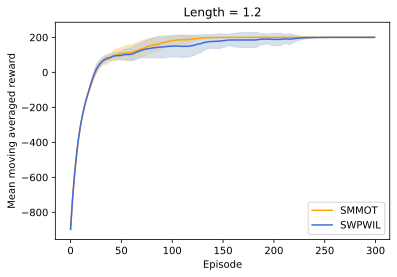

In [13]:
plt.plot([r.ep for r in training_record_multi_l_1_2_seed10], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in training_record_multi_l_1_2_seed10],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in training_record_multi_l_1_2_seed10], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in training_record_multi_l_1_2_seed10],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)
plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['SMMOT', 'SWPWIL'])
plt.title('Length = 1.2')
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_unique_len_1_2_%s.png"%environment)
plt.show()

### Experiment 3 : 5 expert trajectories each of different length

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 1
    training_records_diff_len_MMOT_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -897.4 score of current env 26.0
Ep 1 Average score: -805.56 score of current env 21.0
Ep 2 Average score: -723.7040000000001 score of current env 13.0
Ep 3 Average score: -648.4336000000001 score of current env 29.0
Ep 4 Average score: -581.9902400000001 score of current env 16.0
Ep 5 Average score: -520.7912160000001 score of current env 30.0
Ep 6 Average score: -466.71209440000007 score of current env 20.0
Ep 7 Average score: -418.8408849600001 score of current env 12.0
Ep 8 Average score: -375.85679646400007 score of current env 11.0
Ep 9 Average score: -337.27111681760005 score of current env 10.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -300.1440051358401 score of current env 34.0
Ep 11 Average score: -269.02960462225604 score of current env 11.0
Ep 12 Average score: -241.12664416003045 score of current env 10.0
Ep 13 Average score: -214.91397974402742 score of current env 21.0
Ep 14 Average score: -192.42258176962468 score of current env 10.0
Ep 15 Average score: -171.28032359266223 score of current env 19.0
Ep 16 Average score: -152.752291233396 score of current env 14.0
Ep 17 Average score: -131.9770621100564 score of current env 55.0
Ep 18 Average score: -111.77935589905077 score of current env 70.0
Ep 19 Average score: -95.6014203091457 score of current env 50.0
Ep 20 Average score: -77.14127827823113 score of current env 89.0
Ep 21 Average score: -64.92715045040802 score of current env 45.0
Ep 22 Average score: -54.63443540536722 score of current env 38.0
Ep 23 Average score: -43.070991864830496 score of current env 61.0
Ep 24 Average score: -30.563892678347443 score of current env 82.0
Ep 2

Ep 134 Average score: 199.9645118777744 score of current env 200.0
Ep 135 Average score: 199.96806068999697 score of current env 200.0
Ep 136 Average score: 199.97125462099729 score of current env 200.0
Ep 137 Average score: 199.97412915889757 score of current env 200.0
Ep 138 Average score: 199.97671624300781 score of current env 200.0
Ep 139 Average score: 199.97904461870704 score of current env 200.0
Ep 140 Average score: 199.98114015683635 score of current env 200.0
Ep 141 Average score: 199.98302614115272 score of current env 200.0
Ep 142 Average score: 199.98472352703746 score of current env 200.0
Ep 143 Average score: 199.98625117433372 score of current env 200.0
Ep 144 Average score: 199.98762605690035 score of current env 200.0
Ep 145 Average score: 199.98886345121034 score of current env 200.0
Ep 146 Average score: 199.9899771060893 score of current env 200.0
Ep 147 Average score: 199.99097939548037 score of current env 200.0
Ep 148 Average score: 199.99188145593234 score of 

Ep 256 Average score: 199.99999990717413 score of current env 200.0
Ep 257 Average score: 199.99999991645672 score of current env 200.0
Ep 258 Average score: 199.99999992481105 score of current env 200.0
Ep 259 Average score: 199.99999993232996 score of current env 200.0
Ep 260 Average score: 199.99999993909697 score of current env 200.0
Ep 261 Average score: 199.99999994518728 score of current env 200.0
Ep 262 Average score: 199.99999995066855 score of current env 200.0
Ep 263 Average score: 199.9999999556017 score of current env 200.0
Ep 264 Average score: 199.99999996004155 score of current env 200.0
Ep 265 Average score: 199.99999996403739 score of current env 200.0
Ep 266 Average score: 199.99999996763364 score of current env 200.0
Ep 267 Average score: 199.99999997087028 score of current env 200.0
Ep 268 Average score: 199.99999997378325 score of current env 200.0
Ep 269 Average score: 199.99999997640492 score of current env 200.0
Ep 270 Average score: 199.99999997876444 score of

In [7]:
pickle.dump(training_records_diff_len_MMOT_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed1_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 2
    training_records_diff_len_MMOT_seed2 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -806.19 score of current env 21.0
Ep 2 Average score: -723.171 score of current env 24.0
Ep 3 Average score: -649.7539 score of current env 11.0
Ep 4 Average score: -582.7785100000001 score of current env 20.0
Ep 5 Average score: -522.5006590000002 score of current env 20.0
Ep 6 Average score: -468.7505931000002 score of current env 15.0
Ep 7 Average score: -418.6755337900002 score of current env 32.0
Ep 8 Average score: -375.5079804110002 score of current env 13.0
Ep 9 Average score: -336.15718236990017 score of current env 18.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -301.04146413291016 score of current env 15.0
Ep 11 Average score: -270.0373177196192 score of current env 9.0
Ep 12 Average score: -242.03358594765726 score of current env 10.0
Ep 13 Average score: -216.83022735289154 score of current env 10.0
Ep 14 Average score: -193.8472046176024 score of current env 13.0
Ep 15 Average score: -173.46248415584216 score of current env 10.0
Ep 16 Average score: -154.81623574025795 score of current env 13.0
Ep 17 Average score: -137.43461216623214 score of current env 19.0
Ep 18 Average score: -122.29115094960892 score of current env 14.0
Ep 19 Average score: -108.46203585464804 score of current env 16.0
Ep 20 Average score: -95.81583226918323 score of current env 18.0
Ep 21 Average score: -84.5342490422649 score of current env 17.0
Ep 22 Average score: -72.98082413803841 score of current env 31.0
Ep 23 Average score: -61.98274172423457 score of current env 37.0
Ep 24 Average score: -48.18446755181112 score of current env 76.0
Ep 2

Ep 134 Average score: 166.32167736900485 score of current env 105.0
Ep 135 Average score: 158.9895096321044 score of current env 93.0
Ep 136 Average score: 163.09055866889395 score of current env 200.0
Ep 137 Average score: 156.48150280200454 score of current env 97.0
Ep 138 Average score: 158.3333525218041 score of current env 175.0
Ep 139 Average score: 162.5000172696237 score of current env 200.0
Ep 140 Average score: 162.95001554266133 score of current env 167.0
Ep 141 Average score: 163.05501398839522 score of current env 164.0
Ep 142 Average score: 163.1495125895557 score of current env 164.0
Ep 143 Average score: 165.63456133060015 score of current env 188.0
Ep 144 Average score: 163.67110519754013 score of current env 146.0
Ep 145 Average score: 165.2039946777861 score of current env 179.0
Ep 146 Average score: 168.6835952100075 score of current env 200.0
Ep 147 Average score: 157.71523568900676 score of current env 59.0
Ep 148 Average score: 161.94371212010608 score of current

Ep 256 Average score: 199.99474635022403 score of current env 200.0
Ep 257 Average score: 199.99527171520162 score of current env 200.0
Ep 258 Average score: 199.99574454368147 score of current env 200.0
Ep 259 Average score: 199.99617008931332 score of current env 200.0
Ep 260 Average score: 199.996553080382 score of current env 200.0
Ep 261 Average score: 199.9968977723438 score of current env 200.0
Ep 262 Average score: 199.99720799510942 score of current env 200.0
Ep 263 Average score: 199.9974871955985 score of current env 200.0
Ep 264 Average score: 199.99773847603865 score of current env 200.0
Ep 265 Average score: 199.9979646284348 score of current env 200.0
Ep 266 Average score: 199.99816816559132 score of current env 200.0
Ep 267 Average score: 199.9983513490322 score of current env 200.0
Ep 268 Average score: 199.99851621412898 score of current env 200.0
Ep 269 Average score: 199.9986645927161 score of current env 200.0
Ep 270 Average score: 199.9987981334445 score of curren

In [7]:
pickle.dump(training_records_diff_len_MMOT_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed2_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 3
    training_records_diff_len_MMOT_seed3 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -803.74 score of current env 50.0
Ep 2 Average score: -719.966 score of current env 34.0
Ep 3 Average score: -646.8694 score of current env 11.0
Ep 4 Average score: -579.5824600000001 score of current env 26.0
Ep 5 Average score: -519.7242140000001 score of current env 19.0
Ep 6 Average score: -466.9517926000001 score of current env 8.0
Ep 7 Average score: -415.85661334000014 score of current env 44.0
Ep 8 Average score: -373.07095200600014 score of current env 12.0
Ep 9 Average score: -334.0638568054001 score of current env 17.0
Ep 10 Average score: -298.95747112486015 score of current env 17.0
Ep 11 Average score: -265.6617240123742 score of current env 34.0
Ep 12 Average score: -235.79555161113674 score of current env 33.0
Ep 13 Average score: -210.6159964500231 score of current env 16.0
Ep 14 Average score: -187.8543968050208 score of current env 17.0
Ep 15 Average score: -166.16895712451873 score of current e

Ep 124 Average score: 196.69846428784783 score of current env 200.0
Ep 125 Average score: 197.02861785906305 score of current env 200.0
Ep 126 Average score: 186.52575607315674 score of current env 92.0
Ep 127 Average score: 187.87318046584107 score of current env 200.0
Ep 128 Average score: 189.08586241925698 score of current env 200.0
Ep 129 Average score: 182.2772761773313 score of current env 121.0
Ep 130 Average score: 177.74954855959814 score of current env 137.0
Ep 131 Average score: 172.57459370363833 score of current env 126.0
Ep 132 Average score: 175.3171343332745 score of current env 200.0
Ep 133 Average score: 177.78542089994707 score of current env 200.0
Ep 134 Average score: 180.00687880995235 score of current env 200.0
Ep 135 Average score: 182.00619092895712 score of current env 200.0
Ep 136 Average score: 183.8055718360614 score of current env 200.0
Ep 137 Average score: 185.42501465245527 score of current env 200.0
Ep 138 Average score: 186.88251318720975 score of cu

Ep 245 Average score: 199.99951874908749 score of current env 200.0
Ep 246 Average score: 199.99956687417875 score of current env 200.0
Ep 247 Average score: 199.9996101867609 score of current env 200.0
Ep 248 Average score: 199.9996491680848 score of current env 200.0
Ep 249 Average score: 199.99968425127634 score of current env 200.0
Ep 250 Average score: 199.9997158261487 score of current env 200.0
Ep 251 Average score: 199.99974424353383 score of current env 200.0
Ep 252 Average score: 199.99976981918044 score of current env 200.0
Ep 253 Average score: 199.9997928372624 score of current env 200.0
Ep 254 Average score: 199.99981355353614 score of current env 200.0
Ep 255 Average score: 199.99983219818253 score of current env 200.0
Ep 256 Average score: 199.99984897836427 score of current env 200.0
Ep 257 Average score: 199.99986408052786 score of current env 200.0
Ep 258 Average score: 199.99987767247507 score of current env 200.0
Ep 259 Average score: 199.99988990522758 score of cu

In [9]:
pickle.dump(training_records_diff_len_MMOT_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed3_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 4
    training_records_diff_len_MMOT_seed4 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -896.4 score of current env 36.0
Ep 1 Average score: -804.96 score of current env 18.0
Ep 2 Average score: -722.5640000000001 score of current env 19.0
Ep 3 Average score: -647.7076000000001 score of current env 26.0
Ep 4 Average score: -579.23684 score of current env 37.0
Ep 5 Average score: -519.0131560000001 score of current env 23.0
Ep 6 Average score: -465.8118404000001 score of current env 13.0
Ep 7 Average score: -416.1306563600001 score of current env 31.0
Ep 8 Average score: -373.5175907240001 score of current env 10.0
Ep 9 Average score: -334.6658316516001 score of current env 15.0
Ep 10 Average score: -298.79924848644015 score of current env 24.0
Ep 11 Average score: -267.71932363779615 score of current env 12.0
Ep 12 Average score: -239.94739127401655 score of current env 10.0
Ep 13 Average score: -212.9526521466149 score of current env 30.0
Ep 14 Average score: -183.7573869319534 score of current env 79.0
Ep 15 Average score: -161.68164823875807 score o

Ep 124 Average score: 199.97908361977167 score of current env 200.0
Ep 125 Average score: 199.98117525779452 score of current env 200.0
Ep 126 Average score: 199.98305773201508 score of current env 200.0
Ep 127 Average score: 199.98475195881358 score of current env 200.0
Ep 128 Average score: 199.98627676293222 score of current env 200.0
Ep 129 Average score: 199.987649086639 score of current env 200.0
Ep 130 Average score: 199.9888841779751 score of current env 200.0
Ep 131 Average score: 199.9899957601776 score of current env 200.0
Ep 132 Average score: 199.99099618415985 score of current env 200.0
Ep 133 Average score: 199.99189656574387 score of current env 200.0
Ep 134 Average score: 199.9927069091695 score of current env 200.0
Ep 135 Average score: 199.99343621825255 score of current env 200.0
Ep 136 Average score: 199.9940925964273 score of current env 200.0
Ep 137 Average score: 199.99468333678456 score of current env 200.0
Ep 138 Average score: 199.9952150031061 score of curre

Ep 246 Average score: 199.99999994528932 score of current env 200.0
Ep 247 Average score: 199.99999995076038 score of current env 200.0
Ep 248 Average score: 199.99999995568436 score of current env 200.0
Ep 249 Average score: 199.99999996011593 score of current env 200.0
Ep 250 Average score: 199.99999996410435 score of current env 200.0
Ep 251 Average score: 199.99999996769392 score of current env 200.0
Ep 252 Average score: 199.99999997092453 score of current env 200.0
Ep 253 Average score: 199.99999997383208 score of current env 200.0
Ep 254 Average score: 199.99999997644886 score of current env 200.0
Ep 255 Average score: 199.99999997880397 score of current env 200.0
Ep 256 Average score: 199.99999998092358 score of current env 200.0
Ep 257 Average score: 199.9999999828312 score of current env 200.0
Ep 258 Average score: 199.99999998454808 score of current env 200.0
Ep 259 Average score: 199.9999999860933 score of current env 200.0
Ep 260 Average score: 199.99999998748396 score of 

In [11]:
pickle.dump(training_records_diff_len_MMOT_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed4_%s.pkl'%environment, 'wb' ))

In [12]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 5
    training_records_diff_len_MMOT_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.3800000000001 score of current env 20.0
Ep 2 Average score: -724.4420000000001 score of current env 13.0
Ep 3 Average score: -647.2978 score of current env 47.0
Ep 4 Average score: -580.06802 score of current env 25.0
Ep 5 Average score: -517.361218 score of current env 47.0
Ep 6 Average score: -463.12509620000003 score of current env 25.0
Ep 7 Average score: -415.81258658 score of current env 10.0
Ep 8 Average score: -372.73132792200005 score of current env 15.0
Ep 9 Average score: -333.85819512980004 score of current env 16.0
Ep 10 Average score: -295.77237561682006 score of current env 47.0
Ep 11 Average score: -265.39513805513803 score of current env 8.0
Ep 12 Average score: -236.95562424962424 score of current env 19.0
Ep 13 Average score: -212.16006182466182 score of current env 11.0
Ep 14 Average score: -189.74405564219566 score of current env 12.0
Ep 15 Average score: -161.16965007797612 score of curr

Ep 124 Average score: 195.89828460694673 score of current env 200.0
Ep 125 Average score: 196.30845614625207 score of current env 200.0
Ep 126 Average score: 196.67761053162687 score of current env 200.0
Ep 127 Average score: 197.0098494784642 score of current env 200.0
Ep 128 Average score: 197.30886453061777 score of current env 200.0
Ep 129 Average score: 197.577978077556 score of current env 200.0
Ep 130 Average score: 197.8201802698004 score of current env 200.0
Ep 131 Average score: 198.03816224282036 score of current env 200.0
Ep 132 Average score: 198.23434601853833 score of current env 200.0
Ep 133 Average score: 198.4109114166845 score of current env 200.0
Ep 134 Average score: 198.56982027501607 score of current env 200.0
Ep 135 Average score: 198.71283824751447 score of current env 200.0
Ep 136 Average score: 198.84155442276304 score of current env 200.0
Ep 137 Average score: 198.95739898048674 score of current env 200.0
Ep 138 Average score: 199.06165908243807 score of cur

Ep 245 Average score: 199.99998807909674 score of current env 200.0
Ep 246 Average score: 199.99998927118708 score of current env 200.0
Ep 247 Average score: 199.99999034406838 score of current env 200.0
Ep 248 Average score: 199.99999130966154 score of current env 200.0
Ep 249 Average score: 199.99999217869538 score of current env 200.0
Ep 250 Average score: 199.99999296082584 score of current env 200.0
Ep 251 Average score: 199.99999366474324 score of current env 200.0
Ep 252 Average score: 199.99999429826892 score of current env 200.0
Ep 253 Average score: 199.99999486844203 score of current env 200.0
Ep 254 Average score: 199.99999538159784 score of current env 200.0
Ep 255 Average score: 199.99999584343806 score of current env 200.0
Ep 256 Average score: 199.99999625909425 score of current env 200.0
Ep 257 Average score: 199.99999663318482 score of current env 200.0
Ep 258 Average score: 199.99999696986634 score of current env 200.0
Ep 259 Average score: 199.9999972728797 score of

In [13]:
pickle.dump(training_records_diff_len_MMOT_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed5_%s.pkl'%environment, 'wb' ))

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 6
    training_records_diff_len_MMOT_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -802.5300000000001 score of current env 63.0
Ep 2 Average score: -719.3770000000001 score of current env 29.0
Ep 3 Average score: -645.7393000000001 score of current env 17.0
Ep 4 Average score: -579.7653700000001 score of current env 14.0
Ep 5 Average score: -518.9888330000001 score of current env 28.0
Ep 6 Average score: -464.2899497000001 score of current env 28.0
Ep 7 Average score: -416.56095473000005 score of current env 13.0
Ep 8 Average score: -372.10485925700004 score of current env 28.0
Ep 9 Average score: -332.9943733313001 score of current env 19.0
Ep 10 Average score: -298.39493599817007 score of current env 13.0
Ep 11 Average score: -267.3554423983531 score of current env 12.0
Ep 12 Average score: -238.4198981585178 score of current env 22.0
Ep 13 Average score: -212.97790834266604 score of current env 16.0
Ep 14 Average score: -189.18011750839943 score of current env 25.0
Ep 15 Average score: -168.0

Ep 124 Average score: 199.83360361545098 score of current env 200.0
Ep 125 Average score: 199.8502432539059 score of current env 200.0
Ep 126 Average score: 199.8652189285153 score of current env 200.0
Ep 127 Average score: 199.87869703566378 score of current env 200.0
Ep 128 Average score: 199.89082733209742 score of current env 200.0
Ep 129 Average score: 199.9017445988877 score of current env 200.0
Ep 130 Average score: 199.9115701389989 score of current env 200.0
Ep 131 Average score: 199.92041312509903 score of current env 200.0
Ep 132 Average score: 199.92837181258912 score of current env 200.0
Ep 133 Average score: 199.9355346313302 score of current env 200.0
Ep 134 Average score: 199.94198116819717 score of current env 200.0
Ep 135 Average score: 199.94778305137746 score of current env 200.0
Ep 136 Average score: 199.9530047462397 score of current env 200.0
Ep 137 Average score: 199.95770427161574 score of current env 200.0
Ep 138 Average score: 199.96193384445417 score of curr

Ep 246 Average score: 199.9999995647588 score of current env 200.0
Ep 247 Average score: 199.99999960828293 score of current env 200.0
Ep 248 Average score: 199.99999964745464 score of current env 200.0
Ep 249 Average score: 199.9999996827092 score of current env 200.0
Ep 250 Average score: 199.99999971443827 score of current env 200.0
Ep 251 Average score: 199.99999974299445 score of current env 200.0
Ep 252 Average score: 199.999999768695 score of current env 200.0
Ep 253 Average score: 199.9999997918255 score of current env 200.0
Ep 254 Average score: 199.99999981264295 score of current env 200.0
Ep 255 Average score: 199.99999983137866 score of current env 200.0
Ep 256 Average score: 199.9999998482408 score of current env 200.0
Ep 257 Average score: 199.99999986341672 score of current env 200.0
Ep 258 Average score: 199.99999987707506 score of current env 200.0
Ep 259 Average score: 199.99999988936756 score of current env 200.0
Ep 260 Average score: 199.9999999004308 score of curre

In [15]:
pickle.dump(training_records_diff_len_MMOT_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed6_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 7
    training_records_diff_len_MMOT_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -807.56 score of current env 10.0
Ep 2 Average score: -724.904 score of current env 19.0
Ep 3 Average score: -650.1136 score of current env 23.0
Ep 4 Average score: -582.90224 score of current env 22.0
Ep 5 Average score: -522.612016 score of current env 20.0
Ep 6 Average score: -468.2508144 score of current env 21.0
Ep 7 Average score: -419.32573296 score of current env 21.0
Ep 8 Average score: -376.093159664 score of current env 13.0
Ep 9 Average score: -337.0838436976 score of current env 14.0
Ep 10 Average score: -302.17545932784003 score of current env 12.0
Ep 11 Average score: -271.157913395056 score of current env 8.0
Ep 12 Average score: -243.04212205555044 score of current env 10.0
Ep 13 Average score: -217.5379098499954 score of current env 12.0
Ep 14 Average score: -194.58411886499587 score of current env 12.0
Ep 15 Average score: -173.9257069784963 score of current env 12.0
Ep 16 Average score: -152.43

Ep 126 Average score: 196.95679612816065 score of current env 200.0
Ep 127 Average score: 197.26111651534458 score of current env 200.0
Ep 128 Average score: 197.53500486381012 score of current env 200.0
Ep 129 Average score: 197.78150437742912 score of current env 200.0
Ep 130 Average score: 198.0033539396862 score of current env 200.0
Ep 131 Average score: 198.20301854571758 score of current env 200.0
Ep 132 Average score: 198.38271669114582 score of current env 200.0
Ep 133 Average score: 198.54444502203123 score of current env 200.0
Ep 134 Average score: 198.69000051982812 score of current env 200.0
Ep 135 Average score: 198.82100046784532 score of current env 200.0
Ep 136 Average score: 198.9389004210608 score of current env 200.0
Ep 137 Average score: 199.04501037895471 score of current env 200.0
Ep 138 Average score: 199.14050934105924 score of current env 200.0
Ep 139 Average score: 199.22645840695333 score of current env 200.0
Ep 140 Average score: 199.303812566258 score of cu

Ep 247 Average score: 199.99999115547146 score of current env 200.0
Ep 248 Average score: 199.9999920399243 score of current env 200.0
Ep 249 Average score: 199.9999928359319 score of current env 200.0
Ep 250 Average score: 199.9999935523387 score of current env 200.0
Ep 251 Average score: 199.99999419710485 score of current env 200.0
Ep 252 Average score: 199.99999477739436 score of current env 200.0
Ep 253 Average score: 199.99999529965493 score of current env 200.0
Ep 254 Average score: 199.99999576968943 score of current env 200.0
Ep 255 Average score: 199.9999961927205 score of current env 200.0
Ep 256 Average score: 199.99999657344844 score of current env 200.0
Ep 257 Average score: 199.9999969161036 score of current env 200.0
Ep 258 Average score: 199.99999722449326 score of current env 200.0
Ep 259 Average score: 199.99999750204393 score of current env 200.0
Ep 260 Average score: 199.99999775183954 score of current env 200.0
Ep 261 Average score: 199.9999979766556 score of curr

In [17]:
pickle.dump(training_records_diff_len_MMOT_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed7_%s.pkl'%environment, 'wb' ))

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 8
    training_records_diff_len_MMOT_seed8 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -806.3199999999999 score of current env 26.0
Ep 2 Average score: -724.288 score of current env 14.0
Ep 3 Average score: -649.5592 score of current env 23.0
Ep 4 Average score: -582.90328 score of current env 17.0
Ep 5 Average score: -517.6129520000001 score of current env 70.0
Ep 6 Average score: -463.15165680000007 score of current env 27.0
Ep 7 Average score: -411.9364911200001 score of current env 49.0
Ep 8 Average score: -368.44284200800007 score of current env 23.0
Ep 9 Average score: -328.89855780720006 score of current env 27.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -293.90870202648006 score of current env 21.0
Ep 11 Average score: -263.1178318238321 score of current env 14.0
Ep 12 Average score: -235.7060486414489 score of current env 11.0
Ep 13 Average score: -210.535443777304 score of current env 16.0
Ep 14 Average score: -185.58189939957362 score of current env 39.0
Ep 15 Average score: -165.12370945961626 score of current env 19.0
Ep 16 Average score: -142.71133851365462 score of current env 59.0
Ep 17 Average score: -125.54020466228917 score of current env 29.0
Ep 18 Average score: -103.68618419606025 score of current env 93.0
Ep 19 Average score: -89.51756577645423 score of current env 38.0
Ep 20 Average score: -73.06580919880881 score of current env 75.0
Ep 21 Average score: -60.759228278927935 score of current env 50.0
Ep 22 Average score: -47.28330545103515 score of current env 74.0
Ep 23 Average score: -33.65497490593164 score of current env 89.0
Ep 24 Average score: -20.389477415338476 score of current env 99.0
Ep 

Ep 134 Average score: 196.86722524309798 score of current env 200.0
Ep 135 Average score: 197.18050271878818 score of current env 200.0
Ep 136 Average score: 197.46245244690937 score of current env 200.0
Ep 137 Average score: 197.71620720221844 score of current env 200.0
Ep 138 Average score: 197.9445864819966 score of current env 200.0
Ep 139 Average score: 198.15012783379694 score of current env 200.0
Ep 140 Average score: 198.33511505041724 score of current env 200.0
Ep 141 Average score: 198.50160354537553 score of current env 200.0
Ep 142 Average score: 198.651443190838 score of current env 200.0
Ep 143 Average score: 198.7862988717542 score of current env 200.0
Ep 144 Average score: 198.9076689845788 score of current env 200.0
Ep 145 Average score: 199.01690208612092 score of current env 200.0
Ep 146 Average score: 199.11521187750884 score of current env 200.0
Ep 147 Average score: 199.20369068975796 score of current env 200.0
Ep 148 Average score: 199.28332162078217 score of cur

Ep 256 Average score: 199.9999918056347 score of current env 200.0
Ep 257 Average score: 199.99999262507123 score of current env 200.0
Ep 258 Average score: 199.9999933625641 score of current env 200.0
Ep 259 Average score: 199.99999402630772 score of current env 200.0
Ep 260 Average score: 199.99999462367694 score of current env 200.0
Ep 261 Average score: 199.99999516130924 score of current env 200.0
Ep 262 Average score: 199.99999564517833 score of current env 200.0
Ep 263 Average score: 199.9999960806605 score of current env 200.0
Ep 264 Average score: 199.99999647259446 score of current env 200.0
Ep 265 Average score: 199.99999682533502 score of current env 200.0
Ep 266 Average score: 199.99999714280153 score of current env 200.0
Ep 267 Average score: 199.9999974285214 score of current env 200.0
Ep 268 Average score: 199.99999768566926 score of current env 200.0
Ep 269 Average score: 199.99999791710235 score of current env 200.0
Ep 270 Average score: 199.99999812539212 score of cu

In [7]:
pickle.dump(training_records_diff_len_MMOT_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed8_%s.pkl'%environment, 'wb' ))

In [8]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 9
    training_records_diff_len_MMOT_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.16 score of current env 24.0
Ep 2 Average score: -721.244 score of current env 43.0
Ep 3 Average score: -647.4196 score of current env 17.0
Ep 4 Average score: -579.17764 score of current env 35.0
Ep 5 Average score: -518.1598759999999 score of current env 31.0
Ep 6 Average score: -462.6438884 score of current env 37.0
Ep 7 Average score: -415.17949956 score of current env 12.0
Ep 8 Average score: -372.461549604 score of current env 12.0
Ep 9 Average score: -331.6153946436 score of current env 36.0
Ep 10 Average score: -295.85385517924 score of current env 26.0
Ep 11 Average score: -265.268469661316 score of current env 10.0
Ep 12 Average score: -237.6416226951844 score of current env 11.0
Ep 13 Average score: -212.47746042566595 score of current env 14.0
Ep 14 Average score: -189.02971438309936 score of current env 22.0
Ep 15 Average score: -166.32674294478943 score of current env 38.0
Ep 16 Average score: -

Ep 125 Average score: 199.9501624853641 score of current env 200.0
Ep 126 Average score: 199.9551462368277 score of current env 200.0
Ep 127 Average score: 199.95963161314492 score of current env 200.0
Ep 128 Average score: 199.96366845183044 score of current env 200.0
Ep 129 Average score: 199.9673016066474 score of current env 200.0
Ep 130 Average score: 199.97057144598267 score of current env 200.0
Ep 131 Average score: 199.9735143013844 score of current env 200.0
Ep 132 Average score: 199.97616287124598 score of current env 200.0
Ep 133 Average score: 199.97854658412137 score of current env 200.0
Ep 134 Average score: 199.98069192570924 score of current env 200.0
Ep 135 Average score: 199.98262273313833 score of current env 200.0
Ep 136 Average score: 199.9843604598245 score of current env 200.0
Ep 137 Average score: 199.98592441384204 score of current env 200.0
Ep 138 Average score: 199.98733197245784 score of current env 200.0
Ep 139 Average score: 199.98859877521207 score of cur

Ep 247 Average score: 199.99999986964062 score of current env 200.0
Ep 248 Average score: 199.99999988267655 score of current env 200.0
Ep 249 Average score: 199.9999998944089 score of current env 200.0
Ep 250 Average score: 199.999999904968 score of current env 200.0
Ep 251 Average score: 199.9999999144712 score of current env 200.0
Ep 252 Average score: 199.9999999230241 score of current env 200.0
Ep 253 Average score: 199.99999993072169 score of current env 200.0
Ep 254 Average score: 199.99999993764953 score of current env 200.0
Ep 255 Average score: 199.99999994388457 score of current env 200.0
Ep 256 Average score: 199.99999994949613 score of current env 200.0
Ep 257 Average score: 199.99999995454652 score of current env 200.0
Ep 258 Average score: 199.99999995909187 score of current env 200.0
Ep 259 Average score: 199.9999999631827 score of current env 200.0
Ep 260 Average score: 199.99999996686444 score of current env 200.0
Ep 261 Average score: 199.999999970178 score of curren

In [9]:
pickle.dump(training_records_diff_len_MMOT_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed9_%s.pkl'%environment, 'wb' ))

In [10]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 10
    training_records_diff_len_MMOT_seed10 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -806.4599999999999 score of current env 21.0
Ep 2 Average score: -723.314 score of current env 25.0
Ep 3 Average score: -648.5826 score of current env 24.0
Ep 4 Average score: -579.42434 score of current env 43.0
Ep 5 Average score: -520.1819060000001 score of current env 13.0
Ep 6 Average score: -465.0637154000001 score of current env 31.0
Ep 7 Average score: -417.2573438600001 score of current env 13.0
Ep 8 Average score: -372.13160947400013 score of current env 34.0
Ep 9 Average score: -331.51844852660014 score of current env 34.0
Ep 10 Average score: -296.96660367394014 score of current env 14.0
Ep 11 Average score: -266.2699433065461 score of current env 10.0
Ep 12 Average score: -238.1429489758915 score of current env 15.0
Ep 13 Average score: -213.12865407830236 score of current env 12.0
Ep 14 Average score: -188.01578867047212 score of current env 38.0
Ep 15 Average score: -166.4142098034249 score of curre

Ep 124 Average score: 199.82952969714657 score of current env 200.0
Ep 125 Average score: 199.8465767274319 score of current env 200.0
Ep 126 Average score: 199.8619190546887 score of current env 200.0
Ep 127 Average score: 199.87572714921984 score of current env 200.0
Ep 128 Average score: 199.88815443429786 score of current env 200.0
Ep 129 Average score: 199.89933899086807 score of current env 200.0
Ep 130 Average score: 199.90940509178128 score of current env 200.0
Ep 131 Average score: 199.91846458260315 score of current env 200.0
Ep 132 Average score: 199.92661812434284 score of current env 200.0
Ep 133 Average score: 199.93395631190856 score of current env 200.0
Ep 134 Average score: 199.9405606807177 score of current env 200.0
Ep 135 Average score: 199.94650461264595 score of current env 200.0
Ep 136 Average score: 199.95185415138135 score of current env 200.0
Ep 137 Average score: 199.95666873624322 score of current env 200.0
Ep 138 Average score: 199.9610018626189 score of cu

Ep 245 Average score: 199.99999950455853 score of current env 200.0
Ep 246 Average score: 199.9999995541027 score of current env 200.0
Ep 247 Average score: 199.99999959869243 score of current env 200.0
Ep 248 Average score: 199.9999996388232 score of current env 200.0
Ep 249 Average score: 199.99999967494088 score of current env 200.0
Ep 250 Average score: 199.9999997074468 score of current env 200.0
Ep 251 Average score: 199.9999997367021 score of current env 200.0
Ep 252 Average score: 199.9999997630319 score of current env 200.0
Ep 253 Average score: 199.99999978672872 score of current env 200.0
Ep 254 Average score: 199.99999980805586 score of current env 200.0
Ep 255 Average score: 199.9999998272503 score of current env 200.0
Ep 256 Average score: 199.99999984452526 score of current env 200.0
Ep 257 Average score: 199.99999986007273 score of current env 200.0
Ep 258 Average score: 199.99999987406545 score of current env 200.0
Ep 259 Average score: 199.9999998866589 score of curre

In [11]:
pickle.dump(training_records_diff_len_MMOT_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed10_%s.pkl'%environment, 'wb' ))

In [24]:
mmottraining_records_diff_len_MMOT_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed1_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed2_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed3_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed4_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed5_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed6_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed7_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed8_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed9_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_len_MMOT_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_len_MMOT_seed10_%s.pkl'%environment,'rb' ))

l1 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed1]
l2 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed2]
l3 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed3]
l4 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed4]
l5 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed5]
l6 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed6]
l7 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed7]
l8 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed8]
l9 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed9]
l10 = [r.reward for r in mmottraining_records_diff_len_MMOT_seed10]

In [25]:
multiple_lists = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]

std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [14]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 11
    training_records_diff_len_wass_PWIL_seed1 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -803.7199999999999 score of current env 52.0
Ep 2 Average score: -721.448 score of current env 19.0
Ep 3 Average score: -648.2031999999999 score of current env 11.0
Ep 4 Average score: -581.08288 score of current env 23.0
Ep 5 Average score: -520.374592 score of current env 26.0
Ep 6 Average score: -466.6371328 score of current env 17.0
Ep 7 Average score: -418.17341952000004 score of current env 18.0
Ep 8 Average score: -372.756077568 score of current env 36.0
Ep 9 Average score: -334.3804698112 score of current env 11.0
Ep 10 Average score: -299.84242283007995 score of current env 11.0
Ep 11 Average score: -269.05818054707197 score of current env 8.0
Ep 12 Average score: -240.25236249236477 score of current env 19.0
Ep 13 Average score: -214.22712624312828 score of current env 20.0
Ep 14 Average score: -190.90441361881545 score of current env 19.0
Ep 15 Average score: -166.0139722569339 score of current env 58.0

Ep 125 Average score: 198.13472671755284 score of current env 200.0
Ep 126 Average score: 198.32125404579756 score of current env 200.0
Ep 127 Average score: 198.4891286412178 score of current env 200.0
Ep 128 Average score: 198.64021577709602 score of current env 200.0
Ep 129 Average score: 198.77619419938642 score of current env 200.0
Ep 130 Average score: 198.89857477944778 score of current env 200.0
Ep 131 Average score: 199.008717301503 score of current env 200.0
Ep 132 Average score: 199.1078455713527 score of current env 200.0
Ep 133 Average score: 199.19706101421744 score of current env 200.0
Ep 134 Average score: 199.2773549127957 score of current env 200.0
Ep 135 Average score: 199.3496194215161 score of current env 200.0
Ep 136 Average score: 199.4146574793645 score of current env 200.0
Ep 137 Average score: 199.47319173142807 score of current env 200.0
Ep 138 Average score: 199.52587255828527 score of current env 200.0
Ep 139 Average score: 199.57328530245675 score of curre

Ep 247 Average score: 199.9999951210247 score of current env 200.0
Ep 248 Average score: 199.99999560892223 score of current env 200.0
Ep 249 Average score: 199.99999604803003 score of current env 200.0
Ep 250 Average score: 199.99999644322702 score of current env 200.0
Ep 251 Average score: 199.99999679890433 score of current env 200.0
Ep 252 Average score: 199.9999971190139 score of current env 200.0
Ep 253 Average score: 199.99999740711252 score of current env 200.0
Ep 254 Average score: 199.99999766640127 score of current env 200.0
Ep 255 Average score: 199.99999789976115 score of current env 200.0
Ep 256 Average score: 199.99999810978505 score of current env 200.0
Ep 257 Average score: 199.99999829880656 score of current env 200.0
Ep 258 Average score: 199.9999984689259 score of current env 200.0
Ep 259 Average score: 199.9999986220333 score of current env 200.0
Ep 260 Average score: 199.99999875982996 score of current env 200.0
Ep 261 Average score: 199.99999888384698 score of cu

In [15]:
pickle.dump(training_records_diff_len_wass_PWIL_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed1_%s.pkl'%environment, 'wb' ))

In [16]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 12
    training_records_diff_len_wass_PWIL_seed2 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -805.6700000000001 score of current env 28.0
Ep 2 Average score: -723.1030000000001 score of current env 20.0
Ep 3 Average score: -648.7927000000001 score of current env 20.0
Ep 4 Average score: -582.9134300000001 score of current env 10.0
Ep 5 Average score: -522.6220870000001 score of current env 20.0
Ep 6 Average score: -469.0598783000001 score of current env 13.0
Ep 7 Average score: -417.9538904700001 score of current env 42.0
Ep 8 Average score: -373.1585014230001 score of current env 30.0
Ep 9 Average score: -334.34265128070007 score of current env 15.0
Ep 10 Average score: -298.30838615263 score of current env 26.0
Ep 11 Average score: -267.377547537367 score of current env 11.0
Ep 12 Average score: -239.7397927836303 score of current env 9.0
Ep 13 Average score: -214.86581350526725 score of current env 9.0
Ep 14 Average score: -192.27923215474053 score of current env 11.0
Ep 15 Average score: -171.75130893

Ep 125 Average score: 198.02899907262307 score of current env 200.0
Ep 126 Average score: 198.22609916536075 score of current env 200.0
Ep 127 Average score: 198.40348924882468 score of current env 200.0
Ep 128 Average score: 198.5631403239422 score of current env 200.0
Ep 129 Average score: 198.706826291548 score of current env 200.0
Ep 130 Average score: 198.8361436623932 score of current env 200.0
Ep 131 Average score: 198.95252929615387 score of current env 200.0
Ep 132 Average score: 198.85727636653849 score of current env 198.0
Ep 133 Average score: 198.97154872988463 score of current env 200.0
Ep 134 Average score: 199.07439385689617 score of current env 200.0
Ep 135 Average score: 199.16695447120657 score of current env 200.0
Ep 136 Average score: 199.25025902408592 score of current env 200.0
Ep 137 Average score: 199.32523312167734 score of current env 200.0
Ep 138 Average score: 199.39270980950963 score of current env 200.0
Ep 139 Average score: 199.45343882855866 score of cu

Ep 247 Average score: 199.99962381133548 score of current env 200.0
Ep 248 Average score: 199.99966143020194 score of current env 200.0
Ep 249 Average score: 199.99969528718174 score of current env 200.0
Ep 250 Average score: 199.99972575846357 score of current env 200.0
Ep 251 Average score: 199.9997531826172 score of current env 200.0
Ep 252 Average score: 199.9997778643555 score of current env 200.0
Ep 253 Average score: 199.99980007791996 score of current env 200.0
Ep 254 Average score: 199.99982007012795 score of current env 200.0
Ep 255 Average score: 199.99983806311516 score of current env 200.0
Ep 256 Average score: 199.99985425680364 score of current env 200.0
Ep 257 Average score: 199.99986883112328 score of current env 200.0
Ep 258 Average score: 199.99988194801097 score of current env 200.0
Ep 259 Average score: 199.99989375320988 score of current env 200.0
Ep 260 Average score: 199.9999043778889 score of current env 200.0
Ep 261 Average score: 199.99991394010001 score of c

In [17]:
pickle.dump(training_records_diff_len_wass_PWIL_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed2_%s.pkl'%environment, 'wb' ))

In [28]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 13
    training_records_diff_len_wass_PWIL_seed3 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.3 score of current env 17.0
Ep 1 Average score: -805.77 score of current env 27.0
Ep 2 Average score: -723.393 score of current env 18.0
Ep 3 Average score: -649.4537 score of current env 16.0
Ep 4 Average score: -583.10833 score of current env 14.0
Ep 5 Average score: -522.697497 score of current env 21.0
Ep 6 Average score: -469.1277473 score of current env 13.0
Ep 7 Average score: -420.71497257000004 score of current env 15.0
Ep 8 Average score: -375.54347531300004 score of current env 31.0
Ep 9 Average score: -336.7891277817001 score of current env 12.0
Ep 10 Average score: -301.2102150035301 score of current env 19.0
Ep 11 Average score: -269.9891935031771 score of current env 11.0
Ep 12 Average score: -239.7902741528594 score of current env 32.0
Ep 13 Average score: -214.51124673757346 score of current env 13.0
Ep 14 Average score: -185.06012206381612 score of current env 80.0
Ep 15 Average score: -163.2541098574345 score of current env 33.0
Ep 16 Average

Ep 125 Average score: 189.99769569700675 score of current env 200.0
Ep 126 Average score: 190.99792612730607 score of current env 200.0
Ep 127 Average score: 186.59813351457547 score of current env 147.0
Ep 128 Average score: 187.93832016311794 score of current env 200.0
Ep 129 Average score: 189.14448814680614 score of current env 200.0
Ep 130 Average score: 190.23003933212553 score of current env 200.0
Ep 131 Average score: 191.20703539891298 score of current env 200.0
Ep 132 Average score: 188.2863318590217 score of current env 162.0
Ep 133 Average score: 189.45769867311952 score of current env 200.0
Ep 134 Average score: 190.51192880580757 score of current env 200.0
Ep 135 Average score: 191.46073592522683 score of current env 200.0
Ep 136 Average score: 192.31466233270416 score of current env 200.0
Ep 137 Average score: 192.88319609943375 score of current env 198.0
Ep 138 Average score: 193.5948764894904 score of current env 200.0
Ep 139 Average score: 194.23538884054136 score of 

Ep 246 Average score: 199.99992676502663 score of current env 200.0
Ep 247 Average score: 199.99993408852396 score of current env 200.0
Ep 248 Average score: 199.99994067967157 score of current env 200.0
Ep 249 Average score: 199.99994661170442 score of current env 200.0
Ep 250 Average score: 199.99995195053398 score of current env 200.0
Ep 251 Average score: 199.99995675548058 score of current env 200.0
Ep 252 Average score: 199.99996107993252 score of current env 200.0
Ep 253 Average score: 199.99996497193928 score of current env 200.0
Ep 254 Average score: 199.99996847474534 score of current env 200.0
Ep 255 Average score: 199.9999716272708 score of current env 200.0
Ep 256 Average score: 199.99997446454373 score of current env 200.0
Ep 257 Average score: 199.99997701808937 score of current env 200.0
Ep 258 Average score: 199.99997931628045 score of current env 200.0
Ep 259 Average score: 199.99998138465241 score of current env 200.0
Ep 260 Average score: 199.99998324618718 score of

In [29]:
pickle.dump(training_records_diff_len_wass_PWIL_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed3_%s.pkl'%environment, 'wb' ))

In [7]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 14
    training_records_diff_len_wass_PWIL_seed4 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -897.8 score of current env 22.0
Ep 1 Average score: -806.12 score of current env 19.0
Ep 2 Average score: -722.6080000000001 score of current env 29.0
Ep 3 Average score: -646.8472 score of current env 35.0
Ep 4 Average score: -581.1624800000001 score of current env 10.0
Ep 5 Average score: -520.946232 score of current env 21.0
Ep 6 Average score: -465.6516088 score of current env 32.0
Ep 7 Average score: -414.68644792000003 score of current env 44.0
Ep 8 Average score: -366.517803128 score of current env 67.0
Ep 9 Average score: -326.86602281520004 score of current env 30.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -289.87942053368005 score of current env 43.0
Ep 11 Average score: -259.79147848031204 score of current env 11.0
Ep 12 Average score: -232.51233063228082 score of current env 13.0
Ep 13 Average score: -208.16109756905274 score of current env 11.0
Ep 14 Average score: -182.74498781214749 score of current env 46.0
Ep 15 Average score: -157.07048903093275 score of current env 74.0
Ep 16 Average score: -135.86344012783948 score of current env 55.0
Ep 17 Average score: -117.87709611505554 score of current env 44.0
Ep 18 Average score: -97.18938650354998 score of current env 89.0
Ep 19 Average score: -70.07044785319498 score of current env 174.0
Ep 20 Average score: -53.26340306787549 score of current env 98.0
Ep 21 Average score: -32.63706276108793 score of current env 153.0
Ep 22 Average score: -21.77335648497914 score of current env 76.0
Ep 23 Average score: -12.696020836481226 score of current env 69.0
Ep 24 Average score: -1.2264187528331032 score of current env 102

Ep 135 Average score: 55.065153400104116 score of current env 140.0
Ep 136 Average score: 63.25863806009371 score of current env 137.0
Ep 137 Average score: 76.93277425408434 score of current env 200.0
Ep 138 Average score: 84.03949682867591 score of current env 148.0
Ep 139 Average score: 91.03554714580832 score of current env 154.0
Ep 140 Average score: 98.1319924312275 score of current env 162.0
Ep 141 Average score: 103.91879318810476 score of current env 156.0
Ep 142 Average score: 108.52691386929429 score of current env 150.0
Ep 143 Average score: 110.77422248236488 score of current env 131.0
Ep 144 Average score: 119.39680023412839 score of current env 197.0
Ep 145 Average score: 121.95712021071556 score of current env 145.0
Ep 146 Average score: 127.161408189644 score of current env 174.0
Ep 147 Average score: 132.6452673706796 score of current env 182.0
Ep 148 Average score: 136.38074063361165 score of current env 170.0
Ep 149 Average score: 141.44266657025048 score of current

Ep 257 Average score: 197.9465551906413 score of current env 200.0
Ep 258 Average score: 198.15189967157718 score of current env 200.0
Ep 259 Average score: 198.33670970441946 score of current env 200.0
Ep 260 Average score: 198.50303873397752 score of current env 200.0
Ep 261 Average score: 198.65273486057978 score of current env 200.0
Ep 262 Average score: 198.7874613745218 score of current env 200.0
Ep 263 Average score: 198.90871523706963 score of current env 200.0
Ep 264 Average score: 199.01784371336268 score of current env 200.0
Ep 265 Average score: 199.1160593420264 score of current env 200.0
Ep 266 Average score: 199.20445340782376 score of current env 200.0
Ep 267 Average score: 199.28400806704138 score of current env 200.0
Ep 268 Average score: 199.35560726033725 score of current env 200.0
Ep 269 Average score: 199.42004653430354 score of current env 200.0
Ep 270 Average score: 199.47804188087318 score of current env 200.0
Ep 271 Average score: 199.53023769278587 score of c

In [8]:
pickle.dump(training_records_diff_len_wass_PWIL_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed4_%s.pkl'%environment, 'wb' ))

In [9]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 15
    training_records_diff_len_wass_PWIL_seed5 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.8 score of current env 22.0
Ep 1 Average score: -806.22 score of current env 18.0
Ep 2 Average score: -721.898 score of current env 37.0
Ep 3 Average score: -648.1082 score of current env 16.0
Ep 4 Average score: -581.39738 score of current env 19.0
Ep 5 Average score: -522.057642 score of current env 12.0
Ep 6 Average score: -467.7518778 score of current env 21.0
Ep 7 Average score: -418.67669001999997 score of current env 23.0
Ep 8 Average score: -374.00902101799994 score of current env 28.0
Ep 9 Average score: -332.20811891619996 score of current env 44.0
Ep 10 Average score: -297.48730702458 score of current env 15.0
Ep 11 Average score: -266.33857632212204 score of current env 14.0
Ep 12 Average score: -238.80471868990983 score of current env 9.0
Ep 13 Average score: -214.12424682091884 score of current env 8.0
Ep 14 Average score: -189.41182213882695 score of current env 33.0
Ep 15 Average score: -159.17063992494425 score of current env 113.0
Ep 16 Averag

Ep 125 Average score: 197.56007620831076 score of current env 200.0
Ep 126 Average score: 197.8040685874797 score of current env 200.0
Ep 127 Average score: 198.02366172873172 score of current env 200.0
Ep 128 Average score: 198.22129555585855 score of current env 200.0
Ep 129 Average score: 198.3991660002727 score of current env 200.0
Ep 130 Average score: 198.55924940024542 score of current env 200.0
Ep 131 Average score: 198.70332446022087 score of current env 200.0
Ep 132 Average score: 198.8329920141988 score of current env 200.0
Ep 133 Average score: 198.94969281277892 score of current env 200.0
Ep 134 Average score: 199.05472353150103 score of current env 200.0
Ep 135 Average score: 199.14925117835094 score of current env 200.0
Ep 136 Average score: 199.23432606051585 score of current env 200.0
Ep 137 Average score: 199.31089345446426 score of current env 200.0
Ep 138 Average score: 199.37980410901784 score of current env 200.0
Ep 139 Average score: 199.44182369811605 score of c

Ep 246 Average score: 199.99999290879728 score of current env 200.0
Ep 247 Average score: 199.99999361791757 score of current env 200.0
Ep 248 Average score: 199.9999942561258 score of current env 200.0
Ep 249 Average score: 199.99999483051323 score of current env 200.0
Ep 250 Average score: 199.99999534746192 score of current env 200.0
Ep 251 Average score: 199.99999581271572 score of current env 200.0
Ep 252 Average score: 199.99999623144416 score of current env 200.0
Ep 253 Average score: 199.99999660829974 score of current env 200.0
Ep 254 Average score: 199.99999694746978 score of current env 200.0
Ep 255 Average score: 199.9999972527228 score of current env 200.0
Ep 256 Average score: 199.99999752745052 score of current env 200.0
Ep 257 Average score: 199.99999777470546 score of current env 200.0
Ep 258 Average score: 199.9999979972349 score of current env 200.0
Ep 259 Average score: 199.99999819751142 score of current env 200.0
Ep 260 Average score: 199.99999837776028 score of c

In [10]:
pickle.dump(training_records_diff_len_wass_PWIL_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed5_%s.pkl'%environment, 'wb' ))

In [11]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 16
    training_records_diff_len_wass_PWIL_seed6 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.0 score of current env 50.0
Ep 1 Average score: -802.8 score of current env 27.0
Ep 2 Average score: -720.3199999999999 score of current env 22.0
Ep 3 Average score: -646.488 score of current env 18.0
Ep 4 Average score: -577.9392000000001 score of current env 39.0
Ep 5 Average score: -517.0452800000002 score of current env 31.0
Ep 6 Average score: -463.04075200000017 score of current env 23.0
Ep 7 Average score: -415.23667680000017 score of current env 15.0
Ep 8 Average score: -371.61300912000013 score of current env 21.0
Ep 9 Average score: -332.75170820800014 score of current env 17.0
Ep 10 Average score: -295.77653738720016 score of current env 37.0
Ep 11 Average score: -265.29888364848017 score of current env 9.0
Ep 12 Average score: -235.96899528363215 score of current env 28.0
Ep 13 Average score: -211.17209575526894 score of current env 12.0
Ep 14 Average score: -184.95488617974206 score of current env 51.0
Ep 15 Average score: -157.25939756176788 score

Ep 124 Average score: 199.99106566406908 score of current env 200.0
Ep 125 Average score: 199.99195909766217 score of current env 200.0
Ep 126 Average score: 199.99276318789597 score of current env 200.0
Ep 127 Average score: 199.9934868691064 score of current env 200.0
Ep 128 Average score: 199.99413818219577 score of current env 200.0
Ep 129 Average score: 199.9947243639762 score of current env 200.0
Ep 130 Average score: 199.99525192757858 score of current env 200.0
Ep 131 Average score: 199.99572673482072 score of current env 200.0
Ep 132 Average score: 199.99615406133864 score of current env 200.0
Ep 133 Average score: 199.99653865520477 score of current env 200.0
Ep 134 Average score: 199.9968847896843 score of current env 200.0
Ep 135 Average score: 199.99719631071585 score of current env 200.0
Ep 136 Average score: 199.99747667964428 score of current env 200.0
Ep 137 Average score: 199.99772901167987 score of current env 200.0
Ep 138 Average score: 199.9979561105119 score of cu

Ep 245 Average score: 199.999999974034 score of current env 200.0
Ep 246 Average score: 199.99999997663062 score of current env 200.0
Ep 247 Average score: 199.99999997896757 score of current env 200.0
Ep 248 Average score: 199.9999999810708 score of current env 200.0
Ep 249 Average score: 199.99999998296371 score of current env 200.0
Ep 250 Average score: 199.99999998466734 score of current env 200.0
Ep 251 Average score: 199.9999999862006 score of current env 200.0
Ep 252 Average score: 199.99999998758054 score of current env 200.0
Ep 253 Average score: 199.99999998882248 score of current env 200.0
Ep 254 Average score: 199.99999998994025 score of current env 200.0
Ep 255 Average score: 199.99999999094624 score of current env 200.0
Ep 256 Average score: 199.9999999918516 score of current env 200.0
Ep 257 Average score: 199.99999999266646 score of current env 200.0
Ep 258 Average score: 199.99999999339983 score of current env 200.0
Ep 259 Average score: 199.99999999405983 score of cur

In [12]:
pickle.dump(training_records_diff_len_wass_PWIL_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed6_%s.pkl'%environment, 'wb' ))

In [13]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 17
    training_records_diff_len_wass_PWIL_seed7 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -807.1 score of current env 11.0
Ep 2 Average score: -724.79 score of current env 16.0
Ep 3 Average score: -648.5110000000001 score of current env 38.0
Ep 4 Average score: -581.6599000000001 score of current env 20.0
Ep 5 Average score: -520.7939100000001 score of current env 27.0
Ep 6 Average score: -466.31451900000013 score of current env 24.0
Ep 7 Average score: -418.48306710000014 score of current env 12.0
Ep 8 Average score: -370.8347603900001 score of current env 58.0
Ep 9 Average score: -325.2512843510001 score of current env 85.0
Ep 10 Average score: -290.4261559159001 score of current env 23.0
Ep 11 Average score: -259.0835403243101 score of current env 23.0
Ep 12 Average score: -232.0751862918791 score of current env 11.0
Ep 13 Average score: -207.6676676626912 score of current env 12.0
Ep 14 Average score: -183.50090089642208 score of current env 34.0
Ep 15 Average score: -163.25081080677987 score of cu

Ep 125 Average score: 199.497437398802 score of current env 200.0
Ep 126 Average score: 199.5476936589218 score of current env 200.0
Ep 127 Average score: 199.59292429302963 score of current env 200.0
Ep 128 Average score: 199.63363186372666 score of current env 200.0
Ep 129 Average score: 199.670268677354 score of current env 200.0
Ep 130 Average score: 199.7032418096186 score of current env 200.0
Ep 131 Average score: 199.73291762865674 score of current env 200.0
Ep 132 Average score: 199.75962586579107 score of current env 200.0
Ep 133 Average score: 199.78366327921196 score of current env 200.0
Ep 134 Average score: 199.80529695129079 score of current env 200.0
Ep 135 Average score: 199.82476725616172 score of current env 200.0
Ep 136 Average score: 199.84229053054554 score of current env 200.0
Ep 137 Average score: 199.858061477491 score of current env 200.0
Ep 138 Average score: 199.8722553297419 score of current env 200.0
Ep 139 Average score: 199.88502979676772 score of current

Ep 247 Average score: 199.99999868545245 score of current env 200.0
Ep 248 Average score: 199.9999988169072 score of current env 200.0
Ep 249 Average score: 199.9999989352165 score of current env 200.0
Ep 250 Average score: 199.99999904169485 score of current env 200.0
Ep 251 Average score: 199.99999913752538 score of current env 200.0
Ep 252 Average score: 199.99999922377285 score of current env 200.0
Ep 253 Average score: 199.99999930139558 score of current env 200.0
Ep 254 Average score: 199.99999937125602 score of current env 200.0
Ep 255 Average score: 199.99999943413042 score of current env 200.0
Ep 256 Average score: 199.99999949071739 score of current env 200.0
Ep 257 Average score: 199.99999954164565 score of current env 200.0
Ep 258 Average score: 199.99999958748108 score of current env 200.0
Ep 259 Average score: 199.99999962873298 score of current env 200.0
Ep 260 Average score: 199.9999996658597 score of current env 200.0
Ep 261 Average score: 199.99999969927373 score of c

In [14]:
pickle.dump(training_records_diff_len_wass_PWIL_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed7_%s.pkl'%environment, 'wb' ))

In [15]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 18
    training_records_diff_len_wass_PWIL_seed8 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -806.9900000000001 score of current env 13.0
Ep 2 Average score: -723.8910000000002 score of current env 24.0
Ep 3 Average score: -650.2019000000003 score of current env 13.0
Ep 4 Average score: -584.2817100000003 score of current env 9.0
Ep 5 Average score: -523.4535390000003 score of current env 24.0
Ep 6 Average score: -469.2081851000003 score of current env 19.0
Ep 7 Average score: -419.9873665900003 score of current env 23.0
Ep 8 Average score: -375.2886299310003 score of current env 27.0
Ep 9 Average score: -336.3597669379003 score of current env 14.0
Ep 10 Average score: -298.12379024411024 score of current env 46.0
Ep 11 Average score: -267.1114112196992 score of current env 12.0
Ep 12 Average score: -238.8002700977293 score of current env 16.0
Ep 13 Average score: -211.32024308795638 score of current env 36.0
Ep 14 Average score: -185.58821877916077 score of current env 46.0
Ep 15 Average score: -160.7293

Ep 124 Average score: 197.4179801127834 score of current env 200.0
Ep 125 Average score: 197.67618210150505 score of current env 200.0
Ep 126 Average score: 197.90856389135456 score of current env 200.0
Ep 127 Average score: 198.1177075022191 score of current env 200.0
Ep 128 Average score: 198.3059367519972 score of current env 200.0
Ep 129 Average score: 198.4753430767975 score of current env 200.0
Ep 130 Average score: 198.62780876911773 score of current env 200.0
Ep 131 Average score: 198.76502789220598 score of current env 200.0
Ep 132 Average score: 198.8885251029854 score of current env 200.0
Ep 133 Average score: 198.99967259268686 score of current env 200.0
Ep 134 Average score: 199.09970533341817 score of current env 200.0
Ep 135 Average score: 199.18973480007637 score of current env 200.0
Ep 136 Average score: 199.27076132006874 score of current env 200.0
Ep 137 Average score: 199.34368518806187 score of current env 200.0
Ep 138 Average score: 199.40931666925567 score of cur

Ep 246 Average score: 199.99982396324268 score of current env 200.0
Ep 247 Average score: 199.9998415669184 score of current env 200.0
Ep 248 Average score: 199.99985741022658 score of current env 200.0
Ep 249 Average score: 199.99987166920394 score of current env 200.0
Ep 250 Average score: 199.99988450228355 score of current env 200.0
Ep 251 Average score: 199.9998960520552 score of current env 200.0
Ep 252 Average score: 199.99990644684968 score of current env 200.0
Ep 253 Average score: 199.9999158021647 score of current env 200.0
Ep 254 Average score: 199.99992422194825 score of current env 200.0
Ep 255 Average score: 199.99993179975343 score of current env 200.0
Ep 256 Average score: 199.99993861977808 score of current env 200.0
Ep 257 Average score: 199.99994475780028 score of current env 200.0
Ep 258 Average score: 199.99995028202025 score of current env 200.0
Ep 259 Average score: 199.99995525381823 score of current env 200.0
Ep 260 Average score: 199.9999597284364 score of cu

In [16]:
pickle.dump(training_records_diff_len_wass_PWIL_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed8_%s.pkl'%environment, 'wb' ))

In [17]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 19
    training_records_diff_len_wass_PWIL_seed9 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -807.33 score of current env 15.0
Ep 2 Average score: -719.897 score of current env 67.0
Ep 3 Average score: -646.8073 score of current env 11.0
Ep 4 Average score: -579.8265700000001 score of current env 23.0
Ep 5 Average score: -520.343913 score of current env 15.0
Ep 6 Average score: -465.6095217000001 score of current env 27.0
Ep 7 Average score: -416.3485695300001 score of current env 27.0
Ep 8 Average score: -369.41371257700007 score of current env 53.0
Ep 9 Average score: -330.5723413193001 score of current env 19.0
Ep 10 Average score: -296.11510718737014 score of current env 14.0
Ep 11 Average score: -264.00359646863313 score of current env 25.0
Ep 12 Average score: -236.80323682176981 score of current env 8.0
Ep 13 Average score: -209.22291313959283 score of current env 39.0
Ep 14 Average score: -183.80062182563356 score of current env 45.0
Ep 15 Average score: -163.7205596430702 score of current env 17.

Ep 124 Average score: 198.77746544913813 score of current env 200.0
Ep 125 Average score: 198.89971890422433 score of current env 200.0
Ep 126 Average score: 199.0097470138019 score of current env 200.0
Ep 127 Average score: 199.1087723124217 score of current env 200.0
Ep 128 Average score: 199.19789508117955 score of current env 200.0
Ep 129 Average score: 199.2781055730616 score of current env 200.0
Ep 130 Average score: 199.35029501575545 score of current env 200.0
Ep 131 Average score: 199.4152655141799 score of current env 200.0
Ep 132 Average score: 199.47373896276193 score of current env 200.0
Ep 133 Average score: 199.52636506648574 score of current env 200.0
Ep 134 Average score: 199.57372855983718 score of current env 200.0
Ep 135 Average score: 199.61635570385346 score of current env 200.0
Ep 136 Average score: 199.65472013346812 score of current env 200.0
Ep 137 Average score: 199.6892481201213 score of current env 200.0
Ep 138 Average score: 199.7203233081092 score of curr

Ep 245 Average score: 199.9999964469217 score of current env 200.0
Ep 246 Average score: 199.99999680222953 score of current env 200.0
Ep 247 Average score: 199.9999971220066 score of current env 200.0
Ep 248 Average score: 199.99999740980593 score of current env 200.0
Ep 249 Average score: 199.99999766882533 score of current env 200.0
Ep 250 Average score: 199.9999979019428 score of current env 200.0
Ep 251 Average score: 199.99999811174854 score of current env 200.0
Ep 252 Average score: 199.99999830057368 score of current env 200.0
Ep 253 Average score: 199.99999847051632 score of current env 200.0
Ep 254 Average score: 199.99999862346468 score of current env 200.0
Ep 255 Average score: 199.9999987611182 score of current env 200.0
Ep 256 Average score: 199.9999988850064 score of current env 200.0
Ep 257 Average score: 199.99999899650575 score of current env 200.0
Ep 258 Average score: 199.9999990968552 score of current env 200.0
Ep 259 Average score: 199.99999918716966 score of curr

In [18]:
pickle.dump(training_records_diff_len_wass_PWIL_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed9_%s.pkl'%environment, 'wb' ))

In [42]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = traj1
    seeds = 20
    training_records_diff_len_wass_PWIL_seed10 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -805.9800000000001 score of current env 24.0
Ep 2 Average score: -722.7820000000002 score of current env 26.0
Ep 3 Average score: -649.4038000000002 score of current env 11.0
Ep 4 Average score: -582.8634200000001 score of current env 16.0
Ep 5 Average score: -523.3770780000001 score of current env 12.0
Ep 6 Average score: -466.83937020000013 score of current env 42.0
Ep 7 Average score: -418.9554331800001 score of current env 12.0
Ep 8 Average score: -375.0598898620001 score of current env 20.0
Ep 9 Average score: -335.75390087580007 score of current env 18.0
Ep 10 Average score: -300.4785107882201 score of current env 17.0
Ep 11 Average score: -267.63065970939806 score of current env 28.0
Ep 12 Average score: -239.46759373845825 score of current env 14.0
Ep 13 Average score: -209.82083436461244 score of current env 57.0
Ep 14 Average score: -185.0387509281512 score of current env 38.0
Ep 15 Average score: -163.0

Ep 125 Average score: 176.20387412542308 score of current env 200.0
Ep 126 Average score: 178.58348671288078 score of current env 200.0
Ep 127 Average score: 180.72513804159271 score of current env 200.0
Ep 128 Average score: 182.65262423743346 score of current env 200.0
Ep 129 Average score: 184.38736181369012 score of current env 200.0
Ep 130 Average score: 185.94862563232113 score of current env 200.0
Ep 131 Average score: 187.353763069089 score of current env 200.0
Ep 132 Average score: 188.6183867621801 score of current env 200.0
Ep 133 Average score: 189.7565480859621 score of current env 200.0
Ep 134 Average score: 190.7808932773659 score of current env 200.0
Ep 135 Average score: 191.7028039496293 score of current env 200.0
Ep 136 Average score: 190.23252355466636 score of current env 177.0
Ep 137 Average score: 191.20927119919972 score of current env 200.0
Ep 138 Average score: 187.28834407927974 score of current env 152.0
Ep 139 Average score: 188.55950967135178 score of curr

Ep 247 Average score: 199.75871386070193 score of current env 200.0
Ep 248 Average score: 199.78284247463174 score of current env 200.0
Ep 249 Average score: 199.80455822716857 score of current env 200.0
Ep 250 Average score: 199.8241024044517 score of current env 200.0
Ep 251 Average score: 199.84169216400653 score of current env 200.0
Ep 252 Average score: 199.85752294760587 score of current env 200.0
Ep 253 Average score: 199.8717706528453 score of current env 200.0
Ep 254 Average score: 199.88459358756077 score of current env 200.0
Ep 255 Average score: 199.8961342288047 score of current env 200.0
Ep 256 Average score: 199.90652080592423 score of current env 200.0
Ep 257 Average score: 199.91586872533182 score of current env 200.0
Ep 258 Average score: 199.92428185279863 score of current env 200.0
Ep 259 Average score: 199.93185366751877 score of current env 200.0
Ep 260 Average score: 199.9386683007669 score of current env 200.0
Ep 261 Average score: 199.9448014706902 score of cur

In [43]:
pickle.dump(training_records_diff_len_wass_PWIL_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed10_%s.pkl'%environment, 'wb' ))

In [21]:
training_records_diff_len_wass_PWIL_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed1_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed2_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed3_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed4_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed5_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed6_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed7_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed8_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed9_%s.pkl'%environment,'rb' ))
training_records_diff_len_wass_PWIL_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_len_wass_PWIL_seed10_%s.pkl'%environment,'rb' ))


_l1 = [r.reward for r in training_records_diff_len_wass_PWIL_seed1]
_l2 = [r.reward for r in training_records_diff_len_wass_PWIL_seed2]
_l3 = [r.reward for r in training_records_diff_len_wass_PWIL_seed3]
_l4 = [r.reward for r in training_records_diff_len_wass_PWIL_seed4]
_l5 = [r.reward for r in training_records_diff_len_wass_PWIL_seed5]
_l6 = [r.reward for r in training_records_diff_len_wass_PWIL_seed6]
_l7 = [r.reward for r in training_records_diff_len_wass_PWIL_seed7]
_l8 = [r.reward for r in training_records_diff_len_wass_PWIL_seed8]
_l9 = [r.reward for r in training_records_diff_len_wass_PWIL_seed9]
_l10 = [r.reward for r in training_records_diff_len_wass_PWIL_seed10]

In [22]:
_multiple_lists = [_l1, _l2, _l3, _l4, _l5, _l6, _l7, _l8, _l9, _l10]
_arrays = [np.array(x) for x in _multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*_arrays)]
_std_lst = [np.std(g) for g in zip(*_arrays)]

_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

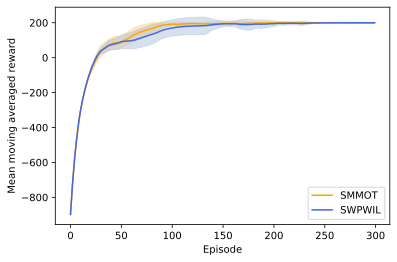

In [26]:
#final summary plot with 10 seeds 

plt.plot([r.ep for r in training_records_diff_len_wass_PWIL_seed1], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in training_records_diff_len_wass_PWIL_seed1],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in training_records_diff_len_wass_PWIL_seed1], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in training_records_diff_len_wass_PWIL_seed1],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)

plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['SMMOT', 'SWPWIL'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_diff_trajs_comparison_%s.png"%environment)

plt.show()

# deal with changes in mass of the cart 

In [4]:
trajectory_m = 'multiple_mass'
environment = 'CartPole-v0'
t_multiple_masses = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(trajectory_m,environment))

In [5]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [6]:
def main(environment, exp, seeds, simple = False, MMOT = False, wass_PWIL = False, PWIL = False):

    env = gym.make(environment)
    env.seed(seeds)

    action_dim = env.action_space.n
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0
    
    action_list = [i for i in range(action_dim)]
    

    for i_ep in tqdm(range(500)):

        rewards = []
        new_states = []
        old_states = []
        action_indexes = []

        score = 0
     
        state = env.reset() 
        state = np.array([-6.18010447e+00, -5.22830905e+00,  7.34760972e+00,
         5.29961320e+00])
        
        for t in range(200):
            action, action_index = agent.select_action(state)
            action = action_list[action_index]

        
            state_, reward, done, _ = env.step(action)
            score += reward
            old_states.append(state)

            env.render()
            #agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            action_indexes.append(action_index)
            rewards.append(reward)
            new_states.append(state_)

        states_tens = [torch.tensor(elt) for elt in old_states] #agent rollout 
        states_tens = torch.stack(states_tens).float()

        
        if MMOT is True :
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float(), torch.tensor(exp[1]).float(), torch.tensor(exp[2]).float(), torch.tensor(exp[3]).float(), torch.tensor(exp[4]).float()], num_projections = 50)
        
        elif simple is True : 
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float()], num_projections = 50)
            
        elif wass_PWIL is True : 
            pwil_exp = torch.tensor(concatenate_and_sample_cartpole(exp)).float()
            #pwil_exp = torch.tensor(concatenate_and_sample(exp)).float()
            rewards_multitask = rewarder_multi([states_tens, pwil_exp], num_projections = 50)
            
            
        for t in range(200):
            rewards[t] = torch.exp(-1*rewards_multitask[t,0])
            agent.store_transition(Transition(old_states[t], action_indexes[t], rewards[t], new_states[t]))

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )

    env.close()
    
    return training_records
    
    
    

In [26]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 123
    training_records_diff_mass_MMOT_seed1 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.1 score of current env 29.0
Ep 1 Average score: -805.39 score of current env 20.0
Ep 2 Average score: -722.951 score of current env 19.0
Ep 3 Average score: -648.2559000000001 score of current env 24.0
Ep 4 Average score: -582.4303100000001 score of current env 10.0
Ep 5 Average score: -521.9872790000001 score of current env 22.0
Ep 6 Average score: -466.3885511000001 score of current env 34.0
Ep 7 Average score: -417.94969599000007 score of current env 18.0
Ep 8 Average score: -374.7547263910001 score of current env 14.0
Ep 9 Average score: -334.77925375190006 score of current env 25.0
Ep 10 Average score: -300.10132837671006 score of current env 12.0
Ep 11 Average score: -268.49119553903904 score of current env 16.0
Ep 12 Average score: -240.34207598513512 score of current env 13.0
Ep 13 Average score: -215.4078683866216 score of current env 9.0
Ep 14 Average score: -192.86708154795946 score of current env 10.0
Ep 15 Average score: -172.6803733931635 score of

Ep 125 Average score: 88.76509657312621 score of current env 112.0
Ep 126 Average score: 99.88858691581359 score of current env 200.0
Ep 127 Average score: 98.39972822423223 score of current env 85.0
Ep 128 Average score: 100.65975540180901 score of current env 121.0
Ep 129 Average score: 99.6937798616281 score of current env 91.0
Ep 130 Average score: 98.02440187546529 score of current env 83.0
Ep 131 Average score: 99.42196168791877 score of current env 112.0
Ep 132 Average score: 109.47976551912689 score of current env 200.0
Ep 133 Average score: 105.13178896721419 score of current env 66.0
Ep 134 Average score: 101.81861007049278 score of current env 72.0
Ep 135 Average score: 97.8367490634435 score of current env 62.0
Ep 136 Average score: 95.15307415709916 score of current env 71.0
Ep 137 Average score: 93.43776674138924 score of current env 78.0
Ep 138 Average score: 91.89399006725031 score of current env 78.0
Ep 139 Average score: 91.1045910605253 score of current env 84.0
Ep 1

Ep 248 Average score: 163.05249248250848 score of current env 172.0
Ep 249 Average score: 166.74724323425764 score of current env 200.0
Ep 250 Average score: 166.67251891083188 score of current env 166.0
Ep 251 Average score: 170.0052670197487 score of current env 200.0
Ep 252 Average score: 166.30474031777382 score of current env 133.0
Ep 253 Average score: 167.47426628599646 score of current env 178.0
Ep 254 Average score: 166.9268396573968 score of current env 162.0
Ep 255 Average score: 166.33415569165712 score of current env 161.0
Ep 256 Average score: 164.7007401224914 score of current env 150.0
Ep 257 Average score: 168.23066611024225 score of current env 200.0
Ep 258 Average score: 166.60759949921803 score of current env 152.0
Ep 259 Average score: 165.1468395492962 score of current env 152.0
Ep 260 Average score: 168.6321555943666 score of current env 200.0
Ep 261 Average score: 168.26894003492993 score of current env 165.0
Ep 262 Average score: 168.24204603143696 score of cur

Ep 370 Average score: 195.4448393395863 score of current env 200.0
Ep 371 Average score: 195.9003554056277 score of current env 200.0
Ep 372 Average score: 196.31031986506494 score of current env 200.0
Ep 373 Average score: 196.67928787855845 score of current env 200.0
Ep 374 Average score: 195.31135909070264 score of current env 183.0
Ep 375 Average score: 195.78022318163238 score of current env 200.0
Ep 376 Average score: 193.80220086346915 score of current env 176.0
Ep 377 Average score: 194.12198077712225 score of current env 197.0
Ep 378 Average score: 193.50978269941004 score of current env 188.0
Ep 379 Average score: 194.15880442946903 score of current env 200.0
Ep 380 Average score: 194.74292398652213 score of current env 200.0
Ep 381 Average score: 194.66863158786992 score of current env 194.0
Ep 382 Average score: 195.20176842908293 score of current env 200.0
Ep 383 Average score: 194.48159158617466 score of current env 188.0
Ep 384 Average score: 195.0334324275572 score of c

Ep 492 Average score: 160.46813168196778 score of current env 142.0
Ep 493 Average score: 161.021318513771 score of current env 166.0
Ep 494 Average score: 157.9191866623939 score of current env 130.0
Ep 495 Average score: 158.32726799615452 score of current env 162.0
Ep 496 Average score: 158.2945411965391 score of current env 158.0
Ep 497 Average score: 160.26508707688518 score of current env 178.0
Ep 498 Average score: 158.23857836919666 score of current env 140.0
Ep 499 Average score: 155.714720532277 score of current env 133.0



In [27]:
pickle.dump(training_records_diff_mass_MMOT_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed1_%s.pkl'%environment, 'wb' ))

In [28]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 2111
    training_records_diff_mass_MMOT_seed2 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.4 score of current env 26.0
Ep 1 Average score: -805.16 score of current env 25.0
Ep 2 Average score: -723.044 score of current env 16.0
Ep 3 Average score: -649.0396 score of current env 17.0
Ep 4 Average score: -580.03564 score of current env 41.0
Ep 5 Average score: -520.3320759999999 score of current env 17.0
Ep 6 Average score: -465.89886839999997 score of current env 24.0
Ep 7 Average score: -416.20898156 score of current env 31.0
Ep 8 Average score: -373.188083404 score of current env 14.0
Ep 9 Average score: -329.8692750636 score of current env 60.0
Ep 10 Average score: -294.88234755724 score of current env 20.0
Ep 11 Average score: -264.49411280151605 score of current env 9.0
Ep 12 Average score: -237.04470152136446 score of current env 10.0
Ep 13 Average score: -212.440231369228 score of current env 9.0
Ep 14 Average score: -190.0962082323052 score of current env 11.0
Ep 15 Average score: -169.9865874090747 score of current env 11.0
Ep 16 Average scor

Ep 126 Average score: 78.9098791435457 score of current env 108.0
Ep 127 Average score: 86.71889122919113 score of current env 157.0
Ep 128 Average score: 93.24700210627202 score of current env 152.0
Ep 129 Average score: 99.52230189564483 score of current env 156.0
Ep 130 Average score: 109.57007170608036 score of current env 200.0
Ep 131 Average score: 117.41306453547232 score of current env 188.0
Ep 132 Average score: 124.8717580819251 score of current env 192.0
Ep 133 Average score: 131.38458227373258 score of current env 190.0
Ep 134 Average score: 138.24612404635934 score of current env 200.0
Ep 135 Average score: 144.4215116417234 score of current env 200.0
Ep 136 Average score: 147.67936047755106 score of current env 177.0
Ep 137 Average score: 152.91142442979594 score of current env 200.0
Ep 138 Average score: 154.22028198681636 score of current env 166.0
Ep 139 Average score: 156.89825378813472 score of current env 181.0
Ep 140 Average score: 160.80842840932124 score of curre

Ep 247 Average score: 174.2610473245207 score of current env 200.0
Ep 248 Average score: 176.83494259206861 score of current env 200.0
Ep 249 Average score: 179.15144833286175 score of current env 200.0
Ep 250 Average score: 181.23630349957557 score of current env 200.0
Ep 251 Average score: 178.01267314961802 score of current env 149.0
Ep 252 Average score: 180.21140583465623 score of current env 200.0
Ep 253 Average score: 168.19026525119062 score of current env 60.0
Ep 254 Average score: 166.07123872607156 score of current env 147.0
Ep 255 Average score: 169.4641148534644 score of current env 200.0
Ep 256 Average score: 159.01770336811796 score of current env 65.0
Ep 257 Average score: 148.5159330313062 score of current env 54.0
Ep 258 Average score: 137.16433972817558 score of current env 35.0
Ep 259 Average score: 127.84790575535803 score of current env 44.0
Ep 260 Average score: 121.36311517982223 score of current env 63.0
Ep 261 Average score: 113.72680366184001 score of current

Ep 370 Average score: 168.7184956982277 score of current env 180.0
Ep 371 Average score: 171.84664612840496 score of current env 200.0
Ep 372 Average score: 174.66198151556446 score of current env 200.0
Ep 373 Average score: 177.195783364008 score of current env 200.0
Ep 374 Average score: 179.47620502760722 score of current env 200.0
Ep 375 Average score: 181.5285845248465 score of current env 200.0
Ep 376 Average score: 183.37572607236186 score of current env 200.0
Ep 377 Average score: 185.03815346512567 score of current env 200.0
Ep 378 Average score: 186.5343381186131 score of current env 200.0
Ep 379 Average score: 187.8809043067518 score of current env 200.0
Ep 380 Average score: 189.09281387607663 score of current env 200.0
Ep 381 Average score: 173.88353248846897 score of current env 37.0
Ep 382 Average score: 162.09517923962207 score of current env 56.0
Ep 383 Average score: 165.88566131565986 score of current env 200.0
Ep 384 Average score: 169.29709518409388 score of curren

Ep 493 Average score: 120.6677457816817 score of current env 111.0
Ep 494 Average score: 120.20097120351355 score of current env 116.0
Ep 495 Average score: 118.48087408316219 score of current env 103.0
Ep 496 Average score: 119.63278667484597 score of current env 130.0
Ep 497 Average score: 119.06950800736138 score of current env 114.0
Ep 498 Average score: 117.96255720662523 score of current env 108.0
Ep 499 Average score: 124.96630148596272 score of current env 188.0



In [29]:
pickle.dump(training_records_diff_mass_MMOT_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed2_%s.pkl'%environment, 'wb' ))

In [30]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 3111
    training_records_diff_mass_MMOT_seed3 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.8 score of current env 12.0
Ep 1 Average score: -807.7199999999999 score of current env 12.0
Ep 2 Average score: -723.2479999999999 score of current env 37.0
Ep 3 Average score: -648.7231999999999 score of current env 22.0
Ep 4 Average score: -582.45088 score of current env 14.0
Ep 5 Average score: -521.305792 score of current env 29.0
Ep 6 Average score: -467.2752128 score of current env 19.0
Ep 7 Average score: -419.24769152 score of current env 13.0
Ep 8 Average score: -375.322922368 score of current env 20.0
Ep 9 Average score: -334.69063013119995 score of current env 31.0
Ep 10 Average score: -296.92156711807996 score of current env 43.0
Ep 11 Average score: -264.429410406272 score of current env 28.0
Ep 12 Average score: -236.58646936564477 score of current env 14.0
Ep 13 Average score: -211.8278224290803 score of current env 11.0
Ep 14 Average score: -188.0450401861723 score of current env 26.0
Ep 15 Average score: -167.04053616755508 score of current en

Ep 125 Average score: 147.13339544984223 score of current env 186.0
Ep 126 Average score: 148.820055904858 score of current env 164.0
Ep 127 Average score: 149.23805031437223 score of current env 153.0
Ep 128 Average score: 150.21424528293502 score of current env 159.0
Ep 129 Average score: 151.29282075464153 score of current env 161.0
Ep 130 Average score: 154.9635386791774 score of current env 188.0
Ep 131 Average score: 155.86718481125965 score of current env 164.0
Ep 132 Average score: 159.0804663301337 score of current env 188.0
Ep 133 Average score: 160.27241969712034 score of current env 171.0
Ep 134 Average score: 158.7451777274083 score of current env 145.0
Ep 135 Average score: 156.17065995466749 score of current env 133.0
Ep 136 Average score: 153.35359395920077 score of current env 128.0
Ep 137 Average score: 155.11823456328068 score of current env 171.0
Ep 138 Average score: 159.6064111069526 score of current env 200.0
Ep 139 Average score: 155.04576999625735 score of curr

Ep 247 Average score: 150.01368798318617 score of current env 119.0
Ep 248 Average score: 146.11231918486754 score of current env 111.0
Ep 249 Average score: 143.9010872663808 score of current env 124.0
Ep 250 Average score: 141.81097853974273 score of current env 123.0
Ep 251 Average score: 138.82988068576847 score of current env 112.0
Ep 252 Average score: 140.1468926171916 score of current env 152.0
Ep 253 Average score: 141.53220335547246 score of current env 154.0
Ep 254 Average score: 146.4789830199252 score of current env 191.0
Ep 255 Average score: 148.03108471793269 score of current env 162.0
Ep 256 Average score: 147.92797624613942 score of current env 147.0
Ep 257 Average score: 147.63517862152548 score of current env 145.0
Ep 258 Average score: 146.97166075937292 score of current env 141.0
Ep 259 Average score: 147.67449468343565 score of current env 154.0
Ep 260 Average score: 152.9070452150921 score of current env 200.0
Ep 261 Average score: 155.71634069358288 score of cu

Ep 369 Average score: 178.0553138769121 score of current env 200.0
Ep 370 Average score: 180.24978248922088 score of current env 200.0
Ep 371 Average score: 182.2248042402988 score of current env 200.0
Ep 372 Average score: 184.00232381626893 score of current env 200.0
Ep 373 Average score: 185.60209143464203 score of current env 200.0
Ep 374 Average score: 187.04188229117784 score of current env 200.0
Ep 375 Average score: 188.33769406206005 score of current env 200.0
Ep 376 Average score: 189.50392465585406 score of current env 200.0
Ep 377 Average score: 186.45353219026867 score of current env 159.0
Ep 378 Average score: 187.8081789712418 score of current env 200.0
Ep 379 Average score: 185.72736107411762 score of current env 167.0
Ep 380 Average score: 187.15462496670585 score of current env 200.0
Ep 381 Average score: 176.63916247003527 score of current env 82.0
Ep 382 Average score: 169.47524622303175 score of current env 105.0
Ep 383 Average score: 172.52772160072857 score of cu

Ep 490 Average score: 139.70857749174607 score of current env 128.0
Ep 491 Average score: 136.03771974257148 score of current env 103.0
Ep 492 Average score: 134.03394776831433 score of current env 116.0
Ep 493 Average score: 132.1305529914829 score of current env 115.0
Ep 494 Average score: 130.6174976923346 score of current env 117.0
Ep 495 Average score: 127.15574792310116 score of current env 96.0
Ep 496 Average score: 123.34017313079106 score of current env 89.0
Ep 497 Average score: 121.20615581771196 score of current env 102.0
Ep 498 Average score: 119.98554023594077 score of current env 109.0
Ep 499 Average score: 119.58698621234669 score of current env 116.0



In [31]:
pickle.dump(training_records_diff_mass_MMOT_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed3_%s.pkl'%environment, 'wb' ))

In [78]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1234567890987654321
    training_records_diff_mass_MMOT_seed4 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -807.4599999999999 score of current env 11.0
Ep 2 Average score: -719.414 score of current env 73.0
Ep 3 Average score: -642.5726000000001 score of current env 49.0
Ep 4 Average score: -576.1153400000001 score of current env 22.0
Ep 5 Average score: -517.2038060000001 score of current env 13.0
Ep 6 Average score: -463.5834254000001 score of current env 19.0
Ep 7 Average score: -413.0250828600001 score of current env 42.0
Ep 8 Average score: -368.6225745740001 score of current env 31.0
Ep 9 Average score: -330.6603171166001 score of current env 11.0
Ep 10 Average score: -296.49428540494006 score of current env 11.0
Ep 11 Average score: -265.9448568644461 score of current env 9.0
Ep 12 Average score: -238.45037117800146 score of current env 9.0
Ep 13 Average score: -213.60533406020133 score of current env 10.0
Ep 14 Average score: -191.1448006541812 score of current env 11.0
Ep 15 Average score: -171.13032058876308 

Ep 125 Average score: 119.25961563362291 score of current env 155.0
Ep 126 Average score: 118.13365407026062 score of current env 108.0
Ep 127 Average score: 120.02028866323457 score of current env 137.0
Ep 128 Average score: 120.21825979691111 score of current env 122.0
Ep 129 Average score: 126.29643381721999 score of current env 181.0
Ep 130 Average score: 133.666790435498 score of current env 200.0
Ep 131 Average score: 137.4001113919482 score of current env 171.0
Ep 132 Average score: 143.66010025275338 score of current env 200.0
Ep 133 Average score: 149.29409022747805 score of current env 200.0
Ep 134 Average score: 154.36468120473026 score of current env 200.0
Ep 135 Average score: 158.92821308425724 score of current env 200.0
Ep 136 Average score: 152.23539177583152 score of current env 92.0
Ep 137 Average score: 157.01185259824837 score of current env 200.0
Ep 138 Average score: 152.41066733842354 score of current env 111.0
Ep 139 Average score: 148.06960060458118 score of cu

Ep 248 Average score: 186.61575383451697 score of current env 200.0
Ep 249 Average score: 187.95417845106527 score of current env 200.0
Ep 250 Average score: 185.85876060595874 score of current env 167.0
Ep 251 Average score: 187.27288454536287 score of current env 200.0
Ep 252 Average score: 188.5455960908266 score of current env 200.0
Ep 253 Average score: 189.69103648174394 score of current env 200.0
Ep 254 Average score: 190.72193283356955 score of current env 200.0
Ep 255 Average score: 177.94973955021263 score of current env 63.0
Ep 256 Average score: 172.15476559519138 score of current env 120.0
Ep 257 Average score: 174.93928903567223 score of current env 200.0
Ep 258 Average score: 166.045360132105 score of current env 86.0
Ep 259 Average score: 169.4408241188945 score of current env 200.0
Ep 260 Average score: 172.49674170700507 score of current env 200.0
Ep 261 Average score: 175.24706753630457 score of current env 200.0
Ep 262 Average score: 177.72236078267412 score of curr

Ep 371 Average score: 52.65275146875215 score of current env 17.0
Ep 372 Average score: 50.38747632187694 score of current env 30.0
Ep 373 Average score: 51.248728689689244 score of current env 59.0
Ep 374 Average score: 48.02385582072032 score of current env 19.0
Ep 375 Average score: 55.72147023864829 score of current env 125.0
Ep 376 Average score: 59.74932321478346 score of current env 96.0
Ep 377 Average score: 61.87439089330512 score of current env 81.0
Ep 378 Average score: 59.18695180397461 score of current env 35.0
Ep 379 Average score: 60.36825662357715 score of current env 71.0
Ep 380 Average score: 65.33143096121944 score of current env 110.0
Ep 381 Average score: 69.9982878650975 score of current env 112.0
Ep 382 Average score: 73.39845907858775 score of current env 104.0
Ep 383 Average score: 80.35861317072897 score of current env 143.0
Ep 384 Average score: 84.62275185365607 score of current env 123.0
Ep 385 Average score: 96.16047666829047 score of current env 200.0
Ep 

Ep 493 Average score: 199.71530540022525 score of current env 200.0
Ep 494 Average score: 199.74377486020273 score of current env 200.0
Ep 495 Average score: 199.76939737418246 score of current env 200.0
Ep 496 Average score: 199.79245763676423 score of current env 200.0
Ep 497 Average score: 199.8132118730878 score of current env 200.0
Ep 498 Average score: 199.83189068577903 score of current env 200.0
Ep 499 Average score: 199.84870161720113 score of current env 200.0



In [79]:
pickle.dump(training_records_diff_mass_MMOT_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed4_%s.pkl'%environment, 'wb' ))

In [34]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1234567890987654321
    training_records_diff_mass_MMOT_seed5 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.1 score of current env 29.0
Ep 1 Average score: -804.89 score of current env 25.0
Ep 2 Average score: -722.3009999999999 score of current env 21.0
Ep 3 Average score: -647.4708999999999 score of current env 26.0
Ep 4 Average score: -581.42381 score of current env 13.0
Ep 5 Average score: -521.681429 score of current env 16.0
Ep 6 Average score: -468.11328610000004 score of current env 14.0
Ep 7 Average score: -420.00195749000005 score of current env 13.0
Ep 8 Average score: -375.30176174100006 score of current env 27.0
Ep 9 Average score: -336.3715855669001 score of current env 14.0
Ep 10 Average score: -300.3344270102101 score of current env 24.0
Ep 11 Average score: -269.3009843091891 score of current env 10.0
Ep 12 Average score: -241.4708858782702 score of current env 9.0
Ep 13 Average score: -216.42379729044316 score of current env 9.0
Ep 14 Average score: -193.78141756139885 score of current env 10.0
Ep 15 Average score: -173.20327580525898 score of curre

Ep 126 Average score: 102.66786796187554 score of current env 143.0
Ep 127 Average score: 108.00108116568799 score of current env 156.0
Ep 128 Average score: 112.5009730491192 score of current env 153.0
Ep 129 Average score: 115.75087574420728 score of current env 145.0
Ep 130 Average score: 118.27578816978655 score of current env 141.0
Ep 131 Average score: 120.0482093528079 score of current env 136.0
Ep 132 Average score: 121.94338841752712 score of current env 139.0
Ep 133 Average score: 125.34904957577442 score of current env 156.0
Ep 134 Average score: 127.21414461819698 score of current env 144.0
Ep 135 Average score: 128.59273015637729 score of current env 141.0
Ep 136 Average score: 134.13345714073955 score of current env 184.0
Ep 137 Average score: 140.7201114266656 score of current env 200.0
Ep 138 Average score: 141.74810028399904 score of current env 151.0
Ep 139 Average score: 147.57329025559915 score of current env 200.0
Ep 140 Average score: 152.81596123003925 score of c

Ep 248 Average score: 197.4815772434951 score of current env 200.0
Ep 249 Average score: 197.7334195191456 score of current env 200.0
Ep 250 Average score: 197.96007756723105 score of current env 200.0
Ep 251 Average score: 198.16406981050795 score of current env 200.0
Ep 252 Average score: 198.34766282945716 score of current env 200.0
Ep 253 Average score: 198.51289654651146 score of current env 200.0
Ep 254 Average score: 198.66160689186032 score of current env 200.0
Ep 255 Average score: 198.7954462026743 score of current env 200.0
Ep 256 Average score: 198.91590158240686 score of current env 200.0
Ep 257 Average score: 199.02431142416617 score of current env 200.0
Ep 258 Average score: 199.12188028174955 score of current env 200.0
Ep 259 Average score: 199.20969225357462 score of current env 200.0
Ep 260 Average score: 199.28872302821716 score of current env 200.0
Ep 261 Average score: 199.35985072539546 score of current env 200.0
Ep 262 Average score: 199.4238656528559 score of cu

Ep 370 Average score: 82.10659133867077 score of current env 76.0
Ep 371 Average score: 93.8959322048037 score of current env 200.0
Ep 372 Average score: 94.90633898432334 score of current env 104.0
Ep 373 Average score: 105.415705085891 score of current env 200.0
Ep 374 Average score: 114.8741345773019 score of current env 200.0
Ep 375 Average score: 123.38672111957172 score of current env 200.0
Ep 376 Average score: 116.64804900761455 score of current env 56.0
Ep 377 Average score: 123.6832441068531 score of current env 187.0
Ep 378 Average score: 131.3149196961678 score of current env 200.0
Ep 379 Average score: 124.88342772655103 score of current env 67.0
Ep 380 Average score: 132.39508495389595 score of current env 200.0
Ep 381 Average score: 127.15557645850636 score of current env 80.0
Ep 382 Average score: 119.94001881265572 score of current env 55.0
Ep 383 Average score: 113.54601693139014 score of current env 56.0
Ep 384 Average score: 122.19141523825112 score of current env 2

Ep 492 Average score: 198.72544987886377 score of current env 200.0
Ep 493 Average score: 198.85290489097738 score of current env 200.0
Ep 494 Average score: 198.96761440187964 score of current env 200.0
Ep 495 Average score: 199.07085296169168 score of current env 200.0
Ep 496 Average score: 199.16376766552253 score of current env 200.0
Ep 497 Average score: 199.24739089897028 score of current env 200.0
Ep 498 Average score: 199.32265180907325 score of current env 200.0
Ep 499 Average score: 199.39038662816594 score of current env 200.0



In [35]:
pickle.dump(training_records_diff_mass_MMOT_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed5_%s.pkl'%environment, 'wb' ))

In [36]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 4444444444
    training_records_diff_mass_MMOT_seed6 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -805.4300000000001 score of current env 34.0
Ep 2 Average score: -723.9870000000001 score of current env 9.0
Ep 3 Average score: -650.1883000000001 score of current env 14.0
Ep 4 Average score: -584.2694700000002 score of current env 9.0
Ep 5 Average score: -524.0425230000002 score of current env 18.0
Ep 6 Average score: -469.4382707000002 score of current env 22.0
Ep 7 Average score: -421.3944436300002 score of current env 11.0
Ep 8 Average score: -376.65499926700016 score of current env 26.0
Ep 9 Average score: -337.8894993403001 score of current env 11.0
Ep 10 Average score: -303.00054940627007 score of current env 11.0
Ep 11 Average score: -269.2004944656431 score of current env 35.0
Ep 12 Average score: -240.8804450190788 score of current env 14.0
Ep 13 Average score: -214.1924005171709 score of current env 26.0
Ep 14 Average score: -191.67316046545383 score of current env 11.0
Ep 15 Average score: -171.60584

Ep 125 Average score: 145.36660128847197 score of current env 192.0
Ep 126 Average score: 148.02994115962477 score of current env 172.0
Ep 127 Average score: 151.52694704366232 score of current env 183.0
Ep 128 Average score: 155.97425233929607 score of current env 196.0
Ep 129 Average score: 160.37682710536646 score of current env 200.0
Ep 130 Average score: 161.9391443948298 score of current env 176.0
Ep 131 Average score: 163.44522995534683 score of current env 177.0
Ep 132 Average score: 165.60070695981216 score of current env 185.0
Ep 133 Average score: 168.84063626383096 score of current env 198.0
Ep 134 Average score: 168.55657263744786 score of current env 166.0
Ep 135 Average score: 169.1009153737031 score of current env 174.0
Ep 136 Average score: 172.19082383633278 score of current env 200.0
Ep 137 Average score: 174.97174145269952 score of current env 200.0
Ep 138 Average score: 174.77456730742958 score of current env 173.0
Ep 139 Average score: 177.29711057668663 score of 

Ep 247 Average score: 103.60519890362852 score of current env 79.0
Ep 248 Average score: 102.84467901326568 score of current env 96.0
Ep 249 Average score: 99.36021111193911 score of current env 68.0
Ep 250 Average score: 103.1241900007452 score of current env 137.0
Ep 251 Average score: 102.61177100067069 score of current env 98.0
Ep 252 Average score: 101.35059390060361 score of current env 90.0
Ep 253 Average score: 96.91553451054325 score of current env 57.0
Ep 254 Average score: 99.72398105948893 score of current env 125.0
Ep 255 Average score: 102.05158295354003 score of current env 123.0
Ep 256 Average score: 104.04642465818604 score of current env 122.0
Ep 257 Average score: 109.34178219236745 score of current env 157.0
Ep 258 Average score: 114.7076039731307 score of current env 163.0
Ep 259 Average score: 111.93684357581763 score of current env 87.0
Ep 260 Average score: 117.74315921823587 score of current env 170.0
Ep 261 Average score: 125.96884329641229 score of current en

Ep 370 Average score: 118.73896667004678 score of current env 121.0
Ep 371 Average score: 118.26507000304211 score of current env 114.0
Ep 372 Average score: 119.5385630027379 score of current env 131.0
Ep 373 Average score: 120.18470670246413 score of current env 126.0
Ep 374 Average score: 120.46623603221771 score of current env 123.0
Ep 375 Average score: 120.51961242899594 score of current env 121.0
Ep 376 Average score: 118.86765118609635 score of current env 104.0
Ep 377 Average score: 119.08088606748672 score of current env 121.0
Ep 378 Average score: 119.77279746073805 score of current env 126.0
Ep 379 Average score: 121.59551771466424 score of current env 138.0
Ep 380 Average score: 125.13596594319782 score of current env 157.0
Ep 381 Average score: 127.52236934887804 score of current env 149.0
Ep 382 Average score: 130.07013241399025 score of current env 153.0
Ep 383 Average score: 133.96311917259123 score of current env 169.0
Ep 384 Average score: 136.2668072553321 score of 

Ep 492 Average score: 153.68335500630258 score of current env 127.0
Ep 493 Average score: 150.61501950567234 score of current env 123.0
Ep 494 Average score: 153.45351755510512 score of current env 179.0
Ep 495 Average score: 152.8081657995946 score of current env 147.0
Ep 496 Average score: 156.02734921963514 score of current env 185.0
Ep 497 Average score: 160.42461429767164 score of current env 200.0
Ep 498 Average score: 164.38215286790447 score of current env 200.0
Ep 499 Average score: 163.04393758111402 score of current env 151.0



In [37]:
pickle.dump(training_records_diff_mass_MMOT_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed6_%s.pkl'%environment, 'wb' ))

In [38]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 654388888
    training_records_diff_mass_MMOT_seed7 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.9800000000001 score of current env 14.0
Ep 2 Average score: -722.9820000000002 score of current env 33.0
Ep 3 Average score: -648.8838000000003 score of current env 18.0
Ep 4 Average score: -582.1954200000004 score of current env 18.0
Ep 5 Average score: -522.4758780000003 score of current env 15.0
Ep 6 Average score: -468.3282902000003 score of current env 19.0
Ep 7 Average score: -419.89546118000027 score of current env 16.0
Ep 8 Average score: -376.70591506200026 score of current env 12.0
Ep 9 Average score: -336.9353235558002 score of current env 21.0
Ep 10 Average score: -301.2417912002202 score of current env 20.0
Ep 11 Average score: -269.51761208019815 score of current env 16.0
Ep 12 Average score: -241.16585087217834 score of current env 14.0
Ep 13 Average score: -214.6492657849605 score of current env 24.0
Ep 14 Average score: -191.88433920646446 score of current env 13.0
Ep 15 Average score: -171.4

Ep 125 Average score: 81.85741362098105 score of current env 77.0
Ep 126 Average score: 79.67167225888295 score of current env 60.0
Ep 127 Average score: 77.50450503299466 score of current env 58.0
Ep 128 Average score: 76.9540545296952 score of current env 72.0
Ep 129 Average score: 74.95864907672568 score of current env 57.0
Ep 130 Average score: 73.36278416905311 score of current env 59.0
Ep 131 Average score: 74.3265057521478 score of current env 83.0
Ep 132 Average score: 73.49385517693301 score of current env 66.0
Ep 133 Average score: 72.24446965923971 score of current env 61.0
Ep 134 Average score: 71.62002269331573 score of current env 66.0
Ep 135 Average score: 70.55802042398416 score of current env 61.0
Ep 136 Average score: 70.50221838158575 score of current env 70.0
Ep 137 Average score: 70.65199654342717 score of current env 72.0
Ep 138 Average score: 69.18679688908446 score of current env 56.0
Ep 139 Average score: 68.16811720017601 score of current env 59.0
Ep 140 Avera

Ep 248 Average score: 129.4540107216886 score of current env 163.0
Ep 249 Average score: 125.90860964951975 score of current env 94.0
Ep 250 Average score: 133.3177486845678 score of current env 200.0
Ep 251 Average score: 127.08597381611101 score of current env 71.0
Ep 252 Average score: 122.37737643449991 score of current env 80.0
Ep 253 Average score: 117.73963879104991 score of current env 76.0
Ep 254 Average score: 115.46567491194493 score of current env 95.0
Ep 255 Average score: 113.01910742075043 score of current env 91.0
Ep 256 Average score: 108.1171966786754 score of current env 64.0
Ep 257 Average score: 104.20547701080787 score of current env 69.0
Ep 258 Average score: 100.78492930972709 score of current env 70.0
Ep 259 Average score: 98.70643637875439 score of current env 80.0
Ep 260 Average score: 96.23579274087896 score of current env 74.0
Ep 261 Average score: 93.01221346679108 score of current env 64.0
Ep 262 Average score: 93.81099212011199 score of current env 101.0

Ep 371 Average score: 195.29929408560028 score of current env 200.0
Ep 372 Average score: 195.76936467704024 score of current env 200.0
Ep 373 Average score: 196.1924282093362 score of current env 200.0
Ep 374 Average score: 196.5731853884026 score of current env 200.0
Ep 375 Average score: 196.91586684956235 score of current env 200.0
Ep 376 Average score: 197.2242801646061 score of current env 200.0
Ep 377 Average score: 197.5018521481455 score of current env 200.0
Ep 378 Average score: 197.75166693333097 score of current env 200.0
Ep 379 Average score: 197.97650023999788 score of current env 200.0
Ep 380 Average score: 198.1788502159981 score of current env 200.0
Ep 381 Average score: 198.3609651943983 score of current env 200.0
Ep 382 Average score: 198.52486867495847 score of current env 200.0
Ep 383 Average score: 198.6723818074626 score of current env 200.0
Ep 384 Average score: 198.80514362671636 score of current env 200.0
Ep 385 Average score: 198.92462926404474 score of curre

Ep 494 Average score: 163.60562772127457 score of current env 200.0
Ep 495 Average score: 167.24506494914712 score of current env 200.0
Ep 496 Average score: 170.5205584542324 score of current env 200.0
Ep 497 Average score: 173.46850260880916 score of current env 200.0
Ep 498 Average score: 176.12165234792826 score of current env 200.0
Ep 499 Average score: 178.50948711313544 score of current env 200.0



In [39]:
pickle.dump(training_records_diff_mass_MMOT_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed7_%s.pkl'%environment, 'wb' ))

In [40]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1
    training_records_diff_mass_MMOT_seed8 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -897.3 score of current env 27.0
Ep 1 Average score: -800.27 score of current env 73.0
Ep 2 Average score: -718.543 score of current env 17.0
Ep 3 Average score: -645.6887 score of current env 10.0
Ep 4 Average score: -577.5198300000001 score of current env 36.0
Ep 5 Average score: -515.2678470000001 score of current env 45.0
Ep 6 Average score: -462.5410623000001 score of current env 12.0
Ep 7 Average score: -412.0869560700001 score of current env 42.0
Ep 8 Average score: -369.5782604630001 score of current env 13.0
Ep 9 Average score: -325.6204344167001 score of current env 70.0
Ep 10 Average score: -290.95839097503006 score of current env 21.0
Ep 11 Average score: -260.46255187752706 score of current env 14.0
Ep 12 Average score: -233.21629668977437 score of current env 12.0
Ep 13 Average score: -208.59466702079692 score of current env 13.0
Ep 14 Average score: -186.63520031871724 score of current env 11.0
Ep 15 Average score: -167.07168028684552 score of current

Ep 126 Average score: 67.39942257838487 score of current env 90.0
Ep 127 Average score: 65.45948032054639 score of current env 48.0
Ep 128 Average score: 64.01353228849175 score of current env 51.0
Ep 129 Average score: 64.61217905964257 score of current env 70.0
Ep 130 Average score: 65.15096115367831 score of current env 70.0
Ep 131 Average score: 73.93586503831048 score of current env 153.0
Ep 132 Average score: 75.84227853447943 score of current env 93.0
Ep 133 Average score: 77.1580506810315 score of current env 89.0
Ep 134 Average score: 80.14224561292835 score of current env 107.0
Ep 135 Average score: 81.82802105163552 score of current env 97.0
Ep 136 Average score: 82.04521894647198 score of current env 84.0
Ep 137 Average score: 82.14069705182477 score of current env 83.0
Ep 138 Average score: 87.0266273466423 score of current env 131.0
Ep 139 Average score: 91.22396461197808 score of current env 129.0
Ep 140 Average score: 93.00156815078027 score of current env 109.0
Ep 141 

Ep 249 Average score: 110.9900631689975 score of current env 81.0
Ep 250 Average score: 109.39105685209775 score of current env 95.0
Ep 251 Average score: 118.45195116688798 score of current env 200.0
Ep 252 Average score: 125.50675605019919 score of current env 189.0
Ep 253 Average score: 131.05608044517928 score of current env 181.0
Ep 254 Average score: 136.45047240066134 score of current env 185.0
Ep 255 Average score: 130.10542516059522 score of current env 73.0
Ep 256 Average score: 126.7948826445357 score of current env 97.0
Ep 257 Average score: 122.61539438008214 score of current env 85.0
Ep 258 Average score: 117.55385494207393 score of current env 72.0
Ep 259 Average score: 112.69846944786654 score of current env 69.0
Ep 260 Average score: 119.6286225030799 score of current env 182.0
Ep 261 Average score: 116.56576025277191 score of current env 89.0
Ep 262 Average score: 123.10918422749472 score of current env 182.0
Ep 263 Average score: 119.99826580474526 score of current e

Ep 371 Average score: 145.00584552077856 score of current env 132.0
Ep 372 Average score: 141.80526096870074 score of current env 113.0
Ep 373 Average score: 137.02473487183067 score of current env 94.0
Ep 374 Average score: 134.0222613846476 score of current env 107.0
Ep 375 Average score: 132.52003524618286 score of current env 119.0
Ep 376 Average score: 132.06803172156458 score of current env 128.0
Ep 377 Average score: 131.26122854940812 score of current env 124.0
Ep 378 Average score: 129.1351056944673 score of current env 110.0
Ep 379 Average score: 126.22159512502058 score of current env 100.0
Ep 380 Average score: 123.99943561251854 score of current env 104.0
Ep 381 Average score: 125.6994920512667 score of current env 141.0
Ep 382 Average score: 124.52954284614005 score of current env 114.0
Ep 383 Average score: 125.37658856152603 score of current env 133.0
Ep 384 Average score: 124.13892970537343 score of current env 113.0
Ep 385 Average score: 125.42503673483608 score of cu

Ep 493 Average score: 199.9904969313732 score of current env 200.0
Ep 494 Average score: 199.99144723823588 score of current env 200.0
Ep 495 Average score: 199.9923025144123 score of current env 200.0
Ep 496 Average score: 199.99307226297108 score of current env 200.0
Ep 497 Average score: 199.99376503667398 score of current env 200.0
Ep 498 Average score: 199.99438853300657 score of current env 200.0
Ep 499 Average score: 199.9949496797059 score of current env 200.0



In [41]:
pickle.dump(training_records_diff_mass_MMOT_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed8_%s.pkl'%environment, 'wb' ))

In [7]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1234567890987654321
    training_records_diff_mass_MMOT_seed9 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -805.66 score of current env 29.0
Ep 2 Average score: -723.0939999999999 score of current env 20.0
Ep 3 Average score: -649.2846 score of current env 15.0
Ep 4 Average score: -582.25614 score of current env 21.0
Ep 5 Average score: -521.930526 score of current env 21.0
Ep 6 Average score: -468.0374734 score of current env 17.0
Ep 7 Average score: -419.33372606000006 score of current env 19.0
Ep 8 Average score: -375.4003534540001 score of current env 20.0
Ep 9 Average score: -334.7603181086001 score of current env 31.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -298.6842862977401 score of current env 26.0
Ep 11 Average score: -267.6158576679661 score of current env 12.0
Ep 12 Average score: -239.75427190116952 score of current env 11.0
Ep 13 Average score: -214.87884471105255 score of current env 9.0
Ep 14 Average score: -192.5909602399473 score of current env 8.0
Ep 15 Average score: -172.33186421595258 score of current env 10.0
Ep 16 Average score: -154.09867779435731 score of current env 10.0
Ep 17 Average score: -137.6888100149216 score of current env 10.0
Ep 18 Average score: -123.01992901342942 score of current env 9.0
Ep 19 Average score: -109.51793611208647 score of current env 12.0
Ep 20 Average score: -97.26614250087783 score of current env 13.0
Ep 21 Average score: -84.33952825079005 score of current env 32.0
Ep 22 Average score: -74.80557542571106 score of current env 11.0
Ep 23 Average score: -64.32501788313995 score of current env 30.0
Ep 24 Average score: -55.692516094825955 score of current env 22.0
Ep 25 

Ep 135 Average score: 71.82227089435133 score of current env 43.0
Ep 136 Average score: 84.6400438049162 score of current env 200.0
Ep 137 Average score: 82.37603942442459 score of current env 62.0
Ep 138 Average score: 78.03843548198213 score of current env 39.0
Ep 139 Average score: 75.93459193378392 score of current env 57.0
Ep 140 Average score: 73.14113274040552 score of current env 48.0
Ep 141 Average score: 75.02701946636498 score of current env 92.0
Ep 142 Average score: 71.42431751972849 score of current env 39.0
Ep 143 Average score: 77.28188576775564 score of current env 130.0
Ep 144 Average score: 74.35369719098007 score of current env 48.0
Ep 145 Average score: 72.71832747188206 score of current env 58.0
Ep 146 Average score: 72.84649472469387 score of current env 74.0
Ep 147 Average score: 73.46184525222449 score of current env 79.0
Ep 148 Average score: 71.11566072700205 score of current env 50.0
Ep 149 Average score: 68.80409465430185 score of current env 48.0
Ep 150 Av

Ep 257 Average score: 199.65875698904983 score of current env 200.0
Ep 258 Average score: 199.69288129014487 score of current env 200.0
Ep 259 Average score: 199.7235931611304 score of current env 200.0
Ep 260 Average score: 199.75123384501737 score of current env 200.0
Ep 261 Average score: 199.77611046051564 score of current env 200.0
Ep 262 Average score: 199.7984994144641 score of current env 200.0
Ep 263 Average score: 199.81864947301767 score of current env 200.0
Ep 264 Average score: 199.8367845257159 score of current env 200.0
Ep 265 Average score: 199.85310607314432 score of current env 200.0
Ep 266 Average score: 199.8677954658299 score of current env 200.0
Ep 267 Average score: 199.8810159192469 score of current env 200.0
Ep 268 Average score: 199.89291432732222 score of current env 200.0
Ep 269 Average score: 199.90362289459 score of current env 200.0
Ep 270 Average score: 199.913260605131 score of current env 200.0
Ep 271 Average score: 199.9219345446179 score of current e

Ep 379 Average score: 199.95760794913915 score of current env 200.0
Ep 380 Average score: 199.96184715422524 score of current env 200.0
Ep 381 Average score: 199.96566243880272 score of current env 200.0
Ep 382 Average score: 199.96909619492246 score of current env 200.0
Ep 383 Average score: 199.97218657543021 score of current env 200.0
Ep 384 Average score: 199.9749679178872 score of current env 200.0
Ep 385 Average score: 199.9774711260985 score of current env 200.0
Ep 386 Average score: 199.97972401348864 score of current env 200.0
Ep 387 Average score: 199.9817516121398 score of current env 200.0
Ep 388 Average score: 199.98357645092582 score of current env 200.0
Ep 389 Average score: 199.98521880583326 score of current env 200.0
Ep 390 Average score: 199.98669692524993 score of current env 200.0
Ep 391 Average score: 199.98802723272493 score of current env 200.0
Ep 392 Average score: 199.98922450945244 score of current env 200.0
Ep 393 Average score: 199.9903020585072 score of cu

In [8]:
pickle.dump(training_records_diff_mass_MMOT_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed9_%s.pkl'%environment, 'wb' ))

In [44]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 2233445566
    training_records_diff_mass_MMOT_seed10 = main(environment, exp, seeds, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -898.2 score of current env 18.0
Ep 1 Average score: -806.9800000000001 score of current env 14.0
Ep 2 Average score: -722.5820000000001 score of current env 37.0
Ep 3 Average score: -647.3238000000001 score of current env 30.0
Ep 4 Average score: -580.7914200000001 score of current env 18.0
Ep 5 Average score: -520.3122780000001 score of current env 24.0
Ep 6 Average score: -466.2810502000001 score of current env 20.0
Ep 7 Average score: -418.1529451800001 score of current env 15.0
Ep 8 Average score: -374.0376506620001 score of current env 23.0
Ep 9 Average score: -332.5338855958001 score of current env 41.0
Ep 10 Average score: -296.9804970362201 score of current env 23.0
Ep 11 Average score: -264.78244733259805 score of current env 25.0
Ep 12 Average score: -237.20420259933826 score of current env 11.0
Ep 13 Average score: -212.38378233940443 score of current env 11.0
Ep 14 Average score: -189.84540410546398 score of current env 13.0
Ep 15 Average score: -169.56

Ep 125 Average score: 38.224485520830434 score of current env 40.0
Ep 126 Average score: 40.90203696874739 score of current env 65.0
Ep 127 Average score: 40.71183327187265 score of current env 39.0
Ep 128 Average score: 45.640649944685386 score of current env 90.0
Ep 129 Average score: 45.57658495021685 score of current env 45.0
Ep 130 Average score: 48.31892645519517 score of current env 73.0
Ep 131 Average score: 59.08703380967565 score of current env 156.0
Ep 132 Average score: 58.37833042870809 score of current env 52.0
Ep 133 Average score: 63.94049738583728 score of current env 114.0
Ep 134 Average score: 72.64644764725355 score of current env 151.0
Ep 135 Average score: 85.3818028825282 score of current env 200.0
Ep 136 Average score: 89.04362259427539 score of current env 122.0
Ep 137 Average score: 100.13926033484785 score of current env 200.0
Ep 138 Average score: 101.42533430136307 score of current env 113.0
Ep 139 Average score: 105.48280087122676 score of current env 142.

Ep 247 Average score: 191.45335154067823 score of current env 200.0
Ep 248 Average score: 192.3080163866104 score of current env 200.0
Ep 249 Average score: 193.07721474794937 score of current env 200.0
Ep 250 Average score: 193.76949327315444 score of current env 200.0
Ep 251 Average score: 194.392543945839 score of current env 200.0
Ep 252 Average score: 194.95328955125512 score of current env 200.0
Ep 253 Average score: 195.45796059612962 score of current env 200.0
Ep 254 Average score: 195.91216453651666 score of current env 200.0
Ep 255 Average score: 196.320948082865 score of current env 200.0
Ep 256 Average score: 196.6888532745785 score of current env 200.0
Ep 257 Average score: 197.01996794712065 score of current env 200.0
Ep 258 Average score: 197.31797115240857 score of current env 200.0
Ep 259 Average score: 197.58617403716772 score of current env 200.0
Ep 260 Average score: 196.22755663345097 score of current env 184.0
Ep 261 Average score: 196.60480097010588 score of curr

Ep 369 Average score: 199.90930301098084 score of current env 200.0
Ep 370 Average score: 199.91837270988276 score of current env 200.0
Ep 371 Average score: 199.9265354388945 score of current env 200.0
Ep 372 Average score: 199.93388189500504 score of current env 200.0
Ep 373 Average score: 199.94049370550454 score of current env 200.0
Ep 374 Average score: 199.9464443349541 score of current env 200.0
Ep 375 Average score: 199.95179990145868 score of current env 200.0
Ep 376 Average score: 199.95661991131283 score of current env 200.0
Ep 377 Average score: 199.96095792018156 score of current env 200.0
Ep 378 Average score: 199.96486212816342 score of current env 200.0
Ep 379 Average score: 199.96837591534708 score of current env 200.0
Ep 380 Average score: 199.97153832381238 score of current env 200.0
Ep 381 Average score: 199.97438449143115 score of current env 200.0
Ep 382 Average score: 199.97694604228803 score of current env 200.0
Ep 383 Average score: 199.97925143805924 score of 

Ep 491 Average score: 153.34462087113485 score of current env 159.0
Ep 492 Average score: 153.51015878402137 score of current env 155.0
Ep 493 Average score: 153.55914290561924 score of current env 154.0
Ep 494 Average score: 153.20322861505733 score of current env 150.0
Ep 495 Average score: 152.9829057535516 score of current env 151.0
Ep 496 Average score: 154.18461517819642 score of current env 165.0
Ep 497 Average score: 155.16615366037678 score of current env 164.0
Ep 498 Average score: 156.4495382943391 score of current env 168.0
Ep 499 Average score: 157.00458446490518 score of current env 162.0



In [45]:
pickle.dump(training_records_diff_mass_MMOT_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed10_%s.pkl'%environment, 'wb' ))

In [9]:
mmottraining_records_diff_mass_MMOT_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed1_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed2_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed3_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed4_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed5_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed6_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed7_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed8_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed9_%s.pkl'%environment,'rb' ))
mmottraining_records_diff_mass_MMOT_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/mmottraining_records_diff_mass_MMOT_seed10_%s.pkl'%environment,'rb' ))

l1 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed1]
l2 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed2]
l3 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed3]
l4 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed4]
l5 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed5]
l6 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed6]
l7 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed7]
l8 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed8]
l9 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed9]
l10 = [r.reward for r in mmottraining_records_diff_mass_MMOT_seed10]

In [10]:
multiple_lists = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10]
arrays = [np.array(x) for x in multiple_lists]
mean_lst = [np.mean(k) for k in zip(*arrays)]
std_lst = [np.std(g) for g in zip(*arrays)]

std_shade_pos = [sum(x) for x in zip(mean_lst, std_lst)]
std_shade_neg = [m - n for m,n in zip(mean_lst, std_lst)]

In [48]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 5678
    training_records_diff_mass_wass_PWIL_seed1 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.5 score of current env 25.0
Ep 1 Average score: -804.55 score of current env 32.0
Ep 2 Average score: -722.7950000000001 score of current env 13.0
Ep 3 Average score: -646.9155000000001 score of current env 36.0
Ep 4 Average score: -581.02395 score of current env 12.0
Ep 5 Average score: -520.821555 score of current env 21.0
Ep 6 Average score: -466.63939949999997 score of current env 21.0
Ep 7 Average score: -418.07545955 score of current env 19.0
Ep 8 Average score: -373.467913595 score of current env 28.0
Ep 9 Average score: -334.22112223550005 score of current env 19.0
Ep 10 Average score: -298.59901001195004 score of current env 22.0
Ep 11 Average score: -267.639109010755 score of current env 11.0
Ep 12 Average score: -239.87519810967953 score of current env 10.0
Ep 13 Average score: -214.9876782987116 score of current env 9.0
Ep 14 Average score: -192.58891046884042 score of current env 9.0
Ep 15 Average score: -172.3300194219564 score of current env 10.0

Ep 126 Average score: 46.39051747241196 score of current env 52.0
Ep 127 Average score: 44.75146572517076 score of current env 30.0
Ep 128 Average score: 45.57631915265368 score of current env 53.0
Ep 129 Average score: 46.31868723738832 score of current env 53.0
Ep 130 Average score: 47.686818513649484 score of current env 60.0
Ep 131 Average score: 49.31813666228454 score of current env 64.0
Ep 132 Average score: 54.98632299605609 score of current env 106.0
Ep 133 Average score: 62.78769069645048 score of current env 133.0
Ep 134 Average score: 59.20892162680544 score of current env 27.0
Ep 135 Average score: 55.9880294641249 score of current env 27.0
Ep 136 Average score: 53.08922651771241 score of current env 27.0
Ep 137 Average score: 50.78030386594117 score of current env 30.0
Ep 138 Average score: 49.90227347934706 score of current env 42.0
Ep 139 Average score: 48.91204613141235 score of current env 40.0
Ep 140 Average score: 47.42084151827112 score of current env 34.0
Ep 141 A

Ep 250 Average score: 61.045930154205415 score of current env 77.0
Ep 251 Average score: 59.74133713878487 score of current env 48.0
Ep 252 Average score: 62.267203424906384 score of current env 85.0
Ep 253 Average score: 65.64048308241576 score of current env 96.0
Ep 254 Average score: 68.07643477417417 score of current env 90.0
Ep 255 Average score: 68.56879129675676 score of current env 73.0
Ep 256 Average score: 71.91191216708108 score of current env 102.0
Ep 257 Average score: 80.42072095037298 score of current env 157.0
Ep 258 Average score: 81.37864885533568 score of current env 90.0
Ep 259 Average score: 76.84078396980212 score of current env 36.0
Ep 260 Average score: 80.1567055728219 score of current env 110.0
Ep 261 Average score: 76.04103501553972 score of current env 39.0
Ep 262 Average score: 70.93693151398575 score of current env 25.0
Ep 263 Average score: 79.14323836258718 score of current env 153.0
Ep 264 Average score: 73.42891452632847 score of current env 22.0
Ep 26

Ep 374 Average score: 81.71263285421236 score of current env 124.0
Ep 375 Average score: 76.04136956879113 score of current env 25.0
Ep 376 Average score: 72.13723261191201 score of current env 37.0
Ep 377 Average score: 75.62350935072081 score of current env 107.0
Ep 378 Average score: 78.76115841564874 score of current env 107.0
Ep 379 Average score: 73.18504257408387 score of current env 23.0
Ep 380 Average score: 68.2665383166755 score of current env 24.0
Ep 381 Average score: 63.63988448500795 score of current env 22.0
Ep 382 Average score: 59.275896036507156 score of current env 20.0
Ep 383 Average score: 57.64830643285644 score of current env 43.0
Ep 384 Average score: 62.5834757895708 score of current env 107.0
Ep 385 Average score: 59.62512821061372 score of current env 33.0
Ep 386 Average score: 56.66261538955234 score of current env 30.0
Ep 387 Average score: 53.89635385059711 score of current env 29.0
Ep 388 Average score: 60.3067184655374 score of current env 118.0
Ep 389 

Ep 498 Average score: 73.95574412258028 score of current env 71.0
Ep 499 Average score: 71.76016971032226 score of current env 52.0



In [49]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed1, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed1_%s.pkl'%environment, 'wb' ))

In [50]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1211111
    training_records_diff_mass_wass_PWIL_seed2 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.4 score of current env 26.0
Ep 1 Average score: -804.66 score of current env 30.0
Ep 2 Average score: -723.0939999999999 score of current env 11.0
Ep 3 Average score: -648.1845999999999 score of current env 26.0
Ep 4 Average score: -577.46614 score of current env 59.0
Ep 5 Average score: -518.219526 score of current env 15.0
Ep 6 Average score: -464.7975734 score of current env 16.0
Ep 7 Average score: -416.01781606 score of current env 23.0
Ep 8 Average score: -370.016034454 score of current env 44.0
Ep 9 Average score: -329.8144310086 score of current env 32.0
Ep 10 Average score: -294.43298790774 score of current env 24.0
Ep 11 Average score: -264.08968911696604 score of current env 9.0
Ep 12 Average score: -236.78072020526943 score of current env 9.0
Ep 13 Average score: -212.1026481847425 score of current env 10.0
Ep 14 Average score: -189.89238336626823 score of current env 10.0
Ep 15 Average score: -169.90314502964142 score of current env 10.0
Ep 16 Aver

Ep 126 Average score: 94.23813661594818 score of current env 92.0
Ep 127 Average score: 93.41432295435335 score of current env 86.0
Ep 128 Average score: 92.27289065891802 score of current env 82.0
Ep 129 Average score: 92.54560159302622 score of current env 95.0
Ep 130 Average score: 88.8910414337236 score of current env 56.0
Ep 131 Average score: 94.10193729035123 score of current env 141.0
Ep 132 Average score: 91.29174356131611 score of current env 66.0
Ep 133 Average score: 95.76256920518449 score of current env 136.0
Ep 134 Average score: 93.88631228466605 score of current env 77.0
Ep 135 Average score: 98.49768105619944 score of current env 140.0
Ep 136 Average score: 103.6479129505795 score of current env 150.0
Ep 137 Average score: 102.08312165552155 score of current env 88.0
Ep 138 Average score: 110.9748094899694 score of current env 191.0
Ep 139 Average score: 119.87732854097247 score of current env 200.0
Ep 140 Average score: 127.88959568687523 score of current env 200.0
E

Ep 248 Average score: 180.1372192573926 score of current env 200.0
Ep 249 Average score: 182.12349733165334 score of current env 200.0
Ep 250 Average score: 179.81114759848802 score of current env 159.0
Ep 251 Average score: 181.83003283863923 score of current env 200.0
Ep 252 Average score: 171.7470295547753 score of current env 81.0
Ep 253 Average score: 166.77232659929777 score of current env 122.0
Ep 254 Average score: 163.59509393936798 score of current env 135.0
Ep 255 Average score: 154.43558454543117 score of current env 72.0
Ep 256 Average score: 151.69202609088805 score of current env 127.0
Ep 257 Average score: 156.52282348179924 score of current env 200.0
Ep 258 Average score: 160.87054113361933 score of current env 200.0
Ep 259 Average score: 154.8834870202574 score of current env 101.0
Ep 260 Average score: 156.89513831823166 score of current env 175.0
Ep 261 Average score: 161.2056244864085 score of current env 200.0
Ep 262 Average score: 161.08506203776767 score of curr

Ep 370 Average score: 196.6728068507863 score of current env 200.0
Ep 371 Average score: 197.00552616570766 score of current env 200.0
Ep 372 Average score: 197.3049735491369 score of current env 200.0
Ep 373 Average score: 197.3744761942232 score of current env 198.0
Ep 374 Average score: 196.1370285748009 score of current env 185.0
Ep 375 Average score: 193.3233257173208 score of current env 168.0
Ep 376 Average score: 193.99099314558873 score of current env 200.0
Ep 377 Average score: 194.59189383102986 score of current env 200.0
Ep 378 Average score: 195.13270444792687 score of current env 200.0
Ep 379 Average score: 195.6194340031342 score of current env 200.0
Ep 380 Average score: 196.05749060282076 score of current env 200.0
Ep 381 Average score: 196.45174154253868 score of current env 200.0
Ep 382 Average score: 196.80656738828483 score of current env 200.0
Ep 383 Average score: 197.12591064945636 score of current env 200.0
Ep 384 Average score: 197.41331958451073 score of curr

Ep 492 Average score: 199.1868046134834 score of current env 200.0
Ep 493 Average score: 197.66812415213505 score of current env 184.0
Ep 494 Average score: 197.90131173692154 score of current env 200.0
Ep 495 Average score: 198.1111805632294 score of current env 200.0
Ep 496 Average score: 198.30006250690647 score of current env 200.0
Ep 497 Average score: 198.47005625621583 score of current env 200.0
Ep 498 Average score: 198.62305063059424 score of current env 200.0
Ep 499 Average score: 198.76074556753483 score of current env 200.0



In [51]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed2, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed2_%s.pkl'%environment, 'wb' ))

In [73]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 567
    training_records_diff_mass_wass_PWIL_seed3 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.7 score of current env 43.0
Ep 1 Average score: -800.2300000000001 score of current env 59.0
Ep 2 Average score: -718.9070000000002 score of current env 13.0
Ep 3 Average score: -644.3163000000001 score of current env 27.0
Ep 4 Average score: -578.38467 score of current env 15.0
Ep 5 Average score: -518.646203 score of current env 19.0
Ep 6 Average score: -462.2815827 score of current env 45.0
Ep 7 Average score: -414.75342443 score of current env 13.0
Ep 8 Average score: -369.37808198700003 score of current env 39.0
Ep 9 Average score: -329.8402737883 score of current env 26.0
Ep 10 Average score: -292.75624640947 score of current env 41.0
Ep 11 Average score: -262.380621768523 score of current env 11.0
Ep 12 Average score: -235.1425595916707 score of current env 10.0
Ep 13 Average score: -210.52830363250365 score of current env 11.0
Ep 14 Average score: -187.67547326925327 score of current env 18.0
Ep 15 Average score: -166.90792594232795 score of current env

Ep 125 Average score: 148.45480596317202 score of current env 137.0
Ep 126 Average score: 140.10932536685482 score of current env 65.0
Ep 127 Average score: 146.09839283016936 score of current env 200.0
Ep 128 Average score: 151.48855354715243 score of current env 200.0
Ep 129 Average score: 142.2396981924372 score of current env 59.0
Ep 130 Average score: 132.4157283731935 score of current env 44.0
Ep 131 Average score: 124.17415553587415 score of current env 50.0
Ep 132 Average score: 121.35673998228674 score of current env 96.0
Ep 133 Average score: 115.02106598405807 score of current env 58.0
Ep 134 Average score: 112.41895938565227 score of current env 89.0
Ep 135 Average score: 113.97706344708705 score of current env 128.0
Ep 136 Average score: 122.57935710237834 score of current env 200.0
Ep 137 Average score: 114.52142139214051 score of current env 42.0
Ep 138 Average score: 115.16927925292646 score of current env 121.0
Ep 139 Average score: 107.9523513276338 score of current e

Ep 248 Average score: 157.28971267809348 score of current env 200.0
Ep 249 Average score: 161.56074141028412 score of current env 200.0
Ep 250 Average score: 165.40466726925573 score of current env 200.0
Ep 251 Average score: 168.86420054233017 score of current env 200.0
Ep 252 Average score: 171.97778048809715 score of current env 200.0
Ep 253 Average score: 174.78000243928744 score of current env 200.0
Ep 254 Average score: 177.3020021953587 score of current env 200.0
Ep 255 Average score: 179.57180197582284 score of current env 200.0
Ep 256 Average score: 181.61462177824055 score of current env 200.0
Ep 257 Average score: 183.45315960041648 score of current env 200.0
Ep 258 Average score: 185.10784364037485 score of current env 200.0
Ep 259 Average score: 186.59705927633738 score of current env 200.0
Ep 260 Average score: 187.93735334870365 score of current env 200.0
Ep 261 Average score: 189.1436180138333 score of current env 200.0
Ep 262 Average score: 190.22925621244997 score of 

Ep 371 Average score: 32.26029227025563 score of current env 20.0
Ep 372 Average score: 30.83426304323007 score of current env 18.0
Ep 373 Average score: 29.750836738907065 score of current env 20.0
Ep 374 Average score: 28.67575306501636 score of current env 19.0
Ep 375 Average score: 27.408177758514725 score of current env 16.0
Ep 376 Average score: 26.367359982663253 score of current env 17.0
Ep 377 Average score: 25.83062398439693 score of current env 21.0
Ep 378 Average score: 24.647561585957234 score of current env 14.0
Ep 379 Average score: 23.88280542736151 score of current env 17.0
Ep 380 Average score: 23.79452488462536 score of current env 23.0
Ep 381 Average score: 23.315072396162822 score of current env 19.0
Ep 382 Average score: 22.78356515654654 score of current env 18.0
Ep 383 Average score: 22.205208640891886 score of current env 17.0
Ep 384 Average score: 23.984687776802698 score of current env 40.0
Ep 385 Average score: 22.98621899912243 score of current env 14.0
Ep 

Ep 493 Average score: 178.80231263011433 score of current env 200.0
Ep 494 Average score: 180.9220813671029 score of current env 200.0
Ep 495 Average score: 174.8298732303926 score of current env 120.0
Ep 496 Average score: 177.34688590735334 score of current env 200.0
Ep 497 Average score: 173.71219731661802 score of current env 141.0
Ep 498 Average score: 176.34097758495622 score of current env 200.0
Ep 499 Average score: 178.7068798264606 score of current env 200.0



In [74]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed3, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed3_%s.pkl'%environment, 'wb' ))

In [54]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 121111
    training_records_diff_mass_wass_PWIL_seed4 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.7 score of current env 13.0
Ep 1 Average score: -806.83 score of current env 20.0
Ep 2 Average score: -722.147 score of current env 40.0
Ep 3 Average score: -644.6323000000001 score of current env 53.0
Ep 4 Average score: -570.9690700000001 score of current env 92.0
Ep 5 Average score: -512.8721630000001 score of current env 10.0
Ep 6 Average score: -459.7849467000001 score of current env 18.0
Ep 7 Average score: -412.2064520300001 score of current env 16.0
Ep 8 Average score: -369.38580682700007 score of current env 16.0
Ep 9 Average score: -329.4472261443001 score of current env 30.0
Ep 10 Average score: -293.50250352987007 score of current env 30.0
Ep 11 Average score: -262.95225317688306 score of current env 12.0
Ep 12 Average score: -235.65702785919476 score of current env 10.0
Ep 13 Average score: -211.19132507327527 score of current env 9.0
Ep 14 Average score: -188.87219256594776 score of current env 12.0
Ep 15 Average score: -166.584973309353 score of 

Ep 126 Average score: 52.777687835302345 score of current env 41.0
Ep 127 Average score: 50.79991905177211 score of current env 33.0
Ep 128 Average score: 50.2199271465949 score of current env 45.0
Ep 129 Average score: 52.39793443193541 score of current env 72.0
Ep 130 Average score: 53.15814098874187 score of current env 60.0
Ep 131 Average score: 53.44232688986769 score of current env 56.0
Ep 132 Average score: 52.698094200880924 score of current env 46.0
Ep 133 Average score: 52.32828478079283 score of current env 49.0
Ep 134 Average score: 54.49545630271354 score of current env 74.0
Ep 135 Average score: 61.54591067244219 score of current env 125.0
Ep 136 Average score: 60.691319605197975 score of current env 53.0
Ep 137 Average score: 60.022187644678176 score of current env 54.0
Ep 138 Average score: 63.51996888021036 score of current env 95.0
Ep 139 Average score: 63.16797199218932 score of current env 60.0
Ep 140 Average score: 62.25117479297039 score of current env 54.0
Ep 141

Ep 249 Average score: 162.71944417953063 score of current env 200.0
Ep 250 Average score: 166.44749976157757 score of current env 200.0
Ep 251 Average score: 158.30274978541982 score of current env 85.0
Ep 252 Average score: 162.47247480687784 score of current env 200.0
Ep 253 Average score: 157.72522732619007 score of current env 115.0
Ep 254 Average score: 156.05270459357106 score of current env 141.0
Ep 255 Average score: 146.24743413421396 score of current env 58.0
Ep 256 Average score: 135.4226907207926 score of current env 38.0
Ep 257 Average score: 134.68042164871335 score of current env 128.0
Ep 258 Average score: 139.81237948384202 score of current env 186.0
Ep 259 Average score: 145.83114153545782 score of current env 200.0
Ep 260 Average score: 134.84802738191203 score of current env 36.0
Ep 261 Average score: 123.76322464372083 score of current env 24.0
Ep 262 Average score: 124.88690217934875 score of current env 135.0
Ep 263 Average score: 114.99821196141387 score of curr

Ep 371 Average score: 199.98601848335326 score of current env 200.0
Ep 372 Average score: 199.98741663501795 score of current env 200.0
Ep 373 Average score: 199.98867497151616 score of current env 200.0
Ep 374 Average score: 199.98980747436454 score of current env 200.0
Ep 375 Average score: 199.99082672692808 score of current env 200.0
Ep 376 Average score: 199.99174405423528 score of current env 200.0
Ep 377 Average score: 199.99256964881175 score of current env 200.0
Ep 378 Average score: 199.99331268393058 score of current env 200.0
Ep 379 Average score: 199.99398141553752 score of current env 200.0
Ep 380 Average score: 199.99458327398378 score of current env 200.0
Ep 381 Average score: 199.9951249465854 score of current env 200.0
Ep 382 Average score: 199.99561245192686 score of current env 200.0
Ep 383 Average score: 199.99605120673417 score of current env 200.0
Ep 384 Average score: 199.99644608606076 score of current env 200.0
Ep 385 Average score: 199.99680147745468 score of

Ep 493 Average score: 199.99999996342873 score of current env 200.0
Ep 494 Average score: 199.99999996708587 score of current env 200.0
Ep 495 Average score: 199.99999997037727 score of current env 200.0
Ep 496 Average score: 199.99999997333956 score of current env 200.0
Ep 497 Average score: 199.9999999760056 score of current env 200.0
Ep 498 Average score: 199.99999997840504 score of current env 200.0
Ep 499 Average score: 199.99999998056455 score of current env 200.0



In [55]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed4, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed4_%s.pkl'%environment, 'wb' ))

In [56]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1511111
    training_records_diff_mass_wass_PWIL_seed5 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.0 score of current env 20.0
Ep 1 Average score: -806.9000000000001 score of current env 13.0
Ep 2 Average score: -723.0100000000001 score of current env 32.0
Ep 3 Average score: -648.7090000000001 score of current env 20.0
Ep 4 Average score: -582.3381 score of current env 15.0
Ep 5 Average score: -522.9042900000001 score of current env 12.0
Ep 6 Average score: -468.31386100000003 score of current env 23.0
Ep 7 Average score: -419.88247490000003 score of current env 16.0
Ep 8 Average score: -376.59422741000003 score of current env 13.0
Ep 9 Average score: -337.734804669 score of current env 12.0
Ep 10 Average score: -302.66132420210005 score of current env 13.0
Ep 11 Average score: -271.39519178189005 score of current env 10.0
Ep 12 Average score: -243.15567260370105 score of current env 11.0
Ep 13 Average score: -217.84010534333095 score of current env 10.0
Ep 14 Average score: -195.15609480899786 score of current env 9.0
Ep 15 Average score: -174.740485328098

Ep 125 Average score: 83.05324552718562 score of current env 200.0
Ep 126 Average score: 94.74792097446706 score of current env 200.0
Ep 127 Average score: 105.27312887702035 score of current env 200.0
Ep 128 Average score: 113.14581598931832 score of current env 184.0
Ep 129 Average score: 119.93123439038649 score of current env 181.0
Ep 130 Average score: 119.73811095134785 score of current env 118.0
Ep 131 Average score: 122.06429985621307 score of current env 143.0
Ep 132 Average score: 120.25786987059178 score of current env 104.0
Ep 133 Average score: 124.9320828835326 score of current env 167.0
Ep 134 Average score: 118.53887459517934 score of current env 61.0
Ep 135 Average score: 107.9849871356614 score of current env 13.0
Ep 136 Average score: 98.38648842209527 score of current env 12.0
Ep 137 Average score: 90.14783957988574 score of current env 16.0
Ep 138 Average score: 82.33305562189717 score of current env 12.0
Ep 139 Average score: 75.39975005970746 score of current env

Ep 249 Average score: 65.03708913213956 score of current env 64.0
Ep 250 Average score: 65.6333802189256 score of current env 71.0
Ep 251 Average score: 65.77004219703304 score of current env 67.0
Ep 252 Average score: 66.89303797732973 score of current env 77.0
Ep 253 Average score: 66.70373417959675 score of current env 65.0
Ep 254 Average score: 66.43336076163708 score of current env 64.0
Ep 255 Average score: 67.89002468547336 score of current env 81.0
Ep 256 Average score: 67.10102221692603 score of current env 60.0
Ep 257 Average score: 65.59091999523342 score of current env 52.0
Ep 258 Average score: 64.43182799571008 score of current env 54.0
Ep 259 Average score: 62.38864519613907 score of current env 44.0
Ep 260 Average score: 63.64978067652517 score of current env 75.0
Ep 261 Average score: 64.18480260887266 score of current env 69.0
Ep 262 Average score: 64.6663223479854 score of current env 69.0
Ep 263 Average score: 64.99969011318686 score of current env 68.0
Ep 264 Avera

Ep 373 Average score: 91.34304901403965 score of current env 77.0
Ep 374 Average score: 92.80874411263568 score of current env 106.0
Ep 375 Average score: 101.42786970137212 score of current env 179.0
Ep 376 Average score: 96.78508273123491 score of current env 55.0
Ep 377 Average score: 95.70657445811142 score of current env 86.0
Ep 378 Average score: 106.13591701230028 score of current env 200.0
Ep 379 Average score: 100.32232531107026 score of current env 48.0
Ep 380 Average score: 96.29009277996323 score of current env 60.0
Ep 381 Average score: 92.96108350196691 score of current env 63.0
Ep 382 Average score: 91.06497515177023 score of current env 74.0
Ep 383 Average score: 87.5584776365932 score of current env 56.0
Ep 384 Average score: 84.20262987293388 score of current env 54.0
Ep 385 Average score: 81.3823668856405 score of current env 56.0
Ep 386 Average score: 81.54413019707644 score of current env 83.0
Ep 387 Average score: 79.48971717736879 score of current env 61.0
Ep 388

Ep 496 Average score: 72.42686446677415 score of current env 41.0
Ep 497 Average score: 67.88417802009674 score of current env 27.0
Ep 498 Average score: 63.995760218087064 score of current env 29.0
Ep 499 Average score: 77.59618419627836 score of current env 200.0



In [57]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed5, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed5_%s.pkl'%environment, 'wb' ))

In [58]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 10000000000
    training_records_diff_mass_wass_PWIL_seed6 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -897.6 score of current env 24.0
Ep 1 Average score: -806.44 score of current env 14.0
Ep 2 Average score: -723.9960000000001 score of current env 18.0
Ep 3 Average score: -648.3964000000001 score of current env 32.0
Ep 4 Average score: -582.35676 score of current env 12.0
Ep 5 Average score: -520.621084 score of current env 35.0
Ep 6 Average score: -462.1589756 score of current env 64.0
Ep 7 Average score: -414.14307804000003 score of current env 18.0
Ep 8 Average score: -371.12877023600004 score of current env 16.0
Ep 9 Average score: -332.31589321240006 score of current env 17.0
Ep 10 Average score: -294.78430389116005 score of current env 43.0
Ep 11 Average score: -264.00587350204404 score of current env 13.0
Ep 12 Average score: -236.30528615183962 score of current env 13.0
Ep 13 Average score: -211.57475753665568 score of current env 11.0
Ep 14 Average score: -189.31728178299014 score of current env 11.0
Ep 15 Average score: -168.38555360469113 score of curren

Ep 126 Average score: 21.97332797430367 score of current env 26.0
Ep 127 Average score: 21.375995176873303 score of current env 16.0
Ep 128 Average score: 21.13839565918597 score of current env 19.0
Ep 129 Average score: 20.724556093267374 score of current env 17.0
Ep 130 Average score: 21.252100483940637 score of current env 26.0
Ep 131 Average score: 21.726890435546576 score of current env 26.0
Ep 132 Average score: 21.454201391991916 score of current env 19.0
Ep 133 Average score: 20.908781252792725 score of current env 16.0
Ep 134 Average score: 20.517903127513453 score of current env 17.0
Ep 135 Average score: 19.76611281476211 score of current env 13.0
Ep 136 Average score: 19.4895015332859 score of current env 17.0
Ep 137 Average score: 19.140551379957312 score of current env 16.0
Ep 138 Average score: 18.72649624196158 score of current env 15.0
Ep 139 Average score: 18.553846617765423 score of current env 17.0
Ep 140 Average score: 19.298461955988884 score of current env 26.0
E

Ep 250 Average score: 57.088099246485015 score of current env 47.0
Ep 251 Average score: 55.779289321836515 score of current env 44.0
Ep 252 Average score: 52.50136038965286 score of current env 23.0
Ep 253 Average score: 49.15122435068757 score of current env 19.0
Ep 254 Average score: 47.23610191561882 score of current env 30.0
Ep 255 Average score: 46.71249172405694 score of current env 42.0
Ep 256 Average score: 48.24124255165125 score of current env 62.0
Ep 257 Average score: 47.31711829648612 score of current env 39.0
Ep 258 Average score: 44.88540646683751 score of current env 23.0
Ep 259 Average score: 44.09686582015376 score of current env 37.0
Ep 260 Average score: 43.787179238138386 score of current env 41.0
Ep 261 Average score: 43.208461314324545 score of current env 38.0
Ep 262 Average score: 41.18761518289209 score of current env 23.0
Ep 263 Average score: 44.36885366460288 score of current env 73.0
Ep 264 Average score: 42.23196829814259 score of current env 23.0
Ep 265

Ep 373 Average score: 139.01925167719017 score of current env 200.0
Ep 374 Average score: 136.61732650947116 score of current env 115.0
Ep 375 Average score: 135.25559385852404 score of current env 123.0
Ep 376 Average score: 133.63003447267164 score of current env 119.0
Ep 377 Average score: 139.66703102540447 score of current env 194.0
Ep 378 Average score: 135.700327922864 score of current env 100.0
Ep 379 Average score: 131.4302951305776 score of current env 93.0
Ep 380 Average score: 129.08726561751985 score of current env 108.0
Ep 381 Average score: 128.27853905576788 score of current env 121.0
Ep 382 Average score: 135.45068515019108 score of current env 200.0
Ep 383 Average score: 131.90561663517195 score of current env 100.0
Ep 384 Average score: 128.01505497165476 score of current env 93.0
Ep 385 Average score: 126.51354947448928 score of current env 113.0
Ep 386 Average score: 133.86219452704034 score of current env 200.0
Ep 387 Average score: 131.27597507433632 score of cur

Ep 495 Average score: 190.62477773293702 score of current env 187.0
Ep 496 Average score: 191.56229995964333 score of current env 200.0
Ep 497 Average score: 192.406069963679 score of current env 200.0
Ep 498 Average score: 188.8654629673111 score of current env 157.0
Ep 499 Average score: 189.97891667058 score of current env 200.0



In [59]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed6, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed6_%s.pkl'%environment, 'wb' ))

In [60]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1711111
    training_records_diff_mass_wass_PWIL_seed7 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -807.64 score of current env 11.0
Ep 2 Average score: -725.876 score of current env 10.0
Ep 3 Average score: -650.6884 score of current env 26.0
Ep 4 Average score: -583.11956 score of current env 25.0
Ep 5 Average score: -523.6076039999999 score of current env 12.0
Ep 6 Average score: -468.84684359999994 score of current env 24.0
Ep 7 Average score: -419.26215923999996 score of current env 27.0
Ep 8 Average score: -375.035943316 score of current env 23.0
Ep 9 Average score: -336.4323489844 score of current env 11.0
Ep 10 Average score: -299.18911408596 score of current env 36.0
Ep 11 Average score: -268.270202677364 score of current env 10.0
Ep 12 Average score: -240.4431824096276 score of current env 10.0
Ep 13 Average score: -215.39886416866486 score of current env 10.0
Ep 14 Average score: -192.55897775179835 score of current env 13.0
Ep 15 Average score: -172.40307997661853 score of current env 9.0
Ep 16 Aver

Ep 126 Average score: 19.30293147620178 score of current env 23.0
Ep 127 Average score: 19.572638328581604 score of current env 22.0
Ep 128 Average score: 19.715374495723445 score of current env 21.0
Ep 129 Average score: 21.1438370461511 score of current env 34.0
Ep 130 Average score: 21.92945334153599 score of current env 29.0
Ep 131 Average score: 25.53650800738239 score of current env 58.0
Ep 132 Average score: 25.98285720664415 score of current env 30.0
Ep 133 Average score: 25.48457148597974 score of current env 21.0
Ep 134 Average score: 25.336114337381765 score of current env 24.0
Ep 135 Average score: 27.20250290364359 score of current env 44.0
Ep 136 Average score: 28.782252613279233 score of current env 43.0
Ep 137 Average score: 33.80402735195131 score of current env 79.0
Ep 138 Average score: 37.323624616756184 score of current env 69.0
Ep 139 Average score: 37.79126215508057 score of current env 42.0
Ep 140 Average score: 38.51213593957251 score of current env 45.0
Ep 141

Ep 250 Average score: 52.09784774155511 score of current env 16.0
Ep 251 Average score: 48.2880629673996 score of current env 14.0
Ep 252 Average score: 44.659256670659644 score of current env 12.0
Ep 253 Average score: 41.99333100359368 score of current env 18.0
Ep 254 Average score: 38.993997903234316 score of current env 12.0
Ep 255 Average score: 36.59459811291089 score of current env 15.0
Ep 256 Average score: 35.3351383016198 score of current env 24.0
Ep 257 Average score: 33.20162447145782 score of current env 14.0
Ep 258 Average score: 32.28146202431204 score of current env 24.0
Ep 259 Average score: 30.453315821880835 score of current env 14.0
Ep 260 Average score: 35.607984239692755 score of current env 82.0
Ep 261 Average score: 36.84718581572348 score of current env 48.0
Ep 262 Average score: 49.26246723415113 score of current env 161.0
Ep 263 Average score: 61.036220510736015 score of current env 167.0
Ep 264 Average score: 65.33259845966242 score of current env 104.0
Ep 2

Ep 373 Average score: 188.42880623216664 score of current env 170.0
Ep 374 Average score: 184.98592560894997 score of current env 154.0
Ep 375 Average score: 180.88733304805498 score of current env 144.0
Ep 376 Average score: 177.2985997432495 score of current env 145.0
Ep 377 Average score: 173.26873976892455 score of current env 137.0
Ep 378 Average score: 169.5418657920321 score of current env 136.0
Ep 379 Average score: 167.3876792128289 score of current env 148.0
Ep 380 Average score: 165.34891129154602 score of current env 147.0
Ep 381 Average score: 162.5140201623914 score of current env 137.0
Ep 382 Average score: 161.5626181461523 score of current env 153.0
Ep 383 Average score: 160.20635633153708 score of current env 148.0
Ep 384 Average score: 159.68572069838336 score of current env 155.0
Ep 385 Average score: 158.41714862854502 score of current env 147.0
Ep 386 Average score: 157.57543376569052 score of current env 150.0
Ep 387 Average score: 155.61789038912147 score of cur

Ep 495 Average score: 96.82553663947323 score of current env 105.0
Ep 496 Average score: 96.14298297552591 score of current env 90.0
Ep 497 Average score: 96.62868467797333 score of current env 101.0
Ep 498 Average score: 95.965816210176 score of current env 90.0
Ep 499 Average score: 95.1692345891584 score of current env 88.0



In [61]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed7, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed7_%s.pkl'%environment, 'wb' ))

In [62]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 1811111
    training_records_diff_mass_wass_PWIL_seed8 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -807.75 score of current env 9.0
Ep 2 Average score: -723.275 score of current env 37.0
Ep 3 Average score: -649.8475 score of current env 11.0
Ep 4 Average score: -583.46275 score of current env 14.0
Ep 5 Average score: -524.016475 score of current env 11.0
Ep 6 Average score: -469.61482750000005 score of current env 20.0
Ep 7 Average score: -418.25334475000005 score of current env 44.0
Ep 8 Average score: -375.4280102750001 score of current env 10.0
Ep 9 Average score: -336.28520924750006 score of current env 16.0
Ep 10 Average score: -300.8566883227501 score of current env 18.0
Ep 11 Average score: -269.8710194904751 score of current env 9.0
Ep 12 Average score: -241.98391754142756 score of current env 9.0
Ep 13 Average score: -215.9855257872848 score of current env 18.0
Ep 14 Average score: -191.8869732085563 score of current env 25.0
Ep 15 Average score: -171.09827588770068 score of current env 16.0
Ep 16 Ave

Ep 126 Average score: 37.97773639998509 score of current env 26.0
Ep 127 Average score: 37.07996275998658 score of current env 29.0
Ep 128 Average score: 36.671966483987916 score of current env 33.0
Ep 129 Average score: 35.90476983558912 score of current env 29.0
Ep 130 Average score: 35.514292852030216 score of current env 32.0
Ep 131 Average score: 34.5628635668272 score of current env 26.0
Ep 132 Average score: 34.40657721014448 score of current env 33.0
Ep 133 Average score: 33.26591948913003 score of current env 23.0
Ep 134 Average score: 32.239327540217026 score of current env 23.0
Ep 135 Average score: 32.01539478619532 score of current env 30.0
Ep 136 Average score: 31.313855307575793 score of current env 25.0
Ep 137 Average score: 30.982469776818213 score of current env 28.0
Ep 138 Average score: 29.984222799136393 score of current env 21.0
Ep 139 Average score: 29.485800519222753 score of current env 25.0
Ep 140 Average score: 28.937220467300477 score of current env 24.0
Ep 

Ep 250 Average score: 25.0546819484557 score of current env 28.0
Ep 251 Average score: 25.249213753610128 score of current env 27.0
Ep 252 Average score: 25.82429237824912 score of current env 31.0
Ep 253 Average score: 25.941863140424207 score of current env 27.0
Ep 254 Average score: 25.647676826381787 score of current env 23.0
Ep 255 Average score: 25.38290914374361 score of current env 23.0
Ep 256 Average score: 26.14461822936925 score of current env 33.0
Ep 257 Average score: 26.830156406432327 score of current env 33.0
Ep 258 Average score: 26.747140765789094 score of current env 26.0
Ep 259 Average score: 26.572426689210186 score of current env 25.0
Ep 260 Average score: 26.21518402028917 score of current env 23.0
Ep 261 Average score: 26.193665618260255 score of current env 26.0
Ep 262 Average score: 27.27429905643423 score of current env 37.0
Ep 263 Average score: 28.54686915079081 score of current env 40.0
Ep 264 Average score: 28.192182235711726 score of current env 25.0
Ep 

Ep 374 Average score: 51.47700851644119 score of current env 43.0
Ep 375 Average score: 49.82930766479707 score of current env 35.0
Ep 376 Average score: 50.54637689831737 score of current env 57.0
Ep 377 Average score: 49.691739208485636 score of current env 42.0
Ep 378 Average score: 49.92256528763708 score of current env 52.0
Ep 379 Average score: 60.530308758873375 score of current env 156.0
Ep 380 Average score: 61.377277882986036 score of current env 69.0
Ep 381 Average score: 60.53955009468743 score of current env 53.0
Ep 382 Average score: 62.28559508521869 score of current env 78.0
Ep 383 Average score: 61.857035576696816 score of current env 58.0
Ep 384 Average score: 60.271332019027135 score of current env 46.0
Ep 385 Average score: 59.544198817124425 score of current env 53.0
Ep 386 Average score: 58.68977893541199 score of current env 51.0
Ep 387 Average score: 57.42080104187079 score of current env 46.0
Ep 388 Average score: 54.97872093768371 score of current env 33.0
Ep 

Ep 498 Average score: 62.23818062107236 score of current env 40.0
Ep 499 Average score: 60.31436255896512 score of current env 43.0



In [63]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed8, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed8_%s.pkl'%environment, 'wb' ))

In [64]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 4567
    training_records_diff_mass_wass_PWIL_seed9 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -895.7 score of current env 43.0
Ep 1 Average score: -804.7300000000001 score of current env 14.0
Ep 2 Average score: -721.5570000000001 score of current env 27.0
Ep 3 Average score: -646.7013000000001 score of current env 27.0
Ep 4 Average score: -579.7311700000001 score of current env 23.0
Ep 5 Average score: -518.6580530000001 score of current env 31.0
Ep 6 Average score: -464.79224770000013 score of current env 20.0
Ep 7 Average score: -414.9130229300001 score of current env 34.0
Ep 8 Average score: -370.8217206370001 score of current env 26.0
Ep 9 Average score: -332.4395485733001 score of current env 13.0
Ep 10 Average score: -296.5955937159701 score of current env 26.0
Ep 11 Average score: -265.7360343443731 score of current env 12.0
Ep 12 Average score: -238.06243090993578 score of current env 11.0
Ep 13 Average score: -213.4561878189422 score of current env 8.0
Ep 14 Average score: -191.11056903704798 score of current env 10.0
Ep 15 Average score: -171.0995

Ep 125 Average score: 60.21643197991786 score of current env 33.0
Ep 126 Average score: 58.394788781926074 score of current env 42.0
Ep 127 Average score: 56.25530990373347 score of current env 37.0
Ep 128 Average score: 54.12977891336012 score of current env 35.0
Ep 129 Average score: 53.31680102202411 score of current env 46.0
Ep 130 Average score: 52.28512091982169 score of current env 43.0
Ep 131 Average score: 48.556608827839526 score of current env 15.0
Ep 132 Average score: 47.60094794505557 score of current env 39.0
Ep 133 Average score: 46.54085315055002 score of current env 37.0
Ep 134 Average score: 47.48676783549502 score of current env 56.0
Ep 135 Average score: 48.03809105194553 score of current env 53.0
Ep 136 Average score: 50.53428194675098 score of current env 73.0
Ep 137 Average score: 49.48085375207588 score of current env 40.0
Ep 138 Average score: 49.73276837686829 score of current env 52.0
Ep 139 Average score: 50.65949153918147 score of current env 59.0
Ep 140 A

Ep 248 Average score: 86.3275568897969 score of current env 34.0
Ep 249 Average score: 95.2948012008172 score of current env 176.0
Ep 250 Average score: 94.86532108073548 score of current env 91.0
Ep 251 Average score: 93.57878897266194 score of current env 82.0
Ep 252 Average score: 88.42091007539575 score of current env 42.0
Ep 253 Average score: 89.07881906785617 score of current env 95.0
Ep 254 Average score: 84.57093716107056 score of current env 44.0
Ep 255 Average score: 88.31384344496351 score of current env 122.0
Ep 256 Average score: 85.18245910046717 score of current env 57.0
Ep 257 Average score: 86.46421319042045 score of current env 98.0
Ep 258 Average score: 82.1177918713784 score of current env 43.0
Ep 259 Average score: 80.80601268424057 score of current env 69.0
Ep 260 Average score: 80.22541141581651 score of current env 75.0
Ep 261 Average score: 80.00287027423485 score of current env 78.0
Ep 262 Average score: 78.40258324681137 score of current env 64.0
Ep 263 Aver

Ep 371 Average score: 118.91688982562182 score of current env 20.0
Ep 372 Average score: 110.12520084305963 score of current env 31.0
Ep 373 Average score: 115.61268075875367 score of current env 165.0
Ep 374 Average score: 124.05141268287831 score of current env 200.0
Ep 375 Average score: 124.94627141459047 score of current env 133.0
Ep 376 Average score: 119.35164427313143 score of current env 69.0
Ep 377 Average score: 120.11647984581829 score of current env 127.0
Ep 378 Average score: 112.20483186123646 score of current env 41.0
Ep 379 Average score: 103.5843486751128 score of current env 26.0
Ep 380 Average score: 97.42591380760153 score of current env 42.0
Ep 381 Average score: 102.68332242684139 score of current env 150.0
Ep 382 Average score: 95.21499018415724 score of current env 28.0
Ep 383 Average score: 105.69349116574152 score of current env 200.0
Ep 384 Average score: 97.22414204916737 score of current env 21.0
Ep 385 Average score: 91.50172784425064 score of current env

Ep 494 Average score: 196.69356228037475 score of current env 200.0
Ep 495 Average score: 197.0242060523373 score of current env 200.0
Ep 496 Average score: 197.32178544710357 score of current env 200.0
Ep 497 Average score: 197.5896069023932 score of current env 200.0
Ep 498 Average score: 197.83064621215388 score of current env 200.0
Ep 499 Average score: 198.0475815909385 score of current env 200.0



In [65]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed9, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed9_%s.pkl'%environment, 'wb' ))

In [71]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    exp = t_multiple_masses
    seeds = 18
    training_records_diff_mass_wass_PWIL_seed10 = main(environment, exp,seeds, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -898.1 score of current env 19.0
Ep 1 Average score: -806.7900000000001 score of current env 15.0
Ep 2 Average score: -724.8110000000001 score of current env 13.0
Ep 3 Average score: -651.1299000000001 score of current env 12.0
Ep 4 Average score: -585.0169100000002 score of current env 10.0
Ep 5 Average score: -523.0152190000001 score of current env 35.0
Ep 6 Average score: -468.8136971000001 score of current env 19.0
Ep 7 Average score: -419.73232739000014 score of current env 22.0
Ep 8 Average score: -372.6590946510001 score of current env 51.0
Ep 9 Average score: -334.5931851859001 score of current env 8.0
Ep 10 Average score: -299.9338666673101 score of current env 12.0
Ep 11 Average score: -268.8404800005791 score of current env 11.0
Ep 12 Average score: -241.05643200052117 score of current env 9.0
Ep 13 Average score: -215.95078880046907 score of current env 10.0
Ep 14 Average score: -193.45570992042215 score of current env 9.0
Ep 15 Average score: -172.81013

Ep 125 Average score: 46.57024895358973 score of current env 59.0
Ep 126 Average score: 47.213224058230765 score of current env 53.0
Ep 127 Average score: 48.691901652407694 score of current env 62.0
Ep 128 Average score: 63.82271148716693 score of current env 200.0
Ep 129 Average score: 64.44044033845023 score of current env 70.0
Ep 130 Average score: 68.8963963046052 score of current env 109.0
Ep 131 Average score: 70.50675667414468 score of current env 85.0
Ep 132 Average score: 72.05608100673021 score of current env 86.0
Ep 133 Average score: 71.2504729060572 score of current env 64.0
Ep 134 Average score: 72.02542561545148 score of current env 79.0
Ep 135 Average score: 79.92288305390633 score of current env 151.0
Ep 136 Average score: 80.0305947485157 score of current env 81.0
Ep 137 Average score: 80.52753527366413 score of current env 85.0
Ep 138 Average score: 80.37478174629773 score of current env 79.0
Ep 139 Average score: 78.13730357166796 score of current env 58.0
Ep 140 A

Ep 249 Average score: 29.348869392382277 score of current env 18.0
Ep 250 Average score: 28.31398245314405 score of current env 19.0
Ep 251 Average score: 27.282584207829647 score of current env 18.0
Ep 252 Average score: 26.554325787046682 score of current env 20.0
Ep 253 Average score: 25.598893208342012 score of current env 17.0
Ep 254 Average score: 24.83900388750781 score of current env 18.0
Ep 255 Average score: 24.05510349875703 score of current env 17.0
Ep 256 Average score: 24.04959314888133 score of current env 24.0
Ep 257 Average score: 23.844633833993196 score of current env 22.0
Ep 258 Average score: 23.660170450593878 score of current env 22.0
Ep 259 Average score: 23.19415340553449 score of current env 19.0
Ep 260 Average score: 22.57473806498104 score of current env 17.0
Ep 261 Average score: 22.717264258482935 score of current env 24.0
Ep 262 Average score: 23.34553783263464 score of current env 29.0
Ep 263 Average score: 23.81098404937118 score of current env 28.0
Ep 

Ep 371 Average score: 196.41863900586742 score of current env 200.0
Ep 372 Average score: 196.77677510528068 score of current env 200.0
Ep 373 Average score: 197.0990975947526 score of current env 200.0
Ep 374 Average score: 197.38918783527734 score of current env 200.0
Ep 375 Average score: 197.6502690517496 score of current env 200.0
Ep 376 Average score: 197.88524214657465 score of current env 200.0
Ep 377 Average score: 198.0967179319172 score of current env 200.0
Ep 378 Average score: 198.2870461387255 score of current env 200.0
Ep 379 Average score: 198.45834152485295 score of current env 200.0
Ep 380 Average score: 198.61250737236767 score of current env 200.0
Ep 381 Average score: 198.75125663513091 score of current env 200.0
Ep 382 Average score: 198.87613097161784 score of current env 200.0
Ep 383 Average score: 198.98851787445605 score of current env 200.0
Ep 384 Average score: 199.08966608701044 score of current env 200.0
Ep 385 Average score: 199.1806994783094 score of cur

Ep 492 Average score: 199.9802854709267 score of current env 200.0
Ep 493 Average score: 199.98225692383403 score of current env 200.0
Ep 494 Average score: 199.98403123145064 score of current env 200.0
Ep 495 Average score: 199.98562810830558 score of current env 200.0
Ep 496 Average score: 199.98706529747503 score of current env 200.0
Ep 497 Average score: 199.98835876772753 score of current env 200.0
Ep 498 Average score: 199.9895228909548 score of current env 200.0
Ep 499 Average score: 199.9905706018593 score of current env 200.0



In [72]:
pickle.dump(training_records_diff_mass_wass_PWIL_seed10, open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed10_%s.pkl'%environment, 'wb' ))

In [11]:
training_records_diff_mass_wass_PWIL_seed1 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed1_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed2 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed2_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed3 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed3_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed4 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed4_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed5 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed5_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed6 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed6_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed7 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed7_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed8 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed8_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed9 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed9_%s.pkl'%environment,'rb' ))
training_records_diff_mass_wass_PWIL_seed10 = pickle.load(open('/Users/ilanasebag/Documents/Thesis_Code/IL_saved_pickles_help_for_plot/training_records_diff_mass_wass_PWIL_seed10_%s.pkl'%environment,'rb' ))


_l1 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed1]
_l2 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed2]
_l3 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed3]
_l4 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed4]
_l5 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed5]
_l6 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed6]
_l7 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed7]
_l8 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed8]
_l9 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed9]
_l10 = [r.reward for r in training_records_diff_mass_wass_PWIL_seed10]

In [12]:
_multiple_lists = [_l1, _l2, _l3, _l4, _l5, _l6, _l7, _l8, _l9, _l10]
_arrays = [np.array(x) for x in _multiple_lists]
_mean_lst = [np.mean(k) for k in zip(*_arrays)]
_std_lst = [np.std(g) for g in zip(*_arrays)]

_std_shade_pos = [sum(x) for x in zip(_mean_lst, _std_lst)]
_std_shade_neg = [m - n for m,n in zip(_mean_lst, _std_lst)]

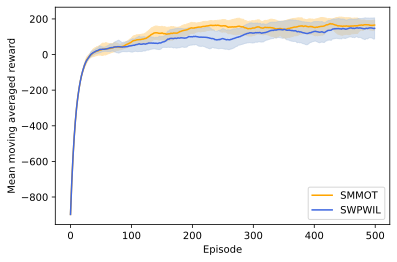

In [13]:
#final summary plot with 10 seeds 

plt.plot([r.ep for r in training_records_diff_mass_wass_PWIL_seed1], mean_lst, color = 'orange')
plt.fill_between( [r.ep for r in training_records_diff_mass_wass_PWIL_seed1],std_shade_neg, std_shade_pos, color = 'moccasin')

plt.plot([r.ep for r in training_records_diff_mass_wass_PWIL_seed1], _mean_lst, color = 'royalblue')
plt.fill_between( [r.ep for r in training_records_diff_mass_wass_PWIL_seed1],_std_shade_neg, _std_shade_pos, color = 'lightsteelblue', alpha = 0.5)

plt.xlabel('Episode')
plt.ylabel('Mean moving averaged reward')
plt.legend(['SMMOT', 'SWPWIL'])
plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/multi_diff_trajs_mass_cart_comparison_%s.png"%environment)

plt.show()